In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
import sys
from numba import jit
import pickle
from tqdm import tqdm
import scipy as sp
from scipy import stats
import multiprocessing

sys.path.append('/home/addis/PkBk/Library')
sys.path.append('/home/addis/PkBk/Scripts')

import Bk_theta_iFFT as Bk_theta
import Bk_full_iFFT as Bk_full
import get_field as gf
import compute_grid_info as cgi

plt.rc('font', size=16) 

In [2]:
#field things!
path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'
    
Nside=128
L=1000

**load and save dictionaries**

In [3]:
"""
def save_dict(Bk_save):
    #save dictionary to particualar folder
    # create a binary pickle file 
    f = open('Bispectra/theta/' + red_info +'_' + str(N_side) + ".pkl","wb")
    # write the python object (dict) to pickle file
    
    Bk_save['ks'] = ks  #saves k_eq for future.
    pickle.dump(Bk_save,f)
    # close file
    f.close()

save_dict(bk_full)   
"""
with open('../../Bispectra/'+ red_info +'_' + str(N_side) + ".pkl", 'rb') as f:
    bk_load = pickle.load(f)
    ks_load = bk_load['ks'] #get ks
    bk_load.pop('ks', None) # remove ks from dict
#bk_full = bk_load

In [4]:
print(bk_load['0']['l=1_[1, 0]'][10][0][3,3,:])

[ 411.20282-3.0414825e+09j -687.3513 -1.3859318e+09j
  600.9649 -1.4710545e+09j  -86.21423-3.3205125e+09j
    0.     +0.0000000e+00j    0.     +0.0000000e+00j
    0.     +0.0000000e+00j    0.     +0.0000000e+00j
    0.     +0.0000000e+00j    0.     +0.0000000e+00j
    0.     +0.0000000e+00j    0.     +0.0000000e+00j
    0.     +0.0000000e+00j    0.     +0.0000000e+00j
    0.     +0.0000000e+00j]


In [3]:
#get quick field
realisation = str(10049)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=-500'+ '.npy') #load field
#np.load('Quijote_fields/' + realisation + '_' + red_info + '_' + str(Nside) + 'LOS=Center' + '.npy') #load field

#### get information on box

In [4]:
%%time
rfft=False
order=2
obs_pos=(500,500,0)
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos)  # so call 
xi,xi_unorm,ki,k_mag,MAS,k_f,k_ny = grid_info

CPU times: user 3.82 s, sys: 112 ms, total: 3.94 s
Wall time: 3.94 s


In [5]:
%%time
dtype=np.complex64
s=1/2 #units of 2*k_f
threads=6
ks=np.arange(k_f,0.1,k_f)+ k_f/2 #offset for more centered bins at low k
binning_info = cgi.bk_full_compute_bins(ks,Nside,s,grid_info[3],grid_info[5],dtype,threads,rfft)
In_bin,Ntri = binning_info

CPU times: user 2min 37s, sys: 1.43 s, total: 2min 38s
Wall time: 14.1 s


In [6]:
%%time
rs = [0,0]
verbose =True
l = 1
exorder = 0
bkfull = Bk_full.Bk(field_tmp,l,L,Nside,ks,grid_info,binning_info,rs,exorder,dtype,threads,rfft,verbose,False).bk

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 4 Number of iFFTs used= 30
CPU times: user 38.5 s, sys: 1.22 s, total: 39.7 s
Wall time: 5.33 s


In [8]:
bk_full = {
    'Cen' : {},#redshift space in centre
    '-500' : {},#z_obs
    '0':{},
    'PP' : {}, # PP with RSD
    'real': {}#real space
    } 

In [ ]:
#wrapper function for multiprocessing
def bk_wrapper(inputs):
    verbose = False
    realisation_index,field,bk_dict,l,rs,exorder = inputs
    realisation = str(10000 + realisation_index)
    field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side)+field + '.npy') #   load field+ '_LOS=Cen'
    j = Bk_full.Bk(field_tmp,l,L,Nside,ks,grid_info,binning_info,rs,exorder,dtype,threads,rfft,verbose)
    return j

#function to run to calculate bispectrum for different multiplles over realisations...
#will add to already existing arrays adding extra from N_min to N_max
#if exorder is mid then it returns a (N_max,3,N_bins,N_bins,N_bins) and not just (N_max,N_bins,N_bins,N_bins)
def bk_realisations(field,bk_dict,ls,rs,exorder,N_min,N_max,cores=1,chunksize=5):#add path so choose fields as were
    
    if exorder=='mid':#if mid then calculate all 3 endpoints for given l
        for l in ls:  #which multipoles to calculate
            key ='l=%d'%(l) + '_' + 'end'
            key_mono ='l=%d'%(0)

            pool = multiprocessing.Pool(processes=cores)#set up pool
            inputs = [(i, field, bk_dict, l, rs, exorder) for i in range(N_min, N_max)] #define list of inputs
            result = np.array(list(tqdm(pool.imap(bk_wrapper, inputs, chunksize=chunksize), total=N_max-N_min)))
            pool.close()
            pool.join()
            
            arr_bk = np.array([i.bk for i in result])#get array of values

    else:
        for l in ls:  #which multipoles to calculate # monopole is calculated for any even multipole
            key ='l=%d'%(l) + '_' + str(rs)
            key_mono ='l=%d'%(0)

            pool = multiprocessing.Pool(processes=cores)#set up pool
            inputs = [(i, field, bk_dict, l, rs, exorder) for i in range(N_min, N_max)] #define list of inputs
            result = np.array(list(tqdm(pool.imap(bk_wrapper, inputs, chunksize=chunksize), total=N_max-N_min)))
            pool.close()
            pool.join()
            
            arr_bk = np.array([i.bk for i in result])#get array of values
            if l % 2 == 0:#if even
                arr_mono = np.array([i.mono for i in result])#get array of values
            
                
    if key in bk_dict.keys(): # create array with extra zeros beyond which has already been computed
        bk_temp = np.zeros((N_max,*arr_bk.shape[1:]),dtype=np.complex64) #create empty arrays in dict to store bispectra
        bk_temp[N_min:N_max] = arr_bk # set new results
        previous = 1*bk_dict[key] 
        bk_temp[:N_min] = previous # add prior results back
        bk_dict[key] = bk_temp # set new dict
        if l % 2 == 0:#if even
            bk_temp = np.zeros((N_max,len(ks),len(ks),len(ks)),dtype=np.complex64)
            bk_temp[N_min:N_max] = arr_mono # set new results
            previous = 1*bk_dict[key_mono] 
            bk_temp[:N_min] = previous
            bk_dict[key_mono] = bk_temp
    else:
        bk_dict[key] = arr_bk 
        if l % 2 ==0:#if even
            bk_dict[key_mono] = arr_mono
        

    return bk_dict

field = str(obs_pos[-1])#''PP'#real'#
fieldadd = '_LOS='+field
if field == 'real':
    fieldadd = ''
    
ls = [1]
rs = 'mid'#[0,0] #     #[0,0] can lead to it just doing endpoint despite exorder
exorder = 'mid'#1 #0#

#for multiprocessing
cores = 6
chunksize = 5
#update which dictionary as well as fields and ls,rs,exorder
bk_full[field] = bk_realisations(fieldadd,bk_full[field],ls,rs,exorder,110,250,cores,chunksize)

 18%|█▊        | 25/140 [05:24<23:02, 12.02s/it] 

In [30]:
bk_full['0']['l=1_end'].shape

(110, 3, 15, 15, 15)

In [98]:
print(bk_full['PP']['l=1_[0, 0]'].shape)
print(bk_full['0']['l=1_end'].shape)

(200, 15, 15, 15)
(250, 3, 15, 15, 15)


In [21]:
for i in ['0']:
    bk_full[i]['l=1_mid'] = np.sum(bk_full[i]['l=1_end'],axis=1)/3#get the midpoint combination before Avg and Std

In [31]:
def avg_err(Pk):#ok so adapt to nested dict structure...
    Pk_avg = {}
    Pk_err = {}
    for i in Pk.keys():#so this loops over each type - i.e. PP,Cen,real_space
        Pk_avg[i] = {}#create the nested dictionary to fill...
        Pk_err[i] = {}
        for j in Pk[i].keys(): # loop over multipole keys - to get mean and std for each
            Pk_avg[i][j] = np.mean((Pk[i][j]),axis=0)
            Pk_err[i][j] = np.std(Pk[i][j],axis=0)/np.sqrt(len(Pk[i][j])) # standard error makes sense as we have independent realisations
    return Pk_avg,Pk_err

bk_full_avg,bk_full_err = avg_err(bk_full)

#temp_arr = 1*bk_full['0']['l=1_mid']
#bk_full1['0']['l=1_mid'] = temp_arr[0:80]#this the way to change without chopping og
#bk_full_avg1,bk_full_err1 = avg_err(bk_full1)

In [11]:
k_eq = np.linspace(min(ks),max(ks),50)
theta_eq = 2*np.pi/3

#theta = np.arccos((ks**2 - ks[k1_]**2 - ks[k1_]**2)/(2*ks[k1_]*ks[k2_]))
theta_fold = np.pi

In [12]:
#lets define some plotting functions for this new binning scheme!
#plot equlateral triangles
def plot_full_eq(arr,arr_err,colour='black',label='',linestyle='-'):
    avgs = []
    errs = []
    k = []
    for i in range(len(ks)):
        avgs.append(arr[i,i,i].imag)
        errs.append(arr_err[i,i,i])
        k.append(ks[i])
    plt.errorbar(k,avgs,yerr=errs,fmt='o',capsize=2,color=colour,label=label,linestyle=linestyle)
    
#plot folded (isoceles) triangles
def plot_full_fold(arr,arr_err,colour='black',label='',linestyle='-'):
    avgs = []
    errs = []
    k = []
    for i in range(len(ks)//2):
        avgs.append(arr[2*i,i,i].imag)
        errs.append(arr_err[2*i,i,i])
        k.append(ks[i])
    plt.errorbar(k,avgs,yerr=errs,capsize=2,color=colour,label=label,linestyle=linestyle)#fmt='o',

#plot over theta just like old times
def plot_full_theta(arr,arr_err,k1_,k2_,colour='black',label='',linestyle='-'):
    avgs = []
    errs = []
    k = []   
    for i in range(len(ks)):
        k.append(ks[i])
        avgs.append(arr[k1_,k2_,i].imag)
        errs.append(arr_err[k1_,k2_,i])
    plt.errorbar(ks,avgs,yerr=errs,capsize=2,color=colour,label=label,linestyle=linestyle)

#plot over theta just like old times
def plot_full_theta(arr,arr_err,k1_,k2_,colour='black',label=''):
    avgs = []
    errs = []
    k = []   
    for i in range(len(ks)):
        k.append(ks[i])
        if i<k1_:
            if i< k2_:
                avgs.append(arr[k1_,k2_,i].imag)
                errs.append(arr_err[k1_,k2_,i])
            else:
                avgs.append(arr[k1_,i,k2_].imag)
                errs.append(arr_err[k1_,i,k2_])
        else:
            avgs.append(arr[i,k1_,k2_].imag)
            errs.append(arr_err[i,k1_,k2_])
    plt.errorbar(ks,avgs,yerr=errs,capsize=2,color=colour,label=label)

In [13]:
print('{0:.2f}'.format(1.6))

1.60


k1 = 0.02827433388230814
k2 = 0.02827433388230814


<ipython-input-32-61dd48fa35cd>:22: RuntimeWarning: invalid value encountered in arccos
  theta_ = np.arccos((ks**2 - ks[k1_]**2 - ks[k1_]**2)/(2*ks[k1_]*ks[k2_]))


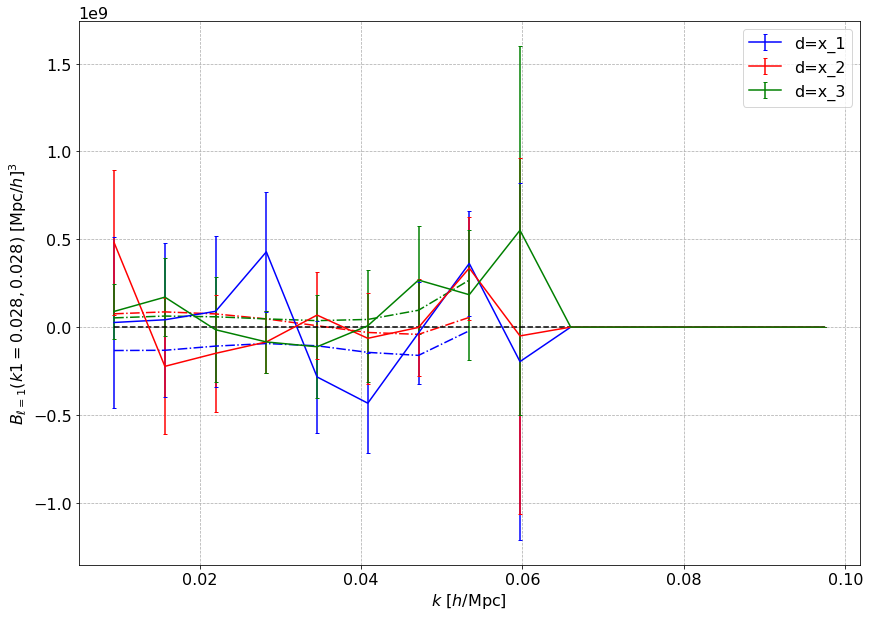

In [32]:
#ok for theta stuff....
plt.figure(figsize=(14,10))
k1_ = 3
k2_ = 3
print('k1 = '+ str(ks[k1_]))
print('k2 = '+ str(ks[k2_]))
#plot_full(bk_full_avg,bk_full_err,'0','l=1_[1, 0]',0,'blue')

#plot differnt LOS
plot_full_theta(bk_full_avg['0']['l=1_end'][0],bk_full_err['0']['l=1_end'][0],k1_,k2_,'blue','d=x_1')
plot_full_theta(bk_full_avg['0']['l=1_end'][1],bk_full_err['0']['l=1_end'][1],k1_,k2_,'red','d=x_2') 
plot_full_theta(bk_full_avg['0']['l=1_end'][2],bk_full_err['0']['l=1_end'][2],k1_,k2_,'green','d=x_3')

#midpoint
#plot_full_theta(bk_full_avg['0']['l=1_mid'],bk_full_err['0']['l=1_mid'],k1_,k2_,'orange','d=mid','-.')
#PP endpoint
#plot_full_theta(bk_full_avg['PP']['l=1_[0, 0]'],bk_full_err['PP']['l=1_[0, 0]'],k1_,k2_,'black','PP')
#real
#plot_full_theta(bk_full_avg['real']['l=1_[0, 0]'],bk_full_err['real']['l=1_[0, 0]'],k1_,k2_,'grey','real','--')

#plot theory -hmm this is not consistent...
theta_ = np.arccos((ks**2 - ks[k1_]**2 - ks[k1_]**2)/(2*ks[k1_]*ks[k2_]))
plt.plot(ks,bk_wide_angle(ks[k1_],ks[k2_],theta_,0,0)/560,'-.',color='blue')
plt.plot(ks,bk_wide_angle(ks[k1_],ks[k2_],theta_,1,0)/560,'-.',color='red')
plt.plot(ks,bk_wide_angle(ks[k1_],ks[k2_],theta_,0,1)/560,'-.',color='green')

#for plotting
plt.xlabel('$ k \,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ B_{\ell=1}(k1=' + '{0:.3f}'.format(ks[k1_])+','+ '{0:.3f}'.format(ks[k2_])+') \,\,[\mathrm{Mpc}/h]^3$')
plt.plot(ks,np.zeros_like(ks),'--', color='black')
plt.grid(ls='--',lw=0.75)
plt.legend()

In [27]:
#just testing correlations here...
def get_arr(arr):
    avgs = []
    for i in range(len(ks)//2):
        avgs.append(arr[2*i,i,i].imag)
    return avgs
    
arr1 = get_arr(bk_full_avg['0']['mid_'])
arr2 = get_arr(bk_full_avg['PP']['l=1_[0, 0]'])
print(stats.pearsonr(arr1,arr2))

KeyError: 'mid_'

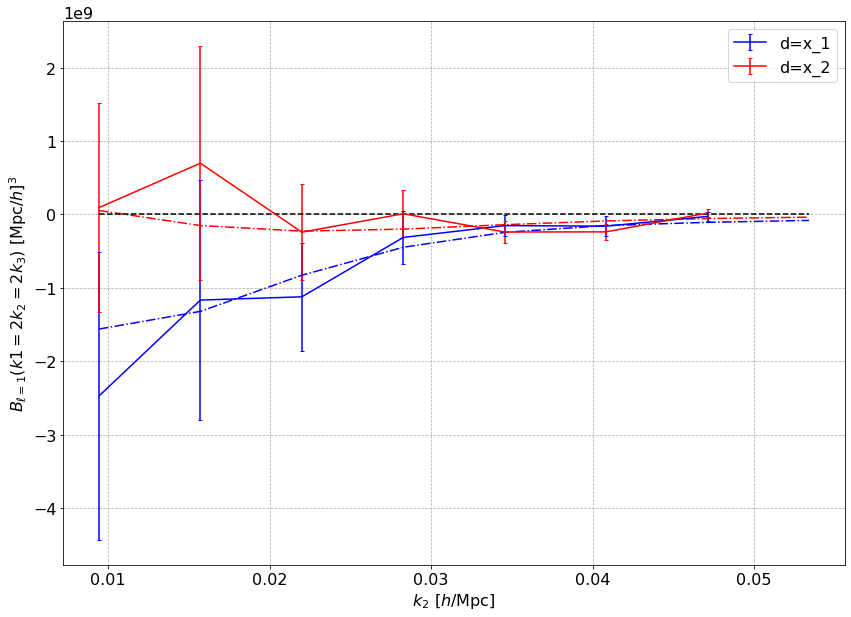

In [33]:
#ok for folded triangle stuff....
plt.figure(figsize=(14,10))

plot_full_fold(bk_full_avg['0']['l=1_end'][0],bk_full_err['0']['l=1_end'][0],'blue','d=x_1')
plot_full_fold(bk_full_avg['0']['l=1_end'][1],bk_full_err['0']['l=1_end'][1],'red','d=x_2')
#plot_full_fold(bk_full_avg['0']['l=1_end'][2],bk_full_err['0']['l=1_end'][2],'green','d=x_3') 

#mid
#plot_full_fold(bk_full_avg['0']['l=1_mid'],bk_full_err['0']['l=1_mid'],'orange','d=mid')
#PP
#plot_full_fold(bk_full_avg['PP']['l=1_[0, 0]'],bk_full_err['PP']['l=1_[0, 0]'],'black','d=PP')

#plot theory 
plt.plot(ks[:8],bk_wide_angle(2*ks,ks,np.pi,0,0)[:8]/560,'-.',color='blue')#
plt.plot(ks[:8],bk_wide_angle(2*ks,ks,np.pi,1,0)[:8]/560,'-.',color='red')
#plt.plot(ks[:8],bk_wide_angle(2*ks,ks,np.pi,0,1)[:8]/560,'-.',color='green')
#plt.plot(ks[:8],bk_wide_angle(2*ks,ks,np.pi,1/3,1/3)[:8]/560,'-.',color='orange')
#for plotting
plt.xlabel('$ k_2 \,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ B_{\ell=1}(k1=2 k_2=2 k_3) \,\,[\mathrm{Mpc}/h]^3$')
plt.plot(ks[:8],np.zeros_like(ks)[:8],'--', color='black')
plt.grid(ls='--',lw=0.75)
plt.legend()

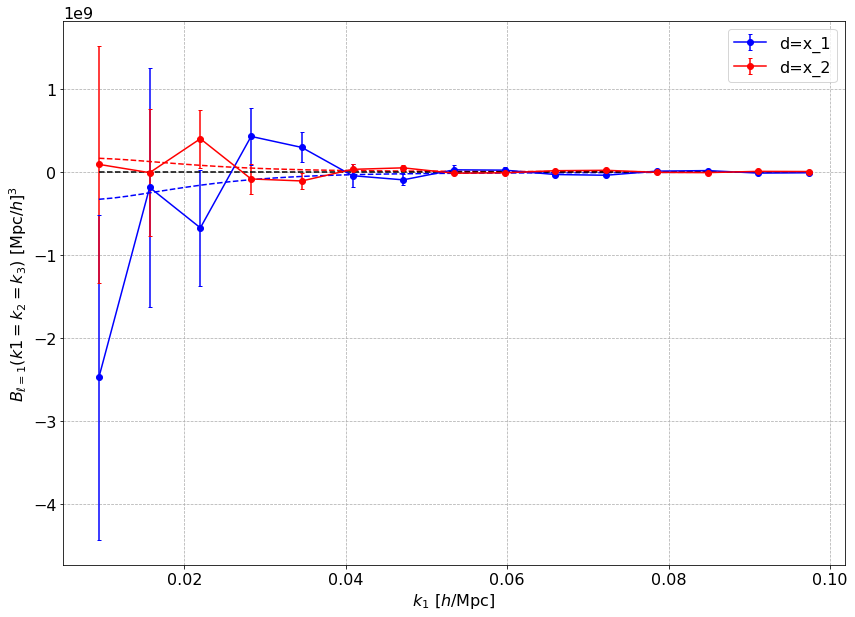

In [34]:
#ok for equalateral stuff....
plt.figure(figsize=(14,10))

plot_full_eq(bk_full_avg['0']['l=1_end'][0],bk_full_err['0']['l=1_end'][0],'blue','d=x_1')
plot_full_eq(bk_full_avg['0']['l=1_end'][1],bk_full_err['0']['l=1_end'][1],'red','d=x_2')
#plot_full_eq(bk_full_avg['0']['l=1_end'][2],bk_full_err['0']['l=1_end'][2],'green','d=x_3') 
for j in range(50):
    for i in range(10):
        1#plt.plot(ks[i],bk_full['0']['l=1_[1, 0]'][j][0][i,i,i].imag,',',color='grey',alpha=1)
        
#plane parralel 
#plot_full_eq(bk_full_avg['PP']['l=1_[0, 0]'],bk_full_err['PP']['l=1_[0, 0]'],'black','d=PP')
#plot mid
#plot_full_eq(bk_full_avg['0']['l=1_mid'],bk_full_err['0']['l=1_mid'],'orange','d=mid')

plt.plot(k_eq,bk_wide_angle(k_eq,k_eq,theta_eq,0,0,b2=0,gamma2=0)/560,'--',color='blue')
plt.plot(k_eq,bk_wide_angle(k_eq,k_eq,theta_eq,1,0,b2=0,gamma2=0)/560,'--',color='red')
#plt.plot(k_eq,bk_wide_angle(k_eq,k_eq,theta_eq,0,1,b2=0,gamma2=0)/560,'--',color='green')

#for plotiing
plt.xlabel('$ k_1 \,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ B_{\ell=1}(k1=k_2=k_3) \,\,[\mathrm{Mpc}/h]^3$')
plt.plot(ks,np.zeros_like(ks),'--', color='black')
plt.grid(ls='--',lw=0.75)
plt.legend()
plt.savefig('Eqaulateral_dipole.png')

In [193]:

def save_dict(Bk_save):
    #save dictionary to particualar folder
    # create a binary pickle file 
    f = open('Bispectra/theta/' + red_info +'_' + str(N_side) + ".pkl","wb")
    # write the python object (dict) to pickle file
    
    Bk_save['ks'] = ks  #saves k_eq for future.
    pickle.dump(Bk_save,f)
    # close file
    f.close()

save_dict(bk_full)   

with open('Bispectra/theta/'+ red_info +'_' + str(N_side) + ".pkl", 'rb') as f:
    bk_load = pickle.load(f)
    ks_load = bk_load['ks'] #get ks
    bk_load.pop('ks', None) # remove ks from dict
#bk_full = bk_load

In [54]:
print(bk_full_avg['0']['l=0'].shape)

(15, 15, 15)


<Figure size 864x504 with 0 Axes>

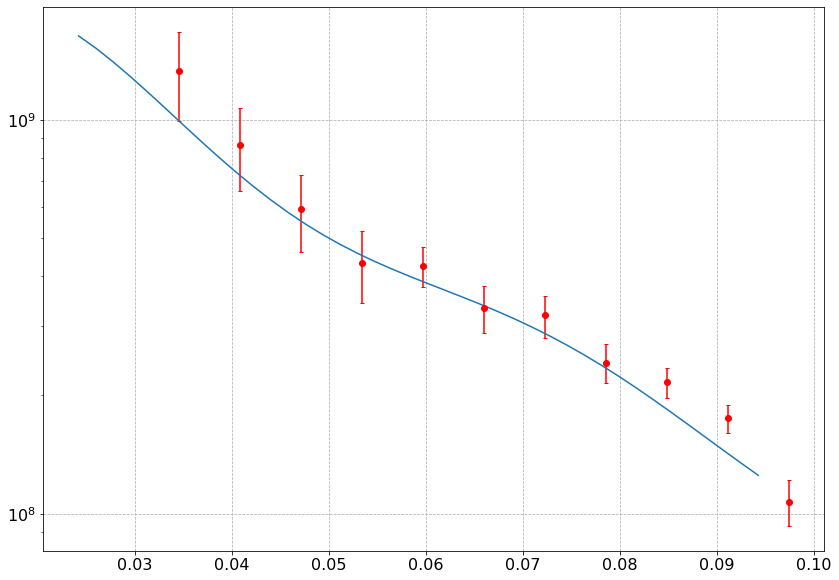

In [162]:
theta= np.linspace(0,np.pi,50)
plt.figure(figsize=(12,7))
rs = [0,0]
    
plt.figure(figsize=(14,10))
def plot_full_mono(dicts,dictserr,fieldkey,rskey,colour='black'):
    avgs = []
    errs = []
    k = []
    for i in range(4,len(ks)):
        avgs.append(dicts[fieldkey][rskey][i,i,i].real)
        errs.append(dictserr[fieldkey][rskey][i,i,i])
        k.append(ks[i])
    plt.errorbar(k,avgs,yerr=errs,fmt='o',capsize=2,color=colour)

#plot_full_mono(bk_full_avg,bk_full_err,'0','l=0')
plot_full_mono(bk_full_avg,bk_full_err,'PP','l=0','red')
plt.plot(k_eq[10:],bk_mono_func(k_eq,k_eq,theta_eq,b2=0,gamma2=0)[10:])


#plt.ylim(1e+8,5e+9)
plt.grid(ls='--',lw=0.75)
#plt.plot(theta_th,bkmono1,'--',color='black')
#plt.plot(theta_th,bkquad1,'--',color='red')
#plt.xscale('log')
plt.yscale('log')

In [50]:
theta_th= np.linspace(0,np.pi,100)
k1_th = 0.03
k2_th = 0.02
k3_th = np.sqrt(k1_th**2 + k2_th**2 + 2*k1_th*k2_th*np.cos(theta_th))

In [431]:
def chi2(data,err,model):
    sq = (data-model)**2/err**2
    return np.sum(sq)

3.1356832849595055
6.391844197531762


In [434]:
gg = 2
print(chi2(bkmid_avg[fieldkey][key][gg].imag-bkmid_avg[fieldkey1][key].imag,np.sqrt(bkmid_err[fieldkey][key][gg]**2+bkmid_err[fieldkey1][key][gg]**2),np.zeros(20)))
print(chi2(bkmid_avg[fieldkey][key][gg].imag-bkmid_avg[fieldkey1][key].imag,np.sqrt(bkmid_err[fieldkey][key][gg]**2+bkmid_err[fieldkey1][key][gg]**2),bk_wide_angle(k1,k2,theta,0,1)/610))

11.134518864043734
4.988083519270337


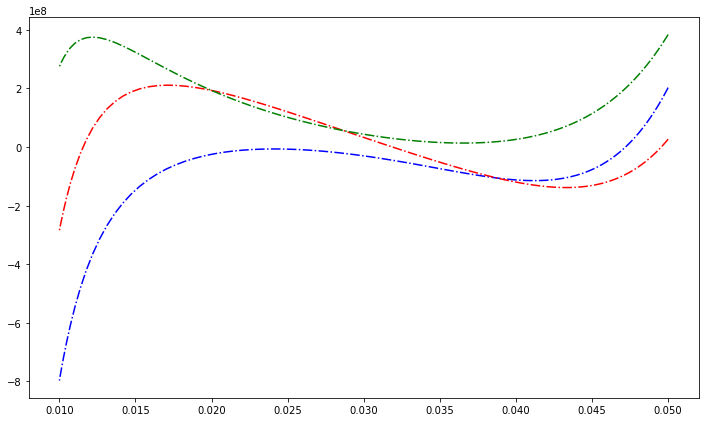

In [393]:
plt.figure(figsize=(12,7))

plt.plot(k3_th,bk_wide_angle(k1_th,k2_th,theta_th,0,0)/560,'-.',color='blue')
plt.plot(k3_th,bk_wide_angle(k1_th,k2_th,theta_th,1,0)/560,'-.',color='red')
plt.plot(k3_th,bk_wide_angle(k1_th,k2_th,theta_th,0,1)/560,'-.',color='green')


In [89]:
%%time
t=0.5
import cProfile
cProfile.run('Bk.Bk(field_tmp,l,L,Nside,theta,grid_info,binning_info,rs,dtype,threads,rfft,verbose)')
#cProfile.run('Pk.Pk(field_tmp,L,Nside,l,k,grid_info,binning_info, t,iFFT,dtype,threads,rfft,verbose)')

nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 1 Number of iFFTs used= 102
nyquist frequency= 0.40212385965949354 fundamental frequency= 0.006283185307179587
Number of FFTs used= 7 Number of iFFTs used= 102
         4214 function calls in 14.452 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       12    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(bincount)
       12    0.000    0.000    0.116    0.010 <__array_function__ internals>:2(prod)
      200    0.001    0.000    0.316    0.002 <__array_function__ internals>:2(sum)
      204    0.001    0.000    4.096    0.020 <__array_function__ internals>:2(where)
        1    0.000    0.000   14.452   14.452 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 Bk_theta_iFFT.py:119(delta_lm)
        1    1.646    1.646    6.525    6.525 Bk_theta_iFFT.py:139(Bk_endpoint_theta)
        1   

In [15]:
from classy import Class
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}

#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=1000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [16]:
#create x_c to integrate over - lets say it's a 1000 MPc/h (128x128x128) grid situated at (x,y,z)
Nside_theory= 128
conf_space = np.linspace(0,1000,Nside_theory)
x_unorm , y_unorm , z_unorm = np.meshgrid(conf_space-obs_pos[0], conf_space-obs_pos[1], conf_space-obs_pos[2],indexing='ij') 
conf_norm = np.sqrt(x_unorm**2 + y_unorm**2 + z_unorm**2) # make a unit vector - normalise
d = np.where(conf_norm==0,1,conf_norm)
print(1/np.mean(1/d))

559.0302110484354


In [17]:
print(np.mean(d))

669.8215299426312


In [18]:
b1= 1
gamma2 = -(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #-(2/7)*(b1-1) #0.524 -0.547*b1 +0.046*b1**2#-(2/7)*(b1-1) #
b2= 0.412 - 2.143*b1 +0.929*b1**2 + 0.008*b1**3 + 4/3 * gamma2

def sqrt(x):
    return x**(1/2)
def cos(x):
    return np.cos(x)
def exp(x):
    return np.exp(x)


In [19]:
print(gamma2)
print(b2)

-0.0
-0.7939999999999998


In [20]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x56171f9f0840>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [21]:
#%%time
z= 0.0

#ok so set a comoving distance of observation
#d = comoving_dist(z)

#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
    
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    return Pk,Pk_d,Pk_dd

#so set parameters...
Pk,Pk_d,Pk_dd = get_pkinfo_z(k,z)

f = f_intp(z)

In [22]:
#PP monopole and parallel
def bk_mono_func(k1,k2,theta,b2=0,gamma2=0):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #monopole parts
    bkperm3 = -Pk2*Pk3*(1470*b1**3*f*k1**4*k2 + 1470*b1**3*f*k1**3*k2**2*cos(3*theta) + 5670*b1**3*k1**4*k2 + 3150*b1**3*k1**3*k2**2*cos(3*theta) + 1260*b1**3*k1**2*k2**3 - 4410*b1**2*b2*k1**4*k2 - 17640*b1**2*b2*k1**2*k2**3 - 4410*b1**2*b2*k2**5 + 3822*b1**2*f**2*k1**4*k2 + 1470*b1**2*f**2*k1**3*k2**2*cos(3*theta) + 1176*b1**2*f**2*k1**2*k2**3 + 6090*b1**2*f*k1**4*k2 + 2730*b1**2*f*k1**3*k2**2*cos(3*theta) + 1680*b1**2*f*k1**2*k2**3 + 4410*b1**2*gamma2*k1**4*k2 - 4410*b1**2*gamma2*k1**3*k2**2*cos(3*theta) + 4410*b1**2*gamma2*k1**2*k2**3 - 2940*b1*b2*f*k1**4*k2 - 11760*b1*b2*f*k1**2*k2**3 - 2940*b1*b2*f*k2**5 + 126*b1*f**3*k1**5*cos(3*theta) + 126*b1*f**3*k1**4*k2*cos(4*theta) + 3024*b1*f**3*k1**4*k2 + 882*b1*f**3*k1**3*k2**2*cos(3*theta) + 1008*b1*f**3*k1**2*k2**3 + 294*b1*f**2*k1**5*cos(3*theta) + 315*b1*f**2*k1**4*k2*cos(4*theta) + 3675*b1*f**2*k1**4*k2 + 1785*b1*f**2*k1**3*k2**2*cos(3*theta) + 63*b1*f**2*k1**3*k2**2*cos(5*theta) + 126*b1*f**2*k1**2*k2**3*cos(4*theta) + 1050*b1*f**2*k1**2*k2**3 + 2940*b1*f*gamma2*k1**4*k2 - 2940*b1*f*gamma2*k1**3*k2**2*cos(3*theta) + 2940*b1*f*gamma2*k1**2*k2**3 - 588*b2*f**2*k1**4*k2 - 294*b2*f**2*k1**3*k2**2*cos(3*theta) - 3234*b2*f**2*k1**2*k2**3 - 882*b2*f**2*k2**5 + 70*f**4*k1**5*cos(3*theta) + 42*f**4*k1**4*k2*cos(4*theta) + 756*f**4*k1**4*k2 + 210*f**4*k1**3*k2**2*cos(3*theta) + 280*f**4*k1**2*k2**3 + 126*f**3*k1**5*cos(3*theta) + 117*f**3*k1**4*k2*cos(4*theta) + 837*f**3*k1**4*k2 + 441*f**3*k1**3*k2**2*cos(3*theta) + 27*f**3*k1**3*k2**2*cos(5*theta) + 54*f**3*k1**2*k2**3*cos(4*theta) + 270*f**3*k1**2*k2**3 - 147*f**2*gamma2*k1**4*k2*cos(4*theta) + 441*f**2*gamma2*k1**4*k2 - 882*f**2*gamma2*k1**3*k2**2*cos(3*theta) + 882*f**2*gamma2*k1**2*k2**3 + 6*k1**2*k2*(35*b1**3*(k1**2*(14*f + 36) + k2**2*(7*f + 15)) + 7*b1**2*(-210*b2*k2**2 + 7*f**2*(14*k1**2 + 5*k2**2) + 5*f*(34*k1**2 + 13*k2**2) - 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k2**2 + 3*f**2*(20*k1**2 + 7*k2**2) + f*(94*k1**2 + 35*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(k1**2 + 7*k2**2) + 7*f**2*(16*k1**2 + 5*k2**2) + 3*f*(52*k1**2 + 17*k2**2) - 49*gamma2*(k1**2 + 3*k2**2)))*cos(2*theta) + 6*k1*(35*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(14*f + 48)) + 7*b1**2*(7*f**2*(9*k1**4 + 22*k1**2*k2**2) + 5*f*(21*k1**4 + 50*k1**2*k2**2) - 105*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + 7*b1*f*(6*f**2*(7*k1**4 + 19*k1**2*k2**2) + f*(56*k1**4 + 145*k1**2*k2**2) - 70*k2**2*(4*b2*(k1**2 + k2**2) - gamma2*k1**2)) + f**2*(70*f**2*(k1**4 + 3*k1**2*k2**2) + 3*f*(28*k1**4 + 79*k1**2*k2**2) - 49*k2**2*(11*b2*k1**2 + 12*b2*k2**2 - 3*gamma2*k1**2)))*cos(theta))/(4410*k2*k3**4)
    bkperm2 = -Pk1*Pk3*(1470*b1**3*f*k1**2*k2**3*cos(3*theta) + 1470*b1**3*f*k1*k2**4 + 1260*b1**3*k1**3*k2**2 + 3150*b1**3*k1**2*k2**3*cos(3*theta) + 5670*b1**3*k1*k2**4 - 4410*b1**2*b2*k1**5 - 17640*b1**2*b2*k1**3*k2**2 - 4410*b1**2*b2*k1*k2**4 + 1176*b1**2*f**2*k1**3*k2**2 + 1470*b1**2*f**2*k1**2*k2**3*cos(3*theta) + 3822*b1**2*f**2*k1*k2**4 + 1680*b1**2*f*k1**3*k2**2 + 2730*b1**2*f*k1**2*k2**3*cos(3*theta) + 6090*b1**2*f*k1*k2**4 + 4410*b1**2*gamma2*k1**3*k2**2 - 4410*b1**2*gamma2*k1**2*k2**3*cos(3*theta) + 4410*b1**2*gamma2*k1*k2**4 - 2940*b1*b2*f*k1**5 - 11760*b1*b2*f*k1**3*k2**2 - 2940*b1*b2*f*k1*k2**4 + 1008*b1*f**3*k1**3*k2**2 + 882*b1*f**3*k1**2*k2**3*cos(3*theta) + 126*b1*f**3*k1*k2**4*cos(4*theta) + 3024*b1*f**3*k1*k2**4 + 126*b1*f**3*k2**5*cos(3*theta) + 126*b1*f**2*k1**3*k2**2*cos(4*theta) + 1050*b1*f**2*k1**3*k2**2 + 1785*b1*f**2*k1**2*k2**3*cos(3*theta) + 63*b1*f**2*k1**2*k2**3*cos(5*theta) + 315*b1*f**2*k1*k2**4*cos(4*theta) + 3675*b1*f**2*k1*k2**4 + 294*b1*f**2*k2**5*cos(3*theta) + 2940*b1*f*gamma2*k1**3*k2**2 - 2940*b1*f*gamma2*k1**2*k2**3*cos(3*theta) + 2940*b1*f*gamma2*k1*k2**4 - 882*b2*f**2*k1**5 - 3234*b2*f**2*k1**3*k2**2 - 294*b2*f**2*k1**2*k2**3*cos(3*theta) - 588*b2*f**2*k1*k2**4 + 280*f**4*k1**3*k2**2 + 210*f**4*k1**2*k2**3*cos(3*theta) + 42*f**4*k1*k2**4*cos(4*theta) + 756*f**4*k1*k2**4 + 70*f**4*k2**5*cos(3*theta) + 54*f**3*k1**3*k2**2*cos(4*theta) + 270*f**3*k1**3*k2**2 + 441*f**3*k1**2*k2**3*cos(3*theta) + 27*f**3*k1**2*k2**3*cos(5*theta) + 117*f**3*k1*k2**4*cos(4*theta) + 837*f**3*k1*k2**4 + 126*f**3*k2**5*cos(3*theta) + 882*f**2*gamma2*k1**3*k2**2 - 882*f**2*gamma2*k1**2*k2**3*cos(3*theta) - 147*f**2*gamma2*k1*k2**4*cos(4*theta) + 441*f**2*gamma2*k1*k2**4 + 6*k1*k2**2*(35*b1**3*(k1**2*(7*f + 15) + k2**2*(14*f + 36)) - 7*b1**2*(210*b2*k1**2 - 7*f**2*(5*k1**2 + 14*k2**2) - 5*f*(13*k1**2 + 34*k2**2) + 105*gamma2*(k1**2 + k2**2)) + 7*b1*f*(-140*b2*k1**2 + 3*f**2*(7*k1**2 + 20*k2**2) + f*(35*k1**2 + 94*k2**2) - 70*gamma2*(k1**2 + k2**2)) + f**2*(-49*b2*(7*k1**2 + k2**2) + 7*f**2*(5*k1**2 + 16*k2**2) + 3*f*(17*k1**2 + 52*k2**2) - 49*gamma2*(3*k1**2 + k2**2)))*cos(2*theta) + 6*k2*(35*b1**3*(k1**2*k2**2*(14*f + 48) + k2**4*(7*f + 21)) - 7*b1**2*(420*b2*k1**2*(k1**2 + k2**2) - k2**2*(7*f**2*(22*k1**2 + 9*k2**2) + 5*f*(50*k1**2 + 21*k2**2) + 105*gamma2*k1**2)) + 7*b1*f*(-280*b2*k1**2*(k1**2 + k2**2) + k2**2*(6*f**2*(19*k1**2 + 7*k2**2) + f*(145*k1**2 + 56*k2**2) + 70*gamma2*k1**2)) + f**2*(-49*b2*(12*k1**4 + 11*k1**2*k2**2) + k2**2*(70*f**2*(3*k1**2 + k2**2) + 3*f*(79*k1**2 + 28*k2**2) + 147*gamma2*k1**2)))*cos(theta))/(4410*k1*k3**4)
    bkperm1 = Pk1*Pk2*(4410*b1**3*f*k1**3*k2 + 4410*b1**3*f*k1*k2**3 + 11970*b1**3*k1**3*k2 + 1260*b1**3*k1**2*k2**2*cos(3*theta) + 11970*b1**3*k1*k2**3 + 4410*b1**2*b2*k1**3*k2 + 4410*b1**2*b2*k1*k2**3 + 6762*b1**2*f**2*k1**3*k2 + 1176*b1**2*f**2*k1**2*k2**2*cos(3*theta) + 6762*b1**2*f**2*k1*k2**3 + 11550*b1**2*f*k1**3*k2 + 1680*b1**2*f*k1**2*k2**2*cos(3*theta) + 11550*b1**2*f*k1*k2**3 - 4410*b1**2*gamma2*k1**3*k2 + 4410*b1**2*gamma2*k1**2*k2**2*cos(3*theta) - 4410*b1**2*gamma2*k1*k2**3 + 2940*b1*b2*f*k1**3*k2 + 2940*b1*b2*f*k1*k2**3 + 126*b1*f**3*k1**4*cos(3*theta) + 126*b1*f**3*k1**3*k2*cos(4*theta) + 4032*b1*f**3*k1**3*k2 + 1764*b1*f**3*k1**2*k2**2*cos(3*theta) + 126*b1*f**3*k1*k2**3*cos(4*theta) + 4032*b1*f**3*k1*k2**3 + 126*b1*f**3*k2**4*cos(3*theta) + 294*b1*f**2*k1**4*cos(3*theta) + 273*b1*f**2*k1**3*k2*cos(4*theta) + 5733*b1*f**2*k1**3*k2 + 2310*b1*f**2*k1**2*k2**2*cos(3*theta) + 42*b1*f**2*k1**2*k2**2*cos(5*theta) + 273*b1*f**2*k1*k2**3*cos(4*theta) + 5733*b1*f**2*k1*k2**3 + 294*b1*f**2*k2**4*cos(3*theta) - 2940*b1*f*gamma2*k1**3*k2 + 2940*b1*f*gamma2*k1**2*k2**2*cos(3*theta) - 2940*b1*f*gamma2*k1*k2**3 + 588*b2*f**2*k1**3*k2 + 294*b2*f**2*k1**2*k2**2*cos(3*theta) + 588*b2*f**2*k1*k2**3 + 70*f**4*k1**4*cos(3*theta) + 98*f**4*k1**3*k2*cos(4*theta) + 924*f**4*k1**3*k2 + 616*f**4*k1**2*k2**2*cos(3*theta) + 28*f**4*k1**2*k2**2*cos(5*theta) + 98*f**4*k1*k2**3*cos(4*theta) + 924*f**4*k1*k2**3 + 70*f**4*k2**4*cos(3*theta) + 126*f**3*k1**4*cos(3*theta) + 135*f**3*k1**3*k2*cos(4*theta) + 1179*f**3*k1**3*k2 + 756*f**3*k1**2*k2**2*cos(3*theta) + 36*f**3*k1**2*k2**2*cos(5*theta) + 135*f**3*k1*k2**3*cos(4*theta) + 1179*f**3*k1*k2**3 + 126*f**3*k2**4*cos(3*theta) + 147*f**2*gamma2*k1**3*k2*cos(4*theta) - 441*f**2*gamma2*k1**3*k2 + 441*f**2*gamma2*k1**2*k2**2*cos(3*theta) + 147*f**2*gamma2*k1**2*k2**2*cos(5*theta) + 147*f**2*gamma2*k1*k2**3*cos(4*theta) - 441*f**2*gamma2*k1*k2**3 + k1*k2*(k1**2 + k2**2)*(210*b1**3*(7*f + 27) + 42*b1**2*(91*f**2 + 145*f + 105*gamma2) + 42*b1*f*(81*f**2 + 109*f + 70*gamma2) + 2*f**2*(147*b2 + 469*f**2 + 603*f + 147*gamma2))*cos(2*theta) + (210*b1**3*(k1**4*(7*f + 21) + k1**2*k2**2*(42*f + 120) + k2**4*(7*f + 21)) + 42*b1**2*(7*f**2*(9*k1**4 + 50*k1**2*k2**2 + 9*k2**4) + 5*f*(21*k1**4 + 118*k1**2*k2**2 + 21*k2**4) + k1**2*k2**2*(210*b2 - 105*gamma2)) + 84*b1*f*(3*f**2*(7*k1**4 + 38*k1**2*k2**2 + 7*k2**4) + 7*f*(4*k1**4 + 23*k1**2*k2**2 + 4*k2**4) + k1**2*k2**2*(70*b2 - 35*gamma2)) + 2*f**2*(14*f**2*(15*k1**4 + 82*k1**2*k2**2 + 15*k2**4) + 18*f*(14*k1**4 + 83*k1**2*k2**2 + 14*k2**4) + k1**2*k2**2*(735*b2 - 294*gamma2)))*cos(theta))/(4410*k1*k2*k3**2)
    return (bkperm3+bkperm2+bkperm1)

def bk_quad_func(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))
    
    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)
    
    #quadrupole parts
    bkquad1 = -Pk2*Pk3*f*(12936*b1**3*k1**4*k2 + 12936*b1**3*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**5*cos(3*theta) + 4158*b1**2*f*k1**4*k2*cos(4*theta) + 41118*b1**2*f*k1**4*k2 + 27489*b1**2*f*k1**3*k2**2*cos(3*theta) + 2079*b1**2*f*k1**3*k2**2*cos(5*theta) + 4158*b1**2*f*k1**2*k2**3*cos(4*theta) + 12012*b1**2*f*k1**2*k2**3 + 4851*b1**2*k1**5*cos(3*theta) + 8316*b1**2*k1**4*k2*cos(4*theta) + 49434*b1**2*k1**4*k2 + 33033*b1**2*k1**3*k2**2*cos(3*theta) + 3465*b1**2*k1**3*k2**2*cos(5*theta) + 6930*b1**2*k1**2*k2**3*cos(4*theta) + 16170*b1**2*k1**2*k2**3 - 16170*b1*b2*k1**4*k2 - 19404*b1*b2*k1**3*k2**2*cos(3*theta) - 9702*b1*b2*k1**2*k2**3*cos(4*theta) - 64680*b1*b2*k1**2*k2**3 - 29106*b1*b2*k1*k2**4*cos(3*theta) - 6468*b1*b2*k2**5 + 3234*b1*f**2*k1**5*cos(3*theta) + 4620*b1*f**2*k1**4*k2*cos(4*theta) + 37884*b1*f**2*k1**4*k2 + 20790*b1*f**2*k1**3*k2**2*cos(3*theta) + 1386*b1*f**2*k1**3*k2**2*cos(5*theta) + 2772*b1*f**2*k1**2*k2**3*cos(4*theta) + 11088*b1*f**2*k1**2*k2**3 + 5082*b1*f*k1**5*cos(3*theta) + 7524*b1*f*k1**4*k2*cos(4*theta) + 43032*b1*f*k1**4*k2 + 28182*b1*f*k1**3*k2**2*cos(3*theta) + 2574*b1*f*k1**3*k2**2*cos(5*theta) + 5148*b1*f*k1**2*k2**3*cos(4*theta) + 12804*b1*f*k1**2*k2**3 - 4851*b1*gamma2*k1**4*k2*cos(4*theta) + 11319*b1*gamma2*k1**4*k2 - 11319*b1*gamma2*k1**3*k2**2*cos(3*theta) - 4851*b1*gamma2*k1**3*k2**2*cos(5*theta) - 9702*b1*gamma2*k1**2*k2**3*cos(4*theta) - 3234*b1*gamma2*k1**2*k2**3 - 6006*b2*f*k1**4*k2 - 9240*b2*f*k1**3*k2**2*cos(3*theta) - 4158*b2*f*k1**2*k2**3*cos(4*theta) - 26796*b2*f*k1**2*k2**3 - 12474*b2*f*k1*k2**4*cos(3*theta) - 2772*b2*f*k2**5 + 1435*f**3*k1**5*cos(3*theta) + 1428*f**3*k1**4*k2*cos(4*theta) + 10584*f**3*k1**4*k2 + 5565*f**3*k1**3*k2**2*cos(3*theta) + 315*f**3*k1**3*k2**2*cos(5*theta) + 630*f**3*k1**2*k2**3*cos(4*theta) + 3220*f**3*k1**2*k2**3 + 2079*f**2*k1**5*cos(3*theta) + 2508*f**2*k1**4*k2*cos(4*theta) + 11418*f**2*k1**4*k2 + 7656*f**2*k1**3*k2**2*cos(3*theta) + 924*f**2*k1**3*k2**2*cos(5*theta) + 1254*f**2*k1**2*k2**3*cos(4*theta) + 99*f**2*k1**2*k2**3*cos(6*theta) + 3366*f**2*k1**2*k2**3 - 2541*f*gamma2*k1**4*k2*cos(4*theta) + 3465*f*gamma2*k1**4*k2 - 4851*f*gamma2*k1**3*k2**2*cos(3*theta) - 2079*f*gamma2*k1**3*k2**2*cos(5*theta) - 4158*f*gamma2*k1**2*k2**3*cos(4*theta) - 1386*f*gamma2*k1**2*k2**3 + 3*k1*(4312*b1**3*(k1**4 + 2*k1**2*k2**2) + 77*b1**2*k1**2*(k1**2*(135*f + 147) + k2**2*(304*f + 346)) + 22*b1*(7*f**2*(53*k1**4 + 132*k1**2*k2**2) + f*(427*k1**4 + 1046*k1**2*k2**2) - 49*k2**2*(26*b2*k1**2 + 23*b2*k2**2 - 5*gamma2*k1**2)) + f*(35*f**2*(61*k1**4 + 168*k1**2*k2**2) + 11*f*(217*k1**4 + 580*k1**2*k2**2) - 154*k2**2*(76*b2*k1**2 + 69*b2*k2**2 - 15*gamma2*k1**2)))*cos(theta) + 3*k2*(4312*b1**3*k1**2*(2*k1**2 + k2**2) + 154*b1**2*k1**2*(k1**2*(118*f + 127) + k2**2*(37*f + 34)) - 22*b1*(49*b2*(3*k1**4 + 25*k1**2*k2**2 + 6*k2**4) - 2*k1**2*(7*f**2*(44*k1**2 + 15*k2**2) + f*(373*k1**2 + 116*k2**2) - 49*gamma2*(k1**2 - 2*k2**2))) + f*(-154*b2*(11*k1**4 + 77*k1**2*k2**2 + 18*k2**4) + k1**2*(14*f**2*(274*k1**2 + 95*k2**2) + 11*f*(418*k1**2 + 137*k2**2) - 308*gamma2*(k1**2 - 6*k2**2))))*cos(2*theta))/(19404*k2*k3**4)
    bkquad2 = -Pk1*Pk3*f*(9702*b1**3*k1**3*k2**2 + 3234*b1**3*k1**2*k2**3*cos(3*theta) + 22638*b1**3*k1*k2**4 + 16170*b1**2*f*k1**3*k2**2 + 19173*b1**2*f*k1**2*k2**3*cos(3*theta) + 4158*b1**2*f*k1*k2**4*cos(4*theta) + 49434*b1**2*f*k1*k2**4 + 4158*b1**2*f*k2**5*cos(3*theta) + 2079*b1**2*k1**3*k2**2*cos(4*theta) + 11319*b1**2*k1**3*k2**2 + 32340*b1**2*k1**2*k2**3*cos(3*theta) + 2079*b1**2*k1**2*k2**3*cos(5*theta) + 10395*b1**2*k1*k2**4*cos(4*theta) + 45969*b1**2*k1*k2**4 + 9702*b1**2*k2**5*cos(3*theta) - 25872*b1*b2*k1**5 - 93786*b1*b2*k1**3*k2**2 - 9702*b1*b2*k1**2*k2**3*cos(3*theta) - 16170*b1*b2*k1*k2**4 + 14322*b1*f**2*k1**3*k2**2 + 15708*b1*f**2*k1**2*k2**3*cos(3*theta) + 4158*b1*f**2*k1*k2**4*cos(4*theta) + 38808*b1*f**2*k1*k2**4 + 5544*b1*f**2*k2**5*cos(3*theta) + 2178*b1*f*k1**3*k2**2*cos(4*theta) + 12210*b1*f*k1**3*k2**2 + 25806*b1*f*k1**2*k2**3*cos(3*theta) + 1980*b1*f*k1**2*k2**3*cos(5*theta) + 9306*b1*f*k1*k2**4*cos(4*theta) + 40062*b1*f*k1*k2**4 + 9240*b1*f*k2**5*cos(3*theta) + 25872*b1*gamma2*k1**3*k2**2 - 25872*b1*gamma2*k1**2*k2**3*cos(3*theta) - 4851*b1*gamma2*k1*k2**4*cos(4*theta) + 11319*b1*gamma2*k1*k2**4 - 11088*b2*f*k1**5 - 39270*b2*f*k1**3*k2**2 - 5082*b2*f*k1**2*k2**3*cos(3*theta) - 6006*b2*f*k1*k2**4 + 4270*f**3*k1**3*k2**2 + 4305*f**3*k1**2*k2**3*cos(3*theta) + 1428*f**3*k1*k2**4*cos(4*theta) + 10584*f**3*k1*k2**4 + 1855*f**3*k2**5*cos(3*theta) + 105*f**3*k2**5*cos(5*theta) + 891*f**2*k1**3*k2**2*cos(4*theta) + 3795*f**2*k1**3*k2**2 + 7194*f**2*k1**2*k2**3*cos(3*theta) + 693*f**2*k1**2*k2**3*cos(5*theta) + 2871*f**2*k1*k2**4*cos(4*theta) + 99*f**2*k1*k2**4*cos(6*theta) + 10989*f**2*k1*k2**4 + 2541*f**2*k2**5*cos(3*theta) + 231*f**2*k2**5*cos(5*theta) + 11088*f*gamma2*k1**3*k2**2 - 11088*f*gamma2*k1**2*k2**3*cos(3*theta) - 2541*f*gamma2*k1*k2**4*cos(4*theta) + 3465*f*gamma2*k1*k2**4 + 3*k1*k2**2*(1078*b1**3*(k1**2 + 5*k2**2) + 154*b1**2*(k1**2*(37*f + 55) + k2**2*(100*f + 130)) + 22*b1*(-49*b2*(19*k1**2 + 3*k2**2) + 203*f**2*(k1**2 + 3*k2**2) + f*(286*k1**2 + 764*k2**2) - 98*gamma2*(4*k1**2 + k2**2)) + f*(-154*b2*(59*k1**2 + 11*k2**2) + 14*f**2*(85*k1**2 + 274*k2**2) + 33*f*(46*k1**2 + 139*k2**2) - 308*gamma2*(12*k1**2 + k2**2)))*cos(2*theta) + 3*k2*(1078*b1**3*(11*k1**2*k2**2 + 4*k2**4) + 77*b1**2*(k1**2*k2**2*(349*f + 355) + k2**4*(126*f + 126)) - 22*b1*(49*b2*(32*k1**4 + 29*k1**2*k2**2) - k2**2*(14*f**2*(73*k1**2 + 24*k2**2) + f*(1091*k1**2 + 364*k2**2) + 392*gamma2*k1**2)) + f*(-154*b2*(96*k1**4 + 85*k1**2*k2**2) + k2**2*(35*f**2*(183*k1**2 + 56*k2**2) + 11*f*(601*k1**2 + 196*k2**2) + 3696*gamma2*k1**2)))*cos(theta))/(19404*k1*k3**4)
    bkquad3 = Pk1*Pk2*f*(29106*b1**3*k1**3*k2 + 9702*b1**3*k1**2*k2**2*cos(3*theta) + 29106*b1**3*k1*k2**3 + 2079*b1**2*f*k1**4*cos(3*theta) + 2079*b1**2*f*k1**3*k2*cos(4*theta) + 69069*b1**2*f*k1**3*k2 + 34881*b1**2*f*k1**2*k2**2*cos(3*theta) + 4158*b1**2*f*k1*k2**3*cos(4*theta) + 66990*b1**2*f*k1*k2**3 + 4158*b1**2*f*k2**4*cos(3*theta) + 4851*b1**2*k1**4*cos(3*theta) + 6237*b1**2*k1**3*k2*cos(4*theta) + 81543*b1**2*k1**3*k2 + 44583*b1**2*k1**2*k2**2*cos(3*theta) + 1386*b1**2*k1**2*k2**2*cos(5*theta) + 9009*b1**2*k1*k2**3*cos(4*theta) + 70455*b1**2*k1*k2**3 + 9702*b1**2*k2**4*cos(3*theta) + 16170*b1*b2*k1**3*k2 + 9702*b1*b2*k1**2*k2**2*cos(3*theta) + 16170*b1*b2*k1*k2**3 + 3234*b1*f**2*k1**4*cos(3*theta) + 4620*b1*f**2*k1**3*k2*cos(4*theta) + 52206*b1*f**2*k1**3*k2 + 36498*b1*f**2*k1**2*k2**2*cos(3*theta) + 1386*b1*f**2*k1**2*k2**2*cos(5*theta) + 6930*b1*f**2*k1*k2**3*cos(4*theta) + 49896*b1*f**2*k1*k2**3 + 5544*b1*f**2*k2**4*cos(3*theta) + 5082*b1*f*k1**4*cos(3*theta) + 6798*b1*f*k1**3*k2*cos(4*theta) + 65538*b1*f*k1**3*k2 + 42900*b1*f*k1**2*k2**2*cos(3*theta) + 1914*b1*f*k1**2*k2**2*cos(5*theta) + 9174*b1*f*k1*k2**3*cos(4*theta) + 56034*b1*f*k1*k2**3 + 9240*b1*f*k2**4*cos(3*theta) + 4851*b1*gamma2*k1**3*k2*cos(4*theta) - 11319*b1*gamma2*k1**3*k2 + 11319*b1*gamma2*k1**2*k2**2*cos(3*theta) + 4851*b1*gamma2*k1**2*k2**2*cos(5*theta) + 4851*b1*gamma2*k1*k2**3*cos(4*theta) - 11319*b1*gamma2*k1*k2**3 + 6006*b2*f*k1**3*k2 + 5082*b2*f*k1**2*k2**2*cos(3*theta) + 6006*b2*f*k1*k2**3 + 1435*f**3*k1**4*cos(3*theta) + 2387*f**3*k1**3*k2*cos(4*theta) + 13461*f**3*k1**3*k2 + 11914*f**3*k1**2*k2**2*cos(3*theta) + 1057*f**3*k1**2*k2**2*cos(5*theta) + 2912*f**3*k1*k2**3*cos(4*theta) + 105*f**3*k1*k2**3*cos(6*theta) + 12936*f**3*k1*k2**3 + 1855*f**3*k2**4*cos(3*theta) + 105*f**3*k2**4*cos(5*theta) + 2079*f**2*k1**4*cos(3*theta) + 2805*f**2*k1**3*k2*cos(4*theta) + 16071*f**2*k1**3*k2 + 13596*f**2*k1**2*k2**2*cos(3*theta) + 1155*f**2*k1**2*k2**2*cos(5*theta) + 3597*f**2*k1*k2**3*cos(4*theta) + 132*f**2*k1*k2**3*cos(6*theta) + 14883*f**2*k1*k2**3 + 2541*f**2*k2**4*cos(3*theta) + 231*f**2*k2**4*cos(5*theta) + 2541*f*gamma2*k1**3*k2*cos(4*theta) - 3465*f*gamma2*k1**3*k2 + 3465*f*gamma2*k1**2*k2**2*cos(3*theta) + 2541*f*gamma2*k1**2*k2**2*cos(5*theta) + 2541*f*gamma2*k1*k2**3*cos(4*theta) - 3465*f*gamma2*k1*k2**3 + k1*k2*(22638*b1**3*(k1**2 + k2**2) + 924*b1**2*(k1**2*(67*f + 73) + k2**2*(67*f + 82)) + 66*b1*(147*b2*(k1**2 + k2**2) + 819*f**2*(k1**2 + k2**2) + 4*f*(230*k1**2 + 257*k2**2) + 98*gamma2*(k1**2 + k2**2)) + f*(5082*b2*(k1**2 + k2**2) + 7*f**2*(2216*k1**2 + 2201*k2**2) + 132*f*(137*k1**2 + 139*k2**2) + 924*gamma2*(k1**2 + k2**2)))*cos(2*theta) + (3234*b1**3*(4*k1**4 + 21*k1**2*k2**2 + 4*k2**4) + 231*b1**2*(k1**4*(135*f + 147) + k1**2*k2**2*(713*f + 809) + k2**4*(126*f + 126)) + 462*b1*(f**2*(53*k1**4 + 278*k1**2*k2**2 + 48*k2**4) + f*(61*k1**4 + 335*k1**2*k2**2 + 52*k2**4) + k1**2*k2**2*(91*b2 - 35*gamma2)) + f*(7*f**2*(915*k1**4 + 4867*k1**2*k2**2 + 840*k2**4) + 33*f*(217*k1**4 + 1233*k1**2*k2**2 + 196*k2**4) + k1**2*k2**2*(17094*b2 - 6006*gamma2)))*cos(theta))/(19404*k1*k2*k3**2)
     
    return bkquad1 + bkquad2 + bkquad3

In [23]:
def bk_wide_angle(k1,k2,theta,r=1/3,s=1/3,b2=0,gamma2=0): #Latest version - and appears to aggree with Milad and Kevin
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    Pkd1= Pk_d(k1)
    Pkd2 = Pk_d(k2)
    Pkd3 = Pk_d(k3)
    
    #bk_dic = {} #could be nice to have dictionary to call each part independently??
    #e1 part
    #d.e1
    bk_de1_12 = -Pk2*f*(12936*Pk1*b1**3*k1*k2*k3**4*r + 12936*Pk1*b1**3*k1*k2*k3**4*s - 12936*Pk1*b1**3*k1*k2*k3**4 + 59136*Pk1*b1**2*f*k1*k2*k3**4*r + 59136*Pk1*b1**2*f*k1*k2*k3**4*s - 43428*Pk1*b1**2*f*k1*k2*k3**4 - 5544*Pk1*b1**2*f*k2**2*k3**4*r*cos(3*theta) - 5544*Pk1*b1**2*f*k2**2*k3**4*s*cos(3*theta) + 5544*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 56826*Pk1*b1**2*k1**5*k2*r - 56826*Pk1*b1**2*k1**5*k2*s + 56826*Pk1*b1**2*k1**5*k2 - 26334*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 26334*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 26334*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 5544*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*r - 5544*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 99792*Pk1*b1**2*k1**3*k2**3*s + 5544*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 99792*Pk1*b1**2*k1**3*k2**3 + 75306*Pk1*b1**2*k1**3*k2*k3**2*r + 75306*Pk1*b1**2*k1**3*k2*k3**2*s - 75306*Pk1*b1**2*k1**3*k2*k3**2 - 15246*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 15246*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 15246*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 5544*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 5544*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 9702*Pk1*b1**2*k1*k2**5*r - 9702*Pk1*b1**2*k1*k2**5*s + 9702*Pk1*b1**2*k1*k2**5 - 1848*Pk1*b1**2*k1*k2**3*k3**2*r*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*r - 1848*Pk1*b1**2*k1*k2**3*k3**2*s*cos(4*theta) + 11550*Pk1*b1**2*k1*k2**3*k3**2*s + 1848*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) - 11550*Pk1*b1**2*k1*k2**3*k3**2 - 924*Pk1*b1**2*k1*k2*k3**4*r*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*r - 924*Pk1*b1**2*k1*k2*k3**4*s*cos(4*theta) + 23100*Pk1*b1**2*k1*k2*k3**4*s + 924*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) - 924*Pk1*b1**2*k1*k2*k3**4 - 3234*Pk1*b1**2*k2**4*k3**2*r*cos(3*theta) - 3234*Pk1*b1**2*k2**4*k3**2*s*cos(3*theta) + 3234*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1**2*k2**2*k3**4*s*cos(3*theta) + 3234*Pk1*b1**2*k2**2*k3**4*cos(3*theta) + 12936*Pk1*b1*b2*k1*k2*k3**4*r + 12936*Pk1*b1*b2*k1*k2*k3**4*s + 3234*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 3234*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 2695*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 2772*Pk1*b1*f**2*k1*k2*k3**4*r*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*r - 2772*Pk1*b1*f**2*k1*k2*k3**4*s*cos(4*theta) + 63756*Pk1*b1*f**2*k1*k2*k3**4*s + 2464*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) - 48048*Pk1*b1*f**2*k1*k2*k3**4 - 10626*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) - 10626*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) + 8624*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 5544*Pk1*b1*f*k1**6*r*cos(3*theta) - 5544*Pk1*b1*f*k1**6*s*cos(3*theta) + 5544*Pk1*b1*f*k1**6*cos(3*theta) - 7326*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*r - 7326*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 145530*Pk1*b1*f*k1**5*k2*s + 7326*Pk1*b1*f*k1**5*k2*cos(4*theta) + 104940*Pk1*b1*f*k1**5*k2 - 95832*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 95832*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 2376*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 75636*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 2376*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 7854*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 7854*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 7854*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 24552*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*r - 24552*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 266904*Pk1*b1*f*k1**3*k2**3*s + 19107*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 199485*Pk1*b1*f*k1**3*k2**3 + 2112*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*r + 2112*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 196680*Pk1*b1*f*k1**3*k2*k3**2*s - 2112*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 137478*Pk1*b1*f*k1**3*k2*k3**2 - 52272*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 52272*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 792*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 38412*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 396*Pk1*b1*f*k1**2*k2**4*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(5*theta) + 25212*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 1584*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(5*theta) - 16929*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 1584*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) + 2310*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 2310*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 1155*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 1386*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*r - 1386*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 26334*Pk1*b1*f*k1*k2**5*s + 693*Pk1*b1*f*k1*k2**5*cos(4*theta) + 20097*Pk1*b1*f*k1*k2**5 - 6996*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*r - 6996*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 48972*Pk1*b1*f*k1*k2**3*k3**2*s + 6468*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) - 31614*Pk1*b1*f*k1*k2**3*k3**2 - 528*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*r - 528*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 16896*Pk1*b1*f*k1*k2*k3**4*s + 264*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) - 8448*Pk1*b1*f*k1*k2*k3**4 - 8778*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) - 8778*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 7161*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) - 3234*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) + 1617*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4*r*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*r - 3234*Pk1*b1*gamma2*k1*k2*k3**4*s*cos(4*theta) - 9702*Pk1*b1*gamma2*k1*k2*k3**4*s + 3234*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) - 3234*Pk1*b1*gamma2*k1*k2*k3**4 + 9240*Pk1*b2*f*k1*k2*k3**4*r + 9240*Pk1*b2*f*k1*k2*k3**4*s - 4620*Pk1*b2*f*k1*k2*k3**4 + 3640*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 3640*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 2730*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 1792*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*r - 1792*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 21504*Pk1*f**3*k1*k2*k3**4*s + 1344*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 16128*Pk1*f**3*k1*k2*k3**4 - 4760*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*r*cos(5*theta) - 4760*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 560*Pk1*f**3*k2**2*k3**4*s*cos(5*theta) + 3570*Pk1*f**3*k2**2*k3**4*cos(3*theta) + 420*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 6930*Pk1*f**2*k1**6*r*cos(3*theta) - 6930*Pk1*f**2*k1**6*s*cos(3*theta) + 4620*Pk1*f**2*k1**6*cos(3*theta) - 10890*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*r - 10890*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 71940*Pk1*f**2*k1**5*k2*s + 7260*Pk1*f**2*k1**5*k2*cos(4*theta) + 47960*Pk1*f**2*k1**5*k2 - 74052*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 74052*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 5346*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 49368*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 3564*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 12012*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 12012*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 8008*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 25872*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*r - 25872*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 792*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 139392*Pk1*f**2*k1**3*k2**3*s + 17248*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 528*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 92928*Pk1*f**2*k1**3*k2**3 + 6765*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*r + 6765*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 96789*Pk1*f**2*k1**3*k2*k3**2*s - 4510*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 64526*Pk1*f**2*k1**3*k2*k3**2 - 38082*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 38082*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 2706*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 25388*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 1804*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 25542*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 1122*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 17028*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) + 748*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 2310*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*r - 2310*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 13860*Pk1*f**2*k1*k2**5*s + 1540*Pk1*f**2*k1*k2**5*cos(4*theta) + 9240*Pk1*f**2*k1*k2**5 - 4983*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*r*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*r - 4983*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) - 528*Pk1*f**2*k1*k2**3*k3**2*s*cos(6*theta) + 31845*Pk1*f**2*k1*k2**3*k3**2*s + 3322*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) + 352*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) - 21230*Pk1*f**2*k1*k2**3*k3**2 - 5082*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*r*cos(5*theta) - 5082*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) - 924*Pk1*f**2*k2**4*k3**2*s*cos(5*theta) + 3388*Pk1*f**2*k2**4*k3**2*cos(3*theta) + 616*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1848*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*r - 1848*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 5544*Pk1*f*gamma2*k1*k2*k3**4*s + 924*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 2772*Pk1*f*gamma2*k1*k2*k3**4 + 16170*Pkd1*b1**3*k1**2*k2*k3**4*r + 16170*Pkd1*b1**3*k1**2*k2*k3**4*s - 16170*Pkd1*b1**3*k1**2*k2*k3**4 + 1386*Pkd1*b1**2*f*k1**3*k3**4*r*cos(3*theta) + 1386*Pkd1*b1**2*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 55440*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 44352*Pkd1*b1**2*f*k1**2*k2*k3**4 + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*s*cos(3*theta) - 2772*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 23562*Pkd1*b1**2*k1**4*k2*k3**2*r + 23562*Pkd1*b1**2*k1**4*k2*k3**2*s - 23562*Pkd1*b1**2*k1**4*k2*k3**2 + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7161*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1**3*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 924*Pkd1*b1**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 19866*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 924*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) - 19866*Pkd1*b1**2*k1**2*k2**3*k3**2 + 462*Pkd1*b1**2*k1**2*k2*k3**4*r*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*r + 462*Pkd1*b1**2*k1**2*k2*k3**4*s*cos(4*theta) + 28182*Pkd1*b1**2*k1**2*k2*k3**4*s - 462*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) - 11550*Pkd1*b1**2*k1**2*k2*k3**4 + 1617*Pkd1*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**4*k3**2*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*r*cos(3*theta) + 1617*Pkd1*b1**2*k1*k2**2*k3**4*s*cos(3*theta) - 1617*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*r + 16170*Pkd1*b1*b2*k1**2*k2*k3**4*s - 6468*Pkd1*b1*b2*k1**2*k2*k3**4 + 4620*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 4620*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 3850*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 1386*Pkd1*b1*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 52668*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 1232*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 40656*Pkd1*b1*f**2*k1**2*k2*k3**4 + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 6930*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 5390*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 2772*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 2970*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*r + 2970*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 59598*Pkd1*b1*f*k1**4*k2*k3**2*s - 2970*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 42768*Pkd1*b1*f*k1**4*k2*k3**2 + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 27324*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 792*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) - 21978*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 4554*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 53262*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 3762*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 39600*Pkd1*b1*f*k1**2*k2**3*k3**2 + 792*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*r + 792*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 15048*Pkd1*b1*f*k1**2*k2*k3**4*s - 396*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) - 7524*Pkd1*b1*f*k1**2*k2*k3**4 + 5544*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 4158*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 2772*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 1386*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*r + 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 14553*Pkd1*b1*gamma2*k1**2*k2*k3**4*s - 1617*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) + 4851*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 8316*Pkd1*b2*f*k1**2*k2*k3**4*r + 8316*Pkd1*b2*f*k1**2*k2*k3**4*s - 4158*Pkd1*b2*f*k1**2*k2*k3**4 + 2940*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 2940*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 2205*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*r + 1680*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 16800*Pkd1*f**3*k1**2*k2*k3**4*s - 1260*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 12600*Pkd1*f**3*k1**2*k2*k3**4 + 3500*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*r*cos(5*theta) + 3500*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) + 140*Pkd1*f**3*k1*k2**2*k3**4*s*cos(5*theta) - 2625*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) - 105*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 3465*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 3465*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 2310*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 4290*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*r + 4290*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 29040*Pkd1*f**2*k1**4*k2*k3**2*s - 2860*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 19360*Pkd1*f**2*k1**4*k2*k3**2 + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 21912*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 1551*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 14608*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 1034*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*r + 5082*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 132*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) + 27852*Pkd1*f**2*k1**2*k2**3*k3**2*s - 3388*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 88*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 18568*Pkd1*f**2*k1**2*k2**3*k3**2 + 3927*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 3927*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 231*Pkd1*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 2618*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) - 154*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 5544*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 1386*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) + 2772*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(1617*Pkd1*b1**3*k1*k3**4*(r + s - 1) - 231*b1**2*(87*Pk1*k1**4*(r + s - 1) + Pk1*k1**2*(192*k2**2 - 89*k3**2)*(r + s - 1) + Pk1*(21*k2**4*(r + s - 1) - 7*k2**2*k3**2*(r + s - 1) - 2*k3**4*(f*(8*r + 8*s - 7) + 4*r + 4*s)) - 33*Pkd1*k1**3*k3**2*(r + s - 1) - Pkd1*k1*k3**2*(39*k2**2*(r + s - 1) + 2*k3**2*(3*f*(10*r + 10*s - 9) + 11*r + 11*s - 8))) + 11*b1*(7*f**2*k3**4*(8*Pk1*(18*r + 18*s - 13) + Pkd1*k1*(279*r + 279*s - 218)) - 3*f*(3*Pk1*k1**4*(628*r + 628*s - 483) + 3*Pk1*k1**2*(332*k2**2*(4*r + 4*s - 3) + k3**2*(-676*r - 676*s + 499)) + Pk1*(105*k2**4*(4*r + 4*s - 3) - 3*k2**2*k3**2*(124*r + 124*s - 69) - 44*k3**4*(2*r + 2*s - 1)) - 3*Pkd1*k1**3*k3**2*(244*r + 244*s - 189) - 3*Pkd1*k1*k3**2*(67*k2**2*(4*r + 4*s - 3) + 30*k3**2*(2*r + 2*s - 1))) + 147*k3**4*(4*Pk1*gamma2*(r + s) + Pkd1*b2*k1*(r + s - 1) + Pkd1*gamma2*k1*(4*r + 4*s - 1))) + f*(28*f**2*k3**4*(52*Pk1 + 75*Pkd1*k1)*(4*r + 4*s - 3) - 11*f*(3*r + 3*s - 2)*(1195*Pk1*k1**4 + Pk1*k1**2*(2384*k2**2 - 1371*k3**2) + 7*Pk1*k2**2*(35*k2**2 - 43*k3**2) - 475*Pkd1*k1**3*k3**2 - 479*Pkd1*k1*k2**2*k3**2) + 231*k3**4*(2*r + 2*s - 1)*(2*Pk1*b2 + 8*Pk1*gamma2 + 6*Pkd1*b2*k1 + 3*Pkd1*gamma2*k1)))*cos(2*theta) + (3234*b1**3*k3**4*(r + s - 1)*(5*Pk1*k1**2 - Pk1*k2**2 + 3*Pkd1*k1**3 + 3*Pkd1*k1*k2**2) - 231*b1**2*(84*Pk1*k1**6*(r + s - 1) + 2*Pk1*k1**4*(363*k2**2 - 91*k3**2)*(r + s - 1) + 2*Pk1*k1**2*(177*k2**4*(r + s - 1) - 198*k2**2*k3**2*(r + s - 1) - k3**4*(3*f*(58*r + 58*s - 47) + 70*r + 70*s - 21)) + 2*Pk1*k2**2*k3**2*(14*k2**2*(r + s - 1) + k3**2*(3*f*(6*r + 6*s - 7) + 7*r + 7*s - 14)) - 42*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(221*k2**2*(r + s - 1) + k3**2*(6*f*(29*r + 29*s - 24) + 77*r + 77*s - 35)) - Pkd1*k1*k2**2*k3**2*(35*k2**2*(r + s - 1) + k3**2*(6*f*(28*r + 28*s - 23) + 77*r + 77*s - 35))) + 11*b1*f*(-252*Pk1*k1**6*(18*r + 18*s - 13) - 6*Pk1*k1**4*(6*k2**2*(1152*r + 1152*s - 853) - 7*k3**2*(235*r + 235*s - 166)) + Pk1*k1**2*(-36*k2**4*(566*r + 566*s - 427) + 3*k2**2*k3**2*(8356*r + 8356*s - 5835) + 7*k3**4*(f*(1248*r + 1248*s - 955) + 294*r + 294*s - 147)) - 21*Pk1*k2**2*k3**2*(k2**2*(34*r + 34*s - 35) + k3**2*(f*(24*r + 24*s - 26) - 2*r - 2*s + 1)) + 126*Pkd1*k1**5*k3**2*(18*r + 18*s - 13) + 2*Pkd1*k1**3*k3**2*(9*k2**2*(698*r + 698*s - 515) + 7*k3**2*(5*f*(57*r + 57*s - 44) + 72*r + 72*s - 36)) + 84*Pkd1*k1*k2**2*k3**2*(6*k2**2*(4*r + 4*s - 3) + k3**2*(5*f*(9*r + 9*s - 7) + 12*r + 12*s - 6))) + f**2*(-8470*Pk1*k1**6*(3*r + 3*s - 2) - 22*Pk1*k1**4*(3697*k2**2 - 833*k3**2)*(3*r + 3*s - 2) - 16*Pk1*k1**2*(-525*f*k3**4*(4*r + 4*s - 3) + 2519*k2**4*(3*r + 3*s - 2) - 3245*k2**2*k3**2*(3*r + 3*s - 2)) - 28*Pk1*k2**2*k3**2*(5*f*k3**2*(4*r + 4*s - 3) + 11*k2**2*(3*r + 3*s - 2)) + 4235*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 3*Pkd1*k1**3*k3**2*(1225*f*k3**2*(4*r + 4*s - 3) + 8173*k2**2*(3*r + 3*s - 2)) + 28*Pkd1*k1*k2**2*k3**2*(125*f*k3**2*(4*r + 4*s - 3) + 143*k2**2*(3*r + 3*s - 2))))*cos(theta))/(8085*k1**2*k2*k3**4)
    bk_de1_13 = -f*(-51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 51744*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 266112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 266112*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 221760*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 255024*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 22176*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 24948*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 66528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 46200*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*r*cos(3*theta) + 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*s*cos(3*theta) - 11088*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 33264*Pk1*Pk3*b1**2*k1**7*r + 33264*Pk1*Pk3*b1**2*k1**7*s - 33264*Pk1*Pk3*b1**2*k1**7 + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*r + 27720*Pk1*Pk3*b1**2*k1**5*k2**2*s - 27720*Pk1*Pk3*b1**2*k1**5*k2**2 - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*r - 48048*Pk1*Pk3*b1**2*k1**5*k3**2*s + 64680*Pk1*Pk3*b1**2*k1**5*k3**2 - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 38808*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 38808*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*s*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*r - 11088*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 60984*Pk1*Pk3*b1**2*k1**3*k2**4*s + 11088*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 60984*Pk1*Pk3*b1**2*k1**3*k2**4 - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r - 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(4*theta) - 16632*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s + 3696*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 2772*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*r + 3696*Pk1*Pk3*b1**2*k1**3*k3**4*s - 31416*Pk1*Pk3*b1**2*k1**3*k3**4 - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 11088*Pk1*Pk3*b1**2*k1**2*k2**5*s*cos(3*theta) + 11088*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 13860*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*r - 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s*cos(4*theta) + 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) - 21252*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s*cos(4*theta) - 8316*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 3696*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) + 15708*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 11088*Pk1*Pk3*b1**2*k1*k3**6*r + 11088*Pk1*Pk3*b1**2*k1*k3**6*s + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2**3*k3**4*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1**2*k2*k3**6*s*cos(3*theta) - 6468*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 38808*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 38808*Pk1*Pk3*b1*b2*k1**5*k3**2 - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 77616*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 64680*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 64680*Pk1*Pk3*b1*b2*k1**3*k3**4 + 25872*Pk1*Pk3*b1*b2*k1*k3**6*r + 25872*Pk1*Pk3*b1*b2*k1*k3**6*s - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 221760*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 123200*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 36960*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk1*Pk3*b1*f**2*k1**3*k2**4*s*cos(4*theta) + 133056*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 12320*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 221760*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 273504*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 161392*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 55440*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 61600*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 46200*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 27566*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*r + 73920*Pk1*Pk3*b1*f**2*k1*k2**6*s - 73920*Pk1*Pk3*b1*f**2*k1*k2**6 + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 7392*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 33264*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 6776*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) - 5544*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 77616*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 51744*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*r*cos(3*theta) + 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*s*cos(3*theta) - 9240*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) + 12012*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) - 8008*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 38016*Pk1*Pk3*b1*f*k1**7*r + 38016*Pk1*Pk3*b1*f*k1**7*s - 14256*Pk1*Pk3*b1*f*k1**7 - 33264*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 33264*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 33264*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*r - 34056*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 241560*Pk1*Pk3*b1*f*k1**5*k2**2*s + 34056*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 256608*Pk1*Pk3*b1*f*k1**5*k2**2 - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*r - 78144*Pk1*Pk3*b1*f*k1**5*k3**2*s + 30624*Pk1*Pk3*b1*f*k1**5*k3**2 - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 242352*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 9504*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 216216*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 9504*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 20196*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 27720*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*r - 57816*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 306504*Pk1*Pk3*b1*f*k1**3*k2**4*s + 47916*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 264924*Pk1*Pk3*b1*f*k1**3*k2**4 + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 2640*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 229416*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 7590*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 228030*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*r + 42768*Pk1*Pk3*b1*f*k1**3*k3**4*s - 17688*Pk1*Pk3*b1*f*k1**3*k3**4 - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 49104*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 1584*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 40392*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 792*Pk1*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 74316*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 4752*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 60126*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 3960*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 1320*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1650*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r - 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 66396*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 5478*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) - 50226*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 3432*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 38280*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s - 4488*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 30228*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 2640*Pk1*Pk3*b1*f*k1*k3**6*r - 2640*Pk1*Pk3*b1*f*k1*k3**6*s + 1320*Pk1*Pk3*b1*f*k1*k3**6 + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) + 17556*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 14322*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) + 6468*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 3234*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 155232*Pk1*Pk3*b1*gamma2*k1**7*r - 155232*Pk1*Pk3*b1*gamma2*k1**7*s + 155232*Pk1*Pk3*b1*gamma2*k1**7 - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 853776*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 206976*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 284592*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 271656*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 38808*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 349272*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 388080*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 504504*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 129360*Pk1*Pk3*b1*gamma2*k1**3*k3**4 - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*s*cos(3*theta) + 38808*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 19404*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*s + 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) - 6468*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 25872*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 51744*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*r - 55440*Pk1*Pk3*b2*f*k1**5*k3**2*s + 27720*Pk1*Pk3*b2*f*k1**5*k3**2 - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 99792*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 49896*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*r + 99792*Pk1*Pk3*b2*f*k1**3*k3**4*s - 49896*Pk1*Pk3*b2*f*k1**3*k3**4 - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 5544*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 2772*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 18480*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s - 9240*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 78400*Pk1*Pk3*f**3*k1**5*k2**2*r + 78400*Pk1*Pk3*f**3*k1**5*k2**2*s - 58800*Pk1*Pk3*f**3*k1**5*k2**2 + 94080*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 94080*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 70560*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 40320*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*r + 40320*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 403200*Pk1*Pk3*f**3*k1**3*k2**4*s - 30240*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 302400*Pk1*Pk3*f**3*k1**3*k2**4 - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 69440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 52080*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 112000*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 112000*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 4480*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 84000*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 3360*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 21840*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 16380*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 6720*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*r + 6720*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 67200*Pk1*Pk3*f**3*k1*k2**6*s - 5040*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 50400*Pk1*Pk3*f**3*k1*k2**6 + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*r + 5376*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 64512*Pk1*Pk3*f**3*k1*k2**4*k3**2*s - 4032*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 48384*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 9520*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(5*theta) + 9520*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 1120*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(5*theta) - 7140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 840*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 10560*Pk1*Pk3*f**2*k1**7*r - 10560*Pk1*Pk3*f**2*k1**7*s + 7040*Pk1*Pk3*f**2*k1**7 - 43560*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 43560*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 29040*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 53064*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*r - 53064*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 300432*Pk1*Pk3*f**2*k1**5*k2**2*s + 35376*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 200288*Pk1*Pk3*f**2*k1**5*k2**2 + 19536*Pk1*Pk3*f**2*k1**5*k3**2*r + 19536*Pk1*Pk3*f**2*k1**5*k3**2*s - 13024*Pk1*Pk3*f**2*k1**5*k3**2 - 250536*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 250536*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 22968*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 167024*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 15312*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 52272*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 34848*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 68904*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*r - 68904*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 3168*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 236016*Pk1*Pk3*f**2*k1**3*k2**4*s + 45936*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 2112*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 157344*Pk1*Pk3*f**2*k1**3*k2**4 + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 29634*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 270006*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 19756*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 180004*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 8976*Pk1*Pk3*f**2*k1**3*k3**4*r - 8976*Pk1*Pk3*f**2*k1**3*k3**4*s + 5984*Pk1*Pk3*f**2*k1**3*k3**4 - 42240*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 42240*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 5280*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 28160*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 3520*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 85404*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 264*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 56936*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 176*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 11088*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 7392*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 396*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) - 1056*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(6*theta) + 42504*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 264*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 704*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) - 28336*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*r + 4422*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 37026*Pk1*Pk3*f**2*k1*k2**2*k3**4*s - 2948*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 24684*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 10164*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(5*theta) + 10164*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) + 1848*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(5*theta) - 6776*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 1232*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 221760*Pk1*Pk3*f*gamma2*k1**7*r - 221760*Pk1*Pk3*f*gamma2*k1**7*s + 110880*Pk1*Pk3*f*gamma2*k1**7 - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 1175328*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 587664*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 421344*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 210672*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 454608*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 227304*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 88704*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 465696*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 44352*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 232848*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 779856*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 389928*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 199584*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 99792*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 60984*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 5544*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 30492*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2772*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(5*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 79464*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 39732*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r - 3696*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 25872*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s + 1848*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) - 12936*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 36960*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 18480*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 25872*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 12936*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 16632*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 66528*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 11088*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 12474*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 33264*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 16632*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 8316*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 8316*Pk1*Pkd3*b1**2*k1**7*k3*r - 8316*Pk1*Pkd3*b1**2*k1**7*k3*s + 8316*Pk1*Pkd3*b1**2*k1**7*k3 - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r - 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s + 6930*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**5*k3**3*s - 10164*Pk1*Pkd3*b1**2*k1**5*k3**3 + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(3*theta) - 4158*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 2772*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 15246*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(4*theta) + 16170*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s - 1848*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 9240*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 6468*Pk1*Pkd3*b1**2*k1**3*k3**5*s + 1848*Pk1*Pkd3*b1**2*k1**3*k3**5 + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*s*cos(3*theta) - 2772*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 4158*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*s*cos(3*theta) + 3234*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*r - 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3*s + 9702*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 19404*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 9702*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 19404*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 38808*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 19404*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 55440*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 30800*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 9240*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 3080*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 55440*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 73920*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 49280*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 13860*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 23100*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 15400*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 18480*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1848*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 33264*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 1232*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 22176*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 9504*Pk1*Pkd3*b1*f*k1**7*k3*r - 9504*Pk1*Pkd3*b1*f*k1**7*k3*s + 3564*Pk1*Pkd3*b1*f*k1**7*k3 + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 8316*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 60390*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 8514*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 64152*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 11880*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 4752*Pk1*Pkd3*b1*f*k1**5*k3**3 + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 60588*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 54054*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 2376*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 14454*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 76626*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 11979*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 66231*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 792*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 36036*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 1683*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 40293*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 2376*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 1188*Pk1*Pkd3*b1*f*k1**3*k3**5 + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 12276*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 396*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 10098*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 198*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 23364*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 792*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 19998*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 5940*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) + 2970*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 1386*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 26334*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s + 693*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 20097*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 1386*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 12474*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 693*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 6237*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 38808*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 213444*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 38808*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 67914*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 9702*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 87318*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 19404*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 77616*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 38808*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*s*cos(3*theta) - 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 9702*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 27720*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 13860*Pk1*Pkd3*b2*f*k1**5*k3**3 + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 49896*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 24948*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 2772*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 19600*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 14700*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 23520*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 17640*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 10080*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 100800*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 7560*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 75600*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 28000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 1120*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 21000*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 840*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 1680*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 16800*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 12600*Pk1*Pkd3*f**3*k1*k2**6*k3 + 2640*Pk1*Pkd3*f**2*k1**7*k3*r + 2640*Pk1*Pkd3*f**2*k1**7*k3*s - 1760*Pk1*Pkd3*f**2*k1**7*k3 + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 10890*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 7260*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 13266*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 75108*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 8844*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 50072*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*r - 2640*Pk1*Pkd3*f**2*k1**5*k3**3*s + 1760*Pk1*Pkd3*f**2*k1**5*k3**3 + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 62634*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 5742*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 41756*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 3828*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 8910*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 5940*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 17226*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 792*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 59004*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 11484*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 528*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 39336*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 7326*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 48708*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 4884*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 32472*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 10560*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1320*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 7040*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 880*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 24222*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 1386*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 16148*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 924*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 2310*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 13860*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 1540*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 9240*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 55440*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 27720*Pk1*Pkd3*f*gamma2*k1**7*k3 + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 293832*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 146916*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 55440*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 27720*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 113652*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 56826*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 22176*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 116424*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 11088*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 58212*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 99792*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 49896*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 15246*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 1386*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 7623*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 693*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(5*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 5544*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 2772*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 49896*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*r + 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2*s - 16632*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 41580*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*r*cos(3*theta) - 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*s*cos(3*theta) + 5544*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 8316*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 8316*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2772*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**4*k3**4*s - 10164*Pk3*Pkd1*b1**2*k1**4*k3**4 + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 6006*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*r*cos(3*theta) + 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*s*cos(3*theta) - 4158*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*r + 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*s - 924*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) - 4620*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r + 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s*cos(4*theta) + 924*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s - 1848*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 4620*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 6468*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 1848*Pk3*Pkd1*b1**2*k1**2*k3**6 - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*r*cos(3*theta) - 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*s*cos(3*theta) + 3234*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 19404*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*r + 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4*s - 12936*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 19404*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 36960*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 18480*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 4620*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 1848*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) - 33264*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 2156*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 38808*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 55440*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 36960*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*s*cos(3*theta) + 4620*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 9240*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 6160*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 9504*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 3564*Pk3*Pkd1*b1*f*k1**6*k3**2 + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 7920*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 51876*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 6732*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 49500*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 11880*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 4752*Pk3*Pkd1*b1*f*k1**4*k3**4 + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(5*theta) + 33264*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) + 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(5*theta) - 28908*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) - 1584*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 19008*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s - 3960*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) - 15840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 396*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 35244*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 1188*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) + 31284*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 2376*Pk3*Pkd1*b1*f*k1**2*k3**6*s + 1188*Pk3*Pkd1*b1*f*k1**2*k3**6 - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 11088*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) + 8316*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 5544*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 2772*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 38808*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 122892*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 38808*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 32340*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*r + 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*s - 3234*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 16170*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r - 6468*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s + 25872*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 38808*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 27720*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 13860*Pk3*Pkd1*b2*f*k1**4*k3**4 + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 16632*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 8316*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 19600*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 14700*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 17640*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 13230*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 5040*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 50400*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 3780*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 37800*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(5*theta) - 7000*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) - 280*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(5*theta) + 5250*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 210*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*r + 2640*Pk3*Pkd1*f**2*k1**6*k3**2*s - 1760*Pk3*Pkd1*f**2*k1**6*k3**2 + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 10230*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 6820*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 10032*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 52536*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 6688*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 35024*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*r - 2640*Pk3*Pkd1*f**2*k1**4*k3**4*s + 1760*Pk3*Pkd1*f**2*k1**4*k3**4 + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 31218*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 3234*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 20812*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 2156*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 8250*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 5500*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 4752*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 264*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(6*theta) + 13728*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 3168*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 176*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) - 9152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 4752*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 30096*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 3168*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 20064*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(5*theta) - 7854*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) - 462*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(5*theta) + 5236*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) + 308*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 55440*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 27720*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 171864*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 85932*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 55440*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 27720*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 49896*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 24948*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 5544*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 22176*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 2772*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) - 11088*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 33264*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s + 16632*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(3234*b1**3*k2**2*k3**2*(r + s - 1)*(Pk1*Pkd3*k3**3 + Pk1*k1**2*(4*Pk3 - 2*Pkd3*k3) - Pk3*Pkd1*k1*k3**2) + 231*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(96*f + 3) - 2*k3**2*(-2*Pk3 + Pkd3*k3))*(r + s - 1) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(96*f + 39)*(r + s - 1) + 3*k2**2*k3**2*(-2*Pk3*(f*(44*r + 44*s - 52) - 5) + Pkd3*k3*(8*f*(2*r + 2*s - 3) - 7*r - 7*s + 2)) + 2*k3**4*(-2*Pk3 + Pkd3*k3)*(r + s - 1)) + Pk1*k2**2*k3**2*(k2**2*(2*Pk3 - Pkd3*k3)*(-48*f - 21)*(r + s - 1) + k3**2*(2*Pk3*(2*f*(4*r + 4*s - 5) - r - s - 7) + Pkd3*k3*(12*f + 21)*(2*r + 2*s - 1))) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(36*f + 6) + k3**2)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(k2**4*(-12*f - 6)*(r + s - 1) + 6*k2**2*k3**2*(f*(4*r + 4*s - 5) - 1) + k3**4*(r + s - 1))) + 11*b1*(14*f**2*k2**2*(15*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 5) - 2*Pk1*k1**2*(16*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 5) + 3*k3**2*(Pk3*(102*r + 102*s - 61) - 10*Pkd3*k3*(3*r + 3*s - 2))) + Pk1*(36*Pk3*k3**4*(3*r + 3*s - 2) - 45*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k2**2*k3**2*(Pk3*(-42*r - 42*s + 25) + 8*Pkd3*k3*(3*r + 3*s - 2))) - 45*Pk3*Pkd1*k1**3*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1*k3**2*(16*k2**2*(6*r + 6*s - 7) + 45*k3**2*(3*r + 3*s - 2))) + 3*f*(24*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(372*r + 372*s - 373) - 4*k3**2*(Pk3*(26*r + 26*s - 32) + 3*Pkd3*k3)) + Pk1*k1**2*(15*k2**4*(4*Pk3 - Pkd3*k3)*(92*r + 92*s - 79) + 6*k2**2*k3**2*(Pk3*(-594*r - 594*s + 573) + Pkd3*k3*(101*r + 101*s - 109)) + 4*k3**4*(-7*Pk3 + 3*Pkd3*k3*(2*r + 2*s - 1))) + Pk1*k3**2*(4*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(Pk3*(-936*r - 936*s + 678) + 105*Pkd3*k3*(4*r + 4*s - 3)) + 3*k2**2*k3**2*(Pk3*(96*r + 96*s - 62) + 35*Pkd3*k3*(2*r + 2*s - 1))) - 24*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(152*r + 152*s - 143) + 2*k3**2) + 6*Pk3*Pkd1*k1*k3**2*(-10*k2**4*(6*r + 6*s - 5) + k2**2*k3**2*(92*r + 92*s - 83) + 2*k3**4*(2*r + 2*s - 1))) - 294*k2**2*(b2*k1*k3**2*(r + s - 1)*(-6*Pk1*Pk3*k1 + 3*Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) + gamma2*(4*Pk1*Pk3*k3**4*(r + s) - 27*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-5*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(6*Pk3*(2*r + 2*s - 3) + Pkd3*k3*(r + s + 2))) + 17*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + k3**2*(r + s + 2))))) + f*(-28*f**2*k2**2*(4*r + 4*s - 3)*(70*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-43*Pk3*k3**2 + 90*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k2**2*(-52*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3)) - 70*Pk3*Pkd1*k1**3*k3**2 - 225*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(30*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 6*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + Pk1*k1**2*(84*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-4360*Pk3 + 831*Pkd3*k3)) + Pk1*k2**2*k3**2*(386*Pk3*k3**2 + k2**2*(-666*Pk3 + 245*Pkd3*k3)) - 30*Pk3*Pkd1*k1**5*k3**2 + 6*Pk3*Pkd1*k1**3*k3**2*(-157*k2**2 + 5*k3**2) - 6*Pk3*Pkd1*k1*k2**2*k3**2*(46*k2**2 - 87*k3**2)) + 462*k2**2*(-2*b2*k3**2*(Pk1*Pk3*k3**2 + 9*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*Pk3*k3**2*(-3*k2**2 + k3**2) + 141*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(75*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-167*Pk3 + 18*Pkd3*k3)) - 87*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-5*k2**2 + 4*k3**2)))*(2*r + 2*s - 1)))*cos(2*theta) - 2*k2*(-3234*b1**3*k3**2*(r + s - 1)*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-6*Pk3 + 3*Pkd3*k3) + Pk1*k1**2*(k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(5*Pk3 - 3*Pkd3*k3)) + 3*Pk3*Pkd1*k1**3*k3**2 - 3*Pk3*Pkd1*k1*k3**4) + 231*b1**2*(-2*Pk1*Pk3*k3**4*(k2**2*(24*f + 14)*(r + s - 1) + k3**2*(f*(-6*r - 6*s + 3) + 7*r + 7*s - 14)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(60*f - 48)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(324*f + 51)*(r + s - 1) - k3**2*(4*Pk3*(f*(63*r + 63*s - 78) - 52*r - 52*s + 58) + 3*Pkd3*k3*(10*f + 17*r + 17*s - 21))) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(60*f + 18)*(r + s - 1) + k2**2*k3**2*(-2*Pk3*(9*f*(38*r + 38*s - 41) + 70*r + 70*s - 88) + 3*Pkd3*k3*(9*f*(8*r + 8*s - 9) + 11*r + 11*s - 17)) + k3**4*(-2*Pk3*(33*f + 15*r + 15*s - 8) + Pkd3*k3*(30*f*(2*r + 2*s - 1) + 65*r + 65*s - 41))) + Pk3*Pkd1*k1**5*k3**2*(30 - 60*f)*(r + s - 1) - Pk3*Pkd1*k1**3*k3**2*(k2**2*(162*f + 41)*(r + s - 1) + 3*k3**2*(10*f + 15*r + 15*s - 13)) + Pk3*Pkd1*k1*k3**4*(k2**2*(108*f + 35)*(r + s - 1) + k3**2*(30*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) + 11*b1*(7*f**2*(6*Pk1*Pk3*k2**2*k3**2*(-15*k2**2*(r + s - 1) + k3**2*(3*r + 3*s - 2)) + 70*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 10*Pk1*k1**4*(144*Pk3*k2**2*(r + s) - 45*Pk3*k3**2*(3*r + 3*s - 2) - 36*Pkd3*k2**2*k3*(r + s) + 7*Pkd3*k3**3*(3*r + 3*s - 2)) + Pk1*k1**2*(170*Pk3*k3**4*(3*r + 3*s - 2) - 60*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 10) + 3*k2**2*k3**2*(Pk3*(-600*r - 600*s + 277) + 100*Pkd3*k3*(3*r + 3*s - 2))) - 70*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 2) + 10*Pk3*Pkd1*k1**3*k3**2*(-18*k2**2 + 7*k3**2*(3*r + 3*s - 2)) + 60*Pk3*Pkd1*k1*k2**2*k3**2*(3*k2**2*(r + s - 1) + 2*k3**2*(3*r + 3*s - 2))) + 3*f*(-7*Pk1*Pk3*k3**4*(k2**2*(34*r + 34*s - 35) + k3**2*(-2*r - 2*s + 1)) + 6*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 59) + 3*Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(962*r + 962*s - 875) - k3**2*(Pk3*(226*r + 226*s - 634) + Pkd3*k3*(36*r + 36*s + 65))) + Pk1*k1**2*(12*k2**4*(4*Pk3 - Pkd3*k3)*(44*r + 44*s - 37) + k2**2*k3**2*(Pk3*(-5834*r - 5834*s + 4855) + 3*Pkd3*k3*(526*r + 526*s - 441)) + k3**4*(Pk3*(272*r + 272*s - 563) + 195*Pkd3*k3*(2*r + 2*s - 1))) - 30*Pk3*Pkd1*k1**5*k3**2*(8*r + 8*s - 13) + 6*Pk3*Pkd1*k1**3*k3**2*(k2**2*(-252*r - 252*s + 218) + k3**2*(12*r + 12*s - 43)) + 168*Pk3*Pkd1*k1*k3**4*(k2**2*(4*r + 4*s - 3) + k3**2*(2*r + 2*s - 1))) - 147*k1**2*(2*b2*k3**2*(-9*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) - 3*Pk1*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(10*Pk3*(r + s - 1) + 3*Pkd3*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 3*Pk1*k1**2*(-33*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*k3**2*(2*Pk3*(8*r + 8*s - 11) + 3*Pkd3*k3)) + Pk1*(-9*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(Pk3*(64*r + 64*s - 82) - 3*Pkd3*k3*(r + s - 4)) + 4*k3**4*(2*Pk3*(2*r + 2*s + 5) - 3*Pkd3*k3*(r + s))) + 48*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**2*(19*k2**2*(r + s - 1) + 12*k3**2)))) + f*(-35*f**2*k2**2*(4*r + 4*s - 3)*(4*Pk1*Pk3*k2**2*k3**2 + 420*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 80*Pk1*k1**2*(-9*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) - 315*Pk3*Pkd1*k1**3*k3**2 - 100*Pk3*Pkd1*k1*k2**2*k3**2) + 11*f*(3*r + 3*s - 2)*(-28*Pk1*Pk3*k2**2*k3**4 + 675*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(2604*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-3758*Pk3 + 565*Pkd3*k3)) + 2*Pk1*k1**2*(571*Pk3*k3**4 + 190*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-1213*Pk3 + 288*Pkd3*k3)) - 615*Pk3*Pkd1*k1**5*k3**2 + Pk3*Pkd1*k1**3*k3**2*(-1228*k2**2 + 505*k3**2) + 364*Pk3*Pkd1*k1*k2**2*k3**4) + 231*k1**2*(-3*b2*k3**2*(44*Pk1*Pk3*k3**2 + 30*Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + 9*Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + 20*Pk3*Pkd1*k1*k3**2) + gamma2*(300*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**2*(159*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-118*Pk3 + 15*Pkd3*k3)) + 2*Pk1*(132*Pk3*k3**4 + 21*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-257*Pk3 + 27*Pkd3*k3)) - 240*Pk3*Pkd1*k1**3*k3**2 + 6*Pk3*Pkd1*k1*k3**2*(-31*k2**2 + 20*k3**2)))*(2*r + 2*s - 1)))*cos(theta))/(16170*k1**2*k3**6)
    bk_de1_23 = Pk2*f*(38808*Pk3*b1**3*k1**4*k2*k3**2*r + 38808*Pk3*b1**3*k1**4*k2*k3**2*s + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*r + 25872*Pk3*b1**3*k1**2*k2**3*k3**2*s - 64680*Pk3*b1**3*k1**2*k2*k3**4*r - 64680*Pk3*b1**3*k1**2*k2*k3**4*s + 110880*Pk3*b1**2*f*k1**6*k2*r + 110880*Pk3*b1**2*f*k1**6*k2*s - 55440*Pk3*b1**2*f*k1**6*k2 + 399168*Pk3*b1**2*f*k1**4*k2**3*r + 399168*Pk3*b1**2*f*k1**4*k2**3*s - 199584*Pk3*b1**2*f*k1**4*k2**3 - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*r - 288288*Pk3*b1**2*f*k1**4*k2*k3**2*s + 110880*Pk3*b1**2*f*k1**4*k2*k3**2 + 44352*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 44352*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 22176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 11088*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k1**2*k2**5*r + 66528*Pk3*b1**2*f*k1**2*k2**5*s - 33264*Pk3*b1**2*f*k1**2*k2**5 - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 155232*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 77616*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*r + 103488*Pk3*b1**2*f*k1**2*k2*k3**4*s - 25872*Pk3*b1**2*f*k1**2*k2*k3**4 + 22176*Pk3*b1**2*k1**6*k2*r + 22176*Pk3*b1**2*k1**6*k2*s - 22176*Pk3*b1**2*k1**6*k2 + 33264*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 33264*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 33264*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 11088*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*r + 11088*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 38808*Pk3*b1**2*k1**4*k2**3*s - 11088*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 38808*Pk3*b1**2*k1**4*k2**3 + 1848*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*r + 1848*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 39732*Pk3*b1**2*k1**4*k2*k3**2*s - 1848*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 61908*Pk3*b1**2*k1**4*k2*k3**2 + 16632*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 16632*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 16632*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18480*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 29568*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 60984*Pk3*b1**2*k1**2*k2**5*s + 60984*Pk3*b1**2*k1**2*k2**5 + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*r + 44352*Pk3*b1**2*k1**2*k2**3*k3**2*s - 13860*Pk3*b1**2*k1**2*k2**3*k3**2 - 17556*Pk3*b1**2*k1**2*k2*k3**4*r - 17556*Pk3*b1**2*k1**2*k2*k3**4*s - 19404*Pk3*b1**2*k1**2*k2*k3**4 - 3696*Pk3*b1**2*k2**3*k3**4*r - 3696*Pk3*b1**2*k2**3*k3**4*s + 3696*Pk3*b1**2*k2*k3**6*r + 3696*Pk3*b1**2*k2*k3**6*s + 38808*Pk3*b1*b2*k1**4*k2*k3**2*r + 38808*Pk3*b1*b2*k1**4*k2*k3**2*s - 38808*Pk3*b1*b2*k1**4*k2*k3**2 + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2 - 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 64680*Pk3*b1*b2*k1**2*k2*k3**4*s + 64680*Pk3*b1*b2*k1**2*k2*k3**4 - 221760*Pk3*b1*f**2*k1**6*k2*r - 221760*Pk3*b1*f**2*k1**6*k2*s + 49280*Pk3*b1*f**2*k1**6*k2 - 36960*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) - 12320*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 18480*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 7392*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*r + 7392*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 133056*Pk3*b1*f**2*k1**4*k2**3*s - 9856*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 177408*Pk3*b1*f**2*k1**4*k2**3 - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*r - 9240*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 33264*Pk3*b1*f**2*k1**4*k2*k3**2*s + 4928*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 55440*Pk3*b1*f**2*k1**4*k2*k3**2 + 55440*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 55440*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 43120*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 36960*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 34034*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 24948*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 12474*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 73920*Pk3*b1*f**2*k1**2*k2**5*r + 73920*Pk3*b1*f**2*k1**2*k2**5*s - 49280*Pk3*b1*f**2*k1**2*k2**5 - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 136752*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 107800*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*r + 149688*Pk3*b1*f**2*k1**2*k2*k3**4*s - 83160*Pk3*b1*f**2*k1**2*k2*k3**4 + 6336*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*r + 6336*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 88704*Pk3*b1*f*k1**6*k2*s - 6336*Pk3*b1*f*k1**6*k2*cos(4*theta) - 57024*Pk3*b1*f*k1**6*k2 + 150480*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 150480*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 4752*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 102960*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 4752*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 11088*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 11088*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 11088*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 59400*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*r + 59400*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 450648*Pk3*b1*f*k1**4*k2**3*s - 40392*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 259776*Pk3*b1*f*k1**4*k2**3 - 7260*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*r - 7260*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 247764*Pk3*b1*f*k1**4*k2*k3**2*s + 10428*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 170544*Pk3*b1*f*k1**4*k2*k3**2 + 131472*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 131472*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 3168*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 71280*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**4*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 113916*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1584*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 83028*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 15708*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 15708*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 7128*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*r + 7128*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 15048*Pk3*b1*f*k1**2*k2**5*s - 3564*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 31284*Pk3*b1*f*k1**2*k2**5 - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*r - 3432*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 166848*Pk3*b1*f*k1**2*k2**3*k3**2*s + 1716*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 77880*Pk3*b1*f*k1**2*k2**3*k3**2 - 4224*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*r - 4224*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 118272*Pk3*b1*f*k1**2*k2*k3**4*s + 2112*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 84084*Pk3*b1*f*k1**2*k2*k3**4 + 1584*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 1584*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 792*Pk3*b1*f*k1*k2**6*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 5940*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 2970*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1320*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 660*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 4620*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 2310*Pk3*b1*f*k1*k3**6*cos(3*theta) - 2640*Pk3*b1*f*k2**5*k3**2*r - 2640*Pk3*b1*f*k2**5*k3**2*s + 1320*Pk3*b1*f*k2**5*k3**2 + 2640*Pk3*b1*f*k2*k3**6*r + 2640*Pk3*b1*f*k2*k3**6*s - 1320*Pk3*b1*f*k2*k3**6 + 77616*Pk3*b1*gamma2*k1**6*k2*r + 77616*Pk3*b1*gamma2*k1**6*k2*s - 77616*Pk3*b1*gamma2*k1**6*k2 + 116424*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 116424*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 116424*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 38808*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*r + 38808*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 814968*Pk3*b1*gamma2*k1**4*k2**3*s - 38808*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 814968*Pk3*b1*gamma2*k1**4*k2**3 + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 148764*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 6468*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) + 148764*Pk3*b1*gamma2*k1**4*k2*k3**2 + 194040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 194040*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 194040*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12936*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 465696*Pk3*b1*gamma2*k1**2*k2**5*r + 465696*Pk3*b1*gamma2*k1**2*k2**5*s - 465696*Pk3*b1*gamma2*k1**2*k2**5 - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 426888*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 90552*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 90552*Pk3*b1*gamma2*k1**2*k2*k3**4 + 33264*Pk3*b2*f*k1**4*k2*k3**2*r + 33264*Pk3*b2*f*k1**4*k2*k3**2*s - 33264*Pk3*b2*f*k1**4*k2*k3**2 + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 16632*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 16632*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 99792*Pk3*b2*f*k1**2*k2**3*k3**2*s - 99792*Pk3*b2*f*k1**2*k2**3*k3**2 - 51744*Pk3*b2*f*k1**2*k2*k3**4*r - 51744*Pk3*b2*f*k1**2*k2*k3**4*s + 51744*Pk3*b2*f*k1**2*k2*k3**4 - 23520*Pk3*f**3*k1**7*r*cos(3*theta) - 23520*Pk3*f**3*k1**7*s*cos(3*theta) + 11760*Pk3*f**3*k1**7*cos(3*theta) - 26880*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*r - 26880*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 268800*Pk3*f**3*k1**6*k2*s + 13440*Pk3*f**3*k1**6*k2*cos(4*theta) + 134400*Pk3*f**3*k1**6*k2 - 168000*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 168000*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 84000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 3360*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 30800*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 30800*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 15400*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 26880*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*r - 26880*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 268800*Pk3*f**3*k1**4*k2**3*s + 13440*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 134400*Pk3*f**3*k1**4*k2**3 + 14784*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*r + 14784*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 266112*Pk3*f**3*k1**4*k2*k3**2*s - 7392*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 133056*Pk3*f**3*k1**4*k2*k3**2 - 23520*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 23520*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 11760*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 55440*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 27720*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 49280*Pk3*f**3*k1**2*k2**3*k3**2*r + 49280*Pk3*f**3*k1**2*k2**3*k3**2*s - 24640*Pk3*f**3*k1**2*k2**3*k3**2 + 15840*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*r + 15840*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 58080*Pk3*f**2*k1**6*k2*s - 10560*Pk3*f**2*k1**6*k2*cos(4*theta) - 38720*Pk3*f**2*k1**6*k2 + 162360*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 162360*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 15840*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 108240*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 10560*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 13860*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 13860*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 9240*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 92664*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*r + 92664*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 3168*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 389136*Pk3*f**2*k1**4*k2**3*s - 61776*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 2112*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 259424*Pk3*f**2*k1**4*k2**3 - 30228*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*r - 30228*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 167112*Pk3*f**2*k1**4*k2*k3**2*s + 20152*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 111408*Pk3*f**2*k1**4*k2*k3**2 + 171336*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 171336*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 12408*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 114224*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 8272*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 154044*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 6732*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 102696*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 4488*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 24024*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 24024*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 16016*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 13464*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*r + 13464*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 99792*Pk3*f**2*k1**2*k2**5*s - 8976*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 66528*Pk3*f**2*k1**2*k2**5 - 17226*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*r - 17226*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 528*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 209022*Pk3*f**2*k1**2*k2**3*k3**2*s + 11484*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 139348*Pk3*f**2*k1**2*k2**3*k3**2 + 5082*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*r + 5082*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 99066*Pk3*f**2*k1**2*k2*k3**4*s - 3388*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 66044*Pk3*f**2*k1**2*k2*k3**4 + 2640*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 2640*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 1760*Pk3*f**2*k1*k2**6*cos(3*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 9372*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 1188*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) + 6248*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 792*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 6468*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 924*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) - 4312*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 264*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*r + 264*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 2376*Pk3*f**2*k2**5*k3**2*s - 176*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 1584*Pk3*f**2*k2**5*k3**2 - 264*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*r - 264*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 2376*Pk3*f**2*k2**3*k3**4*s + 176*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 1584*Pk3*f**2*k2**3*k3**4 + 22176*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*r + 22176*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 88704*Pk3*f*gamma2*k1**6*k2*s - 22176*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 88704*Pk3*f*gamma2*k1**6*k2 + 271656*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 271656*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 16632*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 271656*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 16632*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 133056*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*r + 133056*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 997920*Pk3*f*gamma2*k1**4*k2**3*s - 133056*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 997920*Pk3*f*gamma2*k1**4*k2**3 - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*r - 18480*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 181104*Pk3*f*gamma2*k1**4*k2*k3**2*s + 18480*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 181104*Pk3*f*gamma2*k1**4*k2*k3**2 + 388080*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 388080*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 388080*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 179256*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 620928*Pk3*f*gamma2*k1**2*k2**5*r + 620928*Pk3*f*gamma2*k1**2*k2**5*s - 620928*Pk3*f*gamma2*k1**2*k2**5 - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 646800*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*r + 103488*Pk3*f*gamma2*k1**2*k2*k3**4*s - 103488*Pk3*f*gamma2*k1**2*k2*k3**4 - 19404*Pkd3*b1**3*k1**4*k2*k3**3*r - 19404*Pkd3*b1**3*k1**4*k2*k3**3*s - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 12936*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 12936*Pkd3*b1**3*k1**2*k2*k3**5*r + 12936*Pkd3*b1**3*k1**2*k2*k3**5*s - 27720*Pkd3*b1**2*f*k1**6*k2*k3*r - 27720*Pkd3*b1**2*f*k1**6*k2*k3*s + 13860*Pkd3*b1**2*f*k1**6*k2*k3 - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 99792*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 49896*Pkd3*b1**2*f*k1**4*k2**3*k3 + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 66528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 16632*Pkd3*b1**2*f*k1**4*k2*k3**3 - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 11088*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 5544*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 2772*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 1386*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 16632*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 8316*Pkd3*b1**2*f*k1**2*k2**5*k3 + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 8316*Pkd3*b1**2*f*k1**2*k2*k3**5 - 5544*Pkd3*b1**2*k1**6*k2*k3*r - 5544*Pkd3*b1**2*k1**6*k2*k3*s + 5544*Pkd3*b1**2*k1**6*k2*k3 - 8316*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 8316*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 2772*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*r - 2772*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 9702*Pkd3*b1**2*k1**4*k2**3*k3*s + 2772*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 9702*Pkd3*b1**2*k1**4*k2**3*k3 - 924*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*r - 924*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 5082*Pkd3*b1**2*k1**4*k2*k3**3*s + 924*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 16170*Pkd3*b1**2*k1**4*k2*k3**3 - 4158*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 924*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 6468*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 3234*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 15246*Pkd3*b1**2*k1**2*k2**5*k3*s - 15246*Pkd3*b1**2*k1**2*k2**5*k3 - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 18018*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 2772*Pkd3*b1**2*k1**2*k2**3*k3**3 + 16632*Pkd3*b1**2*k1**2*k2*k3**5*r + 16632*Pkd3*b1**2*k1**2*k2*k3**5*s - 4158*Pkd3*b1**2*k1**2*k2*k3**5 - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r - 19404*Pkd3*b1*b2*k1**4*k2*k3**3*s + 19404*Pkd3*b1*b2*k1**4*k2*k3**3 - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*r - 12936*Pkd3*b1*b2*k1**2*k2*k3**5*s + 12936*Pkd3*b1*b2*k1**2*k2*k3**5 + 55440*Pkd3*b1*f**2*k1**6*k2*k3*r + 55440*Pkd3*b1*f**2*k1**6*k2*k3*s - 12320*Pkd3*b1*f**2*k1**6*k2*k3 + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 9240*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 1848*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 2464*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**4*k2**3*k3 + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 4620*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 83160*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 2464*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 44352*Pkd3*b1*f**2*k1**4*k2*k3**3 - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 13860*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 10780*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 18480*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 10780*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 18480*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 12320*Pkd3*b1*f**2*k1**2*k2**5*k3 + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 18480*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 12320*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 1584*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*r - 1584*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*b1*f*k1**6*k2*k3*s + 1584*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 14256*Pkd3*b1*f*k1**6*k2*k3 - 37620*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 37620*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 1188*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 25740*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 1188*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 5544*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 14850*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*r - 14850*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 112662*Pkd3*b1*f*k1**4*k2**3*k3*s + 10098*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 64944*Pkd3*b1*f*k1**4*k2**3*k3 + 990*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*r + 990*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 63162*Pkd3*b1*f*k1**4*k2*k3**3*s - 2574*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 46728*Pkd3*b1*f*k1**4*k2*k3**3 - 32868*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 32868*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 17820*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 13860*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 792*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 13464*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(5*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 5544*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 2772*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) - 1782*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*r - 1782*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 3762*Pkd3*b1*f*k1**2*k2**5*k3*s + 891*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 7821*Pkd3*b1*f*k1**2*k2**5*k3 - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 6336*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 198*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 6930*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1386*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*r + 1386*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 14850*Pkd3*b1*f*k1**2*k2*k3**5*s - 693*Pkd3*b1*f*k1**2*k2*k3**5*cos(4*theta) - 7425*Pkd3*b1*f*k1**2*k2*k3**5 - 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 198*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 198*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*r - 19404*Pkd3*b1*gamma2*k1**6*k2*k3*s + 19404*Pkd3*b1*gamma2*k1**6*k2*k3 - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 29106*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 9702*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 203742*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) + 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 3234*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) - 22638*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 48510*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 22638*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 116424*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 12936*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 25872*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 16632*Pkd3*b2*f*k1**4*k2*k3**3*r - 16632*Pkd3*b2*f*k1**4*k2*k3**3*s + 16632*Pkd3*b2*f*k1**4*k2*k3**3 - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 8316*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3 + 5880*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**7*k3*cos(3*theta) + 6720*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*r + 6720*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**6*k2*k3*s - 3360*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**6*k2*k3 + 42000*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 42000*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 21000*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 840*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 6720*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*r + 6720*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 67200*Pkd3*f**3*k1**4*k2**3*k3*s - 3360*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 33600*Pkd3*f**3*k1**4*k2**3*k3 + 5880*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 5880*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 2940*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 3960*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*r - 3960*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 14520*Pkd3*f**2*k1**6*k2*k3*s + 2640*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 9680*Pkd3*f**2*k1**6*k2*k3 - 40590*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 40590*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 3960*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 27060*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 2640*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 6930*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 6930*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 4620*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 23166*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*r - 23166*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 792*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 97284*Pkd3*f**2*k1**4*k2**3*k3*s + 15444*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 528*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 64856*Pkd3*f**2*k1**4*k2**3*k3 + 6930*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*r + 6930*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 44220*Pkd3*f**2*k1**4*k2*k3**3*s - 4620*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 29480*Pkd3*f**2*k1**4*k2*k3**3 - 42834*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 42834*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 3102*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 28556*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 2068*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 25542*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 1386*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 17028*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 924*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 3366*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*r - 3366*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 24948*Pkd3*f**2*k1**2*k2**5*k3*s + 2244*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 16632*Pkd3*f**2*k1**2*k2**5*k3 + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2706*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 20988*Pkd3*f**2*k1**2*k2**3*k3**3*s - 1804*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 13992*Pkd3*f**2*k1**2*k2**3*k3**3 - 660*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 660*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 440*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 660*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 440*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 5544*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*r - 5544*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 22176*Pkd3*f*gamma2*k1**6*k2*k3*s + 5544*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 22176*Pkd3*f*gamma2*k1**6*k2*k3 - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 67914*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 4158*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 249480*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 33264*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 249480*Pkd3*f*gamma2*k1**4*k2**3*k3 + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 33264*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 33264*Pkd3*f*gamma2*k1**4*k2*k3**3 - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 97020*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 16632*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 155232*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 155232*Pkd3*f*gamma2*k1**2*k2**5*k3 + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(3234*b1**3*k3**2*(r + s)*(5*Pk3*k3**2*(-k2**2 + k3**2) + 3*k1**2*(Pkd3*k3**3 + k2**2*(4*Pk3 - 2*Pkd3*k3))) + 231*b1**2*(14*Pk3*k3**6*(f*(6*r + 6*s - 3) + 10*r + 10*s - 3) + 6*k1**4*(10*k2**2*(4*Pk3 - Pkd3*k3)*(f*(4*r + 4*s - 2) + r + s - 1) + k3**2*(-2*Pk3 + Pkd3*k3)*(5*f*(4*r + 4*s - 1) + 7*r + 7*s - 7)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(36*f*(2*r + 2*s - 1) - 7*r - 7*s + 7) + k2**2*k3**2*(-6*Pk3*(18*f*(9*r + 9*s - 4) + 7*r + 7*s - 37) + Pkd3*k3*(27*f*(4*r + 4*s - 1) - 62*r - 62*s - 28)) + k3**4*(14*Pk3*(9*f*(4*r + 4*s - 1) + 13*r + 13*s - 13) + Pkd3*k3*(27*f*(2*r + 2*s - 1) + 77*r + 77*s - 35))) - 18*k2**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) - 6*k2**4*k3**2*(Pk3*(7*f*(2*r + 2*s - 1) - 11*r - 11*s + 9) + Pkd3*k3*(r + s)) - 6*k2**2*k3**4*(Pk3*(25*r + 25*s - 4) + Pkd3*k3*(2*r + 2*s - 3))) - 11*b1*(7*f**2*(90*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(3*r + 3*s - 2) + 70*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1) + 30*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s + 1) - 3*k3**2*(Pk3*(7*r + 7*s - 1) + 2*Pkd3*k3*(2*r + 2*s - 1))) - 3*k1**2*(243*Pk3*k3**4*(2*r + 2*s - 1) + 20*k2**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 7) + k2**2*k3**2*(Pk3*(-480*r - 480*s + 523) + 20*Pkd3*k3*(12*r + 12*s - 7)))) - 3*f*(343*Pk3*k3**6*(2*r + 2*s - 1) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(362*r + 362*s - 227) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(18*r + 18*s - 13)) + 2*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(275*r + 275*s - 124) + k2**2*k3**2*(Pk3*(-4477*r - 4477*s + 2866) + 3*Pkd3*k3*(157*r + 157*s - 122)) + 7*k3**4*(Pk3*(235*r + 235*s - 166) + 12*Pkd3*k3*(2*r + 2*s - 1))) - 9*k2**6*(4*Pk3 - Pkd3*k3)*(14*r + 14*s - 17) - 3*k2**4*k3**2*(Pk3*(114*r + 114*s + 77) + 60*Pkd3*k3*(r + s - 1)) + k2**2*k3**4*(-2*Pk3*(8*r + 8*s - 25) + 27*Pkd3*k3*(2*r + 2*s - 1))) - 147*k2**2*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(-64*Pk3*k2**2*k3**2 + 51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(105*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-188*Pk3 + 7*Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))*(r + s - 1)) + f*(-210*f**2*k1**2*(2*r + 2*s - 1)*(-396*Pk3*k2**2*k3**2 + 35*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-11*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) + 35*k2**4*(4*Pk3 - Pkd3*k3)) + 11*f*(3*r + 3*s - 2)*(946*Pk3*k2**2*k3**4 + 5*k1**4*(327*k2**2*(4*Pk3 - Pkd3*k3) + 77*k3**2*(-2*Pk3 + Pkd3*k3)) + 2*k1**2*(833*Pk3*k3**4 + 982*k2**4*(4*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-1309*Pk3 + 212*Pkd3*k3)) + 60*k2**6*(4*Pk3 - Pkd3*k3) + 6*k2**4*k3**2*(-211*Pk3 + 10*Pkd3*k3)) + 462*k2**2*(-3*b2*k3**2*(28*Pk3*k3**2 + 27*k1**2*(-2*Pk3 + Pkd3*k3) + 10*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(222*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(495*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-515*Pk3 + 81*Pkd3*k3)) - (12*k2**2 - 12*k3**2)*(14*Pk3*k3**2 + 5*k2**2*(-4*Pk3 + Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(3234*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 231*b1**2*k1**2*(12*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(9*k2**2*(4*Pk3 - Pkd3*k3)*(8*f*(2*r + 2*s - 1) + 5*r + 5*s - 5) + k3**2*(-2*Pk3*(24*f*(4*r + 4*s - 1) + 59*r + 59*s - 83) + 3*Pkd3*k3*(8*f*(4*r + 4*s - 1) + 9*r + 9*s - 17))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(f*(8*r + 8*s - 4) - 5*r - 5*s + 5) + k2**2*k3**2*(Pk3*(-84*f*(2*r + 2*s - 1) + 4*r + 4*s + 50) - 3*Pkd3*k3*(7*r + 7*s + 2)) + k3**4*(2*Pk3*(14*f*(4*r + 4*s - 1) - 3*r - 3*s - 37) + 3*Pkd3*k3*(f*(8*r + 8*s - 4) + 12*r + 12*s - 5))) - 11*b1*(14*f**2*k1**2*(-36*Pk3*k3**4*(9*r + 9*s - 5) + 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 2) - 8*k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 4) + k3**2*(Pk3*(-6*r - 6*s + 23) + 2*Pkd3*k3*(15*r + 15*s - 8))) - 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k2**2*k3**2*(2*Pk3*(51*r + 51*s - 40) - 5*Pkd3*k3*(3*r + 3*s - 2))) - 3*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(2*r + 2*s - 1) + 120*k1**6*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(212*r + 212*s - 127) + k3**2*(-6*Pk3*(212*r + 212*s - 153) + Pkd3*k3*(316*r + 316*s - 251))) + 3*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(52*r + 52*s + 5) - 2*k2**2*k3**2*(Pk3*(410*r + 410*s - 221) + Pkd3*k3*(3*r + 3*s - 2)) + k3**4*(14*Pk3*(32*r + 32*s - 25) + 39*Pkd3*k3*(2*r + 2*s - 1)))) - 294*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-6*Pk3 + 3*Pkd3*k3)) + gamma2*(3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(10*Pk3 + 3*Pkd3*k3)) - 12*k2**4*(-4*Pk3 + Pkd3*k3) - 2*k2**2*k3**2*(15*Pk3 + Pkd3*k3) - 2*k3**4*(3*Pk3 - Pkd3*k3)))*(r + s - 1)) + f*(-168*f**2*k1**2*(2*r + 2*s - 1)*(-55*Pk3*k2**2*k3**2 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-88*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r + 3*s - 2)*(8*Pk3*k2**2*k3**2*(-k2**2 + k3**2) + 280*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(601*k2**2*(4*Pk3 - Pkd3*k3) + 15*k3**2*(-66*Pk3 + 17*Pkd3*k3)) + k1**2*(1442*Pk3*k3**4 + 411*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-3240*Pk3 + 341*Pkd3*k3))) + 924*k1**2*(-2*b2*k3**2*(7*Pk3*k3**2 + k1**2*(-6*Pk3 + 3*Pkd3*k3) + 9*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(28*Pk3*k3**4 + 15*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(49*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + Pkd3*k3)) + 66*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-131*Pk3 + 18*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(16170*k1*k2*k3**6)
    #q1.e1
    bk_q1e1_12 = Pk2*f*(5880*Pk1*b1**3*k1*k2*k3**4*r + 5880*Pk1*b1**3*k1*k2*k3**4*s - 5880*Pk1*b1**3*k1*k2*k3**4 + 16464*Pk1*b1**2*f*k1*k2*k3**4*r + 16464*Pk1*b1**2*f*k1*k2*k3**4*s - 10584*Pk1*b1**2*f*k1*k2*k3**4 - 14280*Pk1*b1**2*k1**5*k2*r - 14280*Pk1*b1**2*k1**5*k2*s + 14280*Pk1*b1**2*k1**5*k2 - 4830*Pk1*b1**2*k1**4*k2**2*r*cos(3*theta) - 4830*Pk1*b1**2*k1**4*k2**2*s*cos(3*theta) + 4830*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*r*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*r - 840*Pk1*b1**2*k1**3*k2**3*s*cos(4*theta) - 10920*Pk1*b1**2*k1**3*k2**3*s + 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) + 10920*Pk1*b1**2*k1**3*k2**3 + 22680*Pk1*b1**2*k1**3*k2*k3**2*r + 22680*Pk1*b1**2*k1**3*k2*k3**2*s - 22680*Pk1*b1**2*k1**3*k2*k3**2 - 1470*Pk1*b1**2*k1**2*k2**4*r*cos(3*theta) - 1470*Pk1*b1**2*k1**2*k2**4*s*cos(3*theta) + 1470*Pk1*b1**2*k1**2*k2**4*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 2520*Pk1*b1**2*k1**2*k2**2*k3**2*s*cos(3*theta) - 2520*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) + 2940*Pk1*b1**2*k1*k2**3*k3**2*r + 2940*Pk1*b1**2*k1*k2**3*k3**2*s - 2940*Pk1*b1**2*k1*k2**3*k3**2 + 10080*Pk1*b1**2*k1*k2*k3**4*r + 10080*Pk1*b1**2*k1*k2*k3**4*s + 5880*Pk1*b1*b2*k1*k2*k3**4*r + 5880*Pk1*b1*b2*k1*k2*k3**4*s + 1134*Pk1*b1*f**2*k1**2*k3**4*r*cos(3*theta) + 1134*Pk1*b1*f**2*k1**2*k3**4*s*cos(3*theta) - 756*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) + 13608*Pk1*b1*f**2*k1*k2*k3**4*r + 13608*Pk1*b1*f**2*k1*k2*k3**4*s - 7560*Pk1*b1*f**2*k1*k2*k3**4 + 378*Pk1*b1*f**2*k2**2*k3**4*r*cos(3*theta) + 378*Pk1*b1*f**2*k2**2*k3**4*s*cos(3*theta) - 126*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 588*Pk1*b1*f*k1**6*r*cos(3*theta) - 588*Pk1*b1*f*k1**6*s*cos(3*theta) + 588*Pk1*b1*f*k1**6*cos(3*theta) - 630*Pk1*b1*f*k1**5*k2*r*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*r - 630*Pk1*b1*f*k1**5*k2*s*cos(4*theta) - 25830*Pk1*b1*f*k1**5*k2*s + 630*Pk1*b1*f*k1**5*k2*cos(4*theta) + 15498*Pk1*b1*f*k1**5*k2 - 12432*Pk1*b1*f*k1**4*k2**2*r*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*r*cos(5*theta) - 12432*Pk1*b1*f*k1**4*k2**2*s*cos(3*theta) - 168*Pk1*b1*f*k1**4*k2**2*s*cos(5*theta) + 7056*Pk1*b1*f*k1**4*k2**2*cos(3*theta) + 168*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 1470*Pk1*b1*f*k1**4*k3**2*r*cos(3*theta) + 1470*Pk1*b1*f*k1**4*k3**2*s*cos(3*theta) - 1470*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 2940*Pk1*b1*f*k1**3*k2**3*r*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*r - 2940*Pk1*b1*f*k1**3*k2**3*s*cos(4*theta) - 29316*Pk1*b1*f*k1**3*k2**3*s + 1302*Pk1*b1*f*k1**3*k2**3*cos(4*theta) + 12810*Pk1*b1*f*k1**3*k2**3 + 672*Pk1*b1*f*k1**3*k2*k3**2*r*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*r + 672*Pk1*b1*f*k1**3*k2*k3**2*s*cos(4*theta) + 41664*Pk1*b1*f*k1**3*k2*k3**2*s - 672*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) - 24528*Pk1*b1*f*k1**3*k2*k3**2 - 5796*Pk1*b1*f*k1**2*k2**4*r*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*r*cos(5*theta) - 5796*Pk1*b1*f*k1**2*k2**4*s*cos(3*theta) - 168*Pk1*b1*f*k1**2*k2**4*s*cos(5*theta) + 1764*Pk1*b1*f*k1**2*k2**4*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*r*cos(3*theta) + 7812*Pk1*b1*f*k1**2*k2**2*k3**2*s*cos(3*theta) - 3906*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*r*cos(3*theta) + 882*Pk1*b1*f*k1**2*k3**4*s*cos(3*theta) - 294*Pk1*b1*f*k1*k2**5*r*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*r - 294*Pk1*b1*f*k1*k2**5*s*cos(4*theta) - 1470*Pk1*b1*f*k1*k2**5*s + 336*Pk1*b1*f*k1*k2**3*k3**2*r*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*r + 336*Pk1*b1*f*k1*k2**3*k3**2*s*cos(4*theta) + 10752*Pk1*b1*f*k1*k2**3*k3**2*s - 3528*Pk1*b1*f*k1*k2**3*k3**2 + 168*Pk1*b1*f*k1*k2*k3**4*r*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*r + 168*Pk1*b1*f*k1*k2*k3**4*s*cos(4*theta) + 4200*Pk1*b1*f*k1*k2*k3**4*s + 294*Pk1*b1*f*k2**4*k3**2*r*cos(3*theta) + 294*Pk1*b1*f*k2**4*k3**2*s*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*r*cos(3*theta) + 294*Pk1*b1*f*k2**2*k3**4*s*cos(3*theta) - 5880*Pk1*b1*gamma2*k1*k2*k3**4*r - 5880*Pk1*b1*gamma2*k1*k2*k3**4*s + 2352*Pk1*b2*f*k1*k2*k3**4*r + 2352*Pk1*b2*f*k1*k2*k3**4*s + 1050*Pk1*f**3*k1**2*k3**4*r*cos(3*theta) + 1050*Pk1*f**3*k1**2*k3**4*s*cos(3*theta) - 630*Pk1*f**3*k1**2*k3**4*cos(3*theta) + 224*Pk1*f**3*k1*k2*k3**4*r*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*r + 224*Pk1*f**3*k1*k2*k3**4*s*cos(4*theta) + 4032*Pk1*f**3*k1*k2*k3**4*s - 112*Pk1*f**3*k1*k2*k3**4*cos(4*theta) - 2016*Pk1*f**3*k1*k2*k3**4 + 210*Pk1*f**3*k2**2*k3**4*r*cos(3*theta) + 210*Pk1*f**3*k2**2*k3**4*s*cos(3*theta) - 70*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 1008*Pk1*f**2*k1**6*r*cos(3*theta) - 1008*Pk1*f**2*k1**6*s*cos(3*theta) + 504*Pk1*f**2*k1**6*cos(3*theta) - 1458*Pk1*f**2*k1**5*k2*r*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*r - 1458*Pk1*f**2*k1**5*k2*s*cos(4*theta) - 10314*Pk1*f**2*k1**5*k2*s + 666*Pk1*f**2*k1**5*k2*cos(4*theta) + 4590*Pk1*f**2*k1**5*k2 - 9207*Pk1*f**2*k1**4*k2**2*r*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*r*cos(5*theta) - 9207*Pk1*f**2*k1**4*k2**2*s*cos(3*theta) - 693*Pk1*f**2*k1**4*k2**2*s*cos(5*theta) + 3501*Pk1*f**2*k1**4*k2**2*cos(3*theta) + 279*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 2520*Pk1*f**2*k1**4*k3**2*r*cos(3*theta) + 2520*Pk1*f**2*k1**4*k3**2*s*cos(3*theta) - 1260*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 3042*Pk1*f**2*k1**3*k2**3*r*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*r*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*r - 3042*Pk1*f**2*k1**3*k2**3*s*cos(4*theta) - 108*Pk1*f**2*k1**3*k2**3*s*cos(6*theta) - 14814*Pk1*f**2*k1**3*k2**3*s + 918*Pk1*f**2*k1**3*k2**3*cos(4*theta) + 36*Pk1*f**2*k1**3*k2**3*cos(6*theta) + 4122*Pk1*f**2*k1**3*k2**3 + 1908*Pk1*f**2*k1**3*k2*k3**2*r*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*r + 1908*Pk1*f**2*k1**3*k2*k3**2*s*cos(4*theta) + 16596*Pk1*f**2*k1**3*k2*k3**2*s - 828*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) - 7164*Pk1*f**2*k1**3*k2*k3**2 - 3879*Pk1*f**2*k1**2*k2**4*r*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*r*cos(5*theta) - 3879*Pk1*f**2*k1**2*k2**4*s*cos(3*theta) - 333*Pk1*f**2*k1**2*k2**4*s*cos(5*theta) + 693*Pk1*f**2*k1**2*k2**4*cos(3*theta) + 63*Pk1*f**2*k1**2*k2**4*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*r*cos(5*theta) + 6804*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(3*theta) + 324*Pk1*f**2*k1**2*k2**2*k3**2*s*cos(5*theta) - 2268*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 108*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*r*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*r - 252*Pk1*f**2*k1*k2**5*s*cos(4*theta) - 1008*Pk1*f**2*k1*k2**5*s + 666*Pk1*f**2*k1*k2**3*k3**2*r*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*r + 666*Pk1*f**2*k1*k2**3*k3**2*s*cos(4*theta) + 5850*Pk1*f**2*k1*k2**3*k3**2*s - 126*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 1134*Pk1*f**2*k1*k2**3*k3**2 + 252*Pk1*f**2*k2**4*k3**2*r*cos(3*theta) + 252*Pk1*f**2*k2**4*k3**2*s*cos(3*theta) + 588*Pk1*f*gamma2*k1*k2*k3**4*r*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*r + 588*Pk1*f*gamma2*k1*k2*k3**4*s*cos(4*theta) - 1764*Pk1*f*gamma2*k1*k2*k3**4*s + 2940*Pkd1*b1**3*k1**2*k2*k3**4*r + 2940*Pkd1*b1**3*k1**2*k2*k3**4*s - 2940*Pkd1*b1**3*k1**2*k2*k3**4 + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*r + 8232*Pkd1*b1**2*f*k1**2*k2*k3**4*s - 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 5670*Pkd1*b1**2*k1**4*k2*k3**2*r + 5670*Pkd1*b1**2*k1**4*k2*k3**2*s - 5670*Pkd1*b1**2*k1**4*k2*k3**2 + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 840*Pkd1*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 840*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd1*b1**2*k1**2*k2**3*k3**2*s - 1470*Pkd1*b1**2*k1**2*k2**3*k3**2 + 5040*Pkd1*b1**2*k1**2*k2*k3**4*r + 5040*Pkd1*b1**2*k1**2*k2*k3**4*s + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*r + 2940*Pkd1*b1*b2*k1**2*k2*k3**4*s + 378*Pkd1*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 252*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*r + 6804*Pkd1*b1*f**2*k1**2*k2*k3**4*s - 3780*Pkd1*b1*f**2*k1**2*k2*k3**4 + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 378*Pkd1*b1*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1**5*k3**2*s*cos(3*theta) - 294*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 168*Pkd1*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*r + 168*Pkd1*b1*f*k1**4*k2*k3**2*s*cos(4*theta) + 10416*Pkd1*b1*f*k1**4*k2*k3**2*s - 168*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6132*Pkd1*b1*f*k1**4*k2*k3**2 + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 2604*Pkd1*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1302*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1**3*k3**4*s*cos(3*theta) + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*r + 168*Pkd1*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) + 5376*Pkd1*b1*f*k1**2*k2**3*k3**2*s - 1764*Pkd1*b1*f*k1**2*k2**3*k3**2 + 84*Pkd1*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*r + 84*Pkd1*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 2100*Pkd1*b1*f*k1**2*k2*k3**4*s + 294*Pkd1*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 294*Pkd1*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*r - 2940*Pkd1*b1*gamma2*k1**2*k2*k3**4*s + 1176*Pkd1*b2*f*k1**2*k2*k3**4*r + 1176*Pkd1*b2*f*k1**2*k2*k3**4*s + 350*Pkd1*f**3*k1**3*k3**4*r*cos(3*theta) + 350*Pkd1*f**3*k1**3*k3**4*s*cos(3*theta) - 210*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 112*Pkd1*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*r + 112*Pkd1*f**3*k1**2*k2*k3**4*s*cos(4*theta) + 2016*Pkd1*f**3*k1**2*k2*k3**4*s - 56*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) - 1008*Pkd1*f**3*k1**2*k2*k3**4 + 210*Pkd1*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 210*Pkd1*f**3*k1*k2**2*k3**4*s*cos(3*theta) - 70*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*r*cos(3*theta) + 504*Pkd1*f**2*k1**5*k3**2*s*cos(3*theta) - 252*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 477*Pkd1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*r + 477*Pkd1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 4149*Pkd1*f**2*k1**4*k2*k3**2*s - 207*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) - 1791*Pkd1*f**2*k1**4*k2*k3**2 + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) + 2268*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 108*Pkd1*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) - 756*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 36*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 333*Pkd1*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*r + 333*Pkd1*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 2925*Pkd1*f**2*k1**2*k2**3*k3**2*s - 63*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 567*Pkd1*f**2*k1**2*k2**3*k3**2 + 252*Pkd1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 252*Pkd1*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*r*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*r + 294*Pkd1*f*gamma2*k1**2*k2*k3**4*s*cos(4*theta) - 882*Pkd1*f*gamma2*k1**2*k2*k3**4*s - 2*k1*k2*(21*b1**2*(220*Pk1*k1**4*(r + s - 1) + 20*Pk1*k1**2*(14*k2**2 - 15*k3**2)*(r + s - 1) - 70*Pk1*k2**2*k3**2*(r + s - 1) - 4*Pk1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s) - 75*Pkd1*k1**3*k3**2*(r + s - 1) - 35*Pkd1*k1*k2**2*k3**2*(r + s - 1) - 2*Pkd1*k1*k3**4*(7*f*(4*r + 4*s - 3) + 10*r + 10*s)) - 42*b1*(6*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(9*r + 9*s - 5) + f*(-3*Pk1*k1**4*(77*r + 77*s - 48) - 12*Pk1*k1**2*(k2**2*(31*r + 31*s - 14) + k3**2*(-28*r - 28*s + 17)) + Pk1*(-21*k2**4*(r + s) + 6*k2**2*k3**2*(20*r + 20*s - 7) + 32*k3**4*(r + s)) + 3*Pkd1*k1**3*k3**2*(28*r + 28*s - 17) + Pkd1*k1*k3**2*(3*k2**2*(20*r + 20*s - 7) + 16*k3**2*(r + s))) + 35*gamma2*k3**4*(2*Pk1 + Pkd1*k1)*(r + s)) - f*(448*f**2*k3**4*(2*Pk1 + Pkd1*k1)*(2*r + 2*s - 1) - 9*f*(2*Pk1*k1**4*(303*r + 303*s - 134) + 2*Pk1*k1**2*(k2**2*(481*r + 481*s - 139) - 2*k3**2*(233*r + 233*s - 99)) + 2*Pk1*k2**2*(35*k2**2*(r + s) + k3**2*(-169*r - 169*s + 35)) + Pkd1*k1**3*k3**2*(-233*r - 233*s + 99) + Pkd1*k1*k2**2*k3**2*(-169*r - 169*s + 35)) + k3**4*(2*Pk1 + Pkd1*k1)*(294*b2 + 294*gamma2)*(r + s)))*cos(2*theta) + (1470*b1**3*k3**4*(r + s - 1)*(3*Pk1*k1**2 + Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 42*b1**2*(140*Pk1*k1**6*(r + s - 1) + 25*Pk1*k1**4*(29*k2**2 - 14*k3**2)*(r + s - 1) + 3*Pk1*k1**2*(35*k2**4*(r + s - 1) - 190*k2**2*k3**2*(r + s - 1) - 7*k3**4*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pk1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s) - 70*Pkd1*k1**5*k3**2*(r + s - 1) - Pkd1*k1**3*k3**2*(190*k2**2*(r + s - 1) + 7*k3**2*(3*f*(7*r + 7*s - 5) + 10*r + 10*s)) - 7*Pkd1*k1*k2**2*k3**4*(3*f*(5*r + 5*s - 3) + 10*r + 10*s)) + 42*b1*f*(-14*Pk1*k1**6*(17*r + 17*s - 11) + Pk1*k1**4*(-4*k2**2*(387*r + 387*s - 209) + 35*k3**2*(17*r + 17*s - 11)) + Pk1*k1**2*(-2*k2**4*(223*r + 223*s - 63) + 663*k2**2*k3**2*(2*r + 2*s - 1) + 3*k3**4*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pk1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s)) + 7*Pkd1*k1**5*k3**2*(17*r + 17*s - 11) + Pkd1*k1**3*k3**2*(221*k2**2*(2*r + 2*s - 1) + k3**2*(3*f*(52*r + 52*s - 33) + 35*r + 35*s)) + Pkd1*k1*k2**2*k3**2*(6*f*k3**2*(16*r + 16*s - 7) + (35*k2**2 + 35*k3**2)*(r + s))) + 12*f**2*(-168*Pk1*k1**6*(2*r + 2*s - 1) - 15*Pk1*k1**4*(k2**2*(169*r + 169*s - 63) - 28*k3**2*(2*r + 2*s - 1)) - 3*Pk1*k1**2*(-35*f*k3**4*(5*r + 5*s - 3) + k2**4*(303*r + 303*s - 49) - 249*k2**2*k3**2*(3*r + 3*s - 1)) + 7*Pk1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s)) + 84*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pkd1*k1**3*k3**2*(35*f*k3**2*(5*r + 5*s - 3) + 249*k2**2*(3*r + 3*s - 1)) + 7*Pkd1*k1*k2**2*k3**2*(5*f*k3**2*(3*r + 3*s - 1) + 12*k2**2*(r + s))))*cos(theta))/(1470*k1**2*k2*k3**4)
    bk_q1e1_13 = f*(-2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*r - 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2*s + 2940*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*r - 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2*s + 38808*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*r*cos(3*theta) - 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*s*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*r - 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4*s + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 37632*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2*s - 45864*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 2352*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 3528*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*r + 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2*s - 3528*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4*s + 14112*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 10080*Pk1*Pk3*b1**2*k1**7*r + 10080*Pk1*Pk3*b1**2*k1**7*s - 10080*Pk1*Pk3*b1**2*k1**7 - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*r - 5040*Pk1*Pk3*b1**2*k1**5*k2**2*s + 5040*Pk1*Pk3*b1**2*k1**5*k2**2 - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*r - 15120*Pk1*Pk3*b1**2*k1**5*k3**2*s + 20160*Pk1*Pk3*b1**2*k1**5*k3**2 - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 7560*Pk1*Pk3*b1**2*k1**4*k2**3*s*cos(3*theta) + 7560*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*r - 1680*Pk1*Pk3*b1**2*k1**3*k2**4*s*cos(4*theta) - 5040*Pk1*Pk3*b1**2*k1**3*k2**4*s + 1680*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 5040*Pk1*Pk3*b1**2*k1**3*k2**4 + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*r + 13440*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*s - 17640*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 - 10080*Pk1*Pk3*b1**2*k1**3*k3**4 + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 3780*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5460*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*r - 2520*Pk1*Pk3*b1**2*k1*k2**2*k3**4*s + 5880*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 5040*Pk1*Pk3*b1**2*k1*k3**6*r + 5040*Pk1*Pk3*b1**2*k1*k3**6*s - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*r - 11760*Pk1*Pk3*b1*b2*k1**5*k3**2*s + 11760*Pk1*Pk3*b1*b2*k1**5*k3**2 - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2*s + 5880*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*r + 23520*Pk1*Pk3*b1*b2*k1**3*k3**4*s - 23520*Pk1*Pk3*b1*b2*k1**3*k3**4 + 11760*Pk1*Pk3*b1*b2*k1*k3**6*r + 11760*Pk1*Pk3*b1*b2*k1*k3**6*s - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*r - 36792*Pk1*Pk3*b1*f**2*k1**5*k2**2*s + 13608*Pk1*Pk3*b1*f**2*k1**5*k2**2 - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) - 8064*Pk1*Pk3*b1*f**2*k1**4*k2**3*s*cos(3*theta) - 1008*Pk1*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*r + 12096*Pk1*Pk3*b1*f**2*k1**3*k2**4*s - 1512*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 48636*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2*s - 18900*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 4032*Pk1*Pk3*b1*f**2*k1**2*k2**5*s*cos(3*theta) - 6048*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) - 1260*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*r + 2520*Pk1*Pk3*b1*f**2*k1*k2**6*s - 2520*Pk1*Pk3*b1*f**2*k1*k2**6 + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*r + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 756*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*s - 252*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 6804*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*r - 18144*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4*s + 9072*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*r*cos(3*theta) - 756*Pk1*Pk3*b1*f**2*k2**3*k3**4*s*cos(3*theta) + 252*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) + 10752*Pk1*Pk3*b1*f*k1**7*r + 10752*Pk1*Pk3*b1*f*k1**7*s - 4704*Pk1*Pk3*b1*f*k1**7 - 3360*Pk1*Pk3*b1*f*k1**6*k2*r*cos(3*theta) - 3360*Pk1*Pk3*b1*f*k1**6*k2*s*cos(3*theta) + 3360*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*r - 2856*Pk1*Pk3*b1*f*k1**5*k2**2*s*cos(4*theta) - 24360*Pk1*Pk3*b1*f*k1**5*k2**2*s + 2856*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 27384*Pk1*Pk3*b1*f*k1**5*k2**2 - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*r - 22176*Pk1*Pk3*b1*f*k1**5*k3**2*s + 9408*Pk1*Pk3*b1*f*k1**5*k3**2 - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 24192*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(3*theta) - 672*Pk1*Pk3*b1*f*k1**4*k2**3*s*cos(5*theta) + 17808*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 672*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 3444*Pk1*Pk3*b1*f*k1**4*k2*k3**2*s*cos(3*theta) - 5124*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*f*k1**3*k2**4*s*cos(4*theta) - 19320*Pk1*Pk3*b1*f*k1**3*k2**4*s + 3024*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f*k1**3*k2**4 + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*r + 504*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(4*theta) + 33768*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*s - 1932*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 33348*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*r + 12096*Pk1*Pk3*b1*f*k1**3*k3**4*s - 4704*Pk1*Pk3*b1*f*k1**3*k3**4 - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) - 2352*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**5*s*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) + 13188*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(3*theta) - 336*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(5*theta) - 8064*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) + 504*Pk1*Pk3*b1*f*k1**2*k2*k3**4*s*cos(3*theta) + 1764*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*r + 924*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s*cos(4*theta) + 4620*Pk1*Pk3*b1*f*k1*k2**4*k3**2*s + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*r + 672*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s*cos(4*theta) - 8736*Pk1*Pk3*b1*f*k1*k2**2*k3**4*s + 7056*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 672*Pk1*Pk3*b1*f*k1*k3**6*r - 672*Pk1*Pk3*b1*f*k1*k3**6*s - 588*Pk1*Pk3*b1*f*k2**3*k3**4*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2**3*k3**4*s*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 588*Pk1*Pk3*b1*f*k2*k3**6*s*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**7*r - 47040*Pk1*Pk3*b1*gamma2*k1**7*s + 47040*Pk1*Pk3*b1*gamma2*k1**7 - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*r - 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2*s + 141120*Pk1*Pk3*b1*gamma2*k1**5*k2**2 + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*r + 70560*Pk1*Pk3*b1*gamma2*k1**5*k3**2*s - 94080*Pk1*Pk3*b1*gamma2*k1**5*k3**2 - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*s*cos(3*theta) + 47040*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*r - 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s*cos(4*theta) - 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4*s + 5880*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) + 17640*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 47040*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s - 82320*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 47040*Pk1*Pk3*b1*gamma2*k1**3*k3**4 + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 2940*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 8820*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*r + 11760*Pk1*Pk3*b1*gamma2*k1*k2**2*k3**4*s - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*r - 23520*Pk1*Pk3*b1*gamma2*k1*k3**6*s - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*r - 14112*Pk1*Pk3*b2*f*k1**5*k3**2*s + 7056*Pk1*Pk3*b2*f*k1**5*k3**2 - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*r - 15288*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2*s + 3528*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*r + 28224*Pk1*Pk3*b2*f*k1**3*k3**4*s - 14112*Pk1*Pk3*b2*f*k1**3*k3**4 - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 1176*Pk1*Pk3*b2*f*k1**2*k2**3*k3**2*s*cos(3*theta) + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*r + 4704*Pk1*Pk3*b2*f*k1*k2**2*k3**4*s + 13440*Pk1*Pk3*f**3*k1**5*k2**2*r + 13440*Pk1*Pk3*f**3*k1**5*k2**2*s - 8960*Pk1*Pk3*f**3*k1**5*k2**2 + 13440*Pk1*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 13440*Pk1*Pk3*f**3*k1**4*k2**3*s*cos(3*theta) - 8400*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 5544*Pk1*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*r + 5544*Pk1*Pk3*f**3*k1**3*k2**4*s*cos(4*theta) + 49392*Pk1*Pk3*f**3*k1**3*k2**4*s - 3192*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 27216*Pk1*Pk3*f**3*k1**3*k2**4 - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*r - 13440*Pk1*Pk3*f**3*k1**3*k2**2*k3**2*s + 8960*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 13104*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*r*cos(5*theta) + 13104*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(3*theta) + 672*Pk1*Pk3*f**3*k1**2*k2**5*s*cos(5*theta) - 6272*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 336*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 6300*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*s*cos(3*theta) + 3780*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 840*Pk1*Pk3*f**3*k1*k2**6*r*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*r + 840*Pk1*Pk3*f**3*k1*k2**6*s*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6*s - 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) - 1680*Pk1*Pk3*f**3*k1*k2**6 - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*r*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*r - 672*Pk1*Pk3*f**3*k1*k2**4*k3**2*s*cos(4*theta) - 12096*Pk1*Pk3*f**3*k1*k2**4*k3**2*s + 336*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) + 6048*Pk1*Pk3*f**3*k1*k2**4*k3**2 - 420*Pk1*Pk3*f**3*k2**5*k3**2*r*cos(3*theta) - 420*Pk1*Pk3*f**3*k2**5*k3**2*s*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) - 1728*Pk1*Pk3*f**2*k1**7*r - 1728*Pk1*Pk3*f**2*k1**7*s + 864*Pk1*Pk3*f**2*k1**7 - 6192*Pk1*Pk3*f**2*k1**6*k2*r*cos(3*theta) - 6192*Pk1*Pk3*f**2*k1**6*k2*s*cos(3*theta) + 3024*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 7056*Pk1*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*r - 7056*Pk1*Pk3*f**2*k1**5*k2**2*s*cos(4*theta) - 39888*Pk1*Pk3*f**2*k1**5*k2**2*s + 3168*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 16272*Pk1*Pk3*f**2*k1**5*k2**2 + 3456*Pk1*Pk3*f**2*k1**5*k3**2*r + 3456*Pk1*Pk3*f**2*k1**5*k3**2*s - 1728*Pk1*Pk3*f**2*k1**5*k3**2 - 29988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 29988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(3*theta) - 2988*Pk1*Pk3*f**2*k1**4*k2**3*s*cos(5*theta) + 10188*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 9540*Pk1*Pk3*f**2*k1**4*k2*k3**2*s*cos(3*theta) - 4644*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 7632*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*r - 7632*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(4*theta) - 432*Pk1*Pk3*f**2*k1**3*k2**4*s*cos(6*theta) - 21888*Pk1*Pk3*f**2*k1**3*k2**4*s + 1728*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 4032*Pk1*Pk3*f**2*k1**3*k2**4 + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*r + 6120*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(4*theta) + 39816*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*s - 2592*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 15048*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 1728*Pk1*Pk3*f**2*k1**3*k3**4*r - 1728*Pk1*Pk3*f**2*k1**3*k3**4*s + 864*Pk1*Pk3*f**2*k1**3*k3**4 - 3456*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 3456*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**5*s*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 14382*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(3*theta) + 1026*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(5*theta) - 3762*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 342*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 3348*Pk1*Pk3*f**2*k1**2*k2*k3**4*s*cos(3*theta) + 1620*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*r + 1080*Pk1*Pk3*f**2*k1*k2**4*k3**2*s*cos(4*theta) + 4320*Pk1*Pk3*f**2*k1*k2**4*k3**2*s - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*r - 756*Pk1*Pk3*f**2*k1*k2**2*k3**4*s*cos(4*theta) - 7236*Pk1*Pk3*f**2*k1*k2**2*k3**4*s + 252*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 2268*Pk1*Pk3*f**2*k1*k2**2*k3**4 - 504*Pk1*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 504*Pk1*Pk3*f**2*k2**3*k3**4*s*cos(3*theta) - 56448*Pk1*Pk3*f*gamma2*k1**7*r - 56448*Pk1*Pk3*f*gamma2*k1**7*s + 28224*Pk1*Pk3*f*gamma2*k1**7 - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*r - 230496*Pk1*Pk3*f*gamma2*k1**5*k2**2*s + 84672*Pk1*Pk3*f*gamma2*k1**5*k2**2 + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*r + 112896*Pk1*Pk3*f*gamma2*k1**5*k3**2*s - 56448*Pk1*Pk3*f*gamma2*k1**5*k3**2 - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 91728*Pk1*Pk3*f*gamma2*k1**4*k2**3*s*cos(3*theta) + 28224*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk1*Pk3*f*gamma2*k1**3*k2**4*s*cos(4*theta) - 67032*Pk1*Pk3*f*gamma2*k1**3*k2**4*s + 3528*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 10584*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 162288*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2*s - 49392*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*r - 56448*Pk1*Pk3*f*gamma2*k1**3*k3**4*s + 28224*Pk1*Pk3*f*gamma2*k1**3*k3**4 - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*r*cos(5*theta) - 8232*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1**2*k2**5*s*cos(5*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 25284*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*s*cos(3*theta) - 5292*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*r + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s*cos(4*theta) + 5880*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*s - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*r - 9408*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4*s + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3*s - 1470*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*r - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5*s + 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3*s - 9702*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*r*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*s*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3*s - 2646*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 4704*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s + 8820*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*r - 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3*s + 1764*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2646*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5*s + 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 2520*Pk1*Pkd3*b1**2*k1**7*k3*r - 2520*Pk1*Pkd3*b1**2*k1**7*k3*s + 2520*Pk1*Pkd3*b1**2*k1**7*k3 + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*r + 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3*s - 1260*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 - 2520*Pk1*Pkd3*b1**2*k1**5*k3**3 + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(3*theta) - 1890*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*r + 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(4*theta) + 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*s - 420*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 1260*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 2520*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*s + 4620*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*r + 2520*Pk1*Pkd3*b1**2*k1**3*k3**5*s - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 630*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1470*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*r - 2940*Pk1*Pkd3*b1**2*k1*k2**2*k3**5*s + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*r + 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3*s - 5880*Pk1*Pkd3*b1*b2*k1**5*k3**3 + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3*s - 2940*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*r + 5880*Pk1*Pkd3*b1*b2*k1**3*k3**5*s + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 9198*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3*s - 3402*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 2016*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 252*Pk1*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 3024*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*s + 378*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 12222*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s + 6426*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 1008*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 1512*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3780*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) + 1764*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*r - 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3*s + 630*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 378*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 3402*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*s + 126*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(4*theta) + 1134*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 - 2688*Pk1*Pkd3*b1*f*k1**7*k3*r - 2688*Pk1*Pkd3*b1*f*k1**7*k3*s + 1176*Pk1*Pkd3*b1*f*k1**7*k3 + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*r*cos(3*theta) + 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*s*cos(3*theta) - 840*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*r + 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(4*theta) + 6090*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*s - 714*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 6846*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*r + 3024*Pk1*Pkd3*b1*f*k1**5*k3**3*s - 1176*Pk1*Pkd3*b1*f*k1**5*k3**3 + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 6048*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(5*theta) - 4452*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 168*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(3*theta) + 672*Pk1*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(4*theta) + 4830*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*s - 756*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 420*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(4*theta) - 5460*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*s + 294*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 6258*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*r - 336*Pk1*Pkd3*b1*f*k1**3*k3**5*s + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) + 588*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(3*theta) + 84*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 2688*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(3*theta) + 168*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(5*theta) + 1764*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 672*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(3*theta) - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*r - 294*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**4*k3**3*s - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*r - 294*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(4*theta) - 1470*Pk1*Pkd3*b1*f*k1*k2**2*k3**5*s + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3*s - 11760*Pk1*Pkd3*b1*gamma2*k1**7*k3 + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3*s - 35280*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**5*k3**3 + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 11760*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*s - 1470*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) - 4410*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 11760*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s + 5880*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*r - 11760*Pk1*Pkd3*b1*gamma2*k1**3*k3**5*s + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 2940*Pk1*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*r + 7056*Pk1*Pkd3*b2*f*k1**5*k3**3*s - 3528*Pk1*Pkd3*b2*f*k1**5*k3**3 + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 7644*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3*s - 1764*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk1*Pkd3*b2*f*k1**2*k2**3*k3**3*s*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*r - 3360*Pk1*Pkd3*f**3*k1**5*k2**2*k3*s + 2240*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 3360*Pk1*Pkd3*f**3*k1**4*k2**3*k3*s*cos(3*theta) + 2100*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*r - 1386*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s*cos(4*theta) - 12348*Pk1*Pkd3*f**3*k1**3*k2**4*k3*s + 798*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 6804*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*r*cos(5*theta) - 3276*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(3*theta) - 168*Pk1*Pkd3*f**3*k1**2*k2**5*k3*s*cos(5*theta) + 1568*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 84*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*r*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*r - 210*Pk1*Pkd3*f**3*k1*k2**6*k3*s*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3*s + 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) + 420*Pk1*Pkd3*f**3*k1*k2**6*k3 + 432*Pk1*Pkd3*f**2*k1**7*k3*r + 432*Pk1*Pkd3*f**2*k1**7*k3*s - 216*Pk1*Pkd3*f**2*k1**7*k3 + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*r*cos(3*theta) + 1548*Pk1*Pkd3*f**2*k1**6*k2*k3*s*cos(3*theta) - 756*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*r + 1764*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s*cos(4*theta) + 9972*Pk1*Pkd3*f**2*k1**5*k2**2*k3*s - 792*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4068*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 432*Pk1*Pkd3*f**2*k1**5*k3**3*r - 432*Pk1*Pkd3*f**2*k1**5*k3**3*s + 216*Pk1*Pkd3*f**2*k1**5*k3**3 + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 7497*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(3*theta) + 747*Pk1*Pkd3*f**2*k1**4*k2**3*k3*s*cos(5*theta) - 2547*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1260*Pk1*Pkd3*f**2*k1**4*k2*k3**3*s*cos(3*theta) + 612*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*r + 1908*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(4*theta) + 108*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s*cos(6*theta) + 5472*Pk1*Pkd3*f**2*k1**3*k2**4*k3*s - 432*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 1008*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*r - 936*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(4*theta) - 6120*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*s + 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 2304*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 864*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(3*theta) + 144*Pk1*Pkd3*f**2*k1**2*k2**5*k3*s*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 2655*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(3*theta) - 189*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(5*theta) + 693*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*r - 252*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s*cos(4*theta) - 1008*Pk1*Pkd3*f**2*k1*k2**4*k3**3*s + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*r + 14112*Pk1*Pkd3*f*gamma2*k1**7*k3*s - 7056*Pk1*Pkd3*f*gamma2*k1**7*k3 + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 57624*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3*s - 21168*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*r - 14112*Pk1*Pkd3*f*gamma2*k1**5*k3**3*s + 7056*Pk1*Pkd3*f*gamma2*k1**5*k3**3 + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 22932*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(3*theta) - 7056*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(4*theta) + 16758*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*s - 882*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 2646*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 15288*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s + 3528*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(5*theta) + 2058*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(3*theta) + 294*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*s*cos(5*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1176*Pk1*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s*cos(3*theta) + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*r + 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2*s - 7056*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4*s + 7056*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*r - 2520*Pk3*Pkd1*b1**2*k1**6*k3**2*s + 2520*Pk3*Pkd1*b1**2*k1**6*k3**2 + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*r + 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2*s - 2100*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 - 2520*Pk3*Pkd1*b1**2*k1**4*k3**4 + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*s*cos(3*theta) - 840*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*r - 1260*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*s + 2940*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*r + 2520*Pk3*Pkd1*b1**2*k1**2*k3**6*s + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*r + 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4*s - 5880*Pk3*Pkd1*b1*b2*k1**4*k3**4 + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*r + 5880*Pk3*Pkd1*b1*b2*k1**2*k3**6*s + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*r + 6048*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2*s - 1512*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 + 756*Pk3*Pkd1*b1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*r - 3024*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*r - 9072*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4*s + 4536*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 252*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*r - 2688*Pk3*Pkd1*b1*f*k1**6*k3**2*s + 1176*Pk3*Pkd1*b1*f*k1**6*k3**2 + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*r*cos(3*theta) + 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*s*cos(3*theta) - 756*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*r + 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s*cos(4*theta) + 5712*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*s - 336*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) - 5208*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*r + 3024*Pk3*Pkd1*b1*f*k1**4*k3**4*s - 1176*Pk3*Pkd1*b1*f*k1**4*k3**4 + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*r*cos(3*theta) + 2604*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*s*cos(3*theta) - 1512*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*r*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*s*cos(3*theta) + 588*Pk3*Pkd1*b1*f*k1**3*k2*k3**4*cos(3*theta) + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*r + 168*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s*cos(4*theta) + 840*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*s + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*r + 336*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s*cos(4*theta) - 4368*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*s + 3528*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*r - 336*Pk3*Pkd1*b1*f*k1**2*k3**6*s - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*s*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*r*cos(3*theta) - 588*Pk3*Pkd1*b1*f*k1*k2*k3**6*s*cos(3*theta) + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*r + 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2*s - 11760*Pk3*Pkd1*b1*gamma2*k1**6*k3**2 + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*r + 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2*s - 17640*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 11760*Pk3*Pkd1*b1*gamma2*k1**4*k3**4 + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 2940*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*r + 5880*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4*s - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*r - 11760*Pk3*Pkd1*b1*gamma2*k1**2*k3**6*s + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*r + 7056*Pk3*Pkd1*b2*f*k1**4*k3**4*s - 3528*Pk3*Pkd1*b2*f*k1**4*k3**4 + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*r + 2352*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4*s - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*r - 3360*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2*s + 2240*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*r*cos(3*theta) - 2100*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*s*cos(3*theta) + 1260*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*r - 336*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s*cos(4*theta) - 6048*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*s + 168*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) + 3024*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*r*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1*k2**5*k3**2*s*cos(3*theta) + 140*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**6*k3**2*r + 432*Pk3*Pkd1*f**2*k1**6*k3**2*s - 216*Pk3*Pkd1*f**2*k1**6*k3**2 + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*r*cos(3*theta) + 1404*Pk3*Pkd1*f**2*k1**5*k2*k3**2*s*cos(3*theta) - 684*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*r + 1062*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s*cos(4*theta) + 6894*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*s - 450*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) - 2610*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 432*Pk3*Pkd1*f**2*k1**4*k3**4*r - 432*Pk3*Pkd1*f**2*k1**4*k3**4*s + 216*Pk3*Pkd1*f**2*k1**4*k3**4 + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*r*cos(5*theta) + 3024*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(3*theta) + 216*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*s*cos(5*theta) - 792*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) - 72*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*r*cos(3*theta) - 1116*Pk3*Pkd1*f**2*k1**3*k2*k3**4*s*cos(3*theta) + 540*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*r + 288*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s*cos(4*theta) + 1152*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*s - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*r - 378*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s*cos(4*theta) - 3618*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*s + 126*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) + 1134*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*r*cos(3*theta) - 504*Pk3*Pkd1*f**2*k1*k2**3*k3**4*s*cos(3*theta) + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*r + 14112*Pk3*Pkd1*f*gamma2*k1**6*k3**2*s - 7056*Pk3*Pkd1*f*gamma2*k1**6*k3**2 + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*r + 32928*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2*s - 10584*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*r - 14112*Pk3*Pkd1*f*gamma2*k1**4*k3**4*s + 7056*Pk3*Pkd1*f*gamma2*k1**4*k3**4 + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*r*cos(3*theta) + 7644*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*s*cos(3*theta) - 1764*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*r + 588*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s*cos(4*theta) + 2940*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*s - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*r - 4704*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4*s - 2*k1*(735*Pk1*b1**3*k2**2*k3**2*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3))*(r + s - 1) + 21*b1**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(147*f + 30)*(r + s - 1) + Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f + 40)*(r + s - 1) + 2*k3**2*(Pk3*(-14*f - 10)*(16*r + 16*s - 21) + Pkd3*k3*(7*f*(4*r + 4*s - 9) + 30*r + 30*s - 55))) + Pk1*k3**2*(7*f*(-6*k2**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(8*Pk3*(2*r + 2*s - 3) + 3*Pkd3*k3*(3*r + 3*s - 1))) + 10*k3**2*(2*Pk3*(3*r + 3*s - 7) + 7*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**3*k3**2*(-84*f - 50)*(r + s - 1) + 2*Pk3*Pkd1*k1*k3**4*(14*f*(2*r + 2*s - 3) + 15*r + 15*s - 35)) + 21*b1*(3*f**2*k2**2*(Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(57*r + 57*s - 23) + Pk1*k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 27) + k3**2*(-2*Pk3*(137*r + 137*s - 55) + Pkd3*k3*(73*r + 73*s - 39))) + Pk1*(48*Pk3*k3**4*(2*r + 2*s - 1) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 2*k2**2*k3**2*(-14*Pk3*(r + s + 1) + 5*Pkd3*k3*(3*r + 3*s - 1))) - 8*Pk3*Pkd1*k1**3*k3**2*(4*r + 4*s - 1) + 8*Pk3*Pkd1*k1*k3**2*(k2**2*(2*r + 2*s - 3) + 3*k3**2*(2*r + 2*s - 1))) + 2*f*(2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(29*r + 29*s - 30) - 2*k3**2*(Pk3*(6*r + 6*s - 8) + Pkd3*k3)) + Pk1*k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 12) + 6*k2**2*k3**2*(Pk3*(-74*r - 74*s + 70) + Pkd3*k3*(11*r + 11*s - 13)) + 2*k3**4*(-4*Pk3 + Pkd3*k3*(r + s))) + Pk1*k3**2*(4*Pk3*k3**4*(r + s) - 3*k2**4*(22*Pk3 - 7*Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(4*Pk3*(9*r + 9*s - 7) + 7*Pkd3*k3*(r + s))) - 2*Pk3*Pkd1*k1**5*k3**2*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(39*r + 39*s - 33) + k3**2) + 2*Pk3*Pkd1*k1*k3**2*(-6*k2**4*(r + s) + 3*k2**2*k3**2*(9*r + 9*s - 7) + k3**4*(r + s))) - 70*k2**2*(Pk1*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s - 1) + 2*gamma2*(2*Pk1*Pk3*k3**4*(r + s) - 6*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k1**2*(-k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(2*Pk3*(4*r + 4*s - 7) + Pkd3*k3*(2*r + 2*s + 1))) + 3*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**4*(r + s)))) + f*(-7*f**2*k2**2*(60*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 3*Pk1*k1**2*(-80*Pk3*k3**2*(3*r + 3*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(303*r + 303*s - 169)) + Pk1*k2**2*(-384*Pk3*k3**2*(2*r + 2*s - 1) + 35*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 1)) - 60*Pk3*Pkd1*k1**3*k3**2*(3*r + 3*s - 2) - 192*Pk3*Pkd1*k1*k2**2*k3**2*(2*r + 2*s - 1)) + 18*f*(4*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + Pk1*k1**4*(27*k2**2*(4*Pk3 - Pkd3*k3)*(12*r + 12*s - 5) + 4*k3**2*(-8*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + Pk1*k1**2*(16*Pk3*k3**4*(2*r + 2*s - 1) + k2**4*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 39) + k2**2*k3**2*(-2*Pk3*(632*r + 632*s - 245) + Pkd3*k3*(194*r + 194*s - 75))) + Pk1*k2**2*k3**2*(-150*Pk3*k2**2*(r + s) + 2*Pk3*k3**2*(109*r + 109*s - 35) + 35*Pkd3*k2**2*k3*(r + s)) - 4*Pk3*Pkd1*k1**5*k3**2*(2*r + 2*s - 1) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-219*r - 219*s + 85) + 4*k3**2*(2*r + 2*s - 1)) + Pk3*Pkd1*k1*k2**2*k3**2*(-40*k2**2*(r + s) + k3**2*(109*r + 109*s - 35))) - 294*k2**2*(b2*k3**2*(4*Pk1*Pk3*k3**2*(r + s) - Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(11*r + 11*s - 3) + 2*Pk3*Pkd1*k1*k3**2*(r + s)) - 2*gamma2*(2*Pk1*Pk3*k3**2*(-3*k2**2 + 2*k3**2)*(r + s) + Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(47*r + 47*s - 18) + Pk1*k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(6*r + 6*s - 1) + k3**2*(-42*Pk3*(3*r + 3*s - 1) + Pkd3*k3*(11*r + 11*s - 3))) + Pk3*Pkd1*k1**3*k3**2*(-26*r - 26*s + 9) + Pk3*Pkd1*k1*k3**2*(-3*k2**2 + 2*k3**2)*(r + s)))))*cos(2*theta) - 2*k2*(1470*b1**3*k3**2*(-k1**2 + k3**2)*(r + s - 1)*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + 21*b1**2*(14*Pk1*Pk3*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(126*f - 100)*(r + s - 1) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(336*f + 135)*(r + s - 1) + 2*k3**2*(-21*Pk3*f*(15*r + 15*s - 19) + 40*Pk3*(r + s - 2) + 2*Pkd3*k3*(-21*f + 15*r + 15*s - 5))) + Pk1*k1**2*k3**2*(k2**2*(-2*Pk3*(7*f*(59*r + 59*s - 69) + 135*r + 135*s - 195) + Pkd3*k3*(14*f*(16*r + 16*s - 21) + 45*r + 45*s - 105)) + 2*k3**2*(-126*Pk3*f + 30*Pk3*(3*r + 3*s - 4) + 21*Pkd3*f*k3*(3*r + 3*s - 1) + 40*Pkd3*k3*(r + s))) + Pk3*Pkd1*k1**5*k3**2*(40 - 126*f)*(r + s - 1) - 2*Pk3*Pkd1*k1**3*k3**2*(k2**2*(63*f + 30)*(r + s - 1) + 2*k3**2*(21*f - 15*r - 15*s + 20)) + 14*Pk3*Pkd1*k1*k3**4*(6*f*k2**2*(r + s - 1) + 3*f*k3**2*(3*r + 3*s - 1) + 10*k3**2*(r + s))) + 42*b1*(3*f**2*(Pk1*Pk3*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1)) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 19) + 5*k3**2*(-7*Pk3 + Pkd3*k3)*(5*r + 5*s - 3)) + Pk1*k1**2*(15*Pk3*k3**4*(5*r + 5*s - 3) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 29) + 3*k2**2*k3**2*(-5*Pk3*(10*r + 10*s + 1) + Pkd3*k3*(25*r + 25*s - 11))) - 5*Pk3*Pkd1*k1**5*k3**2*(5*r + 5*s - 3) + Pk3*Pkd1*k1**3*k3**2*(-27*k2**2 + 5*k3**2*(5*r + 5*s - 3)) + Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2*(r + s - 1) + 9*k3**2*(3*r + 3*s - 1))) + f*(35*Pk1*Pk3*k3**4*(k2**2 + k3**2)*(r + s) - 2*Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(11*r + 11*s + 13) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(202*r + 202*s - 149) - k3**2*(Pk3*(25*r + 25*s - 299) + 2*Pkd3*k3*(5*r + 5*s + 26))) + Pk1*k1**2*(16*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + 3*k2**2*k3**2*(-3*Pk3*(57*r + 57*s - 32) + Pkd3*k3*(38*r + 38*s - 21)) + k3**4*(39*Pk3*(2*r + 2*s - 5) + 40*Pkd3*k3*(r + s))) - 3*Pk3*Pkd1*k1**5*k3**2*(3*r + 3*s - 13) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(-95*r - 95*s + 54) + 13*k3**2*(2*r + 2*s - 5)) + 35*Pk3*Pkd1*k1*k3**4*(k2**2 + k3**2)*(r + s)) - 35*k1**2*(2*b2*k3**2*(-2*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(r + s - 1) + Pk1*k3**2*(3*Pk3*(r + s - 1) + Pkd3*k3*(r + s)) + Pk3*Pkd1*k1*k3**2*(r + s - 1)) + gamma2*(-16*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + 4*Pk1*k1**2*(-3*k2**2*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k3**2*(Pk3*(13*r + 13*s - 19) + Pkd3*k3*(r + s + 2))) + Pk1*k3**2*(3*k2**2*(Pk3*(r + s - 3) + Pkd3*k3*(r + s)) - 4*k3**2*(-3*Pk3*(r + s + 1) + Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(r + s - 1) + Pk3*Pkd1*k1*k3**2*(3*k2**2*(r + s - 1) + 4*k3**2*(r + s + 1))))) - 2*f*(7*f**2*k2**2*(-30*Pk1*Pk3*k2**2*k3**2*(3*r + 3*s - 1) + 5*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(123*r + 123*s - 76) + 6*Pk1*k1**2*(-45*Pk3*k3**2*(5*r + 5*s - 3) + k2**2*(4*Pk3 - Pkd3*k3)*(67*r + 67*s - 31)) - 90*Pk3*Pkd1*k1**3*k3**2*(5*r + 5*s - 3) - 30*Pk3*Pkd1*k1*k2**2*k3**2*(3*r + 3*s - 1)) - 9*f*(56*Pk1*Pk3*k2**2*k3**4*(r + s) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(187*r + 187*s - 89) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(541*r + 541*s - 171) + k3**2*(Pk3*(-1165*r - 1165*s + 551) + Pkd3*k3*(155*r + 155*s - 73))) + Pk1*k1**2*(3*Pk3*k3**4*(139*r + 139*s - 65) + 52*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(-2*Pk3*(571*r + 571*s - 133) + Pkd3*k3*(211*r + 211*s - 49))) - 9*Pk3*Pkd1*k1**5*k3**2*(19*r + 19*s - 9) + Pk3*Pkd1*k1**3*k3**2*(-8*k2**2*(30*r + 30*s - 7) + k3**2*(139*r + 139*s - 65)) + 56*Pk3*Pkd1*k1*k2**2*k3**4*(r + s)) + 147*k1**2*(b2*k3**2*(-6*Pk1*k1**2*(2*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + Pk1*(-10*Pk3*k2**2*(r + s) + 18*Pk3*k3**2*(3*r + 3*s - 1) + 5*Pkd3*k2**2*k3*(r + s)) + 6*Pk3*Pkd1*k1*k3**2*(3*r + 3*s - 1)) + gamma2*(-12*Pk1*k1**4*(4*Pk3 - Pkd3*k3)*(9*r + 9*s - 4) - 3*Pk1*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(43*r + 43*s - 12) + 4*k3**2*(Pk3*(-45*r - 45*s + 19) + Pkd3*k3*(5*r + 5*s - 2))) + Pk1*(-36*Pk3*k3**4*(3*r + 3*s - 1) - 8*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(161*r + 161*s - 27) - 10*Pkd3*k3*(r + s))) + 12*Pk3*Pkd1*k1**3*k3**2*(7*r + 7*s - 3) + Pk3*Pkd1*k1*k3**2*(k2**2*(47*r + 47*s - 9) - 12*k3**2*(3*r + 3*s - 1))))))*cos(theta))/(2940*k1**2*k3**6)
    bk_q1e1_23 = -Pk2*f*(11760*Pk3*b1**3*k1**4*k2*k3**2*r + 11760*Pk3*b1**3*k1**4*k2*k3**2*s + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s - 23520*Pk3*b1**3*k1**2*k2*k3**4*r - 23520*Pk3*b1**3*k1**2*k2*k3**4*s + 28224*Pk3*b1**2*f*k1**6*k2*r + 28224*Pk3*b1**2*f*k1**6*k2*s - 14112*Pk3*b1**2*f*k1**6*k2 + 59976*Pk3*b1**2*f*k1**4*k2**3*r + 59976*Pk3*b1**2*f*k1**4*k2**3*s - 23520*Pk3*b1**2*f*k1**4*k2**3 - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*r - 62328*Pk3*b1**2*f*k1**4*k2*k3**2*s + 29400*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 7056*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 1176*Pk3*b1**2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b1**2*f*k1**2*k2**5*r + 3528*Pk3*b1**2*f*k1**2*k2**5*s - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 28224*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 9408*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*r + 18816*Pk3*b1**2*f*k1**2*k2*k3**4*s - 9408*Pk3*b1**2*f*k1**2*k2*k3**4 + 6720*Pk3*b1**2*k1**6*k2*r + 6720*Pk3*b1**2*k1**6*k2*s - 6720*Pk3*b1**2*k1**6*k2 + 6720*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 6720*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 6720*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 1680*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2**3*s - 1680*Pk3*b1**2*k1**4*k2**3*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2**3 - 10080*Pk3*b1**2*k1**4*k2*k3**2*r - 10080*Pk3*b1**2*k1**4*k2*k3**2*s + 16800*Pk3*b1**2*k1**4*k2*k3**2 + 840*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3780*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 7140*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 5040*Pk3*b1**2*k1**2*k2**5*r - 5040*Pk3*b1**2*k1**2*k2**5*s + 5040*Pk3*b1**2*k1**2*k2**5 + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*r + 20160*Pk3*b1**2*k1**2*k2**3*k3**2*s - 10920*Pk3*b1**2*k1**2*k2**3*k3**2 - 11760*Pk3*b1**2*k1**2*k2*k3**4*r - 11760*Pk3*b1**2*k1**2*k2*k3**4*s - 1680*Pk3*b1**2*k1**2*k2*k3**4 - 1680*Pk3*b1**2*k2**3*k3**4*r - 1680*Pk3*b1**2*k2**3*k3**4*s + 1680*Pk3*b1**2*k2*k3**6*r + 1680*Pk3*b1**2*k2*k3**6*s + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*s - 11760*Pk3*b1*b2*k1**4*k2*k3**2 + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 5880*Pk3*b1*b2*k1**2*k2**3*k3**2 - 23520*Pk3*b1*b2*k1**2*k2*k3**4*r - 23520*Pk3*b1*b2*k1**2*k2*k3**4*s + 23520*Pk3*b1*b2*k1**2*k2*k3**4 - 36792*Pk3*b1*f**2*k1**6*k2*r - 36792*Pk3*b1*f**2*k1**6*k2*s + 11088*Pk3*b1*f**2*k1**6*k2 - 8064*Pk3*b1*f**2*k1**5*k2**2*r*cos(3*theta) - 8064*Pk3*b1*f**2*k1**5*k2**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 504*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 12096*Pk3*b1*f**2*k1**4*k2**3*r + 12096*Pk3*b1*f**2*k1**4*k2**3*s - 504*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 10584*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) + 20412*Pk3*b1*f**2*k1**4*k2*k3**2*s + 252*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) - 3780*Pk3*b1*f**2*k1**4*k2*k3**2 + 4032*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 3024*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2268*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 3780*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 1260*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 2520*Pk3*b1*f**2*k1**2*k2**5*r + 2520*Pk3*b1*f**2*k1**2*k2**5*s - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 13356*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 6048*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*r + 18144*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 672*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*r + 672*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 19488*Pk3*b1*f*k1**6*k2*s - 672*Pk3*b1*f*k1**6*k2*cos(4*theta) - 11424*Pk3*b1*f*k1**6*k2 + 24864*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 24864*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 12768*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 336*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 1176*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 1176*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 1176*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 8568*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*r + 8568*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 75096*Pk3*b1*f*k1**4*k2**3*s - 3192*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 27048*Pk3*b1*f*k1**4*k2**3 - 924*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*r - 924*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 49980*Pk3*b1*f*k1**4*k2*k3**2*s + 1596*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 29652*Pk3*b1*f*k1**4*k2*k3**2 + 20832*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 20832*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*s*cos(5*theta) - 4032*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 21924*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(5*theta) + 11004*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 2940*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 2940*Pk3*b1*f*k1**3*k3**4*cos(3*theta) + 1512*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*r + 1512*Pk3*b1*f*k1**2*k2**5*s*cos(4*theta) + 8904*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*r - 1176*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 34104*Pk3*b1*f*k1**2*k2**3*k3**2*s + 7056*Pk3*b1*f*k1**2*k2**3*k3**2 - 1344*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*r - 1344*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 21504*Pk3*b1*f*k1**2*k2*k3**4*s - 12096*Pk3*b1*f*k1**2*k2*k3**4 + 336*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*s*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 2268*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 504*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*r*cos(3*theta) + 1764*Pk3*b1*f*k1*k3**6*s*cos(3*theta) - 672*Pk3*b1*f*k2**5*k3**2*r - 672*Pk3*b1*f*k2**5*k3**2*s + 672*Pk3*b1*f*k2*k3**6*r + 672*Pk3*b1*f*k2*k3**6*s + 23520*Pk3*b1*gamma2*k1**6*k2*r + 23520*Pk3*b1*gamma2*k1**6*k2*s - 23520*Pk3*b1*gamma2*k1**6*k2 + 23520*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*r + 5880*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 158760*Pk3*b1*gamma2*k1**4*k2**3*s - 5880*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 158760*Pk3*b1*gamma2*k1**4*k2**3 - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 58800*Pk3*b1*gamma2*k1**4*k2*k3**2*s + 58800*Pk3*b1*gamma2*k1**4*k2*k3**2 + 23520*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 23520*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 14700*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 23520*Pk3*b1*gamma2*k1**2*k2**5*r + 23520*Pk3*b1*gamma2*k1**2*k2**5*s - 23520*Pk3*b1*gamma2*k1**2*k2**5 - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 105840*Pk3*b1*gamma2*k1**2*k2**3*k3**2 + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 47040*Pk3*b1*gamma2*k1**2*k2*k3**4*s - 47040*Pk3*b1*gamma2*k1**2*k2*k3**4 + 4704*Pk3*b2*f*k1**4*k2*k3**2*r + 4704*Pk3*b2*f*k1**4*k2*k3**2*s - 4704*Pk3*b2*f*k1**4*k2*k3**2 + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1176*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1176*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*r + 3528*Pk3*b2*f*k1**2*k2**3*k3**2*s - 3528*Pk3*b2*f*k1**2*k2**3*k3**2 - 9408*Pk3*b2*f*k1**2*k2*k3**4*r - 9408*Pk3*b2*f*k1**2*k2*k3**4*s + 9408*Pk3*b2*f*k1**2*k2*k3**4 - 2800*Pk3*f**3*k1**7*r*cos(3*theta) - 2800*Pk3*f**3*k1**7*s*cos(3*theta) + 1120*Pk3*f**3*k1**7*cos(3*theta) - 2744*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*r - 2744*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 32592*Pk3*f**3*k1**6*k2*s + 1008*Pk3*f**3*k1**6*k2*cos(4*theta) + 11424*Pk3*f**3*k1**6*k2 - 16464*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 16464*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 672*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 4928*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 224*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 4900*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 4900*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 1960*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 2520*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*r - 2520*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 19600*Pk3*f**3*k1**4*k2**3*s + 560*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 3360*Pk3*f**3*k1**4*k2**3 + 2016*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*r + 2016*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 36288*Pk3*f**3*k1**4*k2*k3**2*s - 672*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 12096*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 6300*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 1400*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 4480*Pk3*f**3*k1**2*k2**3*k3**2*r + 4480*Pk3*f**3*k1**2*k2**3*k3**2*s + 2304*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*r + 2304*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 9216*Pk3*f**2*k1**6*k2*s - 1152*Pk3*f**2*k1**6*k2*cos(4*theta) - 4608*Pk3*f**2*k1**6*k2 + 21600*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 21600*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 2016*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 9216*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 2016*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 2016*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 10872*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*r + 10872*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 432*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 46296*Pk3*f**2*k1**4*k2**3*s - 3672*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 15912*Pk3*f**2*k1**4*k2**3 - 5220*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*r - 5220*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 25524*Pk3*f**2*k1**4*k2*k3**2*s + 2484*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 11628*Pk3*f**2*k1**4*k2*k3**2 + 17748*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 17748*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 1548*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 3996*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 324*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24030*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 1458*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 8802*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 486*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 5040*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 5040*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 2520*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 1512*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*r + 1512*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7992*Pk3*f**2*k1**2*k2**5*s - 72*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 648*Pk3*f**2*k1**2*k2**5 - 3708*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*r - 3708*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) - 27252*Pk3*f**2*k1**2*k2**3*k3**2*s + 684*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 7020*Pk3*f**2*k1**2*k2**3*k3**2 + 1512*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*r + 1512*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 15336*Pk3*f**2*k1**2*k2*k3**4*s - 504*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 5400*Pk3*f**2*k1**2*k2*k3**4 + 288*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 288*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 2412*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 108*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1836*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 108*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 432*Pk3*f**2*k2**5*k3**2*r - 432*Pk3*f**2*k2**5*k3**2*s + 432*Pk3*f**2*k2**3*k3**4*r + 432*Pk3*f**2*k2**3*k3**4*s + 2352*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*r + 2352*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 11760*Pk3*f*gamma2*k1**6*k2*s - 2352*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 11760*Pk3*f*gamma2*k1**6*k2 + 24696*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 24696*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1176*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 24696*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1176*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 8232*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*r + 8232*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 81144*Pk3*f*gamma2*k1**4*k2**3*s - 8232*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 81144*Pk3*f*gamma2*k1**4*k2**3 - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*r - 3528*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 27048*Pk3*f*gamma2*k1**4*k2*k3**2*s + 3528*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 27048*Pk3*f*gamma2*k1**4*k2*k3**2 + 18816*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 18816*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 18816*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 22932*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 14112*Pk3*f*gamma2*k1**2*k2**5*r + 14112*Pk3*f*gamma2*k1**2*k2**5*s - 14112*Pk3*f*gamma2*k1**2*k2**5 - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 54096*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*r + 18816*Pk3*f*gamma2*k1**2*k2*k3**4*s - 18816*Pk3*f*gamma2*k1**2*k2*k3**4 - 5880*Pkd3*b1**3*k1**4*k2*k3**3*r - 5880*Pkd3*b1**3*k1**4*k2*k3**3*s - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 7056*Pkd3*b1**2*f*k1**6*k2*k3*r - 7056*Pkd3*b1**2*f*k1**6*k2*k3*s + 3528*Pkd3*b1**2*f*k1**6*k2*k3 - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 14994*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 5880*Pkd3*b1**2*f*k1**4*k2**3*k3 + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 9996*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 4116*Pkd3*b1**2*f*k1**4*k2*k3**3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*b1**2*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 588*Pkd3*b1**2*f*k1**3*k2**2*k3**3*cos(3*theta) - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 882*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 882*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1680*Pkd3*b1**2*k1**6*k2*k3*r - 1680*Pkd3*b1**2*k1**6*k2*k3*s + 1680*Pkd3*b1**2*k1**6*k2*k3 - 1680*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 1680*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 1680*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*r - 420*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) + 420*Pkd3*b1**2*k1**4*k2**3*k3*s + 420*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) - 420*Pkd3*b1**2*k1**4*k2**3*k3 - 3360*Pkd3*b1**2*k1**4*k2*k3**3 - 210*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1470*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 1260*Pkd3*b1**2*k1**2*k2**5*k3*s - 1260*Pkd3*b1**2*k1**2*k2**5*k3 - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1**2*k1**2*k2**3*k3**3*s + 1260*Pkd3*b1**2*k1**2*k2**3*k3**3 + 3780*Pkd3*b1**2*k1**2*k2*k3**5*r + 3780*Pkd3*b1**2*k1**2*k2*k3**5*s - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*s + 5880*Pkd3*b1*b2*k1**4*k2*k3**3 - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3 + 9198*Pkd3*b1*f**2*k1**6*k2*k3*r + 9198*Pkd3*b1*f**2*k1**6*k2*k3*s - 2772*Pkd3*b1*f**2*k1**6*k2*k3 + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*r*cos(3*theta) + 2016*Pkd3*b1*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 252*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 126*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 2646*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 7938*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 126*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 2646*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1512*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 630*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 630*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 168*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*r - 168*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 4872*Pkd3*b1*f*k1**6*k2*k3*s + 168*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 2856*Pkd3*b1*f*k1**6*k2*k3 - 6216*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 6216*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 84*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 3192*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 84*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 588*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 588*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 588*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 2142*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*r - 2142*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 18774*Pkd3*b1*f*k1**4*k2**3*k3*s + 798*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 6762*Pkd3*b1*f*k1**4*k2**3*k3 - 42*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*r - 42*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 10374*Pkd3*b1*f*k1**4*k2*k3**3*s - 294*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 6258*Pkd3*b1*f*k1**4*k2*k3**3 - 5208*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 5208*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(5*theta) + 1008*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(5*theta) + 1932*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(5*theta) - 1512*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 588*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 378*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*r - 378*Pkd3*b1*f*k1**2*k2**5*k3*s*cos(4*theta) - 2226*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 84*Pkd3*b1*f*k1**2*k2**3*k3**3*s*cos(4*theta) - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 294*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*r + 294*Pkd3*b1*f*k1**2*k2*k3**5*s*cos(4*theta) + 1806*Pkd3*b1*f*k1**2*k2*k3**5*s - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*s*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 84*Pkd3*b1*f*k1*k2**2*k3**5*s*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*r - 5880*Pkd3*b1*gamma2*k1**6*k2*k3*s + 5880*Pkd3*b1*gamma2*k1**6*k2*k3 - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 1470*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 39690*Pkd3*b1*gamma2*k1**4*k2**3*k3 + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*r + 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3*s - 11760*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 5880*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 5880*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*s - 5880*Pkd3*b1*gamma2*k1**2*k2**3*k3**3 - 2352*Pkd3*b2*f*k1**4*k2*k3**3*r - 2352*Pkd3*b2*f*k1**4*k2*k3**3*s + 2352*Pkd3*b2*f*k1**4*k2*k3**3 - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 588*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 588*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 1764*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 1764*Pkd3*b2*f*k1**2*k2**3*k3**3 + 700*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 700*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**7*k3*cos(3*theta) + 686*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*r + 686*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 8148*Pkd3*f**3*k1**6*k2*k3*s - 252*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2856*Pkd3*f**3*k1**6*k2*k3 + 4116*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 4116*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 168*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1232*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 56*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 630*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*r + 630*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 4900*Pkd3*f**3*k1**4*k2**3*k3*s - 140*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 840*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 576*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*r - 576*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 2304*Pkd3*f**2*k1**6*k2*k3*s + 288*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 1152*Pkd3*f**2*k1**6*k2*k3 - 5400*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 5400*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2304*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 1008*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 1008*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 2718*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*r - 2718*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 108*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 11574*Pkd3*f**2*k1**4*k2**3*k3*s + 918*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 3978*Pkd3*f**2*k1**4*k2**3*k3 + 882*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*r + 882*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5850*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2358*Pkd3*f**2*k1**4*k2*k3**3 - 4437*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 4437*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 387*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 999*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 81*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 2835*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 189*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 801*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 378*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*r - 378*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1998*Pkd3*f**2*k1**2*k2**5*k3*s + 18*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 162*Pkd3*f**2*k1**2*k2**5*k3 + 306*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*r + 306*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1710*Pkd3*f**2*k1**2*k2**3*k3**3*s - 18*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 162*Pkd3*f**2*k1**2*k2**3*k3**3 - 72*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 72*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 72*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 588*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*r - 588*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 2940*Pkd3*f*gamma2*k1**6*k2*k3*s + 588*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 2940*Pkd3*f*gamma2*k1**6*k2*k3 - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 294*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 6174*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 294*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 20286*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 2058*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 20286*Pkd3*f*gamma2*k1**4*k2**3*k3 + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 4704*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 4704*Pkd3*f*gamma2*k1**4*k2*k3**3 - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4704*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1176*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 3528*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 3528*Pkd3*f*gamma2*k1**2*k2**5*k3 + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 3528*Pkd3*f*gamma2*k1**2*k2**3*k3**3 + 2*k1*(1470*b1**3*k3**2*(r + s)*(3*Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(6*Pk3 - 3*Pkd3*k3))) + 21*b1**2*(Pk3*k3**6*(126*f + 420)*(r + s) + 14*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*f*(13*r + 13*s - 6) + 10*r + 10*s - 10) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5)) + k1**2*(7*k2**4*(4*Pk3 - Pkd3*k3)*(2*f*(18*r + 18*s - 5) - 15*r - 15*s + 15) + 5*k2**2*k3**2*(Pk3*(-14*f*(31*r + 31*s - 14) + 46*r + 46*s + 74) + Pkd3*k3*(14*f*(2*r + 2*s - 1) - 63*r - 63*s + 3)) + 14*k3**4*(10*Pk3*(f*(9*r + 9*s - 3) + 5*r + 5*s - 5) + Pkd3*k3*(3*f + 10)*(r + s))) - 2*k2**4*k3**2*(Pk3*(63*f*s + r*(63*f - 110) - 110*s + 90) + 10*Pkd3*k3*(r + s)) + 20*k2**2*k3**4*(-9*Pk3*(4*r + 4*s - 1) + Pkd3*k3*(r + s))) - 42*b1*(3*f**2*(15*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 5*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(32*r + 32*s + 1) - k3**2*(Pk3*(121*r + 121*s - 52) + 9*Pkd3*k3*(3*r + 3*s - 1))) + k1**2*(-45*Pk3*k3**4*(3*r + 3*s - 1) - k2**4*(4*Pk3 - Pkd3*k3)*(21*r + 21*s - 8) + k2**2*k3**2*(Pk3*(58*r + 58*s - 61) + Pkd3*k3*(-29*r - 29*s + 8)))) - f*(-9*Pk3*k2**4*k3**2*(15*r + 15*s + 4) + 105*Pk3*k3**6*(r + s) + k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(109*r + 109*s - 55) + 7*k3**2*(-2*Pk3 + Pkd3*k3)*(17*r + 17*s - 11)) + k1**2*(8*k2**4*(4*Pk3 - Pkd3*k3)*(25*r + 25*s - 3) + k2**2*k3**2*(-59*Pk3*(23*r + 23*s - 11) + 3*Pkd3*k3*(27*r + 27*s - 14)) + 35*k3**4*(Pk3*(17*r + 17*s - 11) + Pkd3*k3*(r + s))) + 5*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**4*(-6*Pk3*(5*r + 5*s - 6) + 5*Pkd3*k3*(r + s))) - 35*k2**2*(-2*b2*k3**2*(3*Pk3*k3**2 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(12*Pk3*k3**2*(-k2**2 + k3**2) + 14*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-71*Pk3 + 8*Pkd3*k3))))*(r + s - 1)) - 2*f*(7*f**2*k1**2*(30*k1**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 2) + 2*k1**2*(-105*Pk3*k3**2*(5*r + 5*s - 2) + k2**2*(4*Pk3 - Pkd3*k3)*(291*r + 291*s - 82)) - 5*k2**2*(-44*Pk3*k2**2*(r + s) + 30*Pk3*k3**2*(9*r + 9*s - 2) + 11*Pkd3*k2**2*k3*(r + s))) - 9*f*(3*Pk3*k2**2*k3**4*(83*r + 83*s - 9) + 4*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(104*r + 104*s - 45) + 14*k3**2*(-2*Pk3 + Pkd3*k3)*(2*r + 2*s - 1)) + 2*k1**2*(140*Pk3*k3**4*(2*r + 2*s - 1) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(89*r + 89*s - 20) + k2**2*k3**2*(-2*Pk3*(513*r + 513*s - 193) + 3*Pkd3*k3*(41*r + 41*s - 11))) + 8*k2**6*(4*Pk3 - Pkd3*k3)*(r + s) + k2**4*k3**2*(Pk3*(-313*r - 313*s + 27) + 8*Pkd3*k3*(r + s))) - 147*k2**2*(r + s - 1)*(-18*Pk3*b2*k3**4 + 36*Pk3*gamma2*k3**2*(-k2**2 + k3**2) - 11*b2*k1**2*k3**2*(-2*Pk3 + Pkd3*k3) + 37*gamma2*k1**4*(4*Pk3 - Pkd3*k3) + gamma2*k1**2*(40*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-189*Pk3 + 22*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k1**2*k3**2*(r + s)*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k1**2*(40*k1**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(39*r + 39*s - 16) + 60*r + 60*s - 60) + 2*k3**2*(-2*Pk3*(7*f*(13*r + 13*s - 5) + 90*r + 90*s - 130) + Pkd3*k3*(7*f*(13*r + 13*s - 5) + 30*r + 30*s - 70))) + 3*k2**4*(4*Pk3 - Pkd3*k3)*(r*(7*f - 10) + s*(7*f - 10) + 10) - 2*k2**2*k3**2*(2*Pk3*(28*f*(3*r + 3*s - 1) - 50*r - 50*s + 5) + 15*Pkd3*k3*(4*r + 4*s - 1)) + k3**4*(8*Pk3*(14*f*(2*r + 2*s - 1) - 5*r - 5*s - 35) + Pkd3*k3*(21*f + 70)*(r + s))) - 21*b1*(3*f**2*k1**2*(-32*Pk3*k3**4*(3*r + 3*s - 1) + 3*k1**4*(4*Pk3 - Pkd3*k3)*(19*r + 19*s - 6) - 2*k1**2*(6*Pk3*k3**2*(7*r + 7*s - 1) + 9*Pkd3*k3**3*(3*r + 3*s - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(8*r + 8*s - 9)) - 5*k2**4*(4*Pk3 - Pkd3*k3)*(r + s) + k2**2*k3**2*(Pk3*(74*r + 74*s - 32) - 5*Pkd3*k3*(r + s))) - 2*f*(4*Pk3*k3**2*(-k2**4 + k3**4)*(r + s) + 12*k1**6*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 3) + 3*k1**4*(3*k2**2*(4*Pk3 - Pkd3*k3)*(27*r + 27*s - 10) + k3**2*(-2*Pk3*(99*r + 99*s - 62) + 13*Pkd3*k3*(3*r + 3*s - 2))) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(29*r + 29*s + 6) - 6*k2**2*k3**2*(2*Pk3*(33*r + 33*s - 7) + Pkd3*k3*(r + s - 1)) + k3**4*(72*Pk3*(3*r + 3*s - 2) + 23*Pkd3*k3*(r + s)))) - 70*k1**2*(b2*k2**2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-6*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-10*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(-240*Pk3*k2**2*k3**2*(r + s) + k1**4*(4*Pk3 - Pkd3*k3)*(559*r + 559*s - 198) + k1**2*(-768*Pk3*k3**2*(3*r + 3*s - 1) + 5*k2**2*(4*Pk3 - Pkd3*k3)*(75*r + 75*s - 14))) + 18*f*(-8*Pk3*k2**2*k3**2*(k2**2 - k3**2)*(r + s) + 40*k1**6*(4*Pk3 - Pkd3*k3)*(2*r + 2*s - 1) + k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(390*r + 390*s - 133) + k3**2*(Pk3*(-846*r - 846*s + 388) + Pkd3*k3*(183*r + 183*s - 74))) + k1**2*(4*Pk3*k3**4*(113*r + 113*s - 39) + k2**4*(4*Pk3 - Pkd3*k3)*(64*r + 64*s - 5) + k2**2*k3**2*(Pk3*(-840*r - 840*s + 206) + Pkd3*k3*(54*r + 54*s - 5)))) + 294*k1**2*(b2*k3**2*(-8*Pk3*k3**2 + k1**2*(4*Pk3 - 2*Pkd3*k3) + k2**2*(6*Pk3 - 3*Pkd3*k3)) + 2*gamma2*(8*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(17*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-11*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-38*Pk3 + 3*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(2940*k1*k2*k3**6)
    #31
    #the q2.e1 part contibution
    bk_q2e1_12 = Pk2*f*(r + s - 1)*(2352*Pk1*b1**2*f*k1*k2*k3**4 - 1764*Pk1*b1**2*f*k2**2*k3**4*cos(3*theta) - 2940*Pk1*b1**2*k1**5*k2 - 3150*Pk1*b1**2*k1**4*k2**2*cos(3*theta) - 840*Pk1*b1**2*k1**3*k2**3*cos(4*theta) - 19320*Pk1*b1**2*k1**3*k2**3 + 4410*Pk1*b1**2*k1**3*k2*k3**2 - 3150*Pk1*b1**2*k1**2*k2**4*cos(3*theta) - 840*Pk1*b1**2*k1**2*k2**2*k3**2*cos(3*theta) - 2940*Pk1*b1**2*k1*k2**5 - 840*Pk1*b1**2*k1*k2**3*k3**2*cos(4*theta) + 2310*Pk1*b1**2*k1*k2**3*k3**2 - 420*Pk1*b1**2*k1*k2*k3**4*cos(4*theta) + 420*Pk1*b1**2*k1*k2*k3**4 - 1470*Pk1*b1**2*k2**4*k3**2*cos(3*theta) - 1470*Pk1*b1**2*k2**2*k3**4*cos(3*theta) - 378*Pk1*b1*f**2*k1**2*k3**4*cos(3*theta) - 756*Pk1*b1*f**2*k1*k2*k3**4*cos(4*theta) + 3780*Pk1*b1*f**2*k1*k2*k3**4 - 3150*Pk1*b1*f**2*k2**2*k3**4*cos(3*theta) - 882*Pk1*b1*f*k1**6*cos(3*theta) - 1386*Pk1*b1*f*k1**5*k2*cos(4*theta) - 10962*Pk1*b1*f*k1**5*k2 - 12348*Pk1*b1*f*k1**4*k2**2*cos(3*theta) - 504*Pk1*b1*f*k1**4*k2**2*cos(5*theta) + 588*Pk1*b1*f*k1**4*k3**2*cos(3*theta) - 3402*Pk1*b1*f*k1**3*k2**3*cos(4*theta) - 38430*Pk1*b1*f*k1**3*k2**3 - 168*Pk1*b1*f*k1**3*k2*k3**2*cos(4*theta) + 13020*Pk1*b1*f*k1**3*k2*k3**2 - 7434*Pk1*b1*f*k1**2*k2**4*cos(3*theta) - 1092*Pk1*b1*f*k1**2*k2**2*k3**2*cos(3*theta) - 504*Pk1*b1*f*k1**2*k2**2*k3**2*cos(5*theta) - 294*Pk1*b1*f*k1**2*k3**4*cos(3*theta) - 5292*Pk1*b1*f*k1*k2**5 - 2562*Pk1*b1*f*k1*k2**3*k3**2*cos(4*theta) + 4830*Pk1*b1*f*k1*k2**3*k3**2 - 336*Pk1*b1*f*k1*k2*k3**4*cos(4*theta) + 1176*Pk1*b1*f*k1*k2*k3**4 - 2940*Pk1*b1*f*k2**4*k3**2*cos(3*theta) - 1176*Pk1*b1*f*k2**2*k3**4*cos(3*theta) - 1470*Pk1*b1*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pk1*b1*gamma2*k1*k2*k3**4 + 588*Pk1*b2*f*k1*k2*k3**4 - 210*Pk1*f**3*k1**2*k3**4*cos(3*theta) - 672*Pk1*f**3*k1*k2*k3**4*cos(4*theta) + 1344*Pk1*f**3*k1*k2*k3**4 - 1330*Pk1*f**3*k2**2*k3**4*cos(3*theta) - 140*Pk1*f**3*k2**2*k3**4*cos(5*theta) - 630*Pk1*f**2*k1**6*cos(3*theta) - 1116*Pk1*f**2*k1**5*k2*cos(4*theta) - 6444*Pk1*f**2*k1**5*k2 - 8136*Pk1*f**2*k1**4*k2**2*cos(3*theta) - 558*Pk1*f**2*k1**4*k2**2*cos(5*theta) + 378*Pk1*f**2*k1**4*k3**2*cos(3*theta) - 2952*Pk1*f**2*k1**3*k2**3*cos(4*theta) - 72*Pk1*f**2*k1**3*k2**3*cos(6*theta) - 17856*Pk1*f**2*k1**3*k2**3 - 333*Pk1*f**2*k1**3*k2*k3**2*cos(4*theta) + 7443*Pk1*f**2*k1**3*k2*k3**2 - 4914*Pk1*f**2*k1**2*k2**4*cos(3*theta) - 270*Pk1*f**2*k1**2*k2**4*cos(5*theta) - 594*Pk1*f**2*k1**2*k2**2*k3**2*cos(3*theta) - 666*Pk1*f**2*k1**2*k2**2*k3**2*cos(5*theta) - 252*Pk1*f**2*k1*k2**5*cos(4*theta) - 2268*Pk1*f**2*k1*k2**5 - 2025*Pk1*f**2*k1*k2**3*k3**2*cos(4*theta) - 144*Pk1*f**2*k1*k2**3*k3**2*cos(6*theta) + 2835*Pk1*f**2*k1*k2**3*k3**2 - 1512*Pk1*f**2*k2**4*k3**2*cos(3*theta) - 252*Pk1*f**2*k2**4*k3**2*cos(5*theta) - 1176*Pk1*f*gamma2*k1*k2*k3**4*cos(4*theta) + 1470*Pkd1*b1**3*k1**2*k2*k3**4 + 441*Pkd1*b1**2*f*k1**3*k3**4*cos(3*theta) + 5292*Pkd1*b1**2*f*k1**2*k2*k3**4 + 882*Pkd1*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1**2*k1**4*k2*k3**2 + 1575*Pkd1*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1**3*k3**4*cos(3*theta) + 420*Pkd1*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 3990*Pkd1*b1**2*k1**2*k2**3*k3**2 + 210*Pkd1*b1**2*k1**2*k2*k3**4*cos(4*theta) + 2730*Pkd1*b1**2*k1**2*k2*k3**4 + 735*Pkd1*b1**2*k1*k2**4*k3**2*cos(3*theta) + 735*Pkd1*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd1*b1*b2*k1**2*k2*k3**4 + 756*Pkd1*b1*f**2*k1**3*k3**4*cos(3*theta) + 378*Pkd1*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 5292*Pkd1*b1*f**2*k1**2*k2*k3**4 + 1386*Pkd1*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 441*Pkd1*b1*f*k1**5*k3**2*cos(3*theta) + 693*Pkd1*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4599*Pkd1*b1*f*k1**4*k2*k3**2 + 4788*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 252*Pkd1*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 441*Pkd1*b1*f*k1**3*k3**4*cos(3*theta) + 1197*Pkd1*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 7623*Pkd1*b1*f*k1**2*k2**3*k3**2 + 126*Pkd1*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1638*Pkd1*b1*f*k1**2*k2*k3**4 + 1323*Pkd1*b1*f*k1*k2**4*k3**2*cos(3*theta) + 441*Pkd1*b1*f*k1*k2**2*k3**4*cos(3*theta) + 735*Pkd1*b1*gamma2*k1**2*k2*k3**4*cos(4*theta) - 735*Pkd1*b1*gamma2*k1**2*k2*k3**4 + 882*Pkd1*b2*f*k1**2*k2*k3**4 + 315*Pkd1*f**3*k1**3*k3**4*cos(3*theta) + 280*Pkd1*f**3*k1**2*k2*k3**4*cos(4*theta) + 1680*Pkd1*f**3*k1**2*k2*k3**4 + 595*Pkd1*f**3*k1*k2**2*k3**4*cos(3*theta) + 35*Pkd1*f**3*k1*k2**2*k3**4*cos(5*theta) + 315*Pkd1*f**2*k1**5*k3**2*cos(3*theta) + 558*Pkd1*f**2*k1**4*k2*k3**2*cos(4*theta) + 2592*Pkd1*f**2*k1**4*k2*k3**2 + 2952*Pkd1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 279*Pkd1*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 918*Pkd1*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 36*Pkd1*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 3492*Pkd1*f**2*k1**2*k2**3*k3**2 + 693*Pkd1*f**2*k1*k2**4*k3**2*cos(3*theta) + 63*Pkd1*f**2*k1*k2**4*k3**2*cos(5*theta) + 441*Pkd1*f*gamma2*k1**2*k2*k3**4*cos(4*theta) - 441*Pkd1*f*gamma2*k1**2*k2*k3**4 + 2*k1*k2*(735*Pkd1*b1**3*k1*k3**4 - 21*b1**2*(70*Pk1*k1**4 + 5*Pk1*k1**2*(72*k2**2 - 7*k3**2) + Pk1*(56*f*k3**4 + 70*k2**4 + 35*k2**2*k3**2) - 35*Pkd1*k1**3*k3**2 - 7*Pkd1*k1*k3**2*(15*k2**2 + k3**2*(18*f + 10))) + 21*b1*(35*Pkd1*b2*k1*k3**4 - 9*f**2*k3**4*(8*Pk1 - 15*Pkd1*k1) - 2*f*(147*Pk1*k1**4 + Pk1*(63*k2**4 + 27*k2**2*k3**2 + 10*k3**4) - 63*Pkd1*k1**3*k3**2 - 21*Pkd1*k1*k3**2*(5*k2**2 + k3**2) + k1**2*(426*Pk1*k2**2 - 99*Pk1*k3**2))) + f*(28*f**2*k3**4*(-12*Pk1 + 35*Pkd1*k1) - 9*f*(420*Pk1*k1**4 + 5*Pk1*k1**2*(216*k2**2 - 61*k3**2) + Pk1*k2**2*(140*k2**2 + 37*k3**2) - 175*Pkd1*k1**3*k3**2 - 243*Pkd1*k1*k2**2*k3**2) + 147*k3**4*(-2*Pk1*b2 + 4*Pk1*gamma2 + 3*Pkd1*b2*k1)))*cos(2*theta) + (1470*b1**3*k3**4*(Pk1*k1**2 - Pk1*k2**2 + Pkd1*k1**3 + Pkd1*k1*k2**2) - 21*b1**2*(970*Pk1*k1**4*k2**2 + 10*Pk1*k1**2*(97*k2**4 - 46*k2**2*k3**2 - k3**4*(21*f + 14)) + 70*Pk1*k2**2*k3**2*(k2**2 + k3**2*(3*f + 1)) - 3*Pkd1*k1**3*k3**2*(115*k2**2 + k3**2*(63*f + 35)) - 21*Pkd1*k1*k2**2*k3**2*(5*k2**2 + k3**2*(12*f + 5))) + 21*b1*f*(-126*Pk1*k1**6 - 4*Pk1*k1**4*(603*k2**2 - 56*k3**2) + 2*Pk1*k1**2*(-915*k2**4 + 542*k2**2*k3**2 + k3**4*(114*f + 49)) - 4*Pk1*k2**2*k3**2*(28*k2**2 + k3**2*(45*f + 7)) + 63*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(256*k2**2 + k3**2*(58*f + 21)) + 3*Pkd1*k1*k2**2*k3**2*(63*k2**2 + k3**2*(88*f + 21))) + f**2*(-1890*Pk1*k1**6 - 126*Pk1*k1**4*(211*k2**2 - 27*k3**2) - 24*Pk1*k1**2*(-70*f*k3**4 + 729*k2**4 - 525*k2**2*k3**2) - 28*Pk1*k2**2*k3**2*(35*f*k3**2 + 27*k2**2) + 945*Pkd1*k1**5*k3**2 + 3*Pkd1*k1**3*k3**2*(385*f*k3**2 + 2703*k2**2) + 28*Pkd1*k1*k2**2*k3**2*(65*f*k3**2 + 63*k2**2)))*cos(theta))/(1470*k1**2*k2*k3**4)
    bk_q2e1_13 = f*(r + s - 1)*(-5880*Pk1*Pk3*b1**3*k1**3*k2**2*k3**2 - 14112*Pk1*Pk3*b1**2*f*k1**5*k2**2 - 5292*Pk1*Pk3*b1**2*f*k1**4*k2**3*cos(3*theta) - 28224*Pk1*Pk3*b1**2*f*k1**3*k2**4 + 10584*Pk1*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 1764*Pk1*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 7056*Pk1*Pk3*b1**2*f*k1*k2**4*k3**2 - 1176*Pk1*Pk3*b1**2*f*k1*k2**2*k3**4 + 1764*Pk1*Pk3*b1**2*f*k2**3*k3**4*cos(3*theta) + 6720*Pk1*Pk3*b1**2*k1**5*k2**2 - 420*Pk1*Pk3*b1**2*k1**5*k3**2 - 2100*Pk1*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1890*Pk1*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 840*Pk1*Pk3*b1**2*k1**3*k2**4*cos(4*theta) - 6720*Pk1*Pk3*b1**2*k1**3*k2**4 - 840*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 7770*Pk1*Pk3*b1**2*k1**3*k2**2*k3**2 + 420*Pk1*Pk3*b1**2*k1**3*k3**4 - 1680*Pk1*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 630*Pk1*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk1*Pk3*b1**2*k1*k2**4*k3**2*cos(4*theta) + 3360*Pk1*Pk3*b1**2*k1*k2**4*k3**2 - 840*Pk1*Pk3*b1**2*k1*k2**2*k3**4*cos(4*theta) - 630*Pk1*Pk3*b1**2*k1*k2**2*k3**4 + 1470*Pk1*Pk3*b1**2*k2**3*k3**4*cos(3*theta) + 1470*Pk1*Pk3*b1**2*k2*k3**6*cos(3*theta) - 8820*Pk1*Pk3*b1*b2*k1**3*k2**2*k3**2 - 7560*Pk1*Pk3*b1*f**2*k1**5*k2**2 + 1008*Pk1*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 9072*Pk1*Pk3*b1*f**2*k1**3*k2**4 + 8568*Pk1*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk1*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 1512*Pk1*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 7560*Pk1*Pk3*b1*f**2*k1*k2**6 + 504*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2*cos(4*theta) + 3024*Pk1*Pk3*b1*f**2*k1*k2**4*k3**2 - 1512*Pk1*Pk3*b1*f**2*k1*k2**2*k3**4 + 1260*Pk1*Pk3*b1*f**2*k2**5*k3**2*cos(3*theta) + 1890*Pk1*Pk3*b1*f**2*k2**3*k3**4*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**7 - 2772*Pk1*Pk3*b1*f*k1**6*k2*cos(3*theta) - 3276*Pk1*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 17892*Pk1*Pk3*b1*f*k1**5*k2**2 + 588*Pk1*Pk3*b1*f*k1**5*k3**2 - 19404*Pk1*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 1008*Pk1*Pk3*b1*f*k1**4*k2**3*cos(5*theta) + 1008*Pk1*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 4536*Pk1*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 29232*Pk1*Pk3*b1*f*k1**3*k2**4 + 210*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 13398*Pk1*Pk3*b1*f*k1**3*k2**2*k3**2 - 5040*Pk1*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 3108*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 504*Pk1*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) - 84*Pk1*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 1344*Pk1*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6636*Pk1*Pk3*b1*f*k1*k2**4*k3**2 + 210*Pk1*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 1722*Pk1*Pk3*b1*f*k1*k2**2*k3**4 - 84*Pk1*Pk3*b1*f*k1*k3**6 + 2940*Pk1*Pk3*b1*f*k2**3*k3**4*cos(3*theta) + 1176*Pk1*Pk3*b1*f*k2*k3**6*cos(3*theta) - 58800*Pk1*Pk3*b1*gamma2*k1**5*k2**2 - 17640*Pk1*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 2940*Pk1*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 44100*Pk1*Pk3*b1*gamma2*k1**3*k2**4 + 41160*Pk1*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 5880*Pk1*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1470*Pk1*Pk3*b1*gamma2*k1*k2**4*k3**2 - 5292*Pk1*Pk3*b2*f*k1**3*k2**2*k3**2 + 588*Pk1*Pk3*b2*f*k1*k2**2*k3**4 + 1960*Pk1*Pk3*f**3*k1**5*k2**2 + 3780*Pk1*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 1680*Pk1*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 20160*Pk1*Pk3*f**3*k1**3*k2**4 - 1400*Pk1*Pk3*f**3*k1**3*k2**2*k3**2 + 5740*Pk1*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 140*Pk1*Pk3*f**3*k1**2*k2**5*cos(5*theta) + 630*Pk1*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 280*Pk1*Pk3*f**3*k1*k2**6*cos(4*theta) + 5040*Pk1*Pk3*f**3*k1*k2**6 + 1008*Pk1*Pk3*f**3*k1*k2**4*k3**2*cos(4*theta) - 2016*Pk1*Pk3*f**3*k1*k2**4*k3**2 + 1330*Pk1*Pk3*f**3*k2**5*k3**2*cos(3*theta) + 140*Pk1*Pk3*f**3*k2**5*k3**2*cos(5*theta) - 360*Pk1*Pk3*f**2*k1**7 - 2052*Pk1*Pk3*f**2*k1**6*k2*cos(3*theta) - 2736*Pk1*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 15120*Pk1*Pk3*f**2*k1**5*k2**2 + 612*Pk1*Pk3*f**2*k1**5*k3**2 - 14220*Pk1*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1188*Pk1*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 1494*Pk1*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 4104*Pk1*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk1*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 16776*Pk1*Pk3*f**2*k1**3*k2**4 + 405*Pk1*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 12861*Pk1*Pk3*f**2*k1**3*k2**2*k3**2 - 252*Pk1*Pk3*f**2*k1**3*k3**4 - 3168*Pk1*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 288*Pk1*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 2916*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 576*Pk1*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 306*Pk1*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 612*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 144*Pk1*Pk3*f**2*k1*k2**4*k3**2*cos(6*theta) + 3132*Pk1*Pk3*f**2*k1*k2**4*k3**2 + 981*Pk1*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 1431*Pk1*Pk3*f**2*k1*k2**2*k3**4 + 1512*Pk1*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 252*Pk1*Pk3*f**2*k2**3*k3**4*cos(5*theta) - 35280*Pk1*Pk3*f*gamma2*k1**5*k2**2 - 10584*Pk1*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1764*Pk1*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 26460*Pk1*Pk3*f*gamma2*k1**3*k2**4 + 25872*Pk1*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 3528*Pk1*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 2058*Pk1*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2*cos(4*theta) + 1176*Pk1*Pk3*f*gamma2*k1*k2**4*k3**2 - 1176*Pk1*Pk3*f*gamma2*k1*k2**2*k3**4 + 2940*Pk1*Pkd3*b1**3*k1**3*k2**2*k3**3 - 1470*Pk1*Pkd3*b1**3*k1*k2**2*k3**5 + 3528*Pk1*Pkd3*b1**2*f*k1**5*k2**2*k3 + 1323*Pk1*Pkd3*b1**2*f*k1**4*k2**3*k3*cos(3*theta) + 7056*Pk1*Pkd3*b1**2*f*k1**3*k2**4*k3 - 1764*Pk1*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 3528*Pk1*Pkd3*b1**2*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1**2*f*k1*k2**2*k3**5 - 1680*Pk1*Pkd3*b1**2*k1**5*k2**2*k3 + 210*Pk1*Pkd3*b1**2*k1**5*k3**3 + 525*Pk1*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 945*Pk1*Pkd3*b1**2*k1**4*k2*k3**3*cos(3*theta) + 210*Pk1*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) + 1680*Pk1*Pkd3*b1**2*k1**3*k2**4*k3 + 420*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 3570*Pk1*Pkd3*b1**2*k1**3*k2**2*k3**3 - 210*Pk1*Pkd3*b1**2*k1**3*k3**5 + 420*Pk1*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 105*Pk1*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 735*Pk1*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 1470*Pk1*Pkd3*b1**2*k1*k2**4*k3**3 - 1470*Pk1*Pkd3*b1**2*k1*k2**2*k3**5 + 4410*Pk1*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 1890*Pk1*Pkd3*b1*f**2*k1**5*k2**2*k3 - 252*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 2268*Pk1*Pkd3*b1*f**2*k1**3*k2**4*k3 - 2520*Pk1*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 1134*Pk1*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 756*Pk1*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 1890*Pk1*Pkd3*b1*f**2*k1*k2**6*k3 - 2268*Pk1*Pkd3*b1*f**2*k1*k2**4*k3**3 + 126*Pk1*Pkd3*b1*f*k1**7*k3 + 693*Pk1*Pkd3*b1*f*k1**6*k2*k3*cos(3*theta) + 819*Pk1*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4473*Pk1*Pkd3*b1*f*k1**5*k2**2*k3 + 4851*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 252*Pk1*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 1134*Pk1*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 7308*Pk1*Pkd3*b1*f*k1**3*k2**4*k3 - 189*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 1701*Pk1*Pkd3*b1*f*k1**3*k2**2*k3**3 - 126*Pk1*Pkd3*b1*f*k1**3*k3**5 + 1260*Pk1*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 1701*Pk1*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 441*Pk1*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) - 2646*Pk1*Pkd3*b1*f*k1*k2**4*k3**3 - 882*Pk1*Pkd3*b1*f*k1*k2**2*k3**5 + 14700*Pk1*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 4410*Pk1*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 735*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 11025*Pk1*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 8820*Pk1*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 1470*Pk1*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 2646*Pk1*Pkd3*b2*f*k1**3*k2**2*k3**3 - 490*Pk1*Pkd3*f**3*k1**5*k2**2*k3 - 945*Pk1*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 420*Pk1*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 5040*Pk1*Pkd3*f**3*k1**3*k2**4*k3 - 1435*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 35*Pk1*Pkd3*f**3*k1**2*k2**5*k3*cos(5*theta) - 70*Pk1*Pkd3*f**3*k1*k2**6*k3*cos(4*theta) - 1260*Pk1*Pkd3*f**3*k1*k2**6*k3 + 90*Pk1*Pkd3*f**2*k1**7*k3 + 513*Pk1*Pkd3*f**2*k1**6*k2*k3*cos(3*theta) + 684*Pk1*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 3780*Pk1*Pkd3*f**2*k1**5*k2**2*k3 - 90*Pk1*Pkd3*f**2*k1**5*k3**3 + 3555*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 297*Pk1*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 423*Pk1*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 1026*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk1*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 4194*Pk1*Pkd3*f**2*k1**3*k2**4*k3 - 396*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 2628*Pk1*Pkd3*f**2*k1**3*k2**2*k3**3 + 792*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 72*Pk1*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 1485*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk1*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 126*Pk1*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1134*Pk1*Pkd3*f**2*k1*k2**4*k3**3 + 8820*Pk1*Pkd3*f*gamma2*k1**5*k2**2*k3 + 2646*Pk1*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 441*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 6615*Pk1*Pkd3*f*gamma2*k1**3*k2**4*k3 - 5292*Pk1*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 882*Pk1*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 1470*Pk3*Pkd1*b1**3*k1**2*k2**2*k3**4 + 2646*Pk3*Pkd1*b1**2*f*k1**4*k2**2*k3**2 + 1323*Pk3*Pkd1*b1**2*f*k1**3*k2**3*k3**2*cos(3*theta) + 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*b1**2*f*k1**2*k2**2*k3**4 - 882*Pk3*Pkd1*b1**2*f*k1*k2**3*k3**4*cos(3*theta) - 420*Pk3*Pkd1*b1**2*k1**4*k2**2*k3**2 + 210*Pk3*Pkd1*b1**2*k1**4*k3**4 + 525*Pk3*Pkd1*b1**2*k1**3*k2**3*k3**2*cos(3*theta) + 945*Pk3*Pkd1*b1**2*k1**3*k2*k3**4*cos(3*theta) + 210*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2*cos(4*theta) + 630*Pk3*Pkd1*b1**2*k1**2*k2**4*k3**2 + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4*cos(4*theta) + 420*Pk3*Pkd1*b1**2*k1**2*k2**2*k3**4 - 210*Pk3*Pkd1*b1**2*k1**2*k3**6 - 735*Pk3*Pkd1*b1**2*k1*k2**3*k3**4*cos(3*theta) - 735*Pk3*Pkd1*b1**2*k1*k2*k3**6*cos(3*theta) + 1470*Pk3*Pkd1*b1*b2*k1**2*k2**2*k3**4 + 1260*Pk3*Pkd1*b1*f**2*k1**4*k2**2*k3**2 - 252*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*Pkd1*b1*f**2*k1**2*k2**4*k3**2 - 1890*Pk3*Pkd1*b1*f**2*k1**2*k2**2*k3**4 - 630*Pk3*Pkd1*b1*f**2*k1*k2**5*k3**2*cos(3*theta) - 756*Pk3*Pkd1*b1*f**2*k1*k2**3*k3**4*cos(3*theta) + 126*Pk3*Pkd1*b1*f*k1**6*k3**2 + 693*Pk3*Pkd1*b1*f*k1**5*k2*k3**2*cos(3*theta) + 819*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2*cos(4*theta) + 3591*Pk3*Pkd1*b1*f*k1**4*k2**2*k3**2 + 3213*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(3*theta) + 252*Pk3*Pkd1*b1*f*k1**3*k2**3*k3**2*cos(5*theta) + 630*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2*cos(4*theta) + 1890*Pk3*Pkd1*b1*f*k1**2*k2**4*k3**2 - 189*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4*cos(4*theta) - 2205*Pk3*Pkd1*b1*f*k1**2*k2**2*k3**4 - 126*Pk3*Pkd1*b1*f*k1**2*k3**6 - 1323*Pk3*Pkd1*b1*f*k1*k2**3*k3**4*cos(3*theta) - 441*Pk3*Pkd1*b1*f*k1*k2*k3**6*cos(3*theta) + 8820*Pk3*Pkd1*b1*gamma2*k1**4*k2**2*k3**2 + 4410*Pk3*Pkd1*b1*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 735*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 2205*Pk3*Pkd1*b1*gamma2*k1**2*k2**4*k3**2 - 2940*Pk3*Pkd1*b1*gamma2*k1**2*k2**2*k3**4 + 882*Pk3*Pkd1*b2*f*k1**2*k2**2*k3**4 - 490*Pk3*Pkd1*f**3*k1**4*k2**2*k3**2 - 945*Pk3*Pkd1*f**3*k1**3*k2**3*k3**2*cos(3*theta) - 420*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2*cos(4*theta) - 2520*Pk3*Pkd1*f**3*k1**2*k2**4*k3**2 - 595*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(3*theta) - 35*Pk3*Pkd1*f**3*k1*k2**5*k3**2*cos(5*theta) + 90*Pk3*Pkd1*f**2*k1**6*k3**2 + 513*Pk3*Pkd1*f**2*k1**5*k2*k3**2*cos(3*theta) + 684*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2*cos(4*theta) + 2646*Pk3*Pkd1*f**2*k1**4*k2**2*k3**2 - 90*Pk3*Pkd1*f**2*k1**4*k3**4 + 2187*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(3*theta) + 297*Pk3*Pkd1*f**2*k1**3*k2**3*k3**2*cos(5*theta) - 423*Pk3*Pkd1*f**2*k1**3*k2*k3**4*cos(3*theta) + 432*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(4*theta) + 36*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2*cos(6*theta) + 1008*Pk3*Pkd1*f**2*k1**2*k2**4*k3**2 - 396*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4*cos(4*theta) - 1674*Pk3*Pkd1*f**2*k1**2*k2**2*k3**4 - 693*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(3*theta) - 63*Pk3*Pkd1*f**2*k1*k2**3*k3**4*cos(5*theta) + 5292*Pk3*Pkd1*f*gamma2*k1**4*k2**2*k3**2 + 2646*Pk3*Pkd1*f*gamma2*k1**3*k2**3*k3**2*cos(3*theta) + 441*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2*cos(4*theta) + 1323*Pk3*Pkd1*f*gamma2*k1**2*k2**4*k3**2 - 1764*Pk3*Pkd1*f*gamma2*k1**2*k2**2*k3**4 - 2*k1*(-735*b1**3*k1*k2**2*k3**2*(Pk1*k1*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k3**2) + 21*b1**2*(Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(63*f - 10) - 5*k3**2*(-2*Pk3 + Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(105*f + 45) + k2**2*k3**2*(Pk3*(155 - 168*f) + Pkd3*k3*(42*f - 65)) + 5*k3**4*(-2*Pk3 + Pkd3*k3)) + 7*Pk1*k2**2*k3**2*(-k2**2*(2*Pk3 - Pkd3*k3)*(6*f + 5) + k3**2*(-4*Pk3*f - 5*Pk3 + 5*Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2*(k2**2*(10 - 63*f) - 5*k3**2) + Pk3*Pkd1*k1*k3**2*(k2**4*(-42*f - 20) + k2**2*k3**2*(42*f - 20) + 5*k3**4)) + 21*b1*(3*f**2*k2**2*(10*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + Pk1*k1**2*(20*k2**2*(-4*Pk3 + Pkd3*k3) + 3*k3**2*(-14*Pk3 + 5*Pkd3*k3)) + 2*Pk1*(-6*Pk3*k3**4 + 5*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(-8*Pk3 + 3*Pkd3*k3)) - 10*Pk3*Pkd1*k1**3*k3**2 + 5*Pk3*Pkd1*k1*k3**2*(4*k2**2 + 3*k3**2)) + f*(3*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 2*Pk1*k1**4*(-5*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 3*Pk1*k1**2*(Pkd3*k3**5 + 67*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-100*Pk3 + 19*Pkd3*k3)) + Pk1*k3**2*(-2*Pk3*k3**4 - 63*k2**4*(2*Pk3 - Pkd3*k3) + 3*k2**2*k3**2*(-12*Pk3 + 7*Pkd3*k3)) - 3*Pk3*Pkd1*k1**5*k3**2 - 105*Pk3*Pkd1*k1**3*k2**2*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(-20*k2**4 + 19*k2**2*k3**2 + k3**4)) - 35*k1*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k1 + Pk1*Pkd3*k1*k3 + Pk3*Pkd1*k3**2) - 2*gamma2*(3*Pk1*k1**3*(4*Pk3 - Pkd3*k3) + Pk1*k1*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) - 3*Pk3*Pkd1*k1**2*k3**2 + Pk3*Pkd1*k3**2*(-k2**2 + k3**2)))) + f*(-7*f**2*k2**2*(35*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**2*(-8*Pk3*k3**2 + 69*k2**2*(4*Pk3 - Pkd3*k3)) + 8*Pk1*k2**2*(9*Pk3*k3**2 + 10*k2**2*(4*Pk3 - Pkd3*k3)) - 35*Pk3*Pkd1*k1**3*k3**2 - 210*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(242*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-26*Pk3 + 5*Pkd3*k3)) + 3*Pk1*k1**2*(2*Pk3*k3**4 + 96*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-221*Pk3 + 54*Pkd3*k3)) + Pk1*k2**2*k3**2*(-25*Pk3*k3**2 + k2**2*(-148*Pk3 + 70*Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**2*(-37*k2**2 + k3**2) + Pk3*Pkd1*k1*k2**2*k3**2*(-78*k2**2 + 115*k3**2)) - 147*k2**2*(b2*k3**2*(-2*Pk1*Pk3*k3**2 + Pk1*k1**2*(-6*Pk3 + 3*Pkd3*k3) + 3*Pk3*Pkd1*k1*k3**2) + 2*gamma2*(2*Pk1*Pk3*k3**4 + 9*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(12*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(16*Pk3 - 3*Pkd3*k3)) + 9*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(k2**2 - k3**2)))))*cos(2*theta) - k2*(-1470*b1**3*k3**2*(Pk1*Pk3*k3**4 + Pk1*k1**4*(-2*Pk3 + Pkd3*k3) + Pk1*k1**2*(k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(Pk3 - Pkd3*k3)) + Pk3*Pkd1*k1**3*k3**2 - Pk3*Pkd1*k1*k3**4) + 21*b1**2*(-14*Pk1*Pk3*k3**4*(k2**2*(12*f + 5) + k3**2*(3*f + 5)) + Pk1*k1**6*(4*Pk3 - Pkd3*k3)*(42*f - 60) + Pk1*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(567*f + 35) + k3**2*(-126*Pk3*f + 610*Pk3 - 215*Pkd3*k3)) + Pk1*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(168*f + 60) + k2**2*k3**2*(Pk3*(-1134*f - 250) + Pkd3*k3*(378*f + 65)) + k3**4*(-240*Pk3 + Pkd3*k3*(42*f + 125))) + Pk3*Pkd1*k1**5*k3**2*(60 - 42*f) - 15*Pk3*Pkd1*k1**3*k3**2*(k2**2*(21*f + 5) + 13*k3**2) + 21*Pk3*Pkd1*k1*k3**4*(k2**2*(10*f + 5) + k3**2*(2*f + 5))) + 21*b1*(6*f**2*(-15*Pk1*Pk3*k2**2*k3**2*(k2**2 + k3**2) + 5*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 5*Pk1*k1**4*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*k1**2*(5*Pk3*k3**4 - 56*k2**4*(4*Pk3 - Pkd3*k3) + 54*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)) - 5*Pk3*Pkd1*k1**5*k3**2 + 5*Pk3*Pkd1*k1**3*k3**4 + 4*Pk3*Pkd1*k1*k2**2*k3**2*(5*k2**2 + 6*k3**2)) + f*(-28*Pk1*Pk3*k3**4*(4*k2**2 + k3**2) + 87*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + 3*Pk1*k1**4*(247*k2**2*(4*Pk3 - Pkd3*k3) - 4*k3**2*(19*Pk3 + 2*Pkd3*k3)) + Pk1*k1**2*(180*k2**4*(4*Pk3 - Pkd3*k3) + 7*k2**2*k3**2*(-200*Pk3 + 57*Pkd3*k3) + k3**4*(-28*Pk3 + 75*Pkd3*k3)) - 75*Pk3*Pkd1*k1**5*k3**2 - 3*Pk3*Pkd1*k1**3*k3**2*(133*k2**2 + 8*k3**2) + 63*Pk3*Pkd1*k1*k3**4*(3*k2**2 + k3**2)) - 70*k1**2*(2*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(4*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) + Pk1*k1**2*(21*k2**2*(-4*Pk3 + Pkd3*k3) - 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-4*Pk3*k3**4 + 3*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(21*Pk3 - 4*Pkd3*k3)) + 4*Pk3*Pkd1*k1**3*k3**2 + Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))) + f*(-35*f**2*k2**2*(28*Pk1*Pk3*k2**2*k3**2 + 127*Pk1*k1**4*(4*Pk3 - Pkd3*k3) + 4*Pk1*k1**2*(-36*Pk3*k3**2 + 49*k2**2*(4*Pk3 - Pkd3*k3)) - 99*Pk3*Pkd1*k1**3*k3**2 - 52*Pk3*Pkd1*k1*k2**2*k3**2) + 9*f*(-84*Pk1*Pk3*k2**2*k3**4 + 203*Pk1*k1**6*(4*Pk3 - Pkd3*k3) + Pk1*k1**4*(1152*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-994*Pk3 + 173*Pkd3*k3)) + 2*Pk1*k1**2*(117*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-515*Pk3 + 142*Pkd3*k3)) - 183*Pk3*Pkd1*k1**5*k3**2 + 3*Pk3*Pkd1*k1**3*k3**2*(-188*k2**2 + 51*k3**2) + 196*Pk3*Pkd1*k1*k2**2*k3**4) - 294*k1**2*(6*b2*k3**2*(Pk1*Pk3*k3**2 + Pk1*k1**2*(-2*Pk3 + Pkd3*k3) + Pk1*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd1*k1*k3**2) + gamma2*(12*Pk1*k1**4*(-4*Pk3 + Pkd3*k3) - 3*Pk1*k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-5*Pk3 + Pkd3*k3)) + Pk1*(-12*Pk3*k3**4 + 9*k2**4*(-4*Pk3 + Pkd3*k3) + k2**2*k3**2*(67*Pk3 - 12*Pkd3*k3)) + 12*Pk3*Pkd1*k1**3*k3**2 + 3*Pk3*Pkd1*k1*k3**2*(9*k2**2 - 4*k3**2)))))*cos(theta))/(1470*k1**2*k3**6)
    bk_q2e1_23 = -Pk2*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r + 2940*Pk3*b1**3*k1**2*k2**3*k3**2*s + 21168*Pk3*b1**2*f*k1**4*k2**3*r + 21168*Pk3*b1**2*f*k1**4*k2**3*s - 14112*Pk3*b1**2*f*k1**4*k2**3 - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*r - 7056*Pk3*b1**2*f*k1**4*k2*k3**2*s + 1764*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 1764*Pk3*b1**2*f*k1**3*k2**4*s*cos(3*theta) - 1176*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 7056*Pk3*b1**2*f*k1**2*k2**5*r + 7056*Pk3*b1**2*f*k1**2*k2**5*s - 4704*Pk3*b1**2*f*k1**2*k2**5 - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 7056*Pk3*b1**2*f*k1**2*k2**3*k3**2*s + 4704*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*r + 4704*Pk3*b1**2*f*k1**2*k2*k3**4*s + 1680*Pk3*b1**2*k1**5*k2**2*r*cos(3*theta) + 1680*Pk3*b1**2*k1**5*k2**2*s*cos(3*theta) - 1680*Pk3*b1**2*k1**5*k2**2*cos(3*theta) + 840*Pk3*b1**2*k1**4*k2**3*r*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*r + 840*Pk3*b1**2*k1**4*k2**3*s*cos(4*theta) + 6720*Pk3*b1**2*k1**4*k2**3*s - 840*Pk3*b1**2*k1**4*k2**3*cos(4*theta) - 6720*Pk3*b1**2*k1**4*k2**3 + 420*Pk3*b1**2*k1**4*k2*k3**2*r*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 420*Pk3*b1**2*k1**4*k2*k3**2*s*cos(4*theta) - 1680*Pk3*b1**2*k1**4*k2*k3**2*s - 420*Pk3*b1**2*k1**4*k2*k3**2*cos(4*theta) + 1680*Pk3*b1**2*k1**4*k2*k3**2 + 2100*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 2100*Pk3*b1**2*k1**3*k2**4*s*cos(3*theta) - 2100*Pk3*b1**2*k1**3*k2**4*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*b1**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 840*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 6720*Pk3*b1**2*k1**2*k2**5*r - 6720*Pk3*b1**2*k1**2*k2**5*s + 6720*Pk3*b1**2*k1**2*k2**5 - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*r - 2310*Pk3*b1**2*k1**2*k2**3*k3**2*s + 2310*Pk3*b1**2*k1**2*k2**3*k3**2 + 2730*Pk3*b1**2*k1**2*k2*k3**4*r + 2730*Pk3*b1**2*k1**2*k2*k3**4*s - 2730*Pk3*b1**2*k1**2*k2*k3**4 + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 8820*Pk3*b1*b2*k1**2*k2**3*k3**2*s - 8820*Pk3*b1*b2*k1**2*k2**3*k3**2 - 7560*Pk3*b1*f**2*k1**6*k2*r - 7560*Pk3*b1*f**2*k1**6*k2*s - 2016*Pk3*b1*f**2*k1**5*k2**2*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*r*cos(3*theta) - 1512*Pk3*b1*f**2*k1**5*k3**2*s*cos(3*theta) + 1008*Pk3*b1*f**2*k1**5*k3**2*cos(3*theta) + 1008*Pk3*b1*f**2*k1**4*k2**3*r*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*r + 1008*Pk3*b1*f**2*k1**4*k2**3*s*cos(4*theta) + 9072*Pk3*b1*f**2*k1**4*k2**3*s - 1008*Pk3*b1*f**2*k1**4*k2**3*cos(4*theta) - 15120*Pk3*b1*f**2*k1**4*k2**3 - 756*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*r - 756*Pk3*b1*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 5292*Pk3*b1*f**2*k1**4*k2*k3**2*s + 504*Pk3*b1*f**2*k1**4*k2*k3**2*cos(4*theta) + 7560*Pk3*b1*f**2*k1**4*k2*k3**2 + 4536*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 4536*Pk3*b1*f**2*k1**3*k2**4*s*cos(3*theta) - 4032*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) + 2772*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*r*cos(3*theta) + 1134*Pk3*b1*f**2*k1**3*k3**4*s*cos(3*theta) - 756*Pk3*b1*f**2*k1**3*k3**4*cos(3*theta) + 7560*Pk3*b1*f**2*k1**2*k2**5*r + 7560*Pk3*b1*f**2*k1**2*k2**5*s - 6048*Pk3*b1*f**2*k1**2*k2**5 - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 9828*Pk3*b1*f**2*k1**2*k2**3*k3**2*s + 9072*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*r + 9072*Pk3*b1*f**2*k1**2*k2*k3**4*s - 6048*Pk3*b1*f**2*k1**2*k2*k3**4 + 504*Pk3*b1*f*k1**6*k2*r*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*r + 504*Pk3*b1*f*k1**6*k2*s*cos(4*theta) + 1512*Pk3*b1*f*k1**6*k2*s - 504*Pk3*b1*f*k1**6*k2*cos(4*theta) - 1512*Pk3*b1*f*k1**6*k2 + 6804*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*r*cos(5*theta) + 6804*Pk3*b1*f*k1**5*k2**2*s*cos(3*theta) + 504*Pk3*b1*f*k1**5*k2**2*s*cos(5*theta) - 6804*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 504*Pk3*b1*f*k1**5*k2**2*cos(5*theta) - 882*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) - 882*Pk3*b1*f*k1**5*k3**2*s*cos(3*theta) + 882*Pk3*b1*f*k1**5*k3**2*cos(3*theta) + 3276*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*r + 3276*Pk3*b1*f*k1**4*k2**3*s*cos(4*theta) + 19908*Pk3*b1*f*k1**4*k2**3*s - 3276*Pk3*b1*f*k1**4*k2**3*cos(4*theta) - 19908*Pk3*b1*f*k1**4*k2**3 - 546*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*r - 546*Pk3*b1*f*k1**4*k2*k3**2*s*cos(4*theta) - 7518*Pk3*b1*f*k1**4*k2*k3**2*s + 546*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) + 7518*Pk3*b1*f*k1**4*k2*k3**2 + 5796*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 5796*Pk3*b1*f*k1**3*k2**4*s*cos(3*theta) - 5796*Pk3*b1*f*k1**3*k2**4*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 3864*Pk3*b1*f*k1**3*k2**2*k3**2*s*cos(3*theta) + 3864*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*r*cos(3*theta) + 588*Pk3*b1*f*k1**3*k3**4*s*cos(3*theta) - 588*Pk3*b1*f*k1**3*k3**4*cos(3*theta) - 2016*Pk3*b1*f*k1**2*k2**5*r - 2016*Pk3*b1*f*k1**2*k2**5*s + 2016*Pk3*b1*f*k1**2*k2**5 + 168*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2**3*k3**2*s*cos(4*theta) - 6468*Pk3*b1*f*k1**2*k2**3*k3**2*s - 168*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 6468*Pk3*b1*f*k1**2*k2**3*k3**2 + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*r + 168*Pk3*b1*f*k1**2*k2*k3**4*s*cos(4*theta) + 5628*Pk3*b1*f*k1**2*k2*k3**4*s - 168*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) - 5628*Pk3*b1*f*k1**2*k2*k3**4 + 378*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 378*Pk3*b1*f*k1*k2**4*k3**2*s*cos(3*theta) - 378*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 84*Pk3*b1*f*k1*k2**2*k3**4*s*cos(3*theta) - 84*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 294*Pk3*b1*f*k1*k3**6*s*cos(3*theta) + 294*Pk3*b1*f*k1*k3**6*cos(3*theta) - 84*Pk3*b1*f*k2**5*k3**2*r - 84*Pk3*b1*f*k2**5*k3**2*s + 84*Pk3*b1*f*k2**5*k3**2 + 84*Pk3*b1*f*k2*k3**6*r + 84*Pk3*b1*f*k2*k3**6*s - 84*Pk3*b1*f*k2*k3**6 + 5880*Pk3*b1*gamma2*k1**5*k2**2*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**5*k2**2*s*cos(3*theta) - 5880*Pk3*b1*gamma2*k1**5*k2**2*cos(3*theta) + 2940*Pk3*b1*gamma2*k1**4*k2**3*r*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*r + 2940*Pk3*b1*gamma2*k1**4*k2**3*s*cos(4*theta) + 44100*Pk3*b1*gamma2*k1**4*k2**3*s - 2940*Pk3*b1*gamma2*k1**4*k2**3*cos(4*theta) - 44100*Pk3*b1*gamma2*k1**4*k2**3 + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*s*cos(4*theta) + 4410*Pk3*b1*gamma2*k1**4*k2*k3**2*s - 1470*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(4*theta) - 4410*Pk3*b1*gamma2*k1**4*k2*k3**2 + 17640*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*b1*gamma2*k1**3*k2**4*s*cos(3*theta) - 17640*Pk3*b1*gamma2*k1**3*k2**4*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) + 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) - 7350*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 58800*Pk3*b1*gamma2*k1**2*k2**5*r + 58800*Pk3*b1*gamma2*k1**2*k2**5*s - 58800*Pk3*b1*gamma2*k1**2*k2**5 - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2*s + 23520*Pk3*b1*gamma2*k1**2*k2**3*k3**2 - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 5880*Pk3*b1*gamma2*k1**2*k2*k3**4*s + 5880*Pk3*b1*gamma2*k1**2*k2*k3**4 + 1764*Pk3*b2*f*k1**4*k2*k3**2*r + 1764*Pk3*b2*f*k1**4*k2*k3**2*s - 1764*Pk3*b2*f*k1**4*k2*k3**2 + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*b2*f*k1**3*k2**2*k3**2*s*cos(3*theta) - 1764*Pk3*b2*f*k1**3*k2**2*k3**2*cos(3*theta) + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*r + 10584*Pk3*b2*f*k1**2*k2**3*k3**2*s - 10584*Pk3*b2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b2*f*k1**2*k2*k3**4*r - 2352*Pk3*b2*f*k1**2*k2*k3**4*s + 2352*Pk3*b2*f*k1**2*k2*k3**4 - 1260*Pk3*f**3*k1**7*r*cos(3*theta) - 1260*Pk3*f**3*k1**7*s*cos(3*theta) + 840*Pk3*f**3*k1**7*cos(3*theta) - 1680*Pk3*f**3*k1**6*k2*r*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*r - 1680*Pk3*f**3*k1**6*k2*s*cos(4*theta) - 13440*Pk3*f**3*k1**6*k2*s + 1120*Pk3*f**3*k1**6*k2*cos(4*theta) + 8960*Pk3*f**3*k1**6*k2 - 10500*Pk3*f**3*k1**5*k2**2*r*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*r*cos(5*theta) - 10500*Pk3*f**3*k1**5*k2**2*s*cos(3*theta) - 420*Pk3*f**3*k1**5*k2**2*s*cos(5*theta) + 7000*Pk3*f**3*k1**5*k2**2*cos(3*theta) + 280*Pk3*f**3*k1**5*k2**2*cos(5*theta) + 1050*Pk3*f**3*k1**5*k3**2*r*cos(3*theta) + 1050*Pk3*f**3*k1**5*k3**2*s*cos(3*theta) - 700*Pk3*f**3*k1**5*k3**2*cos(3*theta) - 1680*Pk3*f**3*k1**4*k2**3*r*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*r - 1680*Pk3*f**3*k1**4*k2**3*s*cos(4*theta) - 20160*Pk3*f**3*k1**4*k2**3*s + 1120*Pk3*f**3*k1**4*k2**3*cos(4*theta) + 13440*Pk3*f**3*k1**4*k2**3 + 672*Pk3*f**3*k1**4*k2*k3**2*r*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*r + 672*Pk3*f**3*k1**4*k2*k3**2*s*cos(4*theta) + 12096*Pk3*f**3*k1**4*k2*k3**2*s - 448*Pk3*f**3*k1**4*k2*k3**2*cos(4*theta) - 8064*Pk3*f**3*k1**4*k2*k3**2 - 1680*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 1680*Pk3*f**3*k1**3*k2**4*s*cos(3*theta) + 1120*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(3*theta) + 3150*Pk3*f**3*k1**3*k2**2*k3**2*s*cos(3*theta) - 2100*Pk3*f**3*k1**3*k2**2*k3**2*cos(3*theta) + 3360*Pk3*f**3*k1**2*k2**3*k3**2*r + 3360*Pk3*f**3*k1**2*k2**3*k3**2*s - 2240*Pk3*f**3*k1**2*k2**3*k3**2 + 720*Pk3*f**2*k1**6*k2*r*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*r + 720*Pk3*f**2*k1**6*k2*s*cos(4*theta) + 2160*Pk3*f**2*k1**6*k2*s - 720*Pk3*f**2*k1**6*k2*cos(4*theta) - 2160*Pk3*f**2*k1**6*k2 + 8244*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*r*cos(5*theta) + 8244*Pk3*f**2*k1**5*k2**2*s*cos(3*theta) + 864*Pk3*f**2*k1**5*k2**2*s*cos(5*theta) - 8244*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 864*Pk3*f**2*k1**5*k2**2*cos(5*theta) - 630*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) - 630*Pk3*f**2*k1**5*k3**2*s*cos(3*theta) + 630*Pk3*f**2*k1**5*k3**2*cos(3*theta) + 5400*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*r*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*r + 5400*Pk3*f**2*k1**4*k2**3*s*cos(4*theta) + 144*Pk3*f**2*k1**4*k2**3*s*cos(6*theta) + 22320*Pk3*f**2*k1**4*k2**3*s - 5400*Pk3*f**2*k1**4*k2**3*cos(4*theta) - 144*Pk3*f**2*k1**4*k2**3*cos(6*theta) - 22320*Pk3*f**2*k1**4*k2**3 - 972*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*r - 972*Pk3*f**2*k1**4*k2*k3**2*s*cos(4*theta) - 7128*Pk3*f**2*k1**4*k2*k3**2*s + 972*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) + 7128*Pk3*f**2*k1**4*k2*k3**2 + 11052*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 11052*Pk3*f**2*k1**3*k2**4*s*cos(3*theta) + 612*Pk3*f**2*k1**3*k2**4*s*cos(5*theta) - 11052*Pk3*f**2*k1**3*k2**4*cos(3*theta) - 612*Pk3*f**2*k1**3*k2**4*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 6300*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(3*theta) - 18*Pk3*f**2*k1**3*k2**2*k3**2*s*cos(5*theta) + 6300*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 18*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 378*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 378*Pk3*f**2*k1**3*k3**4*s*cos(3*theta) - 378*Pk3*f**2*k1**3*k3**4*cos(3*theta) + 720*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*r + 720*Pk3*f**2*k1**2*k2**5*s*cos(4*theta) + 7776*Pk3*f**2*k1**2*k2**5*s - 720*Pk3*f**2*k1**2*k2**5*cos(4*theta) - 7776*Pk3*f**2*k1**2*k2**5 - 45*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*r - 45*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(4*theta) + 72*Pk3*f**2*k1**2*k2**3*k3**2*s*cos(6*theta) - 11961*Pk3*f**2*k1**2*k2**3*k3**2*s + 45*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 72*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 11961*Pk3*f**2*k1**2*k2**3*k3**2 - 189*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*r - 189*Pk3*f**2*k1**2*k2*k3**4*s*cos(4*theta) + 4599*Pk3*f**2*k1**2*k2*k3**4*s + 189*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) - 4599*Pk3*f**2*k1**2*k2*k3**4 + 144*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 144*Pk3*f**2*k1*k2**6*s*cos(3*theta) - 144*Pk3*f**2*k1*k2**6*cos(3*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 144*Pk3*f**2*k1*k2**4*k3**2*s*cos(3*theta) + 162*Pk3*f**2*k1*k2**4*k3**2*s*cos(5*theta) - 144*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 162*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 180*Pk3*f**2*k1*k2**2*k3**4*s*cos(3*theta) - 126*Pk3*f**2*k1*k2**2*k3**4*s*cos(5*theta) + 180*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) + 126*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 36*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*r + 36*Pk3*f**2*k2**5*k3**2*s*cos(4*theta) - 108*Pk3*f**2*k2**5*k3**2*s - 36*Pk3*f**2*k2**5*k3**2*cos(4*theta) + 108*Pk3*f**2*k2**5*k3**2 - 36*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*r - 36*Pk3*f**2*k2**3*k3**4*s*cos(4*theta) + 108*Pk3*f**2*k2**3*k3**4*s + 36*Pk3*f**2*k2**3*k3**4*cos(4*theta) - 108*Pk3*f**2*k2**3*k3**4 + 1764*Pk3*f*gamma2*k1**6*k2*r*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*r + 1764*Pk3*f*gamma2*k1**6*k2*s*cos(4*theta) + 5292*Pk3*f*gamma2*k1**6*k2*s - 1764*Pk3*f*gamma2*k1**6*k2*cos(4*theta) - 5292*Pk3*f*gamma2*k1**6*k2 + 22932*Pk3*f*gamma2*k1**5*k2**2*r*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*r*cos(5*theta) + 22932*Pk3*f*gamma2*k1**5*k2**2*s*cos(3*theta) + 1764*Pk3*f*gamma2*k1**5*k2**2*s*cos(5*theta) - 22932*Pk3*f*gamma2*k1**5*k2**2*cos(3*theta) - 1764*Pk3*f*gamma2*k1**5*k2**2*cos(5*theta) + 14112*Pk3*f*gamma2*k1**4*k2**3*r*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*r + 14112*Pk3*f*gamma2*k1**4*k2**3*s*cos(4*theta) + 84672*Pk3*f*gamma2*k1**4*k2**3*s - 14112*Pk3*f*gamma2*k1**4*k2**3*cos(4*theta) - 84672*Pk3*f*gamma2*k1**4*k2**3 - 588*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*r - 588*Pk3*f*gamma2*k1**4*k2*k3**2*s*cos(4*theta) - 9996*Pk3*f*gamma2*k1**4*k2*k3**2*s + 588*Pk3*f*gamma2*k1**4*k2*k3**2*cos(4*theta) + 9996*Pk3*f*gamma2*k1**4*k2*k3**2 + 42336*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 42336*Pk3*f*gamma2*k1**3*k2**4*s*cos(3*theta) - 42336*Pk3*f*gamma2*k1**3*k2**4*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(3*theta) - 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*s*cos(3*theta) + 12054*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(3*theta) + 70560*Pk3*f*gamma2*k1**2*k2**5*r + 70560*Pk3*f*gamma2*k1**2*k2**5*s - 70560*Pk3*f*gamma2*k1**2*k2**5 - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2*s + 57624*Pk3*f*gamma2*k1**2*k2**3*k3**2 + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*r + 4704*Pk3*f*gamma2*k1**2*k2*k3**4*s - 4704*Pk3*f*gamma2*k1**2*k2*k3**4 - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*s + 1470*Pkd3*b1**3*k1**2*k2*k3**5*r + 1470*Pkd3*b1**3*k1**2*k2*k3**5*s - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**3*k3*s + 3528*Pkd3*b1**2*f*k1**4*k2**3*k3 + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*r + 3528*Pkd3*b1**2*f*k1**4*k2*k3**3*s - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 441*Pkd3*b1**2*f*k1**3*k2**4*k3*s*cos(3*theta) + 294*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1**2*f*k1**3*k3**5*s*cos(3*theta) - 294*Pkd3*b1**2*f*k1**3*k3**5*cos(3*theta) - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 1764*Pkd3*b1**2*f*k1**2*k2**5*k3*s + 1176*Pkd3*b1**2*f*k1**2*k2**5*k3 + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*r + 1764*Pkd3*b1**2*f*k1**2*k2*k3**5*s - 1176*Pkd3*b1**2*f*k1**2*k2*k3**5 - 420*Pkd3*b1**2*k1**5*k2**2*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**5*k2**2*k3*s*cos(3*theta) + 420*Pkd3*b1**2*k1**5*k2**2*k3*cos(3*theta) - 210*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*r - 210*Pkd3*b1**2*k1**4*k2**3*k3*s*cos(4*theta) - 1680*Pkd3*b1**2*k1**4*k2**3*k3*s + 210*Pkd3*b1**2*k1**4*k2**3*k3*cos(4*theta) + 1680*Pkd3*b1**2*k1**4*k2**3*k3 - 210*Pkd3*b1**2*k1**4*k2*k3**3*r*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*r - 210*Pkd3*b1**2*k1**4*k2*k3**3*s*cos(4*theta) + 840*Pkd3*b1**2*k1**4*k2*k3**3*s + 210*Pkd3*b1**2*k1**4*k2*k3**3*cos(4*theta) - 840*Pkd3*b1**2*k1**4*k2*k3**3 - 525*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 525*Pkd3*b1**2*k1**3*k2**4*k3*s*cos(3*theta) + 525*Pkd3*b1**2*k1**3*k2**4*k3*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 210*Pkd3*b1**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 210*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*r*cos(3*theta) + 735*Pkd3*b1**2*k1**3*k3**5*s*cos(3*theta) - 735*Pkd3*b1**2*k1**3*k3**5*cos(3*theta) + 1680*Pkd3*b1**2*k1**2*k2**5*k3*r + 1680*Pkd3*b1**2*k1**2*k2**5*k3*s - 1680*Pkd3*b1**2*k1**2*k2**5*k3 + 840*Pkd3*b1**2*k1**2*k2*k3**5*r + 840*Pkd3*b1**2*k1**2*k2*k3**5*s - 840*Pkd3*b1**2*k1**2*k2*k3**5 - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3*s + 4410*Pkd3*b1*b2*k1**2*k2**3*k3**3 - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*r - 1470*Pkd3*b1*b2*k1**2*k2*k3**5*s + 1470*Pkd3*b1*b2*k1**2*k2*k3**5 + 1890*Pkd3*b1*f**2*k1**6*k2*k3*r + 1890*Pkd3*b1*f**2*k1**6*k2*k3*s + 504*Pkd3*b1*f**2*k1**5*k2**2*k3*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f**2*k1**5*k3**3*s*cos(3*theta) - 504*Pkd3*b1*f**2*k1**5*k3**3*cos(3*theta) - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 252*Pkd3*b1*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 2268*Pkd3*b1*f**2*k1**4*k2**3*k3*s + 252*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(4*theta) + 3780*Pkd3*b1*f**2*k1**4*k2**3*k3 + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*r + 378*Pkd3*b1*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 5670*Pkd3*b1*f**2*k1**4*k2*k3**3*s - 252*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(4*theta) - 3780*Pkd3*b1*f**2*k1**4*k2*k3**3 - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 1134*Pkd3*b1*f**2*k1**3*k2**4*k3*s*cos(3*theta) + 1008*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1386*Pkd3*b1*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1008*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 1890*Pkd3*b1*f**2*k1**2*k2**5*k3*s + 1512*Pkd3*b1*f**2*k1**2*k2**5*k3 + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 1890*Pkd3*b1*f**2*k1**2*k2**3*k3**3*s - 1512*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 126*Pkd3*b1*f*k1**6*k2*k3*r*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*r - 126*Pkd3*b1*f*k1**6*k2*k3*s*cos(4*theta) - 378*Pkd3*b1*f*k1**6*k2*k3*s + 126*Pkd3*b1*f*k1**6*k2*k3*cos(4*theta) + 378*Pkd3*b1*f*k1**6*k2*k3 - 1701*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(5*theta) - 1701*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(3*theta) - 126*Pkd3*b1*f*k1**5*k2**2*k3*s*cos(5*theta) + 1701*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 126*Pkd3*b1*f*k1**5*k2**2*k3*cos(5*theta) + 441*Pkd3*b1*f*k1**5*k3**3*r*cos(3*theta) + 441*Pkd3*b1*f*k1**5*k3**3*s*cos(3*theta) - 441*Pkd3*b1*f*k1**5*k3**3*cos(3*theta) - 819*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*r - 819*Pkd3*b1*f*k1**4*k2**3*k3*s*cos(4*theta) - 4977*Pkd3*b1*f*k1**4*k2**3*k3*s + 819*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) + 4977*Pkd3*b1*f*k1**4*k2**3*k3 + 189*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*r + 189*Pkd3*b1*f*k1**4*k2*k3**3*s*cos(4*theta) + 2835*Pkd3*b1*f*k1**4*k2*k3**3*s - 189*Pkd3*b1*f*k1**4*k2*k3**3*cos(4*theta) - 2835*Pkd3*b1*f*k1**4*k2*k3**3 - 1449*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 1449*Pkd3*b1*f*k1**3*k2**4*k3*s*cos(3*theta) + 1449*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) + 756*Pkd3*b1*f*k1**3*k2**2*k3**3*s*cos(3*theta) - 756*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*r*cos(3*theta) + 441*Pkd3*b1*f*k1**3*k3**5*s*cos(3*theta) - 441*Pkd3*b1*f*k1**3*k3**5*cos(3*theta) + 504*Pkd3*b1*f*k1**2*k2**5*k3*r + 504*Pkd3*b1*f*k1**2*k2**5*k3*s - 504*Pkd3*b1*f*k1**2*k2**5*k3 - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 504*Pkd3*b1*f*k1**2*k2**3*k3**3*s + 504*Pkd3*b1*f*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f*k1**2*k2*k3**5*r + 1008*Pkd3*b1*f*k1**2*k2*k3**5*s - 1008*Pkd3*b1*f*k1**2*k2*k3**5 - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*s*cos(3*theta) + 1470*Pkd3*b1*gamma2*k1**5*k2**2*k3*cos(3*theta) - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3*s + 735*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(4*theta) + 11025*Pkd3*b1*gamma2*k1**4*k2**3*k3 - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*r*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*r - 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*s*cos(4*theta) - 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3*s + 735*Pkd3*b1*gamma2*k1**4*k2*k3**3*cos(4*theta) + 2205*Pkd3*b1*gamma2*k1**4*k2*k3**3 - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) + 4410*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3*s + 14700*Pkd3*b1*gamma2*k1**2*k2**5*k3 + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5*s - 2940*Pkd3*b1*gamma2*k1**2*k2*k3**5 - 882*Pkd3*b2*f*k1**4*k2*k3**3*r - 882*Pkd3*b2*f*k1**4*k2*k3**3*s + 882*Pkd3*b2*f*k1**4*k2*k3**3 - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 882*Pkd3*b2*f*k1**3*k2**2*k3**3*s*cos(3*theta) + 882*Pkd3*b2*f*k1**3*k2**2*k3**3*cos(3*theta) - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 5292*Pkd3*b2*f*k1**2*k2**3*k3**3*s + 5292*Pkd3*b2*f*k1**2*k2**3*k3**3 + 315*Pkd3*f**3*k1**7*k3*r*cos(3*theta) + 315*Pkd3*f**3*k1**7*k3*s*cos(3*theta) - 210*Pkd3*f**3*k1**7*k3*cos(3*theta) + 420*Pkd3*f**3*k1**6*k2*k3*r*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*r + 420*Pkd3*f**3*k1**6*k2*k3*s*cos(4*theta) + 3360*Pkd3*f**3*k1**6*k2*k3*s - 280*Pkd3*f**3*k1**6*k2*k3*cos(4*theta) - 2240*Pkd3*f**3*k1**6*k2*k3 + 2625*Pkd3*f**3*k1**5*k2**2*k3*r*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*r*cos(5*theta) + 2625*Pkd3*f**3*k1**5*k2**2*k3*s*cos(3*theta) + 105*Pkd3*f**3*k1**5*k2**2*k3*s*cos(5*theta) - 1750*Pkd3*f**3*k1**5*k2**2*k3*cos(3*theta) - 70*Pkd3*f**3*k1**5*k2**2*k3*cos(5*theta) + 420*Pkd3*f**3*k1**4*k2**3*k3*r*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*r + 420*Pkd3*f**3*k1**4*k2**3*k3*s*cos(4*theta) + 5040*Pkd3*f**3*k1**4*k2**3*k3*s - 280*Pkd3*f**3*k1**4*k2**3*k3*cos(4*theta) - 3360*Pkd3*f**3*k1**4*k2**3*k3 + 420*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 420*Pkd3*f**3*k1**3*k2**4*k3*s*cos(3*theta) - 280*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 180*Pkd3*f**2*k1**6*k2*k3*r*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*r - 180*Pkd3*f**2*k1**6*k2*k3*s*cos(4*theta) - 540*Pkd3*f**2*k1**6*k2*k3*s + 180*Pkd3*f**2*k1**6*k2*k3*cos(4*theta) + 540*Pkd3*f**2*k1**6*k2*k3 - 2061*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*r*cos(5*theta) - 2061*Pkd3*f**2*k1**5*k2**2*k3*s*cos(3*theta) - 216*Pkd3*f**2*k1**5*k2**2*k3*s*cos(5*theta) + 2061*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 216*Pkd3*f**2*k1**5*k2**2*k3*cos(5*theta) + 315*Pkd3*f**2*k1**5*k3**3*r*cos(3*theta) + 315*Pkd3*f**2*k1**5*k3**3*s*cos(3*theta) - 315*Pkd3*f**2*k1**5*k3**3*cos(3*theta) - 1350*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*r*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*r - 1350*Pkd3*f**2*k1**4*k2**3*k3*s*cos(4*theta) - 36*Pkd3*f**2*k1**4*k2**3*k3*s*cos(6*theta) - 5580*Pkd3*f**2*k1**4*k2**3*k3*s + 1350*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) + 36*Pkd3*f**2*k1**4*k2**3*k3*cos(6*theta) + 5580*Pkd3*f**2*k1**4*k2**3*k3 + 378*Pkd3*f**2*k1**4*k2*k3**3*r*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*r + 378*Pkd3*f**2*k1**4*k2*k3**3*s*cos(4*theta) + 2232*Pkd3*f**2*k1**4*k2*k3**3*s - 378*Pkd3*f**2*k1**4*k2*k3**3*cos(4*theta) - 2232*Pkd3*f**2*k1**4*k2*k3**3 - 2763*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 2763*Pkd3*f**2*k1**3*k2**4*k3*s*cos(3*theta) - 153*Pkd3*f**2*k1**3*k2**4*k3*s*cos(5*theta) + 2763*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) + 153*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(5*theta) + 1557*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(3*theta) + 63*Pkd3*f**2*k1**3*k2**2*k3**3*s*cos(5*theta) - 1557*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) - 63*Pkd3*f**2*k1**3*k2**2*k3**3*cos(5*theta) - 180*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*r - 180*Pkd3*f**2*k1**2*k2**5*k3*s*cos(4*theta) - 1944*Pkd3*f**2*k1**2*k2**5*k3*s + 180*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) + 1944*Pkd3*f**2*k1**2*k2**5*k3 + 144*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*r + 144*Pkd3*f**2*k1**2*k2**3*k3**3*s*cos(4*theta) + 1620*Pkd3*f**2*k1**2*k2**3*k3**3*s - 144*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) - 1620*Pkd3*f**2*k1**2*k2**3*k3**3 - 36*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 36*Pkd3*f**2*k1*k2**6*k3*s*cos(3*theta) + 36*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 36*Pkd3*f**2*k1*k2**4*k3**3*s*cos(3*theta) - 36*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) - 441*Pkd3*f*gamma2*k1**6*k2*k3*r*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*r - 441*Pkd3*f*gamma2*k1**6*k2*k3*s*cos(4*theta) - 1323*Pkd3*f*gamma2*k1**6*k2*k3*s + 441*Pkd3*f*gamma2*k1**6*k2*k3*cos(4*theta) + 1323*Pkd3*f*gamma2*k1**6*k2*k3 - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(5*theta) - 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(3*theta) - 441*Pkd3*f*gamma2*k1**5*k2**2*k3*s*cos(5*theta) + 5733*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(3*theta) + 441*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(5*theta) - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*s*cos(4*theta) - 21168*Pkd3*f*gamma2*k1**4*k2**3*k3*s + 3528*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(4*theta) + 21168*Pkd3*f*gamma2*k1**4*k2**3*k3 + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 1764*Pkd3*f*gamma2*k1**4*k2*k3**3*s - 1764*Pkd3*f*gamma2*k1**4*k2*k3**3 - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*s*cos(3*theta) + 10584*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r*cos(3*theta) + 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*s*cos(3*theta) - 1764*Pkd3*f*gamma2*k1**3*k2**2*k3**3*cos(3*theta) - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 17640*Pkd3*f*gamma2*k1**2*k2**5*k3*s + 17640*Pkd3*f*gamma2*k1**2*k2**5*k3 + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3*s - 10584*Pkd3*f*gamma2*k1**2*k2**3*k3**3 - k1*(105*b1*(-14*b1**2*k3**2*(r + s)*(Pk3*k3**2*(-k2**2 + k3**2) + k1**2*(Pkd3*k3**3 + k2**2*(2*Pk3 - Pkd3*k3))) - b1*(r + s - 1)*(8*Pk3*k2**4*k3**2 + 28*Pk3*k3**6 + 12*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(21*Pkd3*k3**5 + 7*k2**4*(4*Pk3 - Pkd3*k3) + 22*k2**2*k3**2*(-4*Pk3 + Pkd3*k3)) + 12*k2**6*(-4*Pk3 + Pkd3*k3) + 12*k2**2*k3**4*(Pk3 - Pkd3*k3)) - 14*k2**2*(-2*b2*k3**2*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3) + k3**2*(Pk3 + Pkd3*k3)) + gamma2*(-12*Pk3*k2**2*k3**2 + 3*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) - k3**2*(Pk3 + 5*Pkd3*k3)) - 4*k2**4*(-4*Pk3 + Pkd3*k3) - 4*k3**4*(Pk3 - Pkd3*k3)))*(r + s - 1)) + 35*f**3*k1**2*(3*r + 3*s - 2)*(11*k1**4*(4*Pk3 - Pkd3*k3) + 20*k1**2*(-3*Pk3*k3**2 + 5*k2**2*(4*Pk3 - Pkd3*k3)) + 12*k2**2*(-15*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))) + 9*f**2*(70*b1*k1**6*(4*Pk3 - Pkd3*k3)*(r + s) + 7*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(8*b1*(5*r + 5*s + 4) - 81*r - 81*s + 81) + k3**2*(Pk3*b1*(46*r + 46*s - 64) + 30*Pk3*(r + s - 1) - 16*Pkd3*b1*k3*(3*r + 3*s - 2) - 15*Pkd3*k3*(r + s - 1))) - 2*k1**2*(189*Pk3*k3**4*(b1*(3*r + 3*s - 2) + r + s - 1) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(b1*(98*r + 98*s - 91) + 122*r + 122*s - 122) + k2**2*k3**2*(-14*Pk3*b1*(74*r + 74*s - 79) - 1419*Pk3*(r + s - 1) + 14*Pkd3*b1*k3*(37*r + 37*s - 26) + 300*Pkd3*k3*(r + s - 1))) - 2*k2**2*(Pk3*k3**4*(35*b1*(5*r + 5*s - 4) + 187*r + 187*s - 187) + 18*k2**4*(4*Pk3 - Pkd3*k3)*(r + s - 1) + k2**2*k3**2*(-35*Pk3*b1*(5*r + 5*s - 4) - 267*Pk3*(r + s - 1) + 18*Pkd3*k3*(r + s - 1)))) - 21*f*(7*b1**2*(6*Pk3*k3**2*(-k2**4 + k3**4)*(3*r + 3*s - 2) + 6*k1**4*(k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(r + s)) + k1**2*(17*k2**4*(4*Pk3 - Pkd3*k3)*(3*r + 3*s - 2) + 6*k2**2*k3**2*(Pk3*(-17*r - 17*s + 6) + 4*Pkd3*k3*(r + s)) + k3**4*(36*Pk3*(r + s) + 5*Pkd3*k3*(3*r + 3*s - 2)))) + b1*(r + s - 1)*(98*Pk3*k3**6 + 3*k1**4*(71*k2**2*(4*Pk3 - Pkd3*k3) + 21*k3**2*(-2*Pk3 + Pkd3*k3)) + k1**2*(267*k2**4*(4*Pk3 - Pkd3*k3) + 4*k2**2*k3**2*(-269*Pk3 + 54*Pkd3*k3) + 7*k3**4*(32*Pk3 + 9*Pkd3*k3)) - 60*k2**6*(4*Pk3 - Pkd3*k3) + 18*k2**4*k3**2*(5*Pk3 - 4*Pkd3*k3) + 4*k2**2*k3**4*(11*Pk3 + 3*Pkd3*k3)) + 14*k2**2*(-3*b2*k3**2*(6*Pk3*k3**2 + 7*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-8*Pk3 + 4*Pkd3*k3)) + gamma2*(51*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(156*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-235*Pk3 + 42*Pkd3*k3)) + (12*k2**2 - 12*k3**2)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3))))*(r + s - 1)))*cos(theta) + 2*k2*(21*b1**2*k1**2*(3*k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + k3**2*(-2*Pk3 + Pkd3*k3)*(r*(14*f + 5) + s*(14*f + 5) - 5)) + k2**4*(4*Pk3 - Pkd3*k3)*(7*f*(3*r + 3*s - 2) - 10*r - 10*s + 10) + k2**2*k3**2*(-7*Pk3*(4*f*(3*r + 3*s - 2) + 15*r + 15*s - 15) + 30*Pkd3*k3*(r + s - 1)) + k3**4*(Pk3*(56*f*s + r*(56*f - 5) - 5*s + 5) + Pkd3*k3*(7*f*(3*r + 3*s - 2) + 20*r + 20*s - 20))) - 21*b1*(6*f**2*k1**2*(-8*Pk3*k3**4*(3*r + 3*s - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r + s) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 7) + k3**2*(Pk3*(26*r + 26*s - 28) - 7*Pkd3*k3*(3*r + 3*s - 2))) - k2**4*(4*Pk3 - Pkd3*k3)*(5*r + 5*s - 4) + k2**2*k3**2*(Pk3*(26*r + 26*s - 24) + Pkd3*k3*(-5*r - 5*s + 4))) - 2*f*(r + s - 1)*(Pk3*k3**2*(k2**4 - k3**4) + 6*k1**6*(4*Pk3 - Pkd3*k3) + 3*k1**4*(23*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-8*Pk3 + 3*Pkd3*k3)) + k1**2*(-63*Pk3*k2**2*k3**2 + 3*k3**4*(11*Pk3 + 4*Pkd3*k3))) - 35*k1**2*(-b2*k3**2*(Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + 2*gamma2*(-2*Pkd3*k2**2*k3**3 + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(2*Pk3 - Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + k3**4*(-2*Pk3 + Pkd3*k3)))*(r + s - 1)) + f*(-7*f**2*k1**2*(3*r + 3*s - 2)*(-60*Pk3*k2**2*k3**2 + 85*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-256*Pk3*k3**2 + 115*k2**2*(4*Pk3 - Pkd3*k3))) + 9*f*(r + s - 1)*(4*Pk3*k2**2*k3**2*(k2**2 - k3**2) + 40*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(383*k2**2*(4*Pk3 - Pkd3*k3) + 5*k3**2*(-90*Pk3 + 29*Pkd3*k3)) + k1**2*(195*Pk3*k3**4 + 112*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-597*Pk3 + 92*Pkd3*k3))) + 147*k1**2*(b2*k3**2*(-4*Pk3*k3**2 + k1**2*(6*Pk3 - 3*Pkd3*k3) - 4*k2**2*(-6*Pk3 + 3*Pkd3*k3)) + 2*gamma2*(4*Pk3*k3**4 + 3*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(14*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-6*Pk3 + Pkd3*k3)) + 24*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-35*Pk3 + 6*Pkd3*k3)))*(r + s - 1)))*cos(2*theta))/(1470*k1*k2*k3**6)
    
    #e2 part
    #d.e2
    bk_de2_12 = Pk1*f*(6468*Pk2*b1**3*k1**2*k3**4*r + 32340*Pk2*b1**3*k2**2*k3**4*r + 22176*Pk2*b1**2*f*k1**2*k3**4*r - 5544*Pk2*b1**2*f*k1**2*k3**4 - 22176*Pk2*b1**2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 127512*Pk2*b1**2*f*k2**2*k3**4*r - 22176*Pk2*b1**2*f*k2**2*k3**4 - 113652*Pk2*b1**2*k1**4*k2**2*r - 52668*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 24024*Pk2*b1**2*k1**3*k2*k3**2*r*cos(3*theta) - 11088*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 199584*Pk2*b1**2*k1**2*k2**4*r - 7392*Pk2*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 145068*Pk2*b1**2*k1**2*k2**2*k3**2*r + 6468*Pk2*b1**2*k1**2*k3**4*r - 6468*Pk2*b1**2*k1**2*k3**4 - 30492*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 14784*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) - 3696*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 1848*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 19404*Pk2*b1**2*k2**6*r + 45276*Pk2*b1**2*k2**4*k3**2*r + 45276*Pk2*b1**2*k2**2*k3**4*r - 25872*Pk2*b1**2*k2**2*k3**4 - 7392*Pk2*b1*f**2*k1**2*k3**4*r*cos(4*theta) + 21252*Pk2*b1*f**2*k1**2*k3**4*r + 2464*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 5544*Pk2*b1*f**2*k1**2*k3**4 - 33264*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) + 4928*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 3696*Pk2*b1*f**2*k2**2*k3**4*r*cos(4*theta) + 133980*Pk2*b1*f**2*k2**2*k3**4*r + 616*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) - 30800*Pk2*b1*f**2*k2**2*k3**4 - 11088*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 5544*Pk2*b1*f*k1**5*k2*cos(3*theta) - 14652*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 291060*Pk2*b1*f*k1**4*k2**2*r + 7326*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 64350*Pk2*b1*f*k1**4*k2**2 - 5544*Pk2*b1*f*k1**4*k3**2*r*cos(4*theta) + 5544*Pk2*b1*f*k1**4*k3**2*r + 2772*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 2772*Pk2*b1*f*k1**4*k3**2 - 191664*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 4752*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 55440*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 2376*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 42768*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 3168*Pk2*b1*f*k1**3*k2*k3**2*r*cos(5*theta) + 2376*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) + 1584*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 49104*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 533808*Pk2*b1*f*k1**2*k2**4*r + 13662*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 132066*Pk2*b1*f*k1**2*k2**4 - 15048*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 393624*Pk2*b1*f*k1**2*k2**2*k3**2*r - 198*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 105930*Pk2*b1*f*k1**2*k2**2*k3**2 - 5544*Pk2*b1*f*k1**2*k3**4*r*cos(4*theta) + 5544*Pk2*b1*f*k1**2*k3**4*r + 2772*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 2772*Pk2*b1*f*k1**2*k3**4 - 104544*Pk2*b1*f*k1*k2**5*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**5*r*cos(5*theta) + 24552*Pk2*b1*f*k1*k2**5*cos(3*theta) + 64944*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2**3*k3**2*r*cos(5*theta) - 23760*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 7920*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 1584*Pk2*b1*f*k1*k2*k3**4*r*cos(5*theta) + 3960*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) + 792*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 2772*Pk2*b1*f*k2**6*r*cos(4*theta) - 52668*Pk2*b1*f*k2**6*r + 13860*Pk2*b1*f*k2**6 + 121968*Pk2*b1*f*k2**4*k3**2*r - 33264*Pk2*b1*f*k2**4*k3**2 - 2772*Pk2*b1*f*k2**2*k3**4*r*cos(4*theta) + 30492*Pk2*b1*f*k2**2*k3**4*r + 1386*Pk2*b1*f*k2**2*k3**4*cos(4*theta) - 15246*Pk2*b1*f*k2**2*k3**4 - 12936*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 6468*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 5544*Pk2*b2*f*k1*k2*k3**4*r*cos(3*theta) + 2772*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 6720*Pk2*f**3*k1**2*k3**4*r*cos(4*theta) + 6720*Pk2*f**3*k1**2*k3**4*r + 1680*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 1680*Pk2*f**3*k1**2*k3**4 - 6720*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 2240*Pk2*f**3*k1*k2*k3**4*r*cos(5*theta) + 1680*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 560*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 560*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 43680*Pk2*f**3*k2**2*k3**4*r + 140*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 10920*Pk2*f**3*k2**2*k3**4 - 13860*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 4620*Pk2*f**2*k1**5*k2*cos(3*theta) - 21780*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 143880*Pk2*f**2*k1**4*k2**2*r + 7260*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 47960*Pk2*f**2*k1**4*k2**2 - 9240*Pk2*f**2*k1**4*k3**2*r*cos(4*theta) + 4620*Pk2*f**2*k1**4*k3**2*r + 3080*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 1540*Pk2*f**2*k1**4*k3**2 - 148104*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 10692*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 49368*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 3564*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 14256*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 8976*Pk2*f**2*k1**3*k2*k3**2*r*cos(5*theta) + 4752*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) + 2992*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 51744*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 1584*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 278784*Pk2*f**2*k1**2*k2**4*r + 17248*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 528*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 92928*Pk2*f**2*k1**2*k2**4 - 6732*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(6*theta) + 207240*Pk2*f**2*k1**2*k2**2*k3**2*r + 2244*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) + 704*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) - 69080*Pk2*f**2*k1**2*k2**2*k3**2 - 76164*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 5412*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 25388*Pk2*f**2*k1*k2**5*cos(3*theta) + 1804*Pk2*f**2*k1*k2**5*cos(5*theta) + 62040*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) - 1320*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 20680*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) + 440*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 4620*Pk2*f**2*k2**6*r*cos(4*theta) - 27720*Pk2*f**2*k2**6*r + 1540*Pk2*f**2*k2**6*cos(4*theta) + 9240*Pk2*f**2*k2**6 + 4620*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 63756*Pk2*f**2*k2**4*k3**2*r - 1540*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 21252*Pk2*f**2*k2**4*k3**2 + 11088*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*r*cos(5*theta) - 5544*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 2772*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 12936*Pkd2*b1**3*k1**2*k2*k3**4*r + 12936*Pkd2*b1**3*k2**3*k3**4*r + 49896*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 8316*Pkd2*b1**2*f*k1**2*k2*k3**4 + 11088*Pkd2*b1**2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 49896*Pkd2*b1**2*f*k2**3*k3**4*r - 8316*Pkd2*b1**2*f*k2**3*k3**4 + 9702*Pkd2*b1**2*k1**4*k2*k3**2*r + 12012*Pkd2*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 3696*Pkd2*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 60060*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 19404*Pkd2*b1**2*k1**2*k2*k3**4*r - 9702*Pkd2*b1**2*k1**2*k2*k3**4 + 12012*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5544*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 2772*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 9702*Pkd2*b1**2*k2**5*k3**2*r + 19404*Pkd2*b1**2*k2**3*k3**4*r - 9702*Pkd2*b1**2*k2**3*k3**4 + 1848*Pkd2*b1*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 616*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) - 11088*Pkd2*b1*f**2*k1**2*k2*k3**4 + 27720*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 6160*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 1848*Pkd2*b1*f**2*k2**3*k3**4*r*cos(4*theta) + 51744*Pkd2*b1*f**2*k2**3*k3**4*r - 308*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) - 11704*Pkd2*b1*f**2*k2**3*k3**4 + 1386*Pkd2*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k1**4*k2*k3**2*r - 693*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) - 6237*Pkd2*b1*f*k1**4*k2*k3**2 + 41184*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 11088*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) - 396*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 15444*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 160380*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 3861*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 40095*Pkd2*b1*f*k1**2*k2**3*k3**2 + 1386*Pkd2*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k1**2*k2*k3**4*r - 693*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k1**2*k2*k3**4 + 41184*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 792*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 9504*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 8316*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 396*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 4158*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) - 198*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 1386*Pkd2*b1*f*k2**5*k3**2*r*cos(4*theta) + 26334*Pkd2*b1*f*k2**5*k3**2*r - 6930*Pkd2*b1*f*k2**5*k3**2 + 1386*Pkd2*b1*f*k2**3*k3**4*r*cos(4*theta) + 12474*Pkd2*b1*f*k2**3*k3**4*r - 693*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) - 6237*Pkd2*b1*f*k2**3*k3**4 + 19404*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 9702*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 2772*Pkd2*b2*f*k1*k2**2*k3**4*r*cos(3*theta) - 1386*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 1680*Pkd2*f**3*k1**2*k2*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k1**2*k2*k3**4*r - 420*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k1**2*k2*k3**4 + 14000*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(5*theta) - 3500*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) - 140*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 1680*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 16800*Pkd2*f**3*k2**3*k3**4*r - 420*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 4200*Pkd2*f**3*k2**3*k3**4 + 2310*Pkd2*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k1**4*k2*k3**2*r - 770*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k1**4*k2*k3**2 + 30228*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 15708*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 528*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 83688*Pkd2*f**2*k1**2*k2**3*k3**2*r - 5236*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 176*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 27896*Pkd2*f**2*k1**2*k2**3*k3**2 + 30228*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 2244*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 10076*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 748*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 2310*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 13860*Pkd2*f**2*k2**5*k3**2*r - 770*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 4620*Pkd2*f**2*k2**5*k3**2 + 9702*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) + 1386*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(5*theta) - 4851*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) - 693*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(6468*b1**3*k3**4*r*(2*Pk2 + 3*Pkd2*k2) + 231*b1**2*(Pk2*r*(-84*k1**4 - 726*k1**2*k2**2 - 354*k2**4) + 3*k3**4*(2*Pk2*(56*f*r - 13*f + 20*r - 18) + Pkd2*k2*(112*f*r - 19*f + 52*r - 26)) + 2*k3**2*r*(k1**2*(54*Pk2 + 71*Pkd2*k2) + k2**2*(236*Pk2 + 71*Pkd2*k2))) + 33*b1*(56*f**2*k3**4*(Pk2*(54*r - 13) + 5*Pkd2*k2*(9*r - 2)) - 6*f*(28*Pk2*k1**4*(9*r - 2) + 4*Pk2*k2**4*(283*r - 72) - 16*Pk2*k2**2*k3**2*(95*r - 26) + 68*Pk2*k3**4*(1 - 2*r) + 2*Pkd2*k2**3*k3**2*(58 - 227*r) - 59*Pkd2*k2*k3**4*(2*r - 1) + k1**2*(2*Pk2*k2**2*(1152*r - 277) + 2*Pk2*k3**2*(75 - 226*r) + Pkd2*k2*k3**2*(111 - 454*r))) + 49*k3**4*(8*Pk2*b2*(r - 1) + Pk2*gamma2*(4*r + 2) + 6*Pkd2*b2*k2*(2*r - 1) + 3*Pkd2*gamma2*k2*(1 - 2*r))) + f*(280*f**2*k3**4*(32*Pk2 + 25*Pkd2*k2)*(4*r - 1) - 22*f*(3*r - 1)*(385*Pk2*k1**4 + k1**2*(3697*Pk2*k2**2 - 876*Pk2*k3**2 - 734*Pkd2*k2*k3**2) + 2*k2**2*(916*Pk2*k2**2 - 1240*Pk2*k3**2 - 367*Pkd2*k2*k3**2)) + 693*k3**4*(2*r - 1)*(b2*(10*Pk2 + 9*Pkd2*k2) - 2*gamma2*(Pk2 + 2*Pkd2*k2))))*cos(theta) + (6468*b1**3*k3**4*r*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 462*b1**2*(42*Pk2*k1**2*k3**2*r*(k1**2 + k3**2) + 42*Pk2*k2**6*r + 12*Pk2*k2**4*r*(32*k1**2 - 7*k3**2) - 2*Pk2*k2**2*(-87*k1**4*r + 61*k1**2*k3**2*r + 21*k3**4*(r - 1)) - 21*Pkd2*k1**2*k2*k3**2*(k1**2*r + k3**2*(2*r - 1)) - 21*Pkd2*k2**5*k3**2*r - 3*Pkd2*k2**3*k3**2*(38*k1**2*r + 7*k3**2*(2*r - 1)) + 6*f*k3**4*(k1**2*(Pk2*(18*r - 1) + 2*Pkd2*k2*(1 - 6*r)) + k2**2*(Pk2*(3 - 12*r) + 2*Pkd2*k2*(1 - 6*r)))) + 22*b1*f*(-9*k1**4*(2*Pk2*k2**2*(628*r - 169) + 14*Pk2*k3**2*(12*r - 1) - 35*Pkd2*k2*k3**2*(4*r - 1)) + k1**2*(-5976*Pk2*k2**4*(4*r - 1) + 36*Pk2*k2**2*k3**2*(278*r - 97) - 14*Pk2*k3**4*(150*f*r - 20*f + 18*r - 9) + 1782*Pkd2*k2**3*k3**2*(4*r - 1) + 7*Pkd2*k2*k3**4*(282*f*r - 64*f + 90*r - 45)) + 7*k2**2*(-90*Pk2*k2**4*(4*r - 1) + 18*Pk2*k2**2*k3**2*(40*r - 11) + 4*Pk2*k3**4*(111*f*r - 26*f + 36*r - 18) + 45*Pkd2*k2**3*k3**2*(4*r - 1) + Pkd2*k2*k3**4*(282*f*r - 62*f + 90*r - 45))) + 2*f**2*(-55*k1**4*(3*r - 1)*(478*Pk2*k2**2 + 28*Pk2*k3**2 - 49*Pkd2*k2*k3**2) - 2*k1**2*(735*Pk2*f*k3**4*(4*r - 1) + 26224*Pk2*k2**4*(3*r - 1) - 13497*Pk2*k2**2*k3**2*(3*r - 1) - 1050*Pkd2*f*k2*k3**4*(4*r - 1) - 7843*Pkd2*k2**3*k3**2*(3*r - 1)) + 7*k2**2*(560*Pk2*f*k3**4*(4*r - 1) - 770*Pk2*k2**4*(3*r - 1) + 1562*Pk2*k2**2*k3**2*(3*r - 1) + 300*Pkd2*f*k2*k3**4*(4*r - 1) + 385*Pkd2*k2**3*k3**2*(3*r - 1))))*cos(2*theta))/(16170*k1*k2**2*k3**4)
    bk_de2_13 = Pk1*f*(-51744*Pk3*b1**3*k1**2*k2**3*k3**2*r + 51744*Pk3*b1**3*k1**2*k2**3*k3**2 + 32340*Pk3*b1**3*k1**2*k2*k3**4*r - 32340*Pk3*b1**3*k1**2*k2*k3**4 - 32340*Pk3*b1**3*k2*k3**6*r + 32340*Pk3*b1**3*k2*k3**6 - 266112*Pk3*b1**2*f*k1**4*k2**3*r + 133056*Pk3*b1**2*f*k1**4*k2**3 + 38808*Pk3*b1**2*f*k1**4*k2*k3**2*r - 19404*Pk3*b1**2*f*k1**4*k2*k3**2 - 66528*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) + 33264*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) - 266112*Pk3*b1**2*f*k1**2*k2**5*r + 133056*Pk3*b1**2*f*k1**2*k2**5 + 299376*Pk3*b1**2*f*k1**2*k2**3*k3**2*r - 166320*Pk3*b1**2*f*k1**2*k2**3*k3**2 + 22176*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) - 16632*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) + 66528*Pk3*b1**2*f*k2**5*k3**2*r - 49896*Pk3*b1**2*f*k2**5*k3**2 - 155232*Pk3*b1**2*f*k2**3*k3**4*r + 116424*Pk3*b1**2*f*k2**3*k3**4 - 38808*Pk3*b1**2*f*k2*k3**6*r + 19404*Pk3*b1**2*f*k2*k3**6 + 33264*Pk3*b1**2*k1**6*k2*r + 27720*Pk3*b1**2*k1**4*k2**3*r - 28644*Pk3*b1**2*k1**4*k2*k3**2*r + 3696*Pk3*b1**2*k1**4*k2*k3**2 - 38808*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) - 8316*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 8316*Pk3*b1**2*k1**3*k2**2*k3**2*cos(3*theta) - 11088*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) - 60984*Pk3*b1**2*k1**2*k2**5*r - 3696*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 14784*Pk3*b1**2*k1**2*k2**3*k3**2*r + 3696*Pk3*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 43428*Pk3*b1**2*k1**2*k2**3*k3**2 + 44352*Pk3*b1**2*k1**2*k2*k3**4*r - 33264*Pk3*b1**2*k1**2*k2*k3**4 - 11088*Pk3*b1**2*k1*k2**6*r*cos(3*theta) + 15708*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 11088*Pk3*b1**2*k1*k2**4*k3**2*cos(3*theta) + 14784*Pk3*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 14784*Pk3*b1**2*k1*k2**2*k3**4*cos(3*theta) + 19404*Pk3*b1**2*k2**5*k3**2*r - 45276*Pk3*b1**2*k2**3*k3**4*r - 45276*Pk3*b1**2*k2*k3**6*r + 25872*Pk3*b1**2*k2*k3**6 - 38808*Pk3*b1*b2*k1**4*k2*k3**2*r - 77616*Pk3*b1*b2*k1**2*k2**3*k3**2*r + 64680*Pk3*b1*b2*k1**2*k2*k3**4*r - 221760*Pk3*b1*f**2*k1**4*k2**3*r + 49280*Pk3*b1*f**2*k1**4*k2**3 + 41580*Pk3*b1*f**2*k1**4*k2*k3**2*r - 13860*Pk3*b1*f**2*k1**4*k2*k3**2 - 36960*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) - 12320*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) + 7392*Pk3*b1*f**2*k1**2*k2**5*r*cos(4*theta) + 133056*Pk3*b1*f**2*k1**2*k2**5*r - 9856*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) - 177408*Pk3*b1*f**2*k1**2*k2**5 + 147840*Pk3*b1*f**2*k1**2*k2**3*k3**2*r + 13244*Pk3*b1*f**2*k1**2*k2**3*k3**2 - 41580*Pk3*b1*f**2*k1**2*k2*k3**4*r + 13860*Pk3*b1*f**2*k1**2*k2*k3**4 + 55440*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) - 43120*Pk3*b1*f**2*k1*k2**6*cos(3*theta) + 12936*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 6160*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) + 73920*Pk3*b1*f**2*k2**7*r - 49280*Pk3*b1*f**2*k2**7 + 3696*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 58212*Pk3*b1*f**2*k2**5*k3**2*r - 1848*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) + 49896*Pk3*b1*f**2*k2**5*k3**2 - 149688*Pk3*b1*f**2*k2**3*k3**4*r + 74844*Pk3*b1*f**2*k2**3*k3**4 + 38016*Pk3*b1*f*k1**6*k2*r + 4752*Pk3*b1*f*k1**6*k2 - 33264*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 16632*Pk3*b1*f*k1**5*k2**2*cos(3*theta) - 792*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 396*Pk3*b1*f*k1**5*k3**2*cos(3*theta) - 34056*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) - 241560*Pk3*b1*f*k1**4*k2**3*r + 17028*Pk3*b1*f*k1**4*k2**3*cos(4*theta) + 135828*Pk3*b1*f*k1**4*k2**3 - 3564*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) - 1188*Pk3*b1*f*k1**4*k2*k3**2*r + 1782*Pk3*b1*f*k1**4*k2*k3**2*cos(4*theta) - 25938*Pk3*b1*f*k1**4*k2*k3**2 - 242352*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) - 9504*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) + 95040*Pk3*b1*f*k1**3*k2**4*cos(3*theta) + 4752*Pk3*b1*f*k1**3*k2**4*cos(5*theta) + 44352*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) - 22176*Pk3*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1**3*k2**2*k3**2*cos(5*theta) - 57816*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) - 306504*Pk3*b1*f*k1**2*k2**5*r + 19008*Pk3*b1*f*k1**2*k2**5*cos(4*theta) + 111672*Pk3*b1*f*k1**2*k2**5 + 14256*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 336600*Pk3*b1*f*k1**2*k2**3*k3**2*r - 7128*Pk3*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 117216*Pk3*b1*f*k1**2*k2**3*k3**2 - 792*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 1584*Pk3*b1*f*k1**2*k2*k3**4*r + 396*Pk3*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1980*Pk3*b1*f*k1**2*k2*k3**4 - 49104*Pk3*b1*f*k1*k2**6*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**6*r*cos(5*theta) + 15840*Pk3*b1*f*k1*k2**6*cos(3*theta) + 105336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 28512*Pk3*b1*f*k1*k2**4*k3**2*cos(3*theta) + 792*Pk3*b1*f*k1*k2**4*k3**2*cos(5*theta) - 4752*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 1584*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) + 2376*Pk3*b1*f*k1*k2**2*k3**4*cos(3*theta) + 792*Pk3*b1*f*k1*k2**2*k3**4*cos(5*theta) + 792*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 396*Pk3*b1*f*k1*k3**6*cos(3*theta) + 2772*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) + 52668*Pk3*b1*f*k2**5*k3**2*r - 13860*Pk3*b1*f*k2**5*k3**2 - 121968*Pk3*b1*f*k2**3*k3**4*r + 33264*Pk3*b1*f*k2**3*k3**4 + 2772*Pk3*b1*f*k2*k3**6*r*cos(4*theta) - 30492*Pk3*b1*f*k2*k3**6*r - 1386*Pk3*b1*f*k2*k3**6*cos(4*theta) + 15246*Pk3*b1*f*k2*k3**6 - 155232*Pk3*b1*gamma2*k1**6*k2*r - 853776*Pk3*b1*gamma2*k1**4*k2**3*r + 206976*Pk3*b1*gamma2*k1**4*k2*k3**2*r - 271656*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) - 38808*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) - 349272*Pk3*b1*gamma2*k1**2*k2**5*r + 362208*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 51744*Pk3*b1*gamma2*k1**2*k2*k3**4*r - 38808*Pk3*b1*gamma2*k1*k2**6*r*cos(3*theta) + 25872*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 55440*Pk3*b2*f*k1**4*k2*k3**2*r - 99792*Pk3*b2*f*k1**2*k2**3*k3**2*r + 77616*Pk3*b2*f*k1**2*k2*k3**4*r - 5544*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) + 78400*Pk3*f**3*k1**4*k2**3*r - 39200*Pk3*f**3*k1**4*k2**3 + 94080*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) - 47040*Pk3*f**3*k1**3*k2**4*cos(3*theta) + 40320*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) + 403200*Pk3*f**3*k1**2*k2**5*r - 20160*Pk3*f**3*k1**2*k2**5*cos(4*theta) - 201600*Pk3*f**3*k1**2*k2**5 - 221760*Pk3*f**3*k1**2*k2**3*k3**2*r + 110880*Pk3*f**3*k1**2*k2**3*k3**2 + 112000*Pk3*f**3*k1*k2**6*r*cos(3*theta) + 4480*Pk3*f**3*k1*k2**6*r*cos(5*theta) - 56000*Pk3*f**3*k1*k2**6*cos(3*theta) - 2240*Pk3*f**3*k1*k2**6*cos(5*theta) - 73920*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) + 36960*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) + 6720*Pk3*f**3*k2**7*r*cos(4*theta) + 67200*Pk3*f**3*k2**7*r - 3360*Pk3*f**3*k2**7*cos(4*theta) - 33600*Pk3*f**3*k2**7 - 6160*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) - 110880*Pk3*f**3*k2**5*k3**2*r + 3080*Pk3*f**3*k2**5*k3**2*cos(4*theta) + 55440*Pk3*f**3*k2**5*k3**2 - 10560*Pk3*f**2*k1**6*k2*r + 3520*Pk3*f**2*k1**6*k2 - 43560*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 14520*Pk3*f**2*k1**5*k2**2*cos(3*theta) - 1320*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 440*Pk3*f**2*k1**5*k3**2*cos(3*theta) - 53064*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) - 300432*Pk3*f**2*k1**4*k2**3*r + 17688*Pk3*f**2*k1**4*k2**3*cos(4*theta) + 100144*Pk3*f**2*k1**4*k2**3 - 6468*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) + 58740*Pk3*f**2*k1**4*k2*k3**2*r + 2156*Pk3*f**2*k1**4*k2*k3**2*cos(4*theta) - 19580*Pk3*f**2*k1**4*k2*k3**2 - 250536*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) - 22968*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) + 83512*Pk3*f**2*k1**3*k2**4*cos(3*theta) + 7656*Pk3*f**2*k1**3*k2**4*cos(5*theta) + 72996*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 5016*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 24332*Pk3*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 1672*Pk3*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 1320*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) - 440*Pk3*f**2*k1**3*k3**4*cos(3*theta) - 68904*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) - 3168*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) - 236016*Pk3*f**2*k1**2*k2**5*r + 22968*Pk3*f**2*k1**2*k2**5*cos(4*theta) + 1056*Pk3*f**2*k1**2*k2**5*cos(6*theta) + 78672*Pk3*f**2*k1**2*k2**5 + 40656*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) - 1056*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) + 301884*Pk3*f**2*k1**2*k2**3*k3**2*r - 13552*Pk3*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 352*Pk3*f**2*k1**2*k2**3*k3**2*cos(6*theta) - 100628*Pk3*f**2*k1**2*k2**3*k3**2 + 5148*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) - 44220*Pk3*f**2*k1**2*k2*k3**4*r - 1716*Pk3*f**2*k1**2*k2*k3**4*cos(4*theta) + 14740*Pk3*f**2*k1**2*k2*k3**4 - 42240*Pk3*f**2*k1*k2**6*r*cos(3*theta) - 5280*Pk3*f**2*k1*k2**6*r*cos(5*theta) + 14080*Pk3*f**2*k1*k2**6*cos(3*theta) + 1760*Pk3*f**2*k1*k2**6*cos(5*theta) + 97548*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 5940*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 32516*Pk3*f**2*k1*k2**4*k3**2*cos(3*theta) - 1980*Pk3*f**2*k1*k2**4*k3**2*cos(5*theta) - 28776*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) + 1848*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) + 9592*Pk3*f**2*k1*k2**2*k3**4*cos(3*theta) - 616*Pk3*f**2*k1*k2**2*k3**4*cos(5*theta) + 4620*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) + 27720*Pk3*f**2*k2**5*k3**2*r - 1540*Pk3*f**2*k2**5*k3**2*cos(4*theta) - 9240*Pk3*f**2*k2**5*k3**2 - 4620*Pk3*f**2*k2**3*k3**4*r*cos(4*theta) - 63756*Pk3*f**2*k2**3*k3**4*r + 1540*Pk3*f**2*k2**3*k3**4*cos(4*theta) + 21252*Pk3*f**2*k2**3*k3**4 - 221760*Pk3*f*gamma2*k1**6*k2*r - 1175328*Pk3*f*gamma2*k1**4*k2**3*r + 376992*Pk3*f*gamma2*k1**4*k2*k3**2*r - 454608*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) - 88704*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) - 465696*Pk3*f*gamma2*k1**2*k2**5*r + 609840*Pk3*f*gamma2*k1**2*k2**3*k3**2*r - 155232*Pk3*f*gamma2*k1**2*k2*k3**4*r - 60984*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) - 5544*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) + 72072*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 25872*Pkd3*b1**3*k1**2*k2**3*k3**3*r - 25872*Pkd3*b1**3*k1**2*k2**3*k3**3 - 12936*Pkd3*b1**3*k2**3*k3**5*r + 12936*Pkd3*b1**3*k2**3*k3**5 + 66528*Pkd3*b1**2*f*k1**4*k2**3*k3*r - 33264*Pkd3*b1**2*f*k1**4*k2**3*k3 + 16632*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) - 8316*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) + 66528*Pkd3*b1**2*f*k1**2*k2**5*k3*r - 33264*Pkd3*b1**2*f*k1**2*k2**5*k3 - 33264*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r + 24948*Pkd3*b1**2*f*k1**2*k2**3*k3**3 - 11088*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) + 8316*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) - 33264*Pkd3*b1**2*f*k2**5*k3**3*r + 24948*Pkd3*b1**2*f*k2**5*k3**3 - 16632*Pkd3*b1**2*f*k2**3*k3**5*r + 8316*Pkd3*b1**2*f*k2**3*k3**5 - 8316*Pkd3*b1**2*k1**6*k2*k3*r - 6930*Pkd3*b1**2*k1**4*k2**3*k3*r + 1848*Pkd3*b1**2*k1**4*k2*k3**3*r - 1848*Pkd3*b1**2*k1**4*k2*k3**3 + 9702*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) + 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 4158*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(3*theta) + 2772*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) + 15246*Pkd3*b1**2*k1**2*k2**5*k3*r + 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 16170*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 1848*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(4*theta) - 21714*Pkd3*b1**2*k1**2*k2**3*k3**3 + 6468*Pkd3*b1**2*k1**2*k2*k3**5*r + 1848*Pkd3*b1**2*k1**2*k2*k3**5 + 2772*Pkd3*b1**2*k1*k2**6*k3*r*cos(3*theta) - 1386*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) - 5544*Pkd3*b1**2*k1*k2**4*k3**3*cos(3*theta) - 3234*Pkd3*b1**2*k1*k2**2*k3**5*r*cos(3*theta) + 3234*Pkd3*b1**2*k1*k2**2*k3**5*cos(3*theta) - 9702*Pkd3*b1**2*k2**5*k3**3*r - 19404*Pkd3*b1**2*k2**3*k3**5*r + 9702*Pkd3*b1**2*k2**3*k3**5 + 19404*Pkd3*b1*b2*k1**4*k2*k3**3*r + 38808*Pkd3*b1*b2*k1**2*k2**3*k3**3*r + 19404*Pkd3*b1*b2*k1**2*k2*k3**5*r + 55440*Pkd3*b1*f**2*k1**4*k2**3*k3*r - 12320*Pkd3*b1*f**2*k1**4*k2**3*k3 + 9240*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 3080*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) - 1848*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k1**2*k2**5*k3*r + 2464*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) + 44352*Pkd3*b1*f**2*k1**2*k2**5*k3 - 73920*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r + 30800*Pkd3*b1*f**2*k1**2*k2**3*k3**3 - 13860*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) - 23100*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 10780*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) - 18480*Pkd3*b1*f**2*k2**7*k3*r + 12320*Pkd3*b1*f**2*k2**7*k3 - 1848*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) - 33264*Pkd3*b1*f**2*k2**5*k3**3*r + 924*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) + 16632*Pkd3*b1*f**2*k2**5*k3**3 - 9504*Pkd3*b1*f*k1**6*k2*k3*r - 1188*Pkd3*b1*f*k1**6*k2*k3 + 8316*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 4158*Pkd3*b1*f*k1**5*k2**2*k3*cos(3*theta) + 8514*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) + 60390*Pkd3*b1*f*k1**4*k2**3*k3*r - 4257*Pkd3*b1*f*k1**4*k2**3*k3*cos(4*theta) - 33957*Pkd3*b1*f*k1**4*k2**3*k3 + 11880*Pkd3*b1*f*k1**4*k2*k3**3*r + 60588*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) + 2376*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 23760*Pkd3*b1*f*k1**3*k2**4*k3*cos(3*theta) - 1188*Pkd3*b1*f*k1**3*k2**4*k3*cos(5*theta) + 792*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 396*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(3*theta) + 14454*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) + 76626*Pkd3*b1*f*k1**2*k2**5*k3*r - 4752*Pkd3*b1*f*k1**2*k2**5*k3*cos(4*theta) - 27918*Pkd3*b1*f*k1**2*k2**5*k3 + 792*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) - 36036*Pkd3*b1*f*k1**2*k2**3*k3**3*r - 396*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(4*theta) + 7920*Pkd3*b1*f*k1**2*k2**3*k3**3 - 2376*Pkd3*b1*f*k1**2*k2*k3**5*r + 1188*Pkd3*b1*f*k1**2*k2*k3**5 + 12276*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) + 396*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) - 3960*Pkd3*b1*f*k1*k2**6*k3*cos(3*theta) - 23364*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) + 792*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 3960*Pkd3*b1*f*k1*k2**4*k3**3*cos(3*theta) - 396*Pkd3*b1*f*k1*k2**4*k3**3*cos(5*theta) - 5940*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 2970*Pkd3*b1*f*k1*k2**2*k3**5*cos(3*theta) - 1386*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) - 26334*Pkd3*b1*f*k2**5*k3**3*r + 6930*Pkd3*b1*f*k2**5*k3**3 - 1386*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) - 12474*Pkd3*b1*f*k2**3*k3**5*r + 693*Pkd3*b1*f*k2**3*k3**5*cos(4*theta) + 6237*Pkd3*b1*f*k2**3*k3**5 + 38808*Pkd3*b1*gamma2*k1**6*k2*k3*r + 213444*Pkd3*b1*gamma2*k1**4*k2**3*k3*r + 67914*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 87318*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 19404*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r - 38808*Pkd3*b1*gamma2*k1**2*k2*k3**5*r + 9702*Pkd3*b1*gamma2*k1*k2**6*k3*r*cos(3*theta) + 9702*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 27720*Pkd3*b2*f*k1**4*k2*k3**3*r + 49896*Pkd3*b2*f*k1**2*k2**3*k3**3*r + 2772*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) - 19600*Pkd3*f**3*k1**4*k2**3*k3*r + 9800*Pkd3*f**3*k1**4*k2**3*k3 - 23520*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) + 11760*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) - 10080*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) - 100800*Pkd3*f**3*k1**2*k2**5*k3*r + 5040*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) + 50400*Pkd3*f**3*k1**2*k2**5*k3 - 28000*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) + 14000*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) + 560*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) - 1680*Pkd3*f**3*k2**7*k3*r*cos(4*theta) - 16800*Pkd3*f**3*k2**7*k3*r + 840*Pkd3*f**3*k2**7*k3*cos(4*theta) + 8400*Pkd3*f**3*k2**7*k3 + 2640*Pkd3*f**2*k1**6*k2*k3*r - 880*Pkd3*f**2*k1**6*k2*k3 + 10890*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 3630*Pkd3*f**2*k1**5*k2**2*k3*cos(3*theta) + 13266*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) + 75108*Pkd3*f**2*k1**4*k2**3*k3*r - 4422*Pkd3*f**2*k1**4*k2**3*k3*cos(4*theta) - 25036*Pkd3*f**2*k1**4*k2**3*k3 - 2640*Pkd3*f**2*k1**4*k2*k3**3*r + 880*Pkd3*f**2*k1**4*k2*k3**3 + 62634*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) + 5742*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) - 20878*Pkd3*f**2*k1**3*k2**4*k3*cos(3*theta) - 1914*Pkd3*f**2*k1**3*k2**4*k3*cos(5*theta) - 8910*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) + 2970*Pkd3*f**2*k1**3*k2**2*k3**3*cos(3*theta) + 17226*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) + 792*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) + 59004*Pkd3*f**2*k1**2*k2**5*k3*r - 5742*Pkd3*f**2*k1**2*k2**5*k3*cos(4*theta) - 264*Pkd3*f**2*k1**2*k2**5*k3*cos(6*theta) - 19668*Pkd3*f**2*k1**2*k2**5*k3 - 7326*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) - 48708*Pkd3*f**2*k1**2*k2**3*k3**3*r + 2442*Pkd3*f**2*k1**2*k2**3*k3**3*cos(4*theta) + 16236*Pkd3*f**2*k1**2*k2**3*k3**3 + 10560*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) + 1320*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) - 3520*Pkd3*f**2*k1*k2**6*k3*cos(3*theta) - 440*Pkd3*f**2*k1*k2**6*k3*cos(5*theta) - 24222*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1386*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 8074*Pkd3*f**2*k1*k2**4*k3**3*cos(3*theta) + 462*Pkd3*f**2*k1*k2**4*k3**3*cos(5*theta) - 2310*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) - 13860*Pkd3*f**2*k2**5*k3**3*r + 770*Pkd3*f**2*k2**5*k3**3*cos(4*theta) + 4620*Pkd3*f**2*k2**5*k3**3 + 55440*Pkd3*f*gamma2*k1**6*k2*k3*r + 293832*Pkd3*f*gamma2*k1**4*k2**3*k3*r - 55440*Pkd3*f*gamma2*k1**4*k2*k3**3*r + 113652*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) + 22176*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) + 116424*Pkd3*f*gamma2*k1**2*k2**5*k3*r - 99792*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r + 15246*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) + 1386*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) - 5544*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 2*k1*(-3234*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-6*Pk3 + 3*Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 - 3*Pkd3*k3)) + 231*b1**2*(72*Pk3*k2**6*r - 166*Pk3*k2**4*k3**2*r - 72*Pk3*k2**4*k3**2 - 12*Pk3*k2**2*k3**4*r + 128*Pk3*k2**2*k3**4 + 8*Pk3*k3**6*r - 8*Pk3*k3**6 - 18*Pkd3*k2**6*k3*r + 33*Pkd3*k2**4*k3**3*r + 36*Pkd3*k2**4*k3**3 + 65*Pkd3*k2**2*k3**5*r - 41*Pkd3*k2**2*k3**5 + 6*f*k2**2*(5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 3*k1**2*(2*r - 1)*(-14*Pk3*k3**2 + 9*k2**2*(4*Pk3 - Pkd3*k3)) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(82 - 128*r) + 9*Pkd3*k3*(4*r - 3)) + k3**4*(14*Pk3*(4*r - 3) + 5*Pkd3*k3*(2*r - 1))) - 48*k1**4*k2**2*r*(4*Pk3 - Pkd3*k3) + k1**2*(-8*Pk3*k3**4*(r - 1) + 51*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(41*r - 51) - 51*Pkd3*k3*(r - 1)))) + 11*b1*(14*f**2*k2**2*(90*Pk3*k3**4*(9*r - 4) + 35*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 5*k1**2*(12*k2**2*(4*Pk3 - Pkd3*k3)*(3*r + 1) + k3**2*(Pk3*(32 - 150*r) + 7*Pkd3*k3*(3*r - 1))) - 30*k2**4*(4*Pk3 - Pkd3*k3)*(9*r - 7) + 6*k2**2*k3**2*(Pk3*(12*r - 65) + 5*Pkd3*k3*(15*r - 7))) + 9*f*(10*Pk3*k3**6*(2*r - 1) + k1**4*(10*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(38*r - 99)) + 2*k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(481*r - 197) - k2**2*k3**2*(732*Pk3*r - 364*Pk3 + 18*Pkd3*k3*r + Pkd3*k3)) + 4*k2**6*(4*Pk3 - Pkd3*k3)*(44*r - 15) + 2*k2**4*k3**2*(Pk3*(294 - 1018*r) + Pkd3*k3*(263*r - 61)) + k2**2*k3**4*(4*Pk3*(248*r - 61) + 65*Pkd3*k3*(2*r - 1))) + 147*k2**2*r*(-2*b2*k3**2*(9*k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-6*Pk3 + 3*Pkd3*k3) + k3**2*(10*Pk3 + 3*Pkd3*k3)) + gamma2*(60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-64*Pk3*k3**2 + 33*k2**2*(4*Pk3 - Pkd3*k3)) + 9*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-56*Pk3 + 3*Pkd3*k3) + 4*k3**4*(4*Pk3 + 3*Pkd3*k3)))) + f*(-280*f**2*k2**2*(2*r - 1)*(7*k1**2*(-11*Pk3*k3**2 + 15*k2**2*(4*Pk3 - Pkd3*k3)) + 4*k2**2*(-99*Pk3*k3**2 + 25*k2**2*(4*Pk3 - Pkd3*k3))) + 11*f*(3*r - 1)*(15*k1**4*(-4*Pk3*k3**2 + 45*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(60*Pk3*k3**4 + 2604*k2**4*(4*Pk3 - Pkd3*k3) + 5*k2**2*k3**2*(-1126*Pk3 + 113*Pkd3*k3)) + 4*k2**2*(653*Pk3*k3**4 + 95*k2**4*(4*Pk3 - Pkd3*k3) + 18*k2**2*k3**2*(-61*Pk3 + 16*Pkd3*k3))) + 1386*k2**2*r*(b2*k3**2*(-28*Pk3*k3**2 + 30*k1**2*(2*Pk3 - Pkd3*k3) + 9*k2**2*(2*Pk3 - Pkd3*k3)) + gamma2*(56*Pk3*k3**4 + 100*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(53*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-34*Pk3 + 5*Pkd3*k3)) + 14*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-55*Pk3 + 9*Pkd3*k3)))))*cos(theta) + 2*k2*(-3234*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(4*Pk3 - 2*Pkd3*k3)) - 231*b1**2*(6*f*k2**2*(8*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(8*k2**2*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k3**2*(-58*Pk3*r + 33*Pk3 + 8*Pkd3*k3*r - 6*Pkd3*k3)) + 2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 3) + k3**4*(7*Pk3*(4*r - 3) + 2*Pkd3*k3*(2*r - 1))) + k1**4*(12*Pk3*k2**2*r + 4*Pk3*k3**2*(r - 1) - 3*Pkd3*k2**2*k3*r - 2*Pkd3*k3**3*(r - 1)) - k1**2*(-39*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(29*r + 51) + 3*Pkd3*k3*(7*r - 17)) - 2*k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 21*k3**2*(-2*Pk3*k2**4*r + 4*Pk3*k2**2*k3**2*r + 2*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(2*r - 1))) - 11*b1*(-14*f**2*k2**2*(162*Pk3*k3**4*(1 - 2*r) - 15*k1**4*(4*Pk3 - Pkd3*k3)*(9*r - 2) + k1**2*(32*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 4) + 3*k3**2*(4*Pk3*(30*r + 1) + 5*Pkd3*k3*(5 - 12*r))) + 15*k2**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 6*k2**2*k3**2*(Pk3*(14 - 13*r) + 8*Pkd3*k3*(1 - 2*r))) + 9*f*(56*Pk3*k3**6*(2*r - 1) + 4*k1**6*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**4*(84*Pk3*k3**2*(1 - 2*r) + k2**2*(4*Pk3 - Pkd3*k3)*(372*r - 187)) + k1**2*(5*k2**4*(4*Pk3 - Pkd3*k3)*(92*r - 33) + 2*k2**2*k3**2*(Pk3*(299 - 890*r) + Pkd3*k3*(101*r - 16)) + 4*k3**4*(-Pk3 + Pkd3*k3)*(2*r - 1)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(4*r - 1) + 7*k2**2*k3**4*(Pk3*(80*r - 22) + 5*Pkd3*k3*(2*r - 1))) - 294*k1**2*k2**2*r*(3*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-27*k1**2*(4*Pk3 - Pkd3*k3) + 15*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(40*Pk3 + 3*Pkd3*k3)))) + f*(140*f**2*k2**2*(2*r - 1)*(-176*Pk3*k2**2*k3**2 + 28*k1**4*(4*Pk3 - Pkd3*k3) + 9*k1**2*(-33*Pk3*k3**2 + 20*k2**2*(4*Pk3 - Pkd3*k3)) + 30*k2**4*(4*Pk3 - Pkd3*k3)) - 11*f*(3*r - 1)*(994*Pk3*k2**2*k3**4 + 30*k1**6*(4*Pk3 - Pkd3*k3) + k1**4*(1321*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(-299*Pk3 + 15*Pkd3*k3)) + k1**2*(438*Pk3*k3**4 + 1143*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-5116*Pk3 + 831*Pkd3*k3)) + 245*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 2772*k1**2*k2**2*r*(6*b2*k3**2*(-2*Pk3 + Pkd3*k3) + gamma2*(-47*k1**2*(4*Pk3 - Pkd3*k3) - 25*k2**2*(4*Pk3 - Pkd3*k3) + 2*k3**2*(47*Pk3 - 6*Pkd3*k3)))))*cos(2*theta))/(16170*k1*k2*k3**6)
    bk_de2_23 = f*(-38808*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2*r - 25872*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r + 32340*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r - 6468*Pk2*Pk3*b1**3*k1*k3**6*r - 110880*Pk2*Pk3*b1**2*f*k1**5*k2**2*r - 399168*Pk2*Pk3*b1**2*f*k1**3*k2**4*r + 249480*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 11088*Pk2*Pk3*b1**2*f*k1**3*k3**4*r - 44352*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 66528*Pk2*Pk3*b1**2*f*k1*k2**6*r + 77616*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r + 16632*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 22176*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 - 11088*Pk2*Pk3*b1**2*f*k1*k3**6*r + 5544*Pk2*Pk3*b1**2*f*k1*k3**6 - 22176*Pk2*Pk3*b1**2*k1**5*k2**2*r - 33264*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) - 5544*Pk2*Pk3*b1**2*k1**4*k2*k3**2*r*cos(3*theta) - 11088*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) - 38808*Pk2*Pk3*b1**2*k1**3*k2**4*r - 5544*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 35112*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r + 1848*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 9240*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) + 9240*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 6468*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) + 3696*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 60984*Pk2*Pk3*b1**2*k1*k2**6*r - 79464*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r - 8316*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 30492*Pk2*Pk3*b1**2*k1*k2**2*k3**4*r - 3696*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 6468*Pk2*Pk3*b1**2*k1*k3**6*r + 6468*Pk2*Pk3*b1**2*k1*k3**6 - 38808*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2*r - 77616*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r + 64680*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r + 221760*Pk2*Pk3*b1*f**2*k1**5*k2**2*r + 24640*Pk2*Pk3*b1*f**2*k1**5*k2**2 - 4620*Pk2*Pk3*b1*f**2*k1**5*k3**2*r + 36960*Pk2*Pk3*b1*f**2*k1**4*k2**3*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 36960*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 3080*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) - 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4*r + 7392*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) + 133056*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 9240*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) + 166320*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r - 1232*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 97020*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 7392*Pk2*Pk3*b1*f**2*k1**3*k3**4*r*cos(4*theta) - 16632*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 2464*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) + 5544*Pk2*Pk3*b1*f**2*k1**3*k3**4 - 55440*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) + 24640*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 51744*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 19712*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1848*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 73920*Pk2*Pk3*b1*f**2*k1*k2**6*r + 24640*Pk2*Pk3*b1*f**2*k1*k2**6 + 124740*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r - 41580*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 50820*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r + 16940*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 6336*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*b1*f*k1**5*k2**2*r + 3168*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) + 12672*Pk2*Pk3*b1*f*k1**5*k2**2 - 150480*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) + 27720*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) + 2376*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 4752*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) - 1584*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(5*theta) - 5544*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 59400*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) - 450648*Pk2*Pk3*b1*f*k1**3*k2**4*r + 10692*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) + 34452*Pk2*Pk3*b1*f*k1**3*k2**4 - 9504*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) + 256608*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r - 1584*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) - 36432*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1**3*k3**4*r - 2772*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1**3*k3**4 - 131472*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(5*theta) + 5544*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) + 60984*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(5*theta) - 5148*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 19800*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 3168*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(5*theta) + 1188*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) + 1584*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 7128*Pk2*Pk3*b1*f*k1*k2**6*r*cos(4*theta) - 15048*Pk2*Pk3*b1*f*k1*k2**6*r - 38808*Pk2*Pk3*b1*f*k1*k2**6 - 792*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r*cos(4*theta) + 22176*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r + 1782*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 54450*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 792*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r*cos(4*theta) - 3168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 1782*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) - 19206*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 5544*Pk2*Pk3*b1*f*k1*k3**6*r*cos(4*theta) - 5544*Pk2*Pk3*b1*f*k1*k3**6*r - 2772*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) + 2772*Pk2*Pk3*b1*f*k1*k3**6 - 1584*Pk2*Pk3*b1*f*k2**7*r*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2**5*k3**2*r*cos(3*theta) + 396*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 792*Pk2*Pk3*b1*f*k2*k3**6*r*cos(3*theta) - 396*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 77616*Pk2*Pk3*b1*gamma2*k1**5*k2**2*r - 116424*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*r*cos(3*theta) - 38808*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) - 814968*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r - 19404*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 200508*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r + 6468*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 32340*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 194040*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) - 19404*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 45276*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 6468*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) - 465696*Pk2*Pk3*b1*gamma2*k1*k2**6*r + 439824*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r + 129360*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 25872*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4*r - 103488*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 33264*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r + 16632*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 16632*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 8316*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 5544*Pk2*Pk3*b2*f*k1**2*k2*k3**4*r*cos(3*theta) + 2772*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 99792*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r + 49896*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 88704*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r - 44352*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 23520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 26880*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**5*k2**2*r - 6720*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**5*k2**2 + 6720*Pk2*Pk3*f**3*k1**5*k3**2*r*cos(4*theta) - 6720*Pk2*Pk3*f**3*k1**5*k3**2*r - 1680*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 1680*Pk2*Pk3*f**3*k1**5*k3**2 + 168000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) + 6720*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) - 42000*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 10080*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(5*theta) - 2520*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 26880*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) + 268800*Pk2*Pk3*f**3*k1**3*k2**4*r - 6720*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) - 67200*Pk2*Pk3*f**3*k1**3*k2**4 + 1680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) - 131040*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 420*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) + 32760*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 23520*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) - 5880*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 13440*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) - 58080*Pk2*Pk3*f**2*k1**5*k2**2*r + 5280*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) + 19360*Pk2*Pk3*f**2*k1**5*k2**2 - 162360*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) - 15840*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) + 54120*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) + 5280*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 11220*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) - 5280*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(5*theta) - 3740*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 1760*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 92664*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) - 3168*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) - 389136*Pk2*Pk3*f**2*k1**3*k2**4*r + 30888*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) + 1056*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) + 129712*Pk2*Pk3*f**2*k1**3*k2**4 + 8976*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 2112*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(6*theta) + 197604*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r - 2992*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 704*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) - 65868*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 9240*Pk2*Pk3*f**2*k1**3*k3**4*r*cos(4*theta) - 4620*Pk2*Pk3*f**2*k1**3*k3**4*r - 3080*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) + 1540*Pk2*Pk3*f**2*k1**3*k3**4 - 171336*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) - 12408*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) + 57112*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) + 4136*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 114708*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 924*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) - 38236*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 308*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 5016*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) + 3696*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(5*theta) - 1672*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) - 1232*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 13464*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) - 99792*Pk2*Pk3*f**2*k1*k2**6*r + 4488*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) + 33264*Pk2*Pk3*f**2*k1*k2**6 + 11352*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) + 145332*Pk2*Pk3*f**2*k1*k2**4*k3**2*r - 3784*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) - 48444*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 528*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) - 47916*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 176*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) + 15972*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 2640*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) + 880*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 3696*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) - 1232*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 1056*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) + 352*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) - 22176*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) - 88704*Pk2*Pk3*f*gamma2*k1**5*k2**2*r + 11088*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) + 44352*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 271656*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) - 16632*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) + 135828*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) + 8316*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 5544*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(5*theta) + 2772*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 133056*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) - 997920*Pk2*Pk3*f*gamma2*k1**3*k2**4*r + 66528*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) + 498960*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5544*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) + 304920*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 2772*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 152460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 388080*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) + 194040*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 166320*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 83160*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 11088*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*r*cos(3*theta) - 5544*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 620928*Pk2*Pk3*f*gamma2*k1*k2**6*r + 310464*Pk2*Pk3*f*gamma2*k1*k2**6 + 776160*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r - 388080*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 177408*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r + 88704*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 19404*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3*r + 12936*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r + 27720*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3*r + 99792*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r - 66528*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 11088*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) - 5544*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) - 2772*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) + 1386*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) + 16632*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r - 8316*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r + 8316*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 5544*Pk2*Pkd3*b1**2*k1**5*k2**2*k3*r + 8316*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) + 9702*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r + 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 5082*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r - 924*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) - 4620*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 + 4158*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) - 924*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) + 3234*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) - 15246*Pk2*Pkd3*b1**2*k1*k2**6*k3*r + 18018*Pk2*Pkd3*b1**2*k1*k2**4*k3**3*r + 4158*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 16632*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r + 4158*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 19404*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3*r + 38808*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r + 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r - 12936*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 - 55440*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 9240*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 3080*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r - 1848*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) - 33264*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 4620*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 83160*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r + 1540*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 27720*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 13860*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 18480*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 6160*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 18480*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r - 6160*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 18480*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r + 6160*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 1584*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r - 792*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) - 3168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 37620*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) + 1188*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) - 6930*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) - 594*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 14850*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) + 112662*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r - 2673*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) - 8613*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 - 990*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) - 63162*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r + 495*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) + 8811*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 32868*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) - 13860*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 792*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(5*theta) - 1386*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 5544*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) + 2772*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1782*Pk2*Pkd3*b1*f*k1*k2**6*k3*r*cos(4*theta) + 3762*Pk2*Pkd3*b1*f*k1*k2**6*k3*r + 9702*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 396*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(4*theta) + 6336*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r - 891*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) - 12969*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 1386*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(4*theta) - 14850*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r + 693*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) + 7425*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 396*Pk2*Pkd3*b1*f*k2**7*k3*r*cos(3*theta) - 198*Pk2*Pkd3*b1*f*k2**5*k3**3*cos(3*theta) - 396*Pk2*Pkd3*b1*f*k2**3*k3**5*r*cos(3*theta) + 198*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 19404*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3*r + 29106*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 9702*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 203742*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r + 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r - 3234*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) - 16170*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 48510*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 22638*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 116424*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r - 12936*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3*r - 64680*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 - 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r + 25872*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 + 16632*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r - 8316*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 8316*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) - 4158*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 49896*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r - 24948*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 5880*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r + 1680*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 42000*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) - 1680*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) + 10500*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 6720*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) - 67200*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r + 1680*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) + 16800*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 5880*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) + 1470*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) + 14520*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r - 1320*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) - 4840*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 40590*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) + 3960*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) - 13530*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) - 1320*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 6930*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) + 2310*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 23166*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) + 792*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) + 97284*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r - 7722*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) - 264*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) - 32428*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 6930*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) - 44220*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r + 2310*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) + 14740*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 42834*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 3102*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) - 14278*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) - 1034*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 25542*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1386*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) + 8514*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 462*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 3366*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) + 24948*Pk2*Pkd3*f**2*k1*k2**6*k3*r - 1122*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) - 8316*Pk2*Pkd3*f**2*k1*k2**6*k3 - 2706*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) - 20988*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r + 902*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) + 6996*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 660*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) - 220*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 660*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) + 220*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 5544*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) + 22176*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r - 2772*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) - 11088*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 67914*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) + 4158*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) - 33957*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) - 2079*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) + 249480*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r - 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) - 124740*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 33264*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r + 16632*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 97020*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 48510*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 16632*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8316*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 155232*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r - 77616*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 99792*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r + 49896*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 12936*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r - 12936*Pk3*Pkd2*b1**3*k1*k2*k3**6*r + 49896*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r - 33264*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r + 8316*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*r*cos(3*theta) - 5544*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 16632*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r - 8316*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 - 16632*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r + 8316*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 2772*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 10626*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 9702*Pk3*Pkd2*b1**2*k1**3*k2*k3**4*r + 3696*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 1848*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 2772*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 9702*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 15246*Pk3*Pkd2*b1**2*k1*k2**3*k3**4*r - 1386*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 19404*Pk3*Pkd2*b1**2*k1*k2*k3**6*r + 9702*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 25872*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r - 18480*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r - 9240*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) - 1540*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 924*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 16632*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 - 1848*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 33264*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r + 616*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) + 11088*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 9240*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 13860*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 4620*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 18480*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r - 6160*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 18480*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r + 6160*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 12276*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 396*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 9702*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) + 57618*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r - 1683*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) - 7227*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 1386*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r*cos(4*theta) - 26334*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r + 693*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 27324*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(5*theta) - 2178*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) - 12276*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) + 792*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(5*theta) + 594*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 1782*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r*cos(4*theta) + 8514*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r + 6138*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 396*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r*cos(4*theta) - 792*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r - 891*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) - 8217*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 1386*Pk3*Pkd2*b1*f*k1*k2*k3**6*r*cos(4*theta) - 12474*Pk3*Pkd2*b1*f*k1*k2*k3**6*r + 693*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) + 6237*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 396*Pk3*Pkd2*b1*f*k2**6*k3**2*r*cos(3*theta) - 198*Pk3*Pkd2*b1*f*k2**4*k3**4*cos(3*theta) - 396*Pk3*Pkd2*b1*f*k2**2*k3**6*r*cos(3*theta) + 198*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 71148*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r + 35574*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) - 9702*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 90552*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r - 12936*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4*r - 38808*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 2772*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 1386*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 33264*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r - 16632*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r*cos(4*theta) - 16800*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r + 420*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) + 4200*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 21000*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(5*theta) + 5250*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 210*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 5040*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) - 50400*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r + 1260*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) + 12600*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 5880*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) + 1470*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 10560*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1320*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(5*theta) - 3520*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 440*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 12474*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) + 528*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(6*theta) + 45276*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r - 4158*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) - 176*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) - 15092*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 2310*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r*cos(4*theta) - 13860*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r + 770*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) + 4620*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 31416*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 2508*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) - 10472*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 836*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 16368*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 924*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(5*theta) + 5456*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 308*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 3234*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) + 22572*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r - 1078*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) - 7524*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 2574*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) - 18612*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r + 858*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) + 6204*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 660*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) - 220*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 660*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) + 220*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 15246*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1386*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(5*theta) - 7623*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 693*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 16632*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) + 94248*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r - 8316*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) - 47124*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 63756*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 31878*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 5544*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2772*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 121968*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r - 60984*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 66528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r + 33264*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(3234*b1**3*k3**2*r*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) - 231*b1**2*(6*Pk2*Pk3*k3**6*(f*(2*r - 1) + 7*r) + 12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) - 3*Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(8*f - 5) + 3*Pk2*k2**4*k3**2*(2*Pk3*(14*f*r + 4*f - 9*r - 1) + Pkd3*k3*(-4*f + 7*r + 1)) - 3*Pk2*k2**2*k3**4*(2*Pk3*(3*f + 6*r + 1) + Pkd3*k3*(8*f*r - 4*f + 12*r - 5)) + 3*Pk3*Pkd2*k2**5*k3**2*r*(8*f - 3) - 3*Pk3*Pkd2*k2**3*k3**4*(4*f - 7*r + 1) - 3*Pk3*Pkd2*k2*k3**6*(4*f + 7)*(2*r - 1) + k1**2*(Pk2*Pk3*k3**4*r*(96*f + 42) - Pk2*k2**4*r*(4*Pk3 - Pkd3*k3)*(144*f + 45) + Pk2*k2**2*k3**2*(2*Pk3*(96*f*r + 12*f + 47*r + 12) - 3*Pkd3*k3*(32*f*r + 4*f + 9*r + 4)) + Pk3*Pkd2*k2**3*k3**2*r*(72*f + 27) - Pk3*Pkd2*k2*k3**4*r*(48*f + 21))) - 11*b1*(14*f**2*(15*k1**4*(6*Pk2*Pk3*k3**2*r + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(9*r + 1) - 3*Pk3*Pkd2*k2*k3**2*r) + k1**2*(20*Pk2*Pk3*k3**4*(3*r - 1) - 96*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk2*k2**2*k3**2*(Pk3*(240*r - 113) + 40*Pkd3*k3*(1 - 3*r)) - 48*Pk3*Pkd2*k2**3*k3**2 + 32*Pk3*Pkd2*k2*k3**4*(1 - 3*r)) + 15*k2**2*(k2**2 - k3**2)*(3*r - 1)*(2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f*(14*Pk2*Pk3*k3**6*(1 - 2*r) + 20*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(6*r - 1) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(52*r + 31) - 2*Pk2*k2**4*k3**2*(Pk3*(110*r + 81) + Pkd3*k3*(3*r - 25)) + Pk2*k2**2*k3**4*(8*Pk3*(8*r + 3) + 39*Pkd3*k3*(2*r - 1)) - Pk3*Pkd2*k2**5*k3**2*(68*r + 19) + 2*Pk3*Pkd2*k2**3*k3**4*(9*r + 17) + 35*Pk3*Pkd2*k2*k3**6*(2*r - 1) + k1**2*(14*Pk2*Pk3*k3**4*(1 - 12*r) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(212*r - 21) + Pk2*k2**2*k3**2*(Pk3*(202 - 1048*r) + Pkd3*k3*(316*r - 53)) - 5*Pk3*Pkd2*k2**3*k3**2*(68*r - 9) + 35*Pk3*Pkd2*k2*k3**4*(4*r - 1))) + 294*k2**2*(b2*k3**2*(-6*Pk2*Pk3*k2**2*r + 3*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*Pkd2*k2*k3**2*r) + gamma2*(3*Pk2*k1**4*r*(-4*Pk3 + Pkd3*k3) + 12*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + 2*Pk2*k2**2*k3**2*(2*Pk3*(7*r + 4) + Pkd3*k3*(r - 4)) + 2*Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 3) + k1**2*(-108*Pk2*Pk3*k2**2*r + 27*Pk2*Pkd3*k2**2*k3*r + 3*Pk2*Pkd3*k3**3*(r - 1) + 2*Pk3*k3**2*(2*Pk2*r + 3*Pk2 + 6*Pkd2*k2*r))))) + f*(-210*f**2*k1**2*(4*r - 1)*(k1**2*(7*Pk2*Pk3*k3**2 + 40*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 10*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(-28*Pk2*Pk3*k3**2 + 20*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 15*Pk3*Pkd2*k2*k3**2)) + 11*f*(3*r - 1)*(280*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-140*Pk2*Pk3*k3**4 + 1803*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-3052*Pk3 + 765*Pkd3*k3) - 867*Pk3*Pkd2*k2**3*k3**2 + 245*Pk3*Pkd2*k2*k3**4) + k2**2*(592*Pk2*Pk3*k3**4 + 411*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-2176*Pk3 + 341*Pkd3*k3) - 379*Pk3*Pkd2*k2**3*k3**2 + 309*Pk3*Pkd2*k2*k3**4)) + 1386*k2**2*(2*r - 1)*(-2*b2*k3**2*(3*Pk2*Pk3*k3**2 + Pk2*k1**2*(-2*Pk3 + Pkd3*k3) + Pk2*k2**2*(-6*Pk3 + 3*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2) + gamma2*(12*Pk2*Pk3*k3**4 + 5*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 22*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 12*Pk2*k2**2*k3**2*(-8*Pk3 + Pkd3*k3) - 18*Pk3*Pkd2*k2**3*k3**2 + 8*Pk3*Pkd2*k2*k3**4 + k1**2*(49*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-23*Pk3 + 2*Pkd3*k3) - 20*Pk3*Pkd2*k2*k3**2)))))*cos(2*theta) + 2*k2*(231*b1*(42*b1**2*k1**2*k3**2*r*(-Pk2*Pkd3*k3**3 + Pk2*k2**2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + b1*(-6*k1**4*r*(10*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-16*Pk3 + 7*Pkd3*k3) - 3*Pk3*Pkd2*k2*k3**2) + k1**2*(21*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(46 - 64*r) + Pkd3*k3*(62*r - 23)) - Pk2*k3**4*(4*Pk3*(8*r + 7) + 7*Pkd3*k3*(11*r - 5)) + 10*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 9)) - (6*k2**2 - 6*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + 3*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(2*r - 3))) + 14*b2*k3**2*(-6*Pk2*Pk3*k2**2*r*(3*k1**2 + k2**2) + 3*Pk2*Pkd3*k2**2*k3**3*(r - 1) + 3*Pk2*Pkd3*k2**2*k3*r*(3*k1**2 + k2**2) + Pk3*k2*k3**2*r*(10*Pk2*k2 + 3*Pkd2*k1**2 + 3*Pkd2*k2**2) + Pk3*k3**4*(4*Pk2 + 3*Pkd2*k2)*(r - 1)) + 7*gamma2*(3*k1**4*r*(2*Pk2*Pk3*k3**2 + 17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k1**2*(14*Pk2*Pk3*k3**4*(r - 1) - 105*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(99*r + 29) - Pkd3*k3*(7*r + 29)) + 61*Pk3*Pkd2*k2**3*k3**2*r - 3*Pk3*Pkd2*k2*k3**4*(r + 3)) + (4*k2**2 - 4*k3**2)*(4*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(Pk3*(4*r + 6) + 3*Pkd3*k3*(r - 1)) + 3*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)))) + 105*f**3*k1**2*(4*r - 1)*(35*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 4*k1**2*(-32*Pk2*Pk3*k3**2 + 50*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) + k2**2*(-124*Pk2*Pk3*k3**2 + 35*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 35*Pk3*Pkd2*k2*k3**2)) + 11*f**2*(1470*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + 5*k1**4*(3*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(56*b1*(3*r + 2) - 327*r + 109) + Pk2*k3**2*(84*Pk3*b1*(6*r - 5) + 242*Pk3*(3*r - 1) - Pkd3*k3*(168*b1 + 77)*(3*r - 1)) - 4*Pk3*Pkd2*k2*k3**2*(21*b1*(6*r + 1) - 57*r + 19)) - 4*k1**2*(Pk2*Pk3*k3**4*(441*b1 + 253)*(3*r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(105*b1*(9*r - 4) + 1473*r - 491) + Pk2*k2**2*k3**2*(-21*Pk3*b1*(222*r - 91) + 1787*Pk3*(1 - 3*r) + Pkd3*k3*(420*b1 + 318)*(3*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(-315*b1*(2*r - 1) - 1032*r + 344) + Pk3*Pkd2*k2*k3**4*(315*b1 + 197)*(3*r - 1)) + 12*k2**2*(k2**2 - k3**2)*(3*r - 1)*(17*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) - 99*f*(-7*b1**2*k1**2*(-72*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) + 2*Pk2*k2**2*(-160*Pk3*k1**2*r + 6*Pk3*k3**2*(20*r + 3) + 40*Pkd3*k1**2*k3*r - 9*k3**3*(2*Pkd3*r + Pkd3)) - Pk2*k3**2*(-80*Pk3*k1**2*r + 40*Pkd3*k1**2*k3*r + 9*Pkd3*k3**3*(2*r - 1) + 10*k3**2*(4*Pk3*r + Pk3)) + 54*Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**2*(20*k1**2*r - 9*k3**2*(4*r + 1))) + b1*(4*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(181*r - 23) + Pk2*k3**2*(Pk3*(37 - 164*r) + 7*Pkd3*k3*(9*r - 2)) + Pk3*Pkd2*k2*k3**2*(7 - 44*r)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(550*r + 27) + Pk2*k2**2*k3**2*(Pk3*(2 - 2068*r) + Pkd3*k3*(314*r + 41)) + 2*Pk2*k3**4*(Pk3*(178*r - 33) + 28*Pkd3*k3*(2*r - 1)) + Pk3*Pkd2*k2**3*k3**2*(19 - 458*r) + Pk3*Pkd2*k2*k3**4*(302*r - 29)) + (k2**2 - k3**2)*(10*Pk2*Pk3*k3**4*(1 - 2*r) - 6*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k2**2*k3**2*(14*Pk3*(14*r - 9) + 9*Pkd3*k3*(1 - 2*r)) + 6*Pk3*Pkd2*k2**3*k3**2*(7*r - 5) + 9*Pk3*Pkd2*k2*k3**4*(1 - 2*r))) + (2*r - 1)*(-7*b2*k3**2*(k1**2*(10*Pk2*Pk3*k3**2 + 27*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 2*k2**2*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)) + 7*gamma2*(2*k1**4*(-9*Pk2*Pk3*k3**2 + 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 7*Pk3*Pkd2*k2*k3**2) + k1**2*(20*Pk2*Pk3*k3**4 + 165*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**2*k3**2*(-74*Pk3 + 9*Pkd3*k3) - 97*Pk3*Pkd2*k2**3*k3**2 + 18*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(18*Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2*k3**2)))))*cos(theta))/(16170*k2**2*k3**6)
    #23 not dependent on s
    #q1.e2       
    bk_q1e2_12 = -Pk1*f*r*(2940*Pk2*b1**3*k2**2*k3**4 - 4704*Pk2*b1**2*f*k1*k2*k3**4*cos(3*theta) + 8820*Pk2*b1**2*f*k2**2*k3**4 - 28560*Pk2*b1**2*k1**4*k2**2 - 9660*Pk2*b1**2*k1**3*k2**3*cos(3*theta) - 6300*Pk2*b1**2*k1**3*k2*k3**2*cos(3*theta) - 1680*Pk2*b1**2*k1**2*k2**4*cos(4*theta) - 21840*Pk2*b1**2*k1**2*k2**4 - 1680*Pk2*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 15960*Pk2*b1**2*k1**2*k2**2*k3**2 - 2940*Pk2*b1**2*k1*k2**5*cos(3*theta) - 1680*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) + 5880*Pk2*b1**2*k2**2*k3**4 - 1512*Pk2*b1*f**2*k1**2*k3**4*cos(4*theta) - 9072*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) - 756*Pk2*b1*f**2*k2**2*k3**4*cos(4*theta) + 8064*Pk2*b1*f**2*k2**2*k3**4 - 1176*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1260*Pk2*b1*f*k1**4*k2**2*cos(4*theta) - 51660*Pk2*b1*f*k1**4*k2**2 - 1176*Pk2*b1*f*k1**4*k3**2*cos(4*theta) - 24864*Pk2*b1*f*k1**3*k2**3*cos(3*theta) - 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) - 13440*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 672*Pk2*b1*f*k1**3*k2*k3**2*cos(5*theta) - 5880*Pk2*b1*f*k1**2*k2**4*cos(4*theta) - 58632*Pk2*b1*f*k1**2*k2**4 - 5208*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) + 37128*Pk2*b1*f*k1**2*k2**2*k3**2 - 1176*Pk2*b1*f*k1**2*k3**4*cos(4*theta) - 11592*Pk2*b1*f*k1*k2**5*cos(3*theta) - 336*Pk2*b1*f*k1*k2**5*cos(5*theta) + 1008*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) - 336*Pk2*b1*f*k1*k2**3*k3**2*cos(5*theta) - 2352*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 336*Pk2*b1*f*k1*k2*k3**4*cos(5*theta) - 588*Pk2*b1*f*k2**6*cos(4*theta) - 2940*Pk2*b1*f*k2**6 + 5880*Pk2*b1*f*k2**4*k3**2 - 588*Pk2*b1*f*k2**2*k3**4*cos(4*theta) + 2940*Pk2*b1*f*k2**2*k3**4 - 5880*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) - 1176*Pk2*b2*f*k1*k2*k3**4*cos(3*theta) - 1400*Pk2*f**3*k1**2*k3**4*cos(4*theta) - 3136*Pk2*f**3*k1*k2*k3**4*cos(3*theta) - 448*Pk2*f**3*k1*k2*k3**4*cos(5*theta) - 420*Pk2*f**3*k2**2*k3**4*cos(4*theta) + 2520*Pk2*f**3*k2**2*k3**4 - 2016*Pk2*f**2*k1**5*k2*cos(3*theta) - 2916*Pk2*f**2*k1**4*k2**2*cos(4*theta) - 20628*Pk2*f**2*k1**4*k2**2 - 2016*Pk2*f**2*k1**4*k3**2*cos(4*theta) - 18414*Pk2*f**2*k1**3*k2**3*cos(3*theta) - 1386*Pk2*f**2*k1**3*k2**3*cos(5*theta) - 6480*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 1908*Pk2*f**2*k1**3*k2*k3**2*cos(5*theta) - 6084*Pk2*f**2*k1**2*k2**4*cos(4*theta) - 216*Pk2*f**2*k1**2*k2**4*cos(6*theta) - 29628*Pk2*f**2*k1**2*k2**4 - 3888*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 432*Pk2*f**2*k1**2*k2**2*k3**2*cos(6*theta) + 17928*Pk2*f**2*k1**2*k2**2*k3**2 - 7758*Pk2*f**2*k1*k2**5*cos(3*theta) - 666*Pk2*f**2*k1*k2**5*cos(5*theta) + 1998*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 666*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 504*Pk2*f**2*k2**6*cos(4*theta) - 2016*Pk2*f**2*k2**6 + 4032*Pk2*f**2*k2**4*k3**2 - 1176*Pk2*f*gamma2*k1*k2*k3**4*cos(5*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4 + 1470*Pkd2*b1**3*k2**3*k3**4 + 6174*Pkd2*b1**2*f*k1**2*k2*k3**4 + 2352*Pkd2*b1**2*f*k1*k2**2*k3**4*cos(3*theta) + 4410*Pkd2*b1**2*f*k2**3*k3**4 + 2940*Pkd2*b1**2*k1**4*k2*k3**2 + 3150*Pkd2*b1**2*k1**3*k2**2*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1**2*k2**3*k3**2*cos(4*theta) + 7980*Pkd2*b1**2*k1**2*k2**3*k3**2 + 2940*Pkd2*b1**2*k1**2*k2*k3**4 + 1470*Pkd2*b1**2*k1*k2**4*k3**2*cos(3*theta) + 840*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 2940*Pkd2*b1**2*k2**3*k3**4 + 378*Pkd2*b1*f**2*k1**2*k2*k3**4*cos(4*theta) + 6552*Pkd2*b1*f**2*k1**2*k2*k3**4 + 4536*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 378*Pkd2*b1*f**2*k2**3*k3**4*cos(4*theta) + 4032*Pkd2*b1*f**2*k2**3*k3**4 + 294*Pkd2*b1*f*k1**4*k2*k3**2*cos(4*theta) + 4998*Pkd2*b1*f*k1**4*k2*k3**2 + 7224*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(5*theta) + 2604*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) + 18564*Pkd2*b1*f*k1**2*k2**3*k3**2 + 294*Pkd2*b1*f*k1**2*k2*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k1**2*k2*k3**4 + 5208*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 168*Pkd2*b1*f*k1*k2**4*k3**2*cos(5*theta) + 1428*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 84*Pkd2*b1*f*k1*k2**2*k3**4*cos(5*theta) + 294*Pkd2*b1*f*k2**5*k3**2*cos(4*theta) + 1470*Pkd2*b1*f*k2**5*k3**2 + 294*Pkd2*b1*f*k2**3*k3**4*cos(4*theta) + 1470*Pkd2*b1*f*k2**3*k3**4 + 2940*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 588*Pkd2*b2*f*k1*k2**2*k3**4*cos(3*theta) + 350*Pkd2*f**3*k1**2*k2*k3**4*cos(4*theta) + 2100*Pkd2*f**3*k1**2*k2*k3**4 + 1904*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 112*Pkd2*f**3*k1*k2**2*k3**4*cos(5*theta) + 210*Pkd2*f**3*k2**3*k3**4*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4 + 504*Pkd2*f**2*k1**4*k2*k3**2*cos(4*theta) + 2016*Pkd2*f**2*k1**4*k2*k3**2 + 4671*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 477*Pkd2*f**2*k1**3*k2**2*k3**2*cos(5*theta) + 2376*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) + 108*Pkd2*f**2*k1**2*k2**3*k3**2*cos(6*theta) + 8964*Pkd2*f**2*k1**2*k2**3*k3**2 + 3375*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) + 333*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 252*Pkd2*f**2*k2**5*k3**2*cos(4*theta) + 1008*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 294*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(5*theta) + 2*k1*k2*(2940*Pkd2*b1**3*k2*k3**4 - 21*b1**2*(280*Pk2*k1**4 + 210*Pk2*k2**4 - 280*Pk2*k2**2*k3**2 - Pk2*k3**4*(112*f + 40) - 105*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(448*f + 260) + 5*k1**2*(290*Pk2*k2**2 - 30*Pk2*k3**2 - 69*Pkd2*k2*k3**2)) + 42*b1*(108*f**2*k3**4*(Pk2 + 2*Pkd2*k2) + 2*f*(-119*Pk2*k1**4 - 223*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 + 16*Pk2*k3**4 + 94*Pkd2*k2**3*k3**2 + 33*Pkd2*k2*k3**4 + k1**2*(-774*Pk2*k2**2 + 84*Pk2*k3**2 + 166*Pkd2*k2*k3**2)) + 35*k3**4*(2*Pk2*gamma2 + 2*Pkd2*b2*k2 - Pkd2*gamma2*k2)) + 2*f*(112*f**2*k3**4*(8*Pk2 + 13*Pkd2*k2) - 9*f*(224*Pk2*k1**4 + k1**2*(1690*Pk2*k2**2 - 233*Pk2*k3**2 - 347*Pkd2*k2*k3**2) + k2**2*(606*Pk2*k2**2 - 663*Pk2*k3**2 - 247*Pkd2*k2*k3**2)) + 147*k3**4*(2*Pk2*b2 + 2*Pk2*gamma2 + 5*Pkd2*b2*k2 - 2*Pkd2*gamma2*k2)))*cos(theta) + (1470*b1**3*k3**4*(Pkd2*k2**3 + k1**2*(-2*Pk2 + Pkd2*k2)) - 42*b1**2*(Pkd2*k2**3*k3**4*(-105*f - 70) + 10*k1**4*(44*Pk2*k2**2 + 14*Pk2*k3**2 - 7*Pkd2*k2*k3**2) + k1**2*(560*Pk2*k2**4 - 80*Pk2*k2**2*k3**2 + Pk2*k3**4*(294*f + 140) - 210*Pkd2*k2**3*k3**2 - Pkd2*k2*k3**4*(147*f + 70))) + 42*b1*f*(-14*k1**4*(66*Pk2*k2**2 + 16*Pk2*k3**2 - 9*Pkd2*k2*k3**2) + k1**2*(-1488*Pk2*k2**4 + 248*Pk2*k2**2*k3**2 - Pk2*k3**4*(294*f + 56) + 504*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(165*f + 42)) + k2**2*(-84*Pk2*k2**4 + 112*Pk2*k2**2*k3**2 + Pk2*k3**4*(36*f + 28) + 42*Pkd2*k2**3*k3**2 + Pkd2*k2*k3**4*(105*f + 42))) + 2*f**2*(-36*k1**4*(303*Pk2*k2**2 + 42*Pk2*k3**2 - 35*Pkd2*k2*k3**2) + k1**2*(-1750*Pk2*f*k3**4 - 17316*Pk2*k2**4 + 4536*Pk2*k2**2*k3**2 + 1225*Pkd2*f*k2*k3**4 + 5616*Pkd2*k2**3*k3**2) + 21*k2**2*(20*Pk2*f*k3**4 - 60*Pk2*k2**4 + 84*Pk2*k2**2*k3**2 + 35*Pkd2*f*k2*k3**4 + 30*Pkd2*k2**3*k3**2)))*cos(2*theta))/(2940*k1*k2**2*k3**4)
    bk_q1e2_13 = Pk1*f*(2940*Pk3*b1**3*k1**2*k2**3*k3**2*r - 2940*Pk3*b1**3*k1**2*k2**3*k3**2 - 2940*Pk3*b1**3*k1**2*k2*k3**4*r + 2940*Pk3*b1**3*k1**2*k2*k3**4 + 2940*Pk3*b1**3*k2*k3**6*r - 2940*Pk3*b1**3*k2*k3**6 + 38808*Pk3*b1**2*f*k1**4*k2**3*r - 12936*Pk3*b1**2*f*k1**4*k2**3 - 5292*Pk3*b1**2*f*k1**4*k2*k3**2*r + 1764*Pk3*b1**2*f*k1**4*k2*k3**2 + 7056*Pk3*b1**2*f*k1**3*k2**4*r*cos(3*theta) - 2352*Pk3*b1**2*f*k1**3*k2**4*cos(3*theta) + 10584*Pk3*b1**2*f*k1**2*k2**5*r - 3528*Pk3*b1**2*f*k1**2*k2**5 - 19992*Pk3*b1**2*f*k1**2*k2**3*k3**2*r + 12936*Pk3*b1**2*f*k1**2*k2**3*k3**2 - 2352*Pk3*b1**2*f*k1*k2**4*k3**2*r*cos(3*theta) + 2352*Pk3*b1**2*f*k1*k2**4*k3**2*cos(3*theta) - 3528*Pk3*b1**2*f*k2**5*k3**2*r + 3528*Pk3*b1**2*f*k2**5*k3**2 + 7056*Pk3*b1**2*f*k2**3*k3**4*r - 7056*Pk3*b1**2*f*k2**3*k3**4 + 5292*Pk3*b1**2*f*k2*k3**6*r - 1764*Pk3*b1**2*f*k2*k3**6 - 10080*Pk3*b1**2*k1**6*k2*r + 5040*Pk3*b1**2*k1**4*k2**3*r + 1680*Pk3*b1**2*k1**4*k2*k3**2*r + 7560*Pk3*b1**2*k1**3*k2**4*r*cos(3*theta) + 1680*Pk3*b1**2*k1**2*k2**5*r*cos(4*theta) + 5040*Pk3*b1**2*k1**2*k2**5*r - 10080*Pk3*b1**2*k1**2*k2**3*k3**2*r + 2520*Pk3*b1**2*k1**2*k2*k3**4*r - 1260*Pk3*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 5880*Pk3*b1**2*k2*k3**6*r + 11760*Pk3*b1*b2*k1**4*k2*k3**2*r + 5880*Pk3*b1*b2*k1**2*k2**3*k3**2*r - 5880*Pk3*b1*b2*k1**2*k2*k3**4*r + 36792*Pk3*b1*f**2*k1**4*k2**3*r - 2520*Pk3*b1*f**2*k1**4*k2**3 - 6300*Pk3*b1*f**2*k1**4*k2*k3**2*r + 1260*Pk3*b1*f**2*k1**4*k2*k3**2 + 8064*Pk3*b1*f**2*k1**3*k2**4*r*cos(3*theta) + 2016*Pk3*b1*f**2*k1**3*k2**4*cos(3*theta) - 12096*Pk3*b1*f**2*k1**2*k2**5*r + 1008*Pk3*b1*f**2*k1**2*k2**5*cos(4*theta) + 21168*Pk3*b1*f**2*k1**2*k2**5 - 24444*Pk3*b1*f**2*k1**2*k2**3*k3**2*r - 1764*Pk3*b1*f**2*k1**2*k2**3*k3**2 + 6300*Pk3*b1*f**2*k1**2*k2*k3**4*r - 1260*Pk3*b1*f**2*k1**2*k2*k3**4 - 4032*Pk3*b1*f**2*k1*k2**6*r*cos(3*theta) + 4032*Pk3*b1*f**2*k1*k2**6*cos(3*theta) - 5544*Pk3*b1*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 504*Pk3*b1*f**2*k1*k2**4*k3**2*cos(3*theta) - 2520*Pk3*b1*f**2*k2**7*r + 2520*Pk3*b1*f**2*k2**7 - 756*Pk3*b1*f**2*k2**5*k3**2*r*cos(4*theta) - 3024*Pk3*b1*f**2*k2**5*k3**2*r + 252*Pk3*b1*f**2*k2**5*k3**2*cos(4*theta) - 1512*Pk3*b1*f**2*k2**5*k3**2 + 13608*Pk3*b1*f**2*k2**3*k3**4*r - 4536*Pk3*b1*f**2*k2**3*k3**4 - 10752*Pk3*b1*f*k1**6*k2*r + 3360*Pk3*b1*f*k1**5*k2**2*r*cos(3*theta) + 168*Pk3*b1*f*k1**5*k3**2*r*cos(3*theta) + 2856*Pk3*b1*f*k1**4*k2**3*r*cos(4*theta) + 24360*Pk3*b1*f*k1**4*k2**3*r + 756*Pk3*b1*f*k1**4*k2*k3**2*r*cos(4*theta) + 5292*Pk3*b1*f*k1**4*k2*k3**2*r + 24192*Pk3*b1*f*k1**3*k2**4*r*cos(3*theta) + 672*Pk3*b1*f*k1**3*k2**4*r*cos(5*theta) - 672*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(5*theta) + 5880*Pk3*b1*f*k1**2*k2**5*r*cos(4*theta) + 19320*Pk3*b1*f*k1**2*k2**5*r + 840*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) - 26880*Pk3*b1*f*k1**2*k2**3*k3**2*r + 168*Pk3*b1*f*k1**2*k2*k3**4*r*cos(4*theta) + 2184*Pk3*b1*f*k1**2*k2*k3**4*r + 2352*Pk3*b1*f*k1*k2**6*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**6*r*cos(5*theta) - 7056*Pk3*b1*f*k1*k2**4*k3**2*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pk3*b1*f*k1*k2**2*k3**4*r*cos(3*theta) + 336*Pk3*b1*f*k1*k2**2*k3**4*r*cos(5*theta) - 168*Pk3*b1*f*k1*k3**6*r*cos(3*theta) - 588*Pk3*b1*f*k2**5*k3**2*r*cos(4*theta) - 2940*Pk3*b1*f*k2**5*k3**2*r + 5880*Pk3*b1*f*k2**3*k3**4*r - 588*Pk3*b1*f*k2*k3**6*r*cos(4*theta) + 2940*Pk3*b1*f*k2*k3**6*r + 47040*Pk3*b1*gamma2*k1**6*k2*r + 141120*Pk3*b1*gamma2*k1**4*k2**3*r - 35280*Pk3*b1*gamma2*k1**4*k2*k3**2*r + 47040*Pk3*b1*gamma2*k1**3*k2**4*r*cos(3*theta) + 5880*Pk3*b1*gamma2*k1**2*k2**5*r*cos(4*theta) + 17640*Pk3*b1*gamma2*k1**2*k2**5*r + 5880*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r - 11760*Pk3*b1*gamma2*k1**2*k2*k3**4*r + 5880*Pk3*b1*gamma2*k1*k2**4*k3**2*r*cos(3*theta) + 14112*Pk3*b2*f*k1**4*k2*k3**2*r + 15288*Pk3*b2*f*k1**2*k2**3*k3**2*r - 10584*Pk3*b2*f*k1**2*k2*k3**4*r + 1176*Pk3*b2*f*k1*k2**4*k3**2*r*cos(3*theta) - 13440*Pk3*f**3*k1**4*k2**3*r + 4480*Pk3*f**3*k1**4*k2**3 - 13440*Pk3*f**3*k1**3*k2**4*r*cos(3*theta) + 4480*Pk3*f**3*k1**3*k2**4*cos(3*theta) - 5544*Pk3*f**3*k1**2*k2**5*r*cos(4*theta) - 49392*Pk3*f**3*k1**2*k2**5*r + 1848*Pk3*f**3*k1**2*k2**5*cos(4*theta) + 16464*Pk3*f**3*k1**2*k2**5 + 25200*Pk3*f**3*k1**2*k2**3*k3**2*r - 8400*Pk3*f**3*k1**2*k2**3*k3**2 - 13104*Pk3*f**3*k1*k2**6*r*cos(3*theta) - 672*Pk3*f**3*k1*k2**6*r*cos(5*theta) + 4368*Pk3*f**3*k1*k2**6*cos(3*theta) + 224*Pk3*f**3*k1*k2**6*cos(5*theta) + 6720*Pk3*f**3*k1*k2**4*k3**2*r*cos(3*theta) - 2240*Pk3*f**3*k1*k2**4*k3**2*cos(3*theta) - 840*Pk3*f**3*k2**7*r*cos(4*theta) - 5040*Pk3*f**3*k2**7*r + 280*Pk3*f**3*k2**7*cos(4*theta) + 1680*Pk3*f**3*k2**7 + 420*Pk3*f**3*k2**5*k3**2*r*cos(4*theta) + 7560*Pk3*f**3*k2**5*k3**2*r - 140*Pk3*f**3*k2**5*k3**2*cos(4*theta) - 2520*Pk3*f**3*k2**5*k3**2 + 1728*Pk3*f**2*k1**6*k2*r + 6192*Pk3*f**2*k1**5*k2**2*r*cos(3*theta) + 288*Pk3*f**2*k1**5*k3**2*r*cos(3*theta) + 7056*Pk3*f**2*k1**4*k2**3*r*cos(4*theta) + 39888*Pk3*f**2*k1**4*k2**3*r + 1404*Pk3*f**2*k1**4*k2*k3**2*r*cos(4*theta) - 7020*Pk3*f**2*k1**4*k2*k3**2*r + 29988*Pk3*f**2*k1**3*k2**4*r*cos(3*theta) + 2988*Pk3*f**2*k1**3*k2**4*r*cos(5*theta) - 5706*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) + 1062*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(5*theta) - 288*Pk3*f**2*k1**3*k3**4*r*cos(3*theta) + 7632*Pk3*f**2*k1**2*k2**5*r*cos(4*theta) + 432*Pk3*f**2*k1**2*k2**5*r*cos(6*theta) + 21888*Pk3*f**2*k1**2*k2**5*r - 2736*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 216*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(6*theta) - 29520*Pk3*f**2*k1**2*k2**3*k3**2*r - 1116*Pk3*f**2*k1**2*k2*k3**4*r*cos(4*theta) + 5004*Pk3*f**2*k1**2*k2*k3**4*r + 3456*Pk3*f**2*k1*k2**6*r*cos(3*theta) + 576*Pk3*f**2*k1*k2**6*r*cos(5*theta) - 7902*Pk3*f**2*k1*k2**4*k3**2*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**4*k3**2*r*cos(5*theta) + 1134*Pk3*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pk3*f**2*k1*k2**2*k3**4*r*cos(5*theta) - 504*Pk3*f**2*k2**5*k3**2*r*cos(4*theta) - 2016*Pk3*f**2*k2**5*k3**2*r + 4032*Pk3*f**2*k2**3*k3**4*r + 56448*Pk3*f*gamma2*k1**6*k2*r + 230496*Pk3*f*gamma2*k1**4*k2**3*r - 77616*Pk3*f*gamma2*k1**4*k2*k3**2*r + 91728*Pk3*f*gamma2*k1**3*k2**4*r*cos(3*theta) + 17640*Pk3*f*gamma2*k1**2*k2**5*r*cos(4*theta) + 67032*Pk3*f*gamma2*k1**2*k2**5*r - 85848*Pk3*f*gamma2*k1**2*k2**3*k3**2*r + 21168*Pk3*f*gamma2*k1**2*k2*k3**4*r + 8232*Pk3*f*gamma2*k1*k2**6*r*cos(3*theta) + 1176*Pk3*f*gamma2*k1*k2**6*r*cos(5*theta) - 8232*Pk3*f*gamma2*k1*k2**4*k3**2*r*cos(3*theta) - 1470*Pkd3*b1**3*k1**2*k2**3*k3**3*r + 1470*Pkd3*b1**3*k1**2*k2**3*k3**3 + 1470*Pkd3*b1**3*k2**3*k3**5*r - 1470*Pkd3*b1**3*k2**3*k3**5 - 9702*Pkd3*b1**2*f*k1**4*k2**3*k3*r + 3234*Pkd3*b1**2*f*k1**4*k2**3*k3 - 1764*Pkd3*b1**2*f*k1**3*k2**4*k3*r*cos(3*theta) + 588*Pkd3*b1**2*f*k1**3*k2**4*k3*cos(3*theta) - 2646*Pkd3*b1**2*f*k1**2*k2**5*k3*r + 882*Pkd3*b1**2*f*k1**2*k2**5*k3 + 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3*r - 4704*Pkd3*b1**2*f*k1**2*k2**3*k3**3 + 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*r*cos(3*theta) - 1176*Pkd3*b1**2*f*k1*k2**4*k3**3*cos(3*theta) + 1764*Pkd3*b1**2*f*k2**5*k3**3*r - 1764*Pkd3*b1**2*f*k2**5*k3**3 + 2646*Pkd3*b1**2*f*k2**3*k3**5*r - 882*Pkd3*b1**2*f*k2**3*k3**5 + 2520*Pkd3*b1**2*k1**6*k2*k3*r - 1260*Pkd3*b1**2*k1**4*k2**3*k3*r - 1890*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(3*theta) - 420*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(4*theta) - 1260*Pkd3*b1**2*k1**2*k2**5*k3*r + 2520*Pkd3*b1**2*k1**2*k2**3*k3**3*r - 2520*Pkd3*b1**2*k1**2*k2*k3**5*r + 630*Pkd3*b1**2*k1*k2**4*k3**3*r*cos(3*theta) + 2940*Pkd3*b1**2*k2**3*k3**5*r - 5880*Pkd3*b1*b2*k1**4*k2*k3**3*r - 2940*Pkd3*b1*b2*k1**2*k2**3*k3**3*r - 5880*Pkd3*b1*b2*k1**2*k2*k3**5*r - 9198*Pkd3*b1*f**2*k1**4*k2**3*k3*r + 630*Pkd3*b1*f**2*k1**4*k2**3*k3 - 2016*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 504*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(3*theta) + 3024*Pkd3*b1*f**2*k1**2*k2**5*k3*r - 252*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(4*theta) - 5292*Pkd3*b1*f**2*k1**2*k2**5*k3 + 12222*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r - 3654*Pkd3*b1*f**2*k1**2*k2**3*k3**3 + 1008*Pkd3*b1*f**2*k1*k2**6*k3*r*cos(3*theta) - 1008*Pkd3*b1*f**2*k1*k2**6*k3*cos(3*theta) + 3780*Pkd3*b1*f**2*k1*k2**4*k3**3*r*cos(3*theta) - 1260*Pkd3*b1*f**2*k1*k2**4*k3**3*cos(3*theta) + 630*Pkd3*b1*f**2*k2**7*k3*r - 630*Pkd3*b1*f**2*k2**7*k3 + 378*Pkd3*b1*f**2*k2**5*k3**3*r*cos(4*theta) + 3402*Pkd3*b1*f**2*k2**5*k3**3*r - 126*Pkd3*b1*f**2*k2**5*k3**3*cos(4*theta) - 1134*Pkd3*b1*f**2*k2**5*k3**3 + 2688*Pkd3*b1*f*k1**6*k2*k3*r - 840*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(3*theta) - 714*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(4*theta) - 6090*Pkd3*b1*f*k1**4*k2**3*k3*r - 3024*Pkd3*b1*f*k1**4*k2*k3**3*r - 6048*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(3*theta) - 168*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(5*theta) - 168*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(3*theta) - 1470*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(4*theta) - 4830*Pkd3*b1*f*k1**2*k2**5*k3*r - 420*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(4*theta) + 5460*Pkd3*b1*f*k1**2*k2**3*k3**3*r + 336*Pkd3*b1*f*k1**2*k2*k3**5*r - 588*Pkd3*b1*f*k1*k2**6*k3*r*cos(3*theta) - 84*Pkd3*b1*f*k1*k2**6*k3*r*cos(5*theta) + 2688*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(3*theta) - 168*Pkd3*b1*f*k1*k2**4*k3**3*r*cos(5*theta) + 672*Pkd3*b1*f*k1*k2**2*k3**5*r*cos(3*theta) + 294*Pkd3*b1*f*k2**5*k3**3*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**5*k3**3*r + 294*Pkd3*b1*f*k2**3*k3**5*r*cos(4*theta) + 1470*Pkd3*b1*f*k2**3*k3**5*r - 11760*Pkd3*b1*gamma2*k1**6*k2*k3*r - 35280*Pkd3*b1*gamma2*k1**4*k2**3*k3*r - 11760*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 1470*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 4410*Pkd3*b1*gamma2*k1**2*k2**5*k3*r - 11760*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r + 11760*Pkd3*b1*gamma2*k1**2*k2*k3**5*r - 2940*Pkd3*b1*gamma2*k1*k2**4*k3**3*r*cos(3*theta) - 7056*Pkd3*b2*f*k1**4*k2*k3**3*r - 7644*Pkd3*b2*f*k1**2*k2**3*k3**3*r - 588*Pkd3*b2*f*k1*k2**4*k3**3*r*cos(3*theta) + 3360*Pkd3*f**3*k1**4*k2**3*k3*r - 1120*Pkd3*f**3*k1**4*k2**3*k3 + 3360*Pkd3*f**3*k1**3*k2**4*k3*r*cos(3*theta) - 1120*Pkd3*f**3*k1**3*k2**4*k3*cos(3*theta) + 1386*Pkd3*f**3*k1**2*k2**5*k3*r*cos(4*theta) + 12348*Pkd3*f**3*k1**2*k2**5*k3*r - 462*Pkd3*f**3*k1**2*k2**5*k3*cos(4*theta) - 4116*Pkd3*f**3*k1**2*k2**5*k3 + 3276*Pkd3*f**3*k1*k2**6*k3*r*cos(3*theta) + 168*Pkd3*f**3*k1*k2**6*k3*r*cos(5*theta) - 1092*Pkd3*f**3*k1*k2**6*k3*cos(3*theta) - 56*Pkd3*f**3*k1*k2**6*k3*cos(5*theta) + 210*Pkd3*f**3*k2**7*k3*r*cos(4*theta) + 1260*Pkd3*f**3*k2**7*k3*r - 70*Pkd3*f**3*k2**7*k3*cos(4*theta) - 420*Pkd3*f**3*k2**7*k3 - 432*Pkd3*f**2*k1**6*k2*k3*r - 1548*Pkd3*f**2*k1**5*k2**2*k3*r*cos(3*theta) - 1764*Pkd3*f**2*k1**4*k2**3*k3*r*cos(4*theta) - 9972*Pkd3*f**2*k1**4*k2**3*k3*r + 432*Pkd3*f**2*k1**4*k2*k3**3*r - 7497*Pkd3*f**2*k1**3*k2**4*k3*r*cos(3*theta) - 747*Pkd3*f**2*k1**3*k2**4*k3*r*cos(5*theta) + 1260*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(3*theta) - 1908*Pkd3*f**2*k1**2*k2**5*k3*r*cos(4*theta) - 108*Pkd3*f**2*k1**2*k2**5*k3*r*cos(6*theta) - 5472*Pkd3*f**2*k1**2*k2**5*k3*r + 936*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(4*theta) + 6120*Pkd3*f**2*k1**2*k2**3*k3**3*r - 864*Pkd3*f**2*k1*k2**6*k3*r*cos(3*theta) - 144*Pkd3*f**2*k1*k2**6*k3*r*cos(5*theta) + 2655*Pkd3*f**2*k1*k2**4*k3**3*r*cos(3*theta) + 189*Pkd3*f**2*k1*k2**4*k3**3*r*cos(5*theta) + 252*Pkd3*f**2*k2**5*k3**3*r*cos(4*theta) + 1008*Pkd3*f**2*k2**5*k3**3*r - 14112*Pkd3*f*gamma2*k1**6*k2*k3*r - 57624*Pkd3*f*gamma2*k1**4*k2**3*k3*r + 14112*Pkd3*f*gamma2*k1**4*k2*k3**3*r - 22932*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(3*theta) - 4410*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(4*theta) - 16758*Pkd3*f*gamma2*k1**2*k2**5*k3*r + 15288*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r - 2058*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(3*theta) - 294*Pkd3*f*gamma2*k1*k2**6*k3*r*cos(5*theta) + 1176*Pkd3*f*gamma2*k1*k2**4*k3**3*r*cos(3*theta) + 2*k1*(1470*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(14*f*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 4*k1**2*(3*r - 1)*(-3*Pk3*k3**2 + k2**2*(8*Pk3 - 2*Pkd3*k3)) + 16*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(8*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(100*k1**4*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(27*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-16*Pk3 + 3*Pkd3*k3)) + 45*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 40*k3**4*(3*Pk3 + 2*Pkd3*k3))) + 42*b1*(-3*f**2*k2**2*(40*Pk3*k3**4*(1 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(5*r - 1) + k1**2*(-2*k2**2*(4*Pk3 - Pkd3*k3)*(16*r + 9) + 5*k3**2*(26*Pk3*r - 2*Pk3 - 5*Pkd3*k3*r + Pkd3*k3)) + 21*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k2**2*k3**2*(Pk3*(78*r + 22) + 25*Pkd3*k3*(1 - 3*r))) - 2*f*r*(-Pk3*k3**6 + k1**4*(Pk3*k3**2 + 11*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(-101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(136*Pk3 + 5*Pkd3*k3)) + 8*k2**6*(-4*Pk3 + Pkd3*k3) - 19*k2**4*k3**2*(-8*Pk3 + 3*Pkd3*k3) - 2*k2**2*k3**4*(53*Pk3 + 10*Pkd3*k3)) - 35*k2**2*r*(2*b2*k3**2*(Pkd3*k3**3 + k1**2*(-4*Pk3 + 2*Pkd3*k3)) + gamma2*(16*k1**4*(-4*Pk3 + Pkd3*k3) + 4*k1**2*(3*k2**2*(-4*Pk3 + Pkd3*k3) + k3**2*(4*Pk3 + Pkd3*k3)) + k3**2*(-2*Pk3 + Pkd3*k3)*(3*k2**2 - 4*k3**2)))) - 2*f*(7*f**2*k2**2*(3*r - 1)*(-480*Pk3*k2**2*k3**2 + 5*k1**2*(-28*Pk3*k3**2 + 41*k2**2*(4*Pk3 - Pkd3*k3)) + 134*k2**4*(4*Pk3 - Pkd3*k3)) - 9*f*r*(419*Pk3*k2**2*k3**4 + k1**4*(-8*Pk3*k3**2 + 187*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(8*Pk3*k3**4 + 541*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-1131*Pk3 + 155*Pkd3*k3)) + 52*k2**6*(4*Pk3 - Pkd3*k3) + k2**4*k3**2*(-670*Pk3 + 211*Pkd3*k3)) + 147*k2**2*r*(b2*k3**2*(12*Pk3*k3**2 + 30*k1**2*(-2*Pk3 + Pkd3*k3) + 5*k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(-24*Pk3*k3**4 - 108*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(-129*k2**2*(4*Pk3 - Pkd3*k3) + 12*k3**2*(28*Pk3 - 5*Pkd3*k3)) + 8*k2**4*(-4*Pk3 + Pkd3*k3) + 2*k2**2*k3**2*(29*Pk3 - 5*Pkd3*k3)))))*cos(theta) + 2*k2*(735*b1**3*k2**2*k3**2*(r - 1)*(Pkd3*k3**3 + k1**2*(2*Pk3 - Pkd3*k3)) + 21*b1**2*k2**2*(7*f*(7*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 1) + k1**2*(3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 1) + 2*k3**2*(Pk3*(11 - 17*r) + 4*Pkd3*k3*(r - 1))) + 6*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 3*k3**4*(4*Pk3*(r - 1) + Pkd3*k3*(3*r - 1))) + r*(70*Pkd3*k3**5 - 30*k1**4*(-4*Pk3 + Pkd3*k3) - 20*k1**2*(-4*Pk3 + Pkd3*k3)*(2*k2**2 - 3*k3**2))) + 21*b1*(-3*f**2*k2**2*(24*Pk3*k3**4*(1 - 3*r) - k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 5) + k1**2*(4*k2**2*(4*Pk3 - Pkd3*k3)*(4*r - 9) + k3**2*(2*Pk3*(73*r + 3) + Pkd3*k3*(21 - 73*r))) + 5*k2**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 10*k2**2*k3**2*(4*Pk3*r - 3*Pkd3*k3*r + Pkd3*k3)) + 2*f*r*(14*Pk3*k3**6 + k1**6*(8*Pk3 - 2*Pkd3*k3) + 3*k1**4*(-6*Pk3*k3**2 + 29*k2**2*(4*Pk3 - Pkd3*k3)) + k1**2*(75*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-160*Pk3 + 33*Pkd3*k3) + 2*k3**4*(-2*Pk3 + Pkd3*k3)) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3) + 7*k2**2*k3**4*(8*Pk3 + 3*Pkd3*k3)) + 70*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(6*k1**2*(4*Pk3 - Pkd3*k3) + k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(Pk3 - 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(3*r - 1)*(-160*Pk3*k2**2*k3**2 + 60*k1**4*(4*Pk3 - Pkd3*k3) + 3*k1**2*(-150*Pk3*k3**2 + 101*k2**2*(4*Pk3 - Pkd3*k3)) - 35*k2**4*(-4*Pk3 + Pkd3*k3)) + 18*f*r*(98*Pk3*k2**2*k3**4 + 8*k1**6*(4*Pk3 - Pkd3*k3) + 2*k1**4*(162*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-47*Pk3 + 4*Pkd3*k3)) + 2*k1**2*(31*Pk3*k3**4 + 101*k2**4*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(-440*Pk3 + 97*Pkd3*k3)) + 35*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)) + 294*k1**2*k2**2*r*(-11*b2*k3**2*(-2*Pk3 + Pkd3*k3) + 2*gamma2*(47*k1**2*(4*Pk3 - Pkd3*k3) + 18*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-65*Pk3 + 11*Pkd3*k3)))))*cos(2*theta))/(2940*k1*k2*k3**6)
    bk_q1e2_23 = -f*r*(-11760*Pk2*Pk3*b1**3*k1**3*k2**2*k3**2 - 2940*Pk2*Pk3*b1**3*k1*k2**4*k3**2 + 2940*Pk2*Pk3*b1**3*k1*k2**2*k3**4 - 28224*Pk2*Pk3*b1**2*f*k1**5*k2**2 - 59976*Pk2*Pk3*b1**2*f*k1**3*k2**4 + 35868*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 - 7056*Pk2*Pk3*b1**2*f*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*b1**2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b1**2*f*k1*k2**6 + 3528*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 - 6720*Pk2*Pk3*b1**2*k1**5*k2**2 - 6720*Pk2*Pk3*b1**2*k1**4*k2**3*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**4*k2*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**3*k2**4*cos(4*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4 - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) + 3360*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 - 840*Pk2*Pk3*b1**2*k1**2*k2**5*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 420*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) + 5040*Pk2*Pk3*b1**2*k1*k2**6 - 16800*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 10080*Pk2*Pk3*b1**2*k1*k2**2*k3**4 - 11760*Pk2*Pk3*b1*b2*k1**3*k2**2*k3**2 - 5880*Pk2*Pk3*b1*b2*k1*k2**4*k3**2 + 5880*Pk2*Pk3*b1*b2*k1*k2**2*k3**4 + 36792*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 8064*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) - 12096*Pk2*Pk3*b1*f**2*k1**3*k2**4 + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 15876*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 1512*Pk2*Pk3*b1*f**2*k1**3*k3**4*cos(4*theta) - 4032*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) - 2520*Pk2*Pk3*b1*f**2*k1*k2**6 + 3780*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 - 1260*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 - 672*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 19488*Pk2*Pk3*b1*f*k1**5*k2**2 - 24864*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(5*theta) - 8568*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 75096*Pk2*Pk3*b1*f*k1**3*k2**4 - 3696*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 40824*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1176*Pk2*Pk3*b1*f*k1**3*k3**4*cos(4*theta) - 20832*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**5*cos(5*theta) + 4872*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(5*theta) + 5208*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*b1*f*k1*k2**6*cos(4*theta) - 8904*Pk2*Pk3*b1*f*k1*k2**6 - 168*Pk2*Pk3*b1*f*k1*k2**4*k3**2*cos(4*theta) + 6720*Pk2*Pk3*b1*f*k1*k2**4*k3**2 - 168*Pk2*Pk3*b1*f*k1*k2**2*k3**4*cos(4*theta) + 840*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1176*Pk2*Pk3*b1*f*k1*k3**6*cos(4*theta) - 336*Pk2*Pk3*b1*f*k2**7*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2**5*k3**2*cos(3*theta) + 168*Pk2*Pk3*b1*f*k2*k3**6*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1**5*k2**2 - 23520*Pk2*Pk3*b1*gamma2*k1**4*k2**3*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**4*k2*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*cos(4*theta) - 158760*Pk2*Pk3*b1*gamma2*k1**3*k2**4 - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 55860*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 - 23520*Pk2*Pk3*b1*gamma2*k1**2*k2**5*cos(3*theta) - 23520*Pk2*Pk3*b1*gamma2*k1*k2**6 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 - 11760*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 - 4704*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 - 1176*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) - 1176*Pk2*Pk3*b2*f*k1**2*k2*k3**4*cos(3*theta) - 3528*Pk2*Pk3*b2*f*k1*k2**4*k3**2 + 3528*Pk2*Pk3*b2*f*k1*k2**2*k3**4 + 2800*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) + 2744*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 32592*Pk2*Pk3*f**3*k1**5*k2**2 + 1400*Pk2*Pk3*f**3*k1**5*k3**2*cos(4*theta) + 16464*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 4704*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) + 672*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(5*theta) + 2520*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 19600*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 7560*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 + 1680*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) - 2304*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 9216*Pk2*Pk3*f**2*k1**5*k2**2 - 21600*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) + 288*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(5*theta) - 10872*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 46296*Pk2*Pk3*f**2*k1**3*k2**4 - 1260*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) - 432*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(6*theta) + 22932*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 2016*Pk2*Pk3*f**2*k1**3*k3**4*cos(4*theta) - 17748*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 1548*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) + 7992*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) - 396*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3312*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 756*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(5*theta) - 1512*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 7992*Pk2*Pk3*f**2*k1*k2**6 + 612*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 10548*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 612*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 2988*Pk2*Pk3*f**2*k1*k2**2*k3**4 - 288*Pk2*Pk3*f**2*k2**7*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 11760*Pk2*Pk3*f*gamma2*k1**5*k2**2 - 24696*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) - 1176*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(5*theta) - 8232*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 81144*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 4116*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 - 18816*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 2352*Pk2*Pk3*f*gamma2*k1**2*k2*k3**4*cos(3*theta) - 14112*Pk2*Pk3*f*gamma2*k1*k2**6 + 21168*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 - 7056*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 + 5880*Pk2*Pkd3*b1**3*k1**3*k2**2*k3**3 + 1470*Pk2*Pkd3*b1**3*k1*k2**4*k3**3 - 1470*Pk2*Pkd3*b1**3*k1*k2**2*k3**5 + 7056*Pk2*Pkd3*b1**2*f*k1**5*k2**2*k3 + 14994*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3 - 9996*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 + 1764*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1*k2**6*k3 - 882*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 + 1680*Pk2*Pkd3*b1**2*k1**5*k2**2*k3 + 1680*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*cos(4*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3 + 210*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*cos(3*theta) + 210*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) - 1260*Pk2*Pkd3*b1**2*k1*k2**6*k3 + 5880*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 - 3780*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 + 5880*Pk2*Pkd3*b1*b2*k1**3*k2**2*k3**3 + 2940*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3 - 9198*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 - 2016*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) - 756*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) + 3024*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 + 1008*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) - 1512*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) + 630*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 - 630*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 + 168*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 4872*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 + 6216*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 84*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) + 2142*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 18774*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 42*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 10374*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 + 5208*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(5*theta) - 1932*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(5*theta) - 588*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 378*Pk2*Pkd3*b1*f*k1*k2**6*k3*cos(4*theta) + 2226*Pk2*Pkd3*b1*f*k1*k2**6*k3 + 84*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*cos(4*theta) + 420*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 - 294*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*cos(4*theta) - 1806*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 + 84*Pk2*Pkd3*b1*f*k2**7*k3*cos(3*theta) - 84*Pk2*Pkd3*b1*f*k2**3*k3**5*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1**5*k2**2*k3 + 5880*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*cos(3*theta) + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*cos(4*theta) + 39690*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3 - 11760*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*cos(3*theta) + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3 - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 2352*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 + 588*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) + 1764*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 - 700*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) - 686*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 8148*Pk2*Pkd3*f**3*k1**5*k2**2*k3 - 4116*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 168*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) - 630*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 4900*Pk2*Pkd3*f**3*k1**3*k2**4*k3 - 420*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) + 576*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 2304*Pk2*Pkd3*f**2*k1**5*k2**2*k3 + 5400*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 504*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) - 1008*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) + 2718*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 108*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 11574*Pk2*Pkd3*f**2*k1**3*k2**4*k3 - 882*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 5850*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 + 4437*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 387*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) - 2835*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 189*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) + 378*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 1998*Pk2*Pkd3*f**2*k1*k2**6*k3 - 306*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1710*Pk2*Pkd3*f**2*k1*k2**4*k3**3 + 72*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) - 72*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2940*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 + 6174*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 294*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) + 2058*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 20286*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 - 4704*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 + 4704*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) - 1176*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 - 3528*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 + 1470*Pk3*Pkd2*b1**3*k1*k2**3*k3**4 - 1470*Pk3*Pkd2*b1**3*k1*k2*k3**6 + 7938*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2 - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4 + 1764*Pk3*Pkd2*b1**2*f*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*b1**2*f*k1**2*k2**2*k3**4*cos(3*theta) + 882*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2 - 882*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 + 840*Pk3*Pkd2*b1**2*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*cos(4*theta) + 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2 - 2940*Pk3*Pkd2*b1**2*k1**3*k2*k3**4 + 210*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*cos(3*theta) + 210*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) - 1260*Pk3*Pkd2*b1**2*k1*k2**5*k3**2 + 5040*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 + 2940*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4 - 3150*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2 - 2016*Pk3*Pkd2*b1*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 378*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*cos(4*theta) - 3402*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 + 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) - 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) + 630*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 - 630*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 + 2604*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) + 84*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(5*theta) + 1806*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 10038*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 - 294*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*cos(4*theta) - 4998*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 + 4452*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(5*theta) - 2100*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) + 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 84*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*cos(4*theta) + 420*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 - 294*Pk3*Pkd2*b1*f*k1*k2*k3**6*cos(4*theta) - 1470*Pk3*Pkd2*b1*f*k1*k2*k3**6 + 84*Pk3*Pkd2*b1*f*k2**6*k3**2*cos(3*theta) - 84*Pk3*Pkd2*b1*f*k2**2*k3**6*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 1470*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 16170*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2 + 5880*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*cos(3*theta) + 5880*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2 - 5880*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 + 588*Pk3*Pkd2*b2*f*k1**2*k2**2*k3**4*cos(3*theta) + 1764*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 - 350*Pk3*Pkd2*f**3*k1**5*k2*k3**2*cos(4*theta) - 2100*Pk3*Pkd2*f**3*k1**5*k2*k3**2 - 2856*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) - 168*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(5*theta) - 630*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3780*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 - 420*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) + 1728*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) + 288*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(5*theta) + 1944*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 108*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(6*theta) + 5616*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 - 504*Pk3*Pkd2*f**2*k1**3*k2*k3**4*cos(4*theta) - 2016*Pk3*Pkd2*f**2*k1**3*k2*k3**4 + 3681*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 387*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) - 2223*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 189*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(5*theta) + 378*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1782*Pk3*Pkd2*f**2*k1*k2**5*k3**2 - 306*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1494*Pk3*Pkd2*f**2*k1*k2**3*k3**4 + 72*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) - 72*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) + 294*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(5*theta) + 2058*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 8526*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 + 4704*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 1176*Pk3*Pkd2*f*gamma2*k1**2*k2**2*k3**4*cos(3*theta) + 3528*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 - 3528*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 2*k1*(735*b1**3*k3**2*(-k2**2 + k3**2)*(-2*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2) + 21*b1**2*(Pk2*Pk3*k3**6*(-42*f - 140) + Pk2*Pkd3*k2**2*k3**5*(21*f + 70) + 40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k2**6*(4*Pk3 - Pkd3*k3)*(21*f - 30) - 6*Pk2*k2**4*k3**2*(7*Pk3*f - 50*Pk3 + 20*Pkd3*k3) + Pk3*Pkd2*k2**5*k3**2*(30 - 21*f) - 120*Pk3*Pkd2*k2**3*k3**4 + Pk3*Pkd2*k2*k3**6*(21*f + 70) + k1**2*(Pk2*Pk3*k3**4*(-252*f - 140) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(273*f + 60) + 2*Pk2*k2**2*k3**2*(Pk3*(-182*f - 80) + Pkd3*k3*(91*f + 30)) - Pk3*Pkd2*k2**3*k3**2*(189*f + 50) + Pk3*Pkd2*k2*k3**4*(126*f + 70))) - 21*b1*(3*f**2*(k1**4*(50*Pk2*Pk3*k3**2 + 57*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 25*Pk3*Pkd2*k2*k3**2) - 2*k1**2*(-24*Pk2*Pk3*k3**4 + 8*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 15*Pk3*Pkd2*k2*k3**4) + 5*k2**3*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*f*(28*Pk2*Pk3*k3**6 - 60*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) - 29*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 6*Pk2*k2**4*k3**2*(10*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**4*(4*Pk3 - 23*Pkd3*k3) + 27*Pk3*Pkd2*k2**5*k3**2 + 6*Pk3*Pkd2*k2**3*k3**4 - 21*Pk3*Pkd2*k2*k3**6 + k1**2*(112*Pk2*Pk3*k3**4 - 243*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(320*Pk3 - 117*Pkd3*k3) + 141*Pk3*Pkd2*k2**3*k3**2 - 63*Pk3*Pkd2*k2*k3**4)) + 70*k2**2*(b2*k2*k3**2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2) + 2*gamma2*(Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(Pk2*Pk3*k3**2 + 5*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))) + f*(-7*f**2*(k1**4*(250*Pk2*Pk3*k3**2 + 559*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 175*Pk3*Pkd2*k2*k3**2) - 15*k1**2*k2**2*(12*Pk2*Pk3*k3**2 - 25*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 21*Pk3*Pkd2*k2*k3**2)) + 18*f*(80*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3) + k1**2*(-84*Pk2*Pk3*k3**4 + 390*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 3*Pk2*k2**2*k3**2*(-190*Pk3 + 61*Pkd3*k3) - 207*Pk3*Pkd2*k2**3*k3**2 + 70*Pk3*Pkd2*k2*k3**4) + 2*k2**2*(17*Pk2*Pk3*k3**4 + 32*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 27*Pk2*k2**2*k3**2*(-5*Pk3 + Pkd3*k3) - 30*Pk3*Pkd2*k2**3*k3**2 + 25*Pk3*Pkd2*k2*k3**4)) - 294*k2**2*(b2*k3**2*(Pk2*k1**2*(-4*Pk3 + 2*Pkd3*k3) + 3*k2*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) + 2*gamma2*(3*Pk2*k1**4*(-4*Pk3 + Pkd3*k3) + k1**2*(17*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk2*k3**2*(11*Pk3 - 2*Pkd3*k3) + 9*Pk3*Pkd2*k2*k3**2) + 3*k2*(k2**2 - k3**2)*(-4*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)))))*cos(2*theta) - 2*k2*(1470*b1**3*k1**2*k3**2*(Pk2*Pkd3*k3**3 + Pk2*k2**2*(6*Pk3 - 3*Pkd3*k3) - 2*Pk3*Pkd2*k2*k3**2) + 21*b1**2*(2*k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(273*f + 70) + 2*Pk2*k3**2*(Pk3*(-126*f - 80) + Pkd3*k3*(63*f + 35)) + Pk3*Pkd2*k2*k3**2*(-84*f - 30)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(252*f - 105) + Pk2*k2**2*k3**2*(Pk3*(710 - 784*f) + Pkd3*k3*(140*f - 315)) + 2*Pk2*k3**4*(Pk3*(28*f - 5) + Pkd3*k3*(21*f + 70)) + Pk3*Pkd2*k2**3*k3**2*(45 - 210*f) + Pk3*Pkd2*k2*k3**4*(140*f - 75)) - 20*k2*k3**2*(k2**2 - k3**2)*(-2*Pk2*Pk3*k2 + Pk2*Pkd3*k2*k3 + Pk3*Pkd2*k3**2)) - 42*b1*(3*f**2*k1**2*(-12*Pk2*Pk3*k3**4 + 25*Pk2*k1**4*(4*Pk3 - Pkd3*k3) + 21*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(98*Pk3 - 29*Pkd3*k3) + 16*Pk3*Pkd2*k2**3*k3**2 - 24*Pk3*Pkd2*k2*k3**4 + k1**2*(32*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(38*Pk3 - 27*Pkd3*k3) - 32*Pk3*Pkd2*k2*k3**2)) - f*(-22*Pk2*Pk3*k2**4*k3**2 + 2*Pk2*Pk3*k3**6 + 5*Pk2*Pkd3*k2**2*k3**5 + 5*Pk2*k2**6*(4*Pk3 - Pkd3*k3) - 5*Pk3*Pkd2*k2**5*k3**2 + 5*Pk3*Pkd2*k2*k3**6 + k1**4*(327*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + Pk2*k3**2*(-298*Pk3 + 119*Pkd3*k3) - 88*Pk3*Pkd2*k2*k3**2) + k1**2*(200*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + Pk2*k2**2*k3**2*(-574*Pk3 + 81*Pkd3*k3) + Pk2*k3**4*(54*Pk3 + 35*Pkd3*k3) - 155*Pk3*Pkd2*k2**3*k3**2 + 91*Pk3*Pkd2*k2*k3**4)) + 35*k1**2*(2*b2*k2*k3**2*(Pk2*k2*(-4*Pk3 + 2*Pkd3*k3) + Pk3*Pkd2*k3**2) + gamma2*k1**2*(2*Pk2*Pk3*k3**2 + 14*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 3*Pk3*Pkd2*k2*k3**2) + 2*gamma2*k2*(7*Pk2*k2**3*(-4*Pk3 + Pkd3*k3) - 4*Pk2*k2*k3**2*(-5*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*k2**2*k3**2 - 2*Pk3*Pkd2*k3**4))) - 2*f*(7*f**2*(150*Pk2*k1**6*(4*Pk3 - Pkd3*k3) + 6*k1**4*(-32*Pk2*Pk3*k3**2 + 97*Pk2*k2**2*(4*Pk3 - Pkd3*k3) - 52*Pk3*Pkd2*k2*k3**2) - 5*k1**2*k2**2*(28*Pk2*Pk3*k3**2 + 11*Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + 11*Pk3*Pkd2*k2*k3**2)) - 9*f*(8*k1**4*(52*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 2*Pk2*k3**2*(-19*Pk3 + 7*Pkd3*k3) - 13*Pk3*Pkd2*k2*k3**2) + k1**2*(113*Pk2*Pk3*k3**4 + 356*Pk2*k2**4*(4*Pk3 - Pkd3*k3) + 41*Pk2*k2**2*k3**2*(-29*Pk3 + 6*Pkd3*k3) - 257*Pk3*Pkd2*k2**3*k3**2 + 163*Pk3*Pkd2*k2*k3**4) - 4*k2**2*(k2**2 - k3**2)*(5*Pk2*Pk3*k3**2 + Pk2*k2**2*(-8*Pk3 + 2*Pkd3*k3) + 2*Pk3*Pkd2*k2*k3**2)) + 147*k1**2*(2*Pk2*Pk3*b2*k3**4 + 11*Pk2*b2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3) + 5*Pk3*Pkd2*b2*k2*k3**4 + gamma2*k1**2*(6*Pk2*Pk3*k3**2 - 37*Pk2*k2**2*(4*Pk3 - Pkd3*k3) + 8*Pk3*Pkd2*k2*k3**2) + 2*gamma2*(-2*Pk2*Pk3*k3**4 + 20*Pk2*k2**4*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(58*Pk3 - 11*Pkd3*k3) + 14*Pk3*Pkd2*k2**3*k3**2 - 5*Pk3*Pkd2*k2*k3**4))))*cos(theta))/(2940*k2**2*k3**6)
    #1,2,3 is not dependent on s!!!
    #the q2.e2 part contibution
    bk_q2e2_12 = -Pk1*f*(1470*Pk2*b1**3*k1**2*k3**4*r + 4410*Pk2*b1**3*k2**2*k3**4*r + 3528*Pk2*b1**2*f*k1**2*k3**4*r - 1176*Pk2*b1**2*f*k1**2*k3**4 + 13230*Pk2*b1**2*f*k2**2*k3**4*r - 3528*Pk2*b1**2*f*k2**2*k3**4 - 2940*Pk2*b1**2*k1**4*k2**2*r - 3150*Pk2*b1**2*k1**3*k2**3*r*cos(3*theta) - 840*Pk2*b1**2*k1**2*k2**4*r*cos(4*theta) - 19320*Pk2*b1**2*k1**2*k2**4*r + 17010*Pk2*b1**2*k1**2*k2**2*k3**2*r + 1470*Pk2*b1**2*k1**2*k3**4*r - 1470*Pk2*b1**2*k1**2*k3**4 - 3150*Pk2*b1**2*k1*k2**5*r*cos(3*theta) + 3360*Pk2*b1**2*k1*k2**3*k3**2*r*cos(3*theta) + 840*Pk2*b1**2*k1*k2*k3**4*r*cos(3*theta) - 840*Pk2*b1**2*k1*k2*k3**4*cos(3*theta) - 2940*Pk2*b1**2*k2**6*r + 7350*Pk2*b1**2*k2**4*k3**2*r + 4410*Pk2*b1**2*k2**2*k3**4*r - 4410*Pk2*b1**2*k2**2*k3**4 + 2898*Pk2*b1*f**2*k1**2*k3**4*r - 1512*Pk2*b1*f**2*k1**2*k3**4 + 1512*Pk2*b1*f**2*k1*k2*k3**4*r*cos(3*theta) - 756*Pk2*b1*f**2*k1*k2*k3**4*cos(3*theta) + 12474*Pk2*b1*f**2*k2**2*k3**4*r - 4536*Pk2*b1*f**2*k2**2*k3**4 - 882*Pk2*b1*f*k1**5*k2*r*cos(3*theta) + 882*Pk2*b1*f*k1**5*k2*cos(3*theta) - 1386*Pk2*b1*f*k1**4*k2**2*r*cos(4*theta) - 10962*Pk2*b1*f*k1**4*k2**2*r + 1092*Pk2*b1*f*k1**4*k2**2*cos(4*theta) + 7728*Pk2*b1*f*k1**4*k2**2 + 882*Pk2*b1*f*k1**4*k3**2*r - 882*Pk2*b1*f*k1**4*k3**2 - 12348*Pk2*b1*f*k1**3*k2**3*r*cos(3*theta) - 504*Pk2*b1*f*k1**3*k2**3*r*cos(5*theta) + 7308*Pk2*b1*f*k1**3*k2**3*cos(3*theta) + 336*Pk2*b1*f*k1**3*k2**3*cos(5*theta) + 2772*Pk2*b1*f*k1**3*k2*k3**2*r*cos(3*theta) - 2184*Pk2*b1*f*k1**3*k2*k3**2*cos(3*theta) - 3402*Pk2*b1*f*k1**2*k2**4*r*cos(4*theta) - 38430*Pk2*b1*f*k1**2*k2**4*r + 1764*Pk2*b1*f*k1**2*k2**4*cos(4*theta) + 16884*Pk2*b1*f*k1**2*k2**4 + 1512*Pk2*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 34776*Pk2*b1*f*k1**2*k2**2*k3**2*r - 1008*Pk2*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 16380*Pk2*b1*f*k1**2*k2**2*k3**2 + 882*Pk2*b1*f*k1**2*k3**4*r - 882*Pk2*b1*f*k1**2*k3**4 - 7434*Pk2*b1*f*k1*k2**5*r*cos(3*theta) + 3066*Pk2*b1*f*k1*k2**5*cos(3*theta) + 9576*Pk2*b1*f*k1*k2**3*k3**2*r*cos(3*theta) - 4368*Pk2*b1*f*k1*k2**3*k3**2*cos(3*theta) + 504*Pk2*b1*f*k1*k2*k3**4*r*cos(3*theta) - 504*Pk2*b1*f*k1*k2*k3**4*cos(3*theta) - 5292*Pk2*b1*f*k2**6*r + 1764*Pk2*b1*f*k2**6 + 13230*Pk2*b1*f*k2**4*k3**2*r - 4410*Pk2*b1*f*k2**4*k3**2 + 2646*Pk2*b1*f*k2**2*k3**4*r - 2646*Pk2*b1*f*k2**2*k3**4 + 2940*Pk2*b1*gamma2*k1*k2*k3**4*r*cos(3*theta) - 2940*Pk2*b1*gamma2*k1*k2*k3**4*cos(3*theta) + 840*Pk2*f**3*k1**2*k3**4*r - 560*Pk2*f**3*k1**2*k3**4 + 1120*Pk2*f**3*k1*k2*k3**4*r*cos(3*theta) - 560*Pk2*f**3*k1*k2*k3**4*cos(3*theta) + 210*Pk2*f**3*k2**2*k3**4*r*cos(4*theta) + 3780*Pk2*f**3*k2**2*k3**4*r - 84*Pk2*f**3*k2**2*k3**4*cos(4*theta) - 1512*Pk2*f**3*k2**2*k3**4 - 630*Pk2*f**2*k1**5*k2*r*cos(3*theta) + 630*Pk2*f**2*k1**5*k2*cos(3*theta) - 1116*Pk2*f**2*k1**4*k2**2*r*cos(4*theta) - 6444*Pk2*f**2*k1**4*k2**2*r + 864*Pk2*f**2*k1**4*k2**2*cos(4*theta) + 5436*Pk2*f**2*k1**4*k2**2 + 630*Pk2*f**2*k1**4*k3**2*r - 630*Pk2*f**2*k1**4*k3**2 - 8136*Pk2*f**2*k1**3*k2**3*r*cos(3*theta) - 558*Pk2*f**2*k1**3*k2**3*r*cos(5*theta) + 5643*Pk2*f**2*k1**3*k2**3*cos(3*theta) + 351*Pk2*f**2*k1**3*k2**3*cos(5*theta) + 2232*Pk2*f**2*k1**3*k2*k3**2*r*cos(3*theta) - 1728*Pk2*f**2*k1**3*k2*k3**2*cos(3*theta) - 2952*Pk2*f**2*k1**2*k2**4*r*cos(4*theta) - 72*Pk2*f**2*k1**2*k2**4*r*cos(6*theta) - 17856*Pk2*f**2*k1**2*k2**4*r + 1746*Pk2*f**2*k1**2*k2**4*cos(4*theta) + 36*Pk2*f**2*k1**2*k2**4*cos(6*theta) + 11286*Pk2*f**2*k1**2*k2**4 + 1674*Pk2*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 16308*Pk2*f**2*k1**2*k2**2*k3**2*r - 1053*Pk2*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 10935*Pk2*f**2*k1**2*k2**2*k3**2 - 4914*Pk2*f**2*k1*k2**5*r*cos(3*theta) - 270*Pk2*f**2*k1*k2**5*r*cos(5*theta) + 2709*Pk2*f**2*k1*k2**5*cos(3*theta) + 135*Pk2*f**2*k1*k2**5*cos(5*theta) + 7056*Pk2*f**2*k1*k2**3*k3**2*r*cos(3*theta) + 288*Pk2*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 4032*Pk2*f**2*k1*k2**3*k3**2*cos(3*theta) - 144*Pk2*f**2*k1*k2**3*k3**2*cos(5*theta) - 252*Pk2*f**2*k2**6*r*cos(4*theta) - 2268*Pk2*f**2*k2**6*r + 126*Pk2*f**2*k2**6*cos(4*theta) + 1134*Pk2*f**2*k2**6 + 630*Pk2*f**2*k2**4*k3**2*r*cos(4*theta) + 5670*Pk2*f**2*k2**4*k3**2*r - 315*Pk2*f**2*k2**4*k3**2*cos(4*theta) - 2835*Pk2*f**2*k2**4*k3**2 + 1764*Pk2*f*gamma2*k1*k2*k3**4*r*cos(3*theta) - 1764*Pk2*f*gamma2*k1*k2*k3**4*cos(3*theta) + 1470*Pkd2*b1**3*k1**2*k2*k3**4*r + 1470*Pkd2*b1**3*k2**3*k3**4*r + 3528*Pkd2*b1**2*f*k1**2*k2*k3**4*r - 1176*Pkd2*b1**2*f*k1**2*k2*k3**4 + 4410*Pkd2*b1**2*f*k2**3*k3**4*r - 1176*Pkd2*b1**2*f*k2**3*k3**4 + 5670*Pkd2*b1**2*k1**2*k2**3*k3**2*r + 1470*Pkd2*b1**2*k1**2*k2*k3**4*r - 1470*Pkd2*b1**2*k1**2*k2*k3**4 + 840*Pkd2*b1**2*k1*k2**4*k3**2*r*cos(3*theta) + 420*Pkd2*b1**2*k1*k2**2*k3**4*r*cos(3*theta) - 420*Pkd2*b1**2*k1*k2**2*k3**4*cos(3*theta) + 1470*Pkd2*b1**2*k2**5*k3**2*r + 1470*Pkd2*b1**2*k2**3*k3**4*r - 1470*Pkd2*b1**2*k2**3*k3**4 + 2898*Pkd2*b1*f**2*k1**2*k2*k3**4*r - 1512*Pkd2*b1*f**2*k1**2*k2*k3**4 + 756*Pkd2*b1*f**2*k1*k2**2*k3**4*r*cos(3*theta) - 378*Pkd2*b1*f**2*k1*k2**2*k3**4*cos(3*theta) + 4158*Pkd2*b1*f**2*k2**3*k3**4*r - 1512*Pkd2*b1*f**2*k2**3*k3**4 + 882*Pkd2*b1*f*k1**4*k2*k3**2*r - 882*Pkd2*b1*f*k1**4*k2*k3**2 + 1386*Pkd2*b1*f*k1**3*k2**2*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1**3*k2**2*k3**2*cos(3*theta) + 504*Pkd2*b1*f*k1**2*k2**3*k3**2*r*cos(4*theta) + 11592*Pkd2*b1*f*k1**2*k2**3*k3**2*r - 336*Pkd2*b1*f*k1**2*k2**3*k3**2*cos(4*theta) - 5460*Pkd2*b1*f*k1**2*k2**3*k3**2 + 882*Pkd2*b1*f*k1**2*k2*k3**4*r - 882*Pkd2*b1*f*k1**2*k2*k3**4 + 2394*Pkd2*b1*f*k1*k2**4*k3**2*r*cos(3*theta) - 1092*Pkd2*b1*f*k1*k2**4*k3**2*cos(3*theta) + 252*Pkd2*b1*f*k1*k2**2*k3**4*r*cos(3*theta) - 252*Pkd2*b1*f*k1*k2**2*k3**4*cos(3*theta) + 2646*Pkd2*b1*f*k2**5*k3**2*r - 882*Pkd2*b1*f*k2**5*k3**2 + 882*Pkd2*b1*f*k2**3*k3**4*r - 882*Pkd2*b1*f*k2**3*k3**4 + 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 1470*Pkd2*b1*gamma2*k1*k2**2*k3**4*cos(3*theta) + 840*Pkd2*f**3*k1**2*k2*k3**4*r - 560*Pkd2*f**3*k1**2*k2*k3**4 + 560*Pkd2*f**3*k1*k2**2*k3**4*r*cos(3*theta) - 280*Pkd2*f**3*k1*k2**2*k3**4*cos(3*theta) + 70*Pkd2*f**3*k2**3*k3**4*r*cos(4*theta) + 1260*Pkd2*f**3*k2**3*k3**4*r - 28*Pkd2*f**3*k2**3*k3**4*cos(4*theta) - 504*Pkd2*f**3*k2**3*k3**4 + 630*Pkd2*f**2*k1**4*k2*k3**2*r - 630*Pkd2*f**2*k1**4*k2*k3**2 + 1116*Pkd2*f**2*k1**3*k2**2*k3**2*r*cos(3*theta) - 864*Pkd2*f**2*k1**3*k2**2*k3**2*cos(3*theta) + 558*Pkd2*f**2*k1**2*k2**3*k3**2*r*cos(4*theta) + 5436*Pkd2*f**2*k1**2*k2**3*k3**2*r - 351*Pkd2*f**2*k1**2*k2**3*k3**2*cos(4*theta) - 3645*Pkd2*f**2*k1**2*k2**3*k3**2 + 1764*Pkd2*f**2*k1*k2**4*k3**2*r*cos(3*theta) + 72*Pkd2*f**2*k1*k2**4*k3**2*r*cos(5*theta) - 1008*Pkd2*f**2*k1*k2**4*k3**2*cos(3*theta) - 36*Pkd2*f**2*k1*k2**4*k3**2*cos(5*theta) + 126*Pkd2*f**2*k2**5*k3**2*r*cos(4*theta) + 1134*Pkd2*f**2*k2**5*k3**2*r - 63*Pkd2*f**2*k2**5*k3**2*cos(4*theta) - 567*Pkd2*f**2*k2**5*k3**2 + 882*Pkd2*f*gamma2*k1*k2**2*k3**4*r*cos(3*theta) - 882*Pkd2*f*gamma2*k1*k2**2*k3**4*cos(3*theta) + 6*k1*k2*(490*b1**3*k3**4*r*(2*Pk2 + Pkd2*k2) + 7*b1**2*(-485*Pk2*k2**2*r*(k1**2 + k2**2) + 2*k3**4*(2*Pk2 + Pkd2*k2)*(42*f*(3*r - 1) + 65*r - 65) + 10*k3**2*r*(7*k1**2*(2*Pk2 + Pkd2*k2) + 19*k2**2*(4*Pk2 + Pkd2*k2))) + 7*b1*(3*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(84*r - 37) + f*(-63*Pk2*k1**4*(r - 1) + Pk2*k2**4*(347 - 915*r) + 4*Pk2*k2**2*k3**2*(363*r - 142) + 156*Pk2*k3**4*(r - 1) + Pkd2*k2**3*k3**2*(363*r - 142) + 78*Pkd2*k2*k3**4*(r - 1) + k1**2*(2*Pk2*k2**2*(329 - 603*r) + 2*Pk2*k3**2*(219*r - 142) + Pkd2*k2*k3**2*(219*r - 142))) + k3**4*(2*Pk2 + Pkd2*k2)*(70*b2 - 35*gamma2)*(r - 1)) + f*(280*f**2*k3**4*(2*Pk2 + Pkd2*k2)*(2*r - 1) - 3*f*(105*Pk2*k1**4*(r - 1) + k1**2*(Pk2*k2**2*(1477*r - 1067) + 16*Pk2*k3**2*(29 - 36*r) - 8*Pkd2*k2*k3**2*(36*r - 29)) + 2*k2**2*(Pk2*k2**2*(486*r - 271) + 4*Pk2*k3**2*(111 - 194*r) + Pkd2*k2*k3**2*(111 - 194*r))) + k3**4*(2*Pk2 + Pkd2*k2)*(294*b2 - 147*gamma2)*(r - 1)))*cos(theta) + (-42*b1**2*(70*Pk2*k1**4*k2**2*r + 70*Pk2*k2**6*r + k1**2*(360*Pk2*k2**4*r - 75*k2**2*k3**2*r*(3*Pk2 + Pkd2*k2) - 7*k3**4*(Pk2 + Pkd2*k2)*(3*f*r - 2*f + 5*r - 5)) - 35*k2**4*k3**2*r*(5*Pk2 + Pkd2*k2) - 7*k2**2*k3**4*(3*Pk2 + Pkd2*k2)*(6*f*r - 2*f + 5*r - 5)) + 126*b1*f*(-7*k1**4*(2*Pk2*k2**2*(7*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) + k1**2*(-4*Pk2*k2**4*(71*r - 33) + 6*Pk2*k2**2*k3**2*(36*r - 19) + Pk2*k3**4*(12*f*r - 8*f + 7*r - 7) + 2*Pkd2*k2**3*k3**2*(36*r - 19) + Pkd2*k2*k3**4*(12*f*r - 8*f + 7*r - 7)) + k2**2*(14*Pk2*k2**4*(1 - 3*r) + 35*Pk2*k2**2*k3**2*(3*r - 1) + 3*Pk2*k3**4*(22*f*r - 8*f + 7*r - 7) + 7*Pkd2*k2**3*k3**2*(3*r - 1) + Pkd2*k2*k3**4*(22*f*r - 8*f + 7*r - 7))) + 2*f**2*(-315*k1**4*(2*Pk2*k2**2*(6*r - 5) - Pk2*k3**2*(r - 1) - Pkd2*k2*k3**2*(r - 1)) - 3*k1**2*(35*Pk2*f*k3**4*(2 - 3*r) + 6*Pk2*k2**4*(540*r - 337) - 891*Pk2*k2**2*k3**2*(3*r - 2) - 35*Pkd2*f*k2*k3**4*(3*r - 2) - 297*Pkd2*k2**3*k3**2*(3*r - 2)) + 7*k2**2*(48*Pk2*f*k3**4*(5*r - 2) - 90*Pk2*k2**4*(2*r - 1) + 225*Pk2*k2**2*k3**2*(2*r - 1) + 16*Pkd2*f*k2*k3**4*(5*r - 2) + 45*Pkd2*k2**3*k3**2*(2*r - 1))))*cos(2*theta))/(1470*k1*k2**2*k3**4)
    bk_q2e2_13 = -Pk1*f*(-2*k1*(-1470*b1**3*k2**2*k3**2*(r - 1)*(k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + 2*Pkd3*k3) + k3**2*(8*Pk3 - Pkd3*k3)) + 21*b1**2*(40*Pk3*k3**6*(r - 1) + 7*f*k2**2*(6*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(48*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(81*r - 49)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + 2*k2**2*k3**2*(Pk3*(68 - 126*r) + Pkd3*k3*(27*r - 16)) + 6*k3**4*(8*Pk3*(2*r - 1) + Pkd3*k3*(r - 1))) + 60*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + 5*k1**2*(-8*Pk3*k3**4*(r - 1) + 7*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(2*Pk3*(59*r - 31) + Pkd3*k3*(31 - 43*r))) + 60*k2**6*r*(4*Pk3 - Pkd3*k3) + 5*k2**4*k3**2*(-2*Pk3*(49*r + 24) + Pkd3*k3*(13*r + 24)) + 5*k2**2*k3**4*(-32*Pk3*(r - 3) + 25*Pkd3*k3*(r - 1))) + 21*b1*(6*f**2*k2**2*(40*Pk3*k3**4*(3*r - 2) + 5*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(2*k2**2*(4*Pk3 - Pkd3*k3)*(10*r - 1) + 5*k3**2*(-2*Pk3*(9*r - 5) + Pkd3*k3*(r - 1))) - k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 39) + 18*k2**2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(24*Pk3*k3**6*(r - 1) + k1**4*(-24*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(87*r - 113)) + k1**2*(k2**4*(4*Pk3 - Pkd3*k3)*(741*r - 473) - 2*k2**2*k3**2*(660*Pk3*r - 530*Pk3 + 12*Pkd3*k3*r + Pkd3*k3)) + 36*k2**6*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**4*k3**2*(Pk3*(718 - 1878*r) + Pkd3*k3*(399*r - 143)) + 5*k2**2*k3**4*(8*Pk3*(21*r - 8) + 15*Pkd3*k3*(r - 1))) + 70*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))) + f*(-7*f**2*k2**2*(5*k1**2*(-112*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(127*r - 105)) + 4*k2**2*(360*Pk3*k3**2*(2 - 3*r) + k2**2*(4*Pk3 - Pkd3*k3)*(245*r - 159))) + 9*f*(k1**4*(-40*Pk3*k3**2*(r - 1) + k2**2*(4*Pk3 - Pkd3*k3)*(203*r - 187)) + k1**2*(40*Pk3*k3**4*(r - 1) + 8*k2**4*(4*Pk3 - Pkd3*k3)*(144*r - 95) + k2**2*k3**2*(Pk3*(2018 - 2698*r) + Pkd3*k3*(173*r - 157))) + 4*k2**2*(2*Pk3*k3**4*(186*r - 121) + 28*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(338 - 620*r) + Pkd3*k3*(142*r - 85)))) + 882*k2**2*r*(-2*b2*k3**2*(4*Pk3*k3**2 + k1**2*(-2*Pk3 + Pkd3*k3) + k2**2*(-2*Pk3 + Pkd3*k3)) + gamma2*(16*Pk3*k3**4 + 4*k1**4*(4*Pk3 - Pkd3*k3) + k1**2*(21*k2**2*(4*Pk3 - Pkd3*k3) + 4*k3**2*(-14*Pk3 + Pkd3*k3)) + 3*k2**4*(4*Pk3 - Pkd3*k3) + 2*k2**2*k3**2*(-13*Pk3 + 2*Pkd3*k3)))))*cos(theta) + k2*(-11760*Pk3*b1**3*k1**2*k2**2*k3**2*r + 11760*Pk3*b1**3*k1**2*k2**2*k3**2 + 8820*Pk3*b1**3*k1**2*k3**4*r - 8820*Pk3*b1**3*k1**2*k3**4 - 8820*Pk3*b1**3*k3**6*r + 8820*Pk3*b1**3*k3**6 - 28224*Pk3*b1**2*f*k1**4*k2**2*r + 21168*Pk3*b1**2*f*k1**4*k2**2 + 5292*Pk3*b1**2*f*k1**4*k3**2*r - 5292*Pk3*b1**2*f*k1**4*k3**2 - 56448*Pk3*b1**2*f*k1**2*k2**4*r + 30576*Pk3*b1**2*f*k1**2*k2**4 + 59976*Pk3*b1**2*f*k1**2*k2**2*k3**2*r - 32928*Pk3*b1**2*f*k1**2*k2**2*k3**2 + 14112*Pk3*b1**2*f*k2**4*k3**2*r - 9408*Pk3*b1**2*f*k2**4*k3**2 - 35280*Pk3*b1**2*f*k2**2*k3**4*r + 23520*Pk3*b1**2*f*k2**2*k3**4 - 5292*Pk3*b1**2*f*k3**6*r + 5292*Pk3*b1**2*f*k3**6 + 13440*Pk3*b1**2*k1**4*k2**2*r - 8400*Pk3*b1**2*k1**4*k3**2*r + 840*Pk3*b1**2*k1**4*k3**2 - 1680*Pk3*b1**2*k1**2*k2**4*r*cos(4*theta) - 13440*Pk3*b1**2*k1**2*k2**4*r - 1680*Pk3*b1**2*k1**2*k2**2*k3**2*r*cos(4*theta) - 3780*Pk3*b1**2*k1**2*k2**2*k3**2*r + 1680*Pk3*b1**2*k1**2*k2**2*k3**2*cos(4*theta) + 12600*Pk3*b1**2*k1**2*k2**2*k3**2 + 18900*Pk3*b1**2*k1**2*k3**4*r - 11340*Pk3*b1**2*k1**2*k3**4 + 5880*Pk3*b1**2*k2**4*k3**2*r - 14700*Pk3*b1**2*k2**2*k3**4*r - 8820*Pk3*b1**2*k3**6*r + 8820*Pk3*b1**2*k3**6 - 17640*Pk3*b1*b2*k1**2*k2**2*k3**2*r + 17640*Pk3*b1*b2*k1**2*k3**4*r - 15120*Pk3*b1*f**2*k1**4*k2**2*r + 10080*Pk3*b1*f**2*k1**4*k2**2 + 3780*Pk3*b1*f**2*k1**4*k3**2*r - 3780*Pk3*b1*f**2*k1**4*k3**2 + 2016*Pk3*b1*f**2*k1**2*k2**4*r*cos(4*theta) + 18144*Pk3*b1*f**2*k1**2*k2**4*r - 1512*Pk3*b1*f**2*k1**2*k2**4*cos(4*theta) - 19656*Pk3*b1*f**2*k1**2*k2**4 + 10080*Pk3*b1*f**2*k1**2*k2**2*k3**2*r - 3780*Pk3*b1*f**2*k1**2*k3**4*r + 3780*Pk3*b1*f**2*k1**2*k3**4 + 15120*Pk3*b1*f**2*k2**6*r - 9072*Pk3*b1*f**2*k2**6 - 17388*Pk3*b1*f**2*k2**4*k3**2*r + 9828*Pk3*b1*f**2*k2**4*k3**2 - 22680*Pk3*b1*f**2*k2**2*k3**4*r + 15120*Pk3*b1*f**2*k2**2*k3**4 - 1008*Pk3*b1*f*k1**6*r + 1008*Pk3*b1*f*k1**6 - 6552*Pk3*b1*f*k1**4*k2**2*r*cos(4*theta) - 35784*Pk3*b1*f*k1**4*k2**2*r + 5040*Pk3*b1*f*k1**4*k2**2*cos(4*theta) + 33936*Pk3*b1*f*k1**4*k2**2 + 5292*Pk3*b1*f*k1**4*k3**2*r - 8820*Pk3*b1*f*k1**4*k3**2 - 2016*Pk3*b1*f*k1**3*k2**3*r*cos(5*theta) + 1344*Pk3*b1*f*k1**3*k2**3*cos(5*theta) - 9072*Pk3*b1*f*k1**2*k2**4*r*cos(4*theta) - 58464*Pk3*b1*f*k1**2*k2**4*r + 4704*Pk3*b1*f*k1**2*k2**4*cos(4*theta) + 28560*Pk3*b1*f*k1**2*k2**4 + 5796*Pk3*b1*f*k1**2*k2**2*k3**2*r*cos(4*theta) + 60984*Pk3*b1*f*k1**2*k2**2*k3**2*r - 3528*Pk3*b1*f*k1**2*k2**2*k3**2*cos(4*theta) - 31836*Pk3*b1*f*k1**2*k2**2*k3**2 + 3024*Pk3*b1*f*k1**2*k3**4*r + 504*Pk3*b1*f*k1**2*k3**4 + 10584*Pk3*b1*f*k2**4*k3**2*r - 3528*Pk3*b1*f*k2**4*k3**2 - 26460*Pk3*b1*f*k2**2*k3**4*r + 8820*Pk3*b1*f*k2**2*k3**4 - 5292*Pk3*b1*f*k3**6*r + 5292*Pk3*b1*f*k3**6 - 117600*Pk3*b1*gamma2*k1**4*k2**2*r + 35280*Pk3*b1*gamma2*k1**4*k3**2*r - 5880*Pk3*b1*gamma2*k1**2*k2**4*r*cos(4*theta) - 88200*Pk3*b1*gamma2*k1**2*k2**4*r + 123480*Pk3*b1*gamma2*k1**2*k2**2*k3**2*r - 35280*Pk3*b1*gamma2*k1**2*k3**4*r - 10584*Pk3*b2*f*k1**2*k2**2*k3**2*r + 10584*Pk3*b2*f*k1**2*k3**4*r + 3920*Pk3*f**3*k1**4*k2**2*r - 3920*Pk3*f**3*k1**4*k2**2 + 3360*Pk3*f**3*k1**2*k2**4*r*cos(4*theta) + 40320*Pk3*f**3*k1**2*k2**4*r - 2240*Pk3*f**3*k1**2*k2**4*cos(4*theta) - 29120*Pk3*f**3*k1**2*k2**4 - 25200*Pk3*f**3*k1**2*k2**2*k3**2*r + 19600*Pk3*f**3*k1**2*k2**2*k3**2 + 280*Pk3*f**3*k1*k2**5*r*cos(5*theta) - 168*Pk3*f**3*k1*k2**5*cos(5*theta) + 560*Pk3*f**3*k2**6*r*cos(4*theta) + 10080*Pk3*f**3*k2**6*r - 336*Pk3*f**3*k2**6*cos(4*theta) - 6048*Pk3*f**3*k2**6 - 980*Pk3*f**3*k2**4*k3**2*r*cos(4*theta) - 17640*Pk3*f**3*k2**4*k3**2*r + 588*Pk3*f**3*k2**4*k3**2*cos(4*theta) + 10584*Pk3*f**3*k2**4*k3**2 - 720*Pk3*f**2*k1**6*r + 720*Pk3*f**2*k1**6 - 5472*Pk3*f**2*k1**4*k2**2*r*cos(4*theta) - 30240*Pk3*f**2*k1**4*k2**2*r + 4104*Pk3*f**2*k1**4*k2**2*cos(4*theta) + 23544*Pk3*f**2*k1**4*k2**2 + 7164*Pk3*f**2*k1**4*k3**2*r - 6516*Pk3*f**2*k1**4*k3**2 - 2376*Pk3*f**2*k1**3*k2**3*r*cos(5*theta) + 1476*Pk3*f**2*k1**3*k2**3*cos(5*theta) - 8208*Pk3*f**2*k1**2*k2**4*r*cos(4*theta) - 288*Pk3*f**2*k1**2*k2**4*r*cos(6*theta) - 33552*Pk3*f**2*k1**2*k2**4*r + 4680*Pk3*f**2*k1**2*k2**4*cos(4*theta) + 144*Pk3*f**2*k1**2*k2**4*cos(6*theta) + 19080*Pk3*f**2*k1**2*k2**4 + 7524*Pk3*f**2*k1**2*k2**2*k3**2*r*cos(4*theta) + 42372*Pk3*f**2*k1**2*k2**2*k3**2*r - 4734*Pk3*f**2*k1**2*k2**2*k3**2*cos(4*theta) - 26550*Pk3*f**2*k1**2*k2**2*k3**2 - 5724*Pk3*f**2*k1**2*k3**4*r + 5076*Pk3*f**2*k1**2*k3**4 - 576*Pk3*f**2*k1*k2**5*r*cos(5*theta) + 288*Pk3*f**2*k1*k2**5*cos(5*theta) + 1116*Pk3*f**2*k1*k2**3*k3**2*r*cos(5*theta) - 558*Pk3*f**2*k1*k2**3*k3**2*cos(5*theta) + 504*Pk3*f**2*k2**4*k3**2*r*cos(4*theta) + 4536*Pk3*f**2*k2**4*k3**2*r - 252*Pk3*f**2*k2**4*k3**2*cos(4*theta) - 2268*Pk3*f**2*k2**4*k3**2 - 1260*Pk3*f**2*k2**2*k3**4*r*cos(4*theta) - 11340*Pk3*f**2*k2**2*k3**4*r + 630*Pk3*f**2*k2**2*k3**4*cos(4*theta) + 5670*Pk3*f**2*k2**2*k3**4 - 70560*Pk3*f*gamma2*k1**4*k2**2*r + 21168*Pk3*f*gamma2*k1**4*k3**2*r - 3528*Pk3*f*gamma2*k1**2*k2**4*r*cos(4*theta) - 52920*Pk3*f*gamma2*k1**2*k2**4*r + 74088*Pk3*f*gamma2*k1**2*k2**2*k3**2*r - 21168*Pk3*f*gamma2*k1**2*k3**4*r + 5880*Pkd3*b1**3*k1**2*k2**2*k3**3*r - 5880*Pkd3*b1**3*k1**2*k2**2*k3**3 - 2940*Pkd3*b1**3*k2**2*k3**5*r + 2940*Pkd3*b1**3*k2**2*k3**5 + 7056*Pkd3*b1**2*f*k1**4*k2**2*k3*r - 5292*Pkd3*b1**2*f*k1**4*k2**2*k3 + 14112*Pkd3*b1**2*f*k1**2*k2**4*k3*r - 7644*Pkd3*b1**2*f*k1**2*k2**4*k3 - 3528*Pkd3*b1**2*f*k1**2*k2**2*k3**3*r + 1764*Pkd3*b1**2*f*k1**2*k2**2*k3**3 - 7056*Pkd3*b1**2*f*k2**4*k3**3*r + 4704*Pkd3*b1**2*f*k2**4*k3**3 - 1764*Pkd3*b1**2*f*k2**2*k3**5*r + 1764*Pkd3*b1**2*f*k2**2*k3**5 - 3360*Pkd3*b1**2*k1**4*k2**2*k3*r + 420*Pkd3*b1**2*k1**4*k3**3*r - 420*Pkd3*b1**2*k1**4*k3**3 + 420*Pkd3*b1**2*k1**2*k2**4*k3*r*cos(4*theta) + 3360*Pkd3*b1**2*k1**2*k2**4*k3*r + 840*Pkd3*b1**2*k1**2*k2**2*k3**3*r*cos(4*theta) + 7140*Pkd3*b1**2*k1**2*k2**2*k3**3*r - 840*Pkd3*b1**2*k1**2*k2**2*k3**3*cos(4*theta) - 6300*Pkd3*b1**2*k1**2*k2**2*k3**3 - 420*Pkd3*b1**2*k1**2*k3**5*r + 420*Pkd3*b1**2*k1**2*k3**5 - 2940*Pkd3*b1**2*k2**4*k3**3*r - 2940*Pkd3*b1**2*k2**2*k3**5*r + 2940*Pkd3*b1**2*k2**2*k3**5 + 8820*Pkd3*b1*b2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**4*k2**2*k3*r - 2520*Pkd3*b1*f**2*k1**4*k2**2*k3 - 504*Pkd3*b1*f**2*k1**2*k2**4*k3*r*cos(4*theta) - 4536*Pkd3*b1*f**2*k1**2*k2**4*k3*r + 378*Pkd3*b1*f**2*k1**2*k2**4*k3*cos(4*theta) + 4914*Pkd3*b1*f**2*k1**2*k2**4*k3 - 5040*Pkd3*b1*f**2*k1**2*k2**2*k3**3*r + 3780*Pkd3*b1*f**2*k1**2*k2**2*k3**3 - 3780*Pkd3*b1*f**2*k2**6*k3*r + 2268*Pkd3*b1*f**2*k2**6*k3 - 4536*Pkd3*b1*f**2*k2**4*k3**3*r + 3024*Pkd3*b1*f**2*k2**4*k3**3 + 252*Pkd3*b1*f*k1**6*k3*r - 252*Pkd3*b1*f*k1**6*k3 + 1638*Pkd3*b1*f*k1**4*k2**2*k3*r*cos(4*theta) + 8946*Pkd3*b1*f*k1**4*k2**2*k3*r - 1260*Pkd3*b1*f*k1**4*k2**2*k3*cos(4*theta) - 8484*Pkd3*b1*f*k1**4*k2**2*k3 + 504*Pkd3*b1*f*k1**3*k2**3*k3*r*cos(5*theta) - 336*Pkd3*b1*f*k1**3*k2**3*k3*cos(5*theta) + 2268*Pkd3*b1*f*k1**2*k2**4*k3*r*cos(4*theta) + 14616*Pkd3*b1*f*k1**2*k2**4*k3*r - 1176*Pkd3*b1*f*k1**2*k2**4*k3*cos(4*theta) - 7140*Pkd3*b1*f*k1**2*k2**4*k3 - 378*Pkd3*b1*f*k1**2*k2**2*k3**3*r*cos(4*theta) - 3402*Pkd3*b1*f*k1**2*k2**2*k3**3*r + 84*Pkd3*b1*f*k1**2*k2**2*k3**3*cos(4*theta) + 1848*Pkd3*b1*f*k1**2*k2**2*k3**3 - 252*Pkd3*b1*f*k1**2*k3**5*r + 252*Pkd3*b1*f*k1**2*k3**5 - 5292*Pkd3*b1*f*k2**4*k3**3*r + 1764*Pkd3*b1*f*k2**4*k3**3 - 1764*Pkd3*b1*f*k2**2*k3**5*r + 1764*Pkd3*b1*f*k2**2*k3**5 + 29400*Pkd3*b1*gamma2*k1**4*k2**2*k3*r + 1470*Pkd3*b1*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 22050*Pkd3*b1*gamma2*k1**2*k2**4*k3*r - 17640*Pkd3*b1*gamma2*k1**2*k2**2*k3**3*r + 5292*Pkd3*b2*f*k1**2*k2**2*k3**3*r - 980*Pkd3*f**3*k1**4*k2**2*k3*r + 980*Pkd3*f**3*k1**4*k2**2*k3 - 840*Pkd3*f**3*k1**2*k2**4*k3*r*cos(4*theta) - 10080*Pkd3*f**3*k1**2*k2**4*k3*r + 560*Pkd3*f**3*k1**2*k2**4*k3*cos(4*theta) + 7280*Pkd3*f**3*k1**2*k2**4*k3 - 70*Pkd3*f**3*k1*k2**5*k3*r*cos(5*theta) + 42*Pkd3*f**3*k1*k2**5*k3*cos(5*theta) - 140*Pkd3*f**3*k2**6*k3*r*cos(4*theta) - 2520*Pkd3*f**3*k2**6*k3*r + 84*Pkd3*f**3*k2**6*k3*cos(4*theta) + 1512*Pkd3*f**3*k2**6*k3 + 180*Pkd3*f**2*k1**6*k3*r - 180*Pkd3*f**2*k1**6*k3 + 1368*Pkd3*f**2*k1**4*k2**2*k3*r*cos(4*theta) + 7560*Pkd3*f**2*k1**4*k2**2*k3*r - 1026*Pkd3*f**2*k1**4*k2**2*k3*cos(4*theta) - 5886*Pkd3*f**2*k1**4*k2**2*k3 - 180*Pkd3*f**2*k1**4*k3**3*r + 180*Pkd3*f**2*k1**4*k3**3 + 594*Pkd3*f**2*k1**3*k2**3*k3*r*cos(5*theta) - 369*Pkd3*f**2*k1**3*k2**3*k3*cos(5*theta) + 2052*Pkd3*f**2*k1**2*k2**4*k3*r*cos(4*theta) + 72*Pkd3*f**2*k1**2*k2**4*k3*r*cos(6*theta) + 8388*Pkd3*f**2*k1**2*k2**4*k3*r - 1170*Pkd3*f**2*k1**2*k2**4*k3*cos(4*theta) - 36*Pkd3*f**2*k1**2*k2**4*k3*cos(6*theta) - 4770*Pkd3*f**2*k1**2*k2**4*k3 - 792*Pkd3*f**2*k1**2*k2**2*k3**3*r*cos(4*theta) - 5256*Pkd3*f**2*k1**2*k2**2*k3**3*r + 522*Pkd3*f**2*k1**2*k2**2*k3**3*cos(4*theta) + 3870*Pkd3*f**2*k1**2*k2**2*k3**3 + 144*Pkd3*f**2*k1*k2**5*k3*r*cos(5*theta) - 72*Pkd3*f**2*k1*k2**5*k3*cos(5*theta) - 126*Pkd3*f**2*k1*k2**3*k3**3*r*cos(5*theta) + 63*Pkd3*f**2*k1*k2**3*k3**3*cos(5*theta) - 252*Pkd3*f**2*k2**4*k3**3*r*cos(4*theta) - 2268*Pkd3*f**2*k2**4*k3**3*r + 126*Pkd3*f**2*k2**4*k3**3*cos(4*theta) + 1134*Pkd3*f**2*k2**4*k3**3 + 17640*Pkd3*f*gamma2*k1**4*k2**2*k3*r + 882*Pkd3*f*gamma2*k1**2*k2**4*k3*r*cos(4*theta) + 13230*Pkd3*f*gamma2*k1**2*k2**4*k3*r - 10584*Pkd3*f*gamma2*k1**2*k2**2*k3**3*r - k1*k2*(42*b1**2*(7*f*k2**2*(k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 5) + 2*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 2)) - 5*k1**2*(-20*Pk3*k2**2*r - 18*Pk3*k3**2*(r - 1) + 5*Pkd3*k2**2*k3*r + 9*Pkd3*k3**3*(r - 1)) - 20*k2**4*r*(-4*Pk3 + Pkd3*k3) - 5*k2**2*k3**2*(2*Pk3*(11*r + 8) + Pkd3*k3*(r - 8)) - 5*k3**4*(32*Pk3 - 7*Pkd3*k3)*(r - 1)) + 42*b1*(6*f**2*k2**2*(k1**2*(8*Pk3 - 2*Pkd3*k3) - 3*k2**2*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 2*k3**2*(Pk3*(6*r - 5) + Pkd3*k3*(3*r - 2))) + f*(k1**4*(4*Pk3 - Pkd3*k3)*(33*r - 31) + k1**2*(11*k2**2*(4*Pk3 - Pkd3*k3)*(21*r - 13) + 2*k3**2*(-156*Pk3*r + 118*Pk3 + Pkd3*k3)) + 12*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 2) + k2**2*k3**2*(Pk3*(194 - 522*r) + Pkd3*k3*(81*r - 25)) + k3**4*(8*Pk3*(9*r - 2) + 21*Pkd3*k3*(r - 1))) - 70*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))) + f*(-14*f**2*k2**2*(240*Pk3*k3**2*(2 - 3*r) + 15*k1**2*(4*Pk3 - Pkd3*k3)*(9*r - 7) + k2**2*(4*Pk3 - Pkd3*k3)*(205*r - 131)) + 9*f*(16*Pk3*k3**4*(44*r - 29) + 2*k1**4*(4*Pk3 - Pkd3*k3)*(57*r - 53) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(790*r - 519) + 2*k3**2*(Pk3*(542 - 702*r) + Pkd3*k3*(47*r - 43))) + 88*k2**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k2**2*k3**2*(Pk3*(914 - 1716*r) + Pkd3*k3*(330*r - 193))) - 1764*gamma2*k2**2*r*(6*Pk3*k3**2 + 3*k1**2*(-4*Pk3 + Pkd3*k3) + k2**2*(-4*Pk3 + Pkd3*k3))))*cos(3*theta) - (-2940*b1**3*k1**2*k2**2*k3**2*(-2*Pk3 + Pkd3*k3)*(r - 1) + 84*b1**2*(7*f*k2**2*(3*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(15*r - 8) + k3**2*(-57*Pk3*r + 31*Pk3 + 6*Pkd3*k3*r - 3*Pkd3*k3)) + 2*k3**2*(3*r - 2)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 5*k1**4*(-8*Pk3*k2**2*r + 2*Pk3*k3**2*(r - 1) + 2*Pkd3*k2**2*k3*r + k3**3*(-Pkd3*r + Pkd3)) + 5*k1**2*(9*k2**4*r*(4*Pk3 - Pkd3*k3) + k2**2*k3**2*(Pk3*(r - 34) + Pkd3*k3*(17 - 13*r)) + k3**4*(-27*Pk3 + Pkd3*k3)*(r - 1)) + 35*k3**2*(-2*Pk3*k2**4*r + 5*Pk3*k2**2*k3**2*r + 3*Pk3*k3**4*(r - 1) + Pkd3*k2**4*k3*r + Pkd3*k2**2*k3**3*(r - 1))) + 84*b1*(-3*f**2*k2**2*(20*Pk3*k3**4*(2 - 3*r) - 5*k1**4*(4*Pk3 - Pkd3*k3)*(2*r - 1) + k1**2*(k2**2*(4*Pk3 - Pkd3*k3)*(20*r - 19) + 5*k3**2*(6*Pk3*r + Pkd3*k3*(2 - 3*r))) + 2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + 2*k2**2*k3**2*(-23*Pk3*r + 13*Pk3 - 6*Pkd3*k3*r + 4*Pkd3*k3)) + f*(63*Pk3*k3**6*(r - 1) + 3*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(3*Pk3*k3**2*(31 - 33*r) + 2*k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 56)) + k1**2*(3*k2**4*(4*Pk3 - Pkd3*k3)*(67*r - 33) + k2**2*k3**2*(Pk3*(413 - 819*r) + 19*Pkd3*k3*(3*r - 1)) + 3*k3**4*(2*Pk3 + Pkd3*k3*(r - 1))) + 21*k2**4*k3**2*(-2*Pk3 + Pkd3*k3)*(3*r - 1) + 21*k2**2*k3**4*(5*Pk3*(3*r - 1) + Pkd3*k3*(r - 1))) + 35*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))) + 4*f*(-7*f**2*k2**2*(35*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + 5*k1**2*(15*Pk3*k3**2*(7 - 9*r) + k2**2*(4*Pk3 - Pkd3*k3)*(69*r - 49)) - 16*k2**2*(5*r - 3)*(7*Pk3*k3**2 + k2**2*(-4*Pk3 + Pkd3*k3))) + 9*f*(5*k1**6*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**4*(2*k2**2*(4*Pk3 - Pkd3*k3)*(121*r - 94) + k3**2*(Pk3*(169 - 181*r) + 5*Pkd3*k3*(r - 1))) + k1**2*(3*Pk3*k3**4*(47*r - 43) + 4*k2**4*(4*Pk3 - Pkd3*k3)*(72*r - 41) + k2**2*k3**2*(Pk3*(861 - 1374*r) + 2*Pkd3*k3*(81*r - 59))) + 35*k2**2*k3**2*(2*r - 1)*(5*Pk3*k3**2 + k2**2*(-2*Pk3 + Pkd3*k3))) + 441*k1**2*k2**2*r*(b2*k3**2*(2*Pk3 - Pkd3*k3) + 2*gamma2*(3*k1**2*(4*Pk3 - Pkd3*k3) + 4*k2**2*(4*Pk3 - Pkd3*k3) + k3**2*(-17*Pk3 + Pkd3*k3)))))*cos(2*theta)))/(2940*k1*k2*k3**6)
    bk_q2e2_23 = f*(5880*Pk2*Pk3*b1**3*k1*k2**4*k3**2*r - 8820*Pk2*Pk3*b1**3*k1*k2**2*k3**4*r + 2940*Pk2*Pk3*b1**3*k1*k3**6*r + 42336*Pk2*Pk3*b1**2*f*k1**3*k2**4*r - 29988*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b1**2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b1**2*f*k1**3*k3**4*r + 3528*Pk2*Pk3*b1**2*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1**2*f*k1**2*k2**3*k3**2*cos(3*theta) + 14112*Pk2*Pk3*b1**2*f*k1*k2**6*r - 17640*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2*r - 4704*Pk2*Pk3*b1**2*f*k1*k2**4*k3**2 + 7056*Pk2*Pk3*b1**2*f*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b1**2*f*k1*k3**6*r - 2352*Pk2*Pk3*b1**2*f*k1*k3**6 + 3360*Pk2*Pk3*b1**2*k1**4*k2**3*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**3*k2**4*r*cos(4*theta) + 13440*Pk2*Pk3*b1**2*k1**3*k2**4*r + 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8400*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*r - 840*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2*cos(4*theta) - 2520*Pk2*Pk3*b1**2*k1**3*k2**2*k3**2 + 4200*Pk2*Pk3*b1**2*k1**2*k2**5*r*cos(3*theta) - 4200*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 2100*Pk2*Pk3*b1**2*k1**2*k2**3*k3**2*cos(3*theta) - 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*r*cos(3*theta) + 1680*Pk2*Pk3*b1**2*k1**2*k2*k3**4*cos(3*theta) - 13440*Pk2*Pk3*b1**2*k1*k2**6*r + 10500*Pk2*Pk3*b1**2*k1*k2**4*k3**2*r + 1680*Pk2*Pk3*b1**2*k1*k2**4*k3**2 + 1260*Pk2*Pk3*b1**2*k1*k2**2*k3**4 + 2940*Pk2*Pk3*b1**2*k1*k3**6*r - 2940*Pk2*Pk3*b1**2*k1*k3**6 + 17640*Pk2*Pk3*b1*b2*k1*k2**4*k3**2*r - 17640*Pk2*Pk3*b1*b2*k1*k2**2*k3**4*r - 15120*Pk2*Pk3*b1*f**2*k1**5*k2**2*r - 5040*Pk2*Pk3*b1*f**2*k1**5*k2**2 + 1260*Pk2*Pk3*b1*f**2*k1**5*k3**2*r - 6048*Pk2*Pk3*b1*f**2*k1**4*k2**3*cos(3*theta) - 3024*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**4*k2*k3**2*cos(3*theta) + 2016*Pk2*Pk3*b1*f**2*k1**3*k2**4*r*cos(4*theta) + 18144*Pk2*Pk3*b1*f**2*k1**3*k2**4*r - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**4*cos(4*theta) - 31752*Pk2*Pk3*b1*f**2*k1**3*k2**4 - 1512*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 22680*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*r + 756*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 26460*Pk2*Pk3*b1*f**2*k1**3*k2**2*k3**2 + 4536*Pk2*Pk3*b1*f**2*k1**3*k3**4*r - 3024*Pk2*Pk3*b1*f**2*k1**3*k3**4 + 9072*Pk2*Pk3*b1*f**2*k1**2*k2**5*r*cos(3*theta) - 5040*Pk2*Pk3*b1*f**2*k1**2*k2**5*cos(3*theta) - 9576*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) + 5544*Pk2*Pk3*b1*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 3024*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 1512*Pk2*Pk3*b1*f**2*k1**2*k2*k3**4*cos(3*theta) + 15120*Pk2*Pk3*b1*f**2*k1*k2**6*r - 6048*Pk2*Pk3*b1*f**2*k1*k2**6 - 26460*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2*r + 10584*Pk2*Pk3*b1*f**2*k1*k2**4*k3**2 + 11340*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4*r - 4536*Pk2*Pk3*b1*f**2*k1*k2**2*k3**4 + 1008*Pk2*Pk3*b1*f*k1**5*k2**2*r*cos(4*theta) + 3024*Pk2*Pk3*b1*f*k1**5*k2**2*r - 1008*Pk2*Pk3*b1*f*k1**5*k2**2*cos(4*theta) - 3024*Pk2*Pk3*b1*f*k1**5*k2**2 + 13608*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(3*theta) + 1008*Pk2*Pk3*b1*f*k1**4*k2**3*r*cos(5*theta) - 7224*Pk2*Pk3*b1*f*k1**4*k2**3*cos(3*theta) - 672*Pk2*Pk3*b1*f*k1**4*k2**3*cos(5*theta) - 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*r*cos(3*theta) + 2772*Pk2*Pk3*b1*f*k1**4*k2*k3**2*cos(3*theta) + 6552*Pk2*Pk3*b1*f*k1**3*k2**4*r*cos(4*theta) + 39816*Pk2*Pk3*b1*f*k1**3*k2**4*r - 2688*Pk2*Pk3*b1*f*k1**3*k2**4*cos(4*theta) - 9408*Pk2*Pk3*b1*f*k1**3*k2**4 - 2268*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r*cos(4*theta) - 25704*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*r + 1176*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2*cos(4*theta) + 10668*Pk2*Pk3*b1*f*k1**3*k2**2*k3**2 + 1764*Pk2*Pk3*b1*f*k1**3*k3**4*r - 1764*Pk2*Pk3*b1*f*k1**3*k3**4 + 11592*Pk2*Pk3*b1*f*k1**2*k2**5*r*cos(3*theta) - 1176*Pk2*Pk3*b1*f*k1**2*k2**5*cos(3*theta) - 12096*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*r*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2**3*k3**2*cos(3*theta) + 1512*Pk2*Pk3*b1*f*k1**2*k2*k3**4*r*cos(3*theta) - 336*Pk2*Pk3*b1*f*k1**2*k2*k3**4*cos(3*theta) - 4032*Pk2*Pk3*b1*f*k1*k2**6*r + 10080*Pk2*Pk3*b1*f*k1*k2**6 + 756*Pk2*Pk3*b1*f*k1*k2**4*k3**2*r - 15876*Pk2*Pk3*b1*f*k1*k2**4*k3**2 + 1512*Pk2*Pk3*b1*f*k1*k2**2*k3**4*r + 7560*Pk2*Pk3*b1*f*k1*k2**2*k3**4 + 1764*Pk2*Pk3*b1*f*k1*k3**6*r - 1764*Pk2*Pk3*b1*f*k1*k3**6 + 11760*Pk2*Pk3*b1*gamma2*k1**4*k2**3*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r*cos(4*theta) + 88200*Pk2*Pk3*b1*gamma2*k1**3*k2**4*r + 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*r - 2940*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2*cos(4*theta) - 8820*Pk2*Pk3*b1*gamma2*k1**3*k2**2*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1**2*k2**5*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) - 17640*Pk2*Pk3*b1*gamma2*k1**2*k2**3*k3**2*cos(3*theta) - 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*r*cos(3*theta) + 5880*Pk2*Pk3*b1*gamma2*k1**2*k2*k3**4*cos(3*theta) + 117600*Pk2*Pk3*b1*gamma2*k1*k2**6*r - 117600*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2*r - 35280*Pk2*Pk3*b1*gamma2*k1*k2**4*k3**2 + 35280*Pk2*Pk3*b1*gamma2*k1*k2**2*k3**4 + 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2*r - 3528*Pk2*Pk3*b2*f*k1**3*k2**2*k3**2 + 3528*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*r*cos(3*theta) - 2352*Pk2*Pk3*b2*f*k1**2*k2**3*k3**2*cos(3*theta) + 21168*Pk2*Pk3*b2*f*k1*k2**4*k3**2*r - 12936*Pk2*Pk3*b2*f*k1*k2**4*k3**2 - 21168*Pk2*Pk3*b2*f*k1*k2**2*k3**4*r + 14112*Pk2*Pk3*b2*f*k1*k2**2*k3**4 - 2520*Pk2*Pk3*f**3*k1**6*k2*r*cos(3*theta) + 1680*Pk2*Pk3*f**3*k1**6*k2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**5*k2**2*r*cos(4*theta) - 26880*Pk2*Pk3*f**3*k1**5*k2**2*r + 1680*Pk2*Pk3*f**3*k1**5*k2**2*cos(4*theta) + 14560*Pk2*Pk3*f**3*k1**5*k2**2 + 1680*Pk2*Pk3*f**3*k1**5*k3**2*r - 1120*Pk2*Pk3*f**3*k1**5*k3**2 - 21000*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(3*theta) - 840*Pk2*Pk3*f**3*k1**4*k2**3*r*cos(5*theta) + 9072*Pk2*Pk3*f**3*k1**4*k2**3*cos(3*theta) + 336*Pk2*Pk3*f**3*k1**4*k2**3*cos(5*theta) + 3360*Pk2*Pk3*f**3*k1**4*k2*k3**2*r*cos(3*theta) - 1680*Pk2*Pk3*f**3*k1**4*k2*k3**2*cos(3*theta) - 3360*Pk2*Pk3*f**3*k1**3*k2**4*r*cos(4*theta) - 40320*Pk2*Pk3*f**3*k1**3*k2**4*r + 1232*Pk2*Pk3*f**3*k1**3*k2**4*cos(4*theta) + 15456*Pk2*Pk3*f**3*k1**3*k2**4 + 1260*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r*cos(4*theta) + 22680*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*r - 504*Pk2*Pk3*f**3*k1**3*k2**2*k3**2*cos(4*theta) - 9072*Pk2*Pk3*f**3*k1**3*k2**2*k3**2 - 3360*Pk2*Pk3*f**3*k1**2*k2**5*r*cos(3*theta) + 1120*Pk2*Pk3*f**3*k1**2*k2**5*cos(3*theta) + 3360*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*r*cos(3*theta) - 1120*Pk2*Pk3*f**3*k1**2*k2**3*k3**2*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1**5*k2**2*r*cos(4*theta) + 4320*Pk2*Pk3*f**2*k1**5*k2**2*r - 1440*Pk2*Pk3*f**2*k1**5*k2**2*cos(4*theta) - 4320*Pk2*Pk3*f**2*k1**5*k2**2 + 16488*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(3*theta) + 1728*Pk2*Pk3*f**2*k1**4*k2**3*r*cos(5*theta) - 13032*Pk2*Pk3*f**2*k1**4*k2**3*cos(3*theta) - 1152*Pk2*Pk3*f**2*k1**4*k2**3*cos(5*theta) - 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*r*cos(3*theta) + 2700*Pk2*Pk3*f**2*k1**4*k2*k3**2*cos(3*theta) + 10800*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(4*theta) + 288*Pk2*Pk3*f**2*k1**3*k2**4*r*cos(6*theta) + 44640*Pk2*Pk3*f**2*k1**3*k2**4*r - 6624*Pk2*Pk3*f**2*k1**3*k2**4*cos(4*theta) - 144*Pk2*Pk3*f**2*k1**3*k2**4*cos(6*theta) - 30816*Pk2*Pk3*f**2*k1**3*k2**4 - 4104*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r*cos(4*theta) - 24156*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*r + 2736*Pk2*Pk3*f**2*k1**3*k2**2*k3**2*cos(4*theta) + 18684*Pk2*Pk3*f**2*k1**3*k2**2*k3**2 + 1260*Pk2*Pk3*f**2*k1**3*k3**4*r - 1260*Pk2*Pk3*f**2*k1**3*k3**4 + 22104*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(3*theta) + 1224*Pk2*Pk3*f**2*k1**2*k2**5*r*cos(5*theta) - 12492*Pk2*Pk3*f**2*k1**2*k2**5*cos(3*theta) - 612*Pk2*Pk3*f**2*k1**2*k2**5*cos(5*theta) - 20340*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(3*theta) - 828*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*r*cos(5*theta) + 12042*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(3*theta) + 414*Pk2*Pk3*f**2*k1**2*k2**3*k3**2*cos(5*theta) + 3024*Pk2*Pk3*f**2*k1**2*k2*k3**4*r*cos(3*theta) - 2016*Pk2*Pk3*f**2*k1**2*k2*k3**4*cos(3*theta) + 1440*Pk2*Pk3*f**2*k1*k2**6*r*cos(4*theta) + 15552*Pk2*Pk3*f**2*k1*k2**6*r - 720*Pk2*Pk3*f**2*k1*k2**6*cos(4*theta) - 8208*Pk2*Pk3*f**2*k1*k2**6 - 2196*Pk2*Pk3*f**2*k1*k2**4*k3**2*r*cos(4*theta) - 24300*Pk2*Pk3*f**2*k1*k2**4*k3**2*r + 1098*Pk2*Pk3*f**2*k1*k2**4*k3**2*cos(4*theta) + 12906*Pk2*Pk3*f**2*k1*k2**4*k3**2 + 756*Pk2*Pk3*f**2*k1*k2**2*k3**4*r*cos(4*theta) + 8748*Pk2*Pk3*f**2*k1*k2**2*k3**4*r - 378*Pk2*Pk3*f**2*k1*k2**2*k3**4*cos(4*theta) - 4698*Pk2*Pk3*f**2*k1*k2**2*k3**4 + 288*Pk2*Pk3*f**2*k2**7*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**7*cos(3*theta) - 576*Pk2*Pk3*f**2*k2**5*k3**2*r*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**5*k3**2*cos(3*theta) + 288*Pk2*Pk3*f**2*k2**3*k3**4*r*cos(3*theta) - 144*Pk2*Pk3*f**2*k2**3*k3**4*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*r*cos(4*theta) + 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2*r - 3528*Pk2*Pk3*f*gamma2*k1**5*k2**2*cos(4*theta) - 10584*Pk2*Pk3*f*gamma2*k1**5*k2**2 + 45864*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2**3*r*cos(5*theta) - 37632*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(3*theta) - 2352*Pk2*Pk3*f*gamma2*k1**4*k2**3*cos(5*theta) - 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*r*cos(3*theta) + 3528*Pk2*Pk3*f*gamma2*k1**4*k2*k3**2*cos(3*theta) + 28224*Pk2*Pk3*f*gamma2*k1**3*k2**4*r*cos(4*theta) + 169344*Pk2*Pk3*f*gamma2*k1**3*k2**4*r - 17640*Pk2*Pk3*f*gamma2*k1**3*k2**4*cos(4*theta) - 123480*Pk2*Pk3*f*gamma2*k1**3*k2**4 - 5292*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r*cos(4*theta) - 54684*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*r + 3528*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2*cos(4*theta) + 45864*Pk2*Pk3*f*gamma2*k1**3*k2**2*k3**2 + 84672*Pk2*Pk3*f*gamma2*k1**2*k2**5*r*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**5*cos(3*theta) - 49392*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*r*cos(3*theta) + 30576*Pk2*Pk3*f*gamma2*k1**2*k2**3*k3**2*cos(3*theta) + 141120*Pk2*Pk3*f*gamma2*k1*k2**6*r - 79968*Pk2*Pk3*f*gamma2*k1*k2**6 - 183456*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2*r + 108192*Pk2*Pk3*f*gamma2*k1*k2**4*k3**2 + 42336*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4*r - 28224*Pk2*Pk3*f*gamma2*k1*k2**2*k3**4 - 2940*Pk2*Pkd3*b1**3*k1*k2**4*k3**3*r + 2940*Pk2*Pkd3*b1**3*k1*k2**2*k3**5*r - 10584*Pk2*Pkd3*b1**2*f*k1**3*k2**4*k3*r + 7056*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b1**2*f*k1**3*k2**2*k3**3 - 882*Pk2*Pkd3*b1**2*f*k1**2*k2**5*k3*r*cos(3*theta) + 588*Pk2*Pkd3*b1**2*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*r*cos(3*theta) - 588*Pk2*Pkd3*b1**2*f*k1**2*k2*k3**5*cos(3*theta) - 3528*Pk2*Pkd3*b1**2*f*k1*k2**6*k3*r + 2352*Pk2*Pkd3*b1**2*f*k1*k2**4*k3**3 + 3528*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5*r - 2352*Pk2*Pkd3*b1**2*f*k1*k2**2*k3**5 - 840*Pk2*Pkd3*b1**2*k1**4*k2**3*k3*r*cos(3*theta) - 420*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r*cos(4*theta) - 3360*Pk2*Pkd3*b1**2*k1**3*k2**4*k3*r - 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 1680*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*r + 420*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3*cos(4*theta) + 1260*Pk2*Pkd3*b1**2*k1**3*k2**2*k3**3 - 1050*Pk2*Pkd3*b1**2*k1**2*k2**5*k3*r*cos(3*theta) + 420*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 1050*Pk2*Pkd3*b1**2*k1**2*k2**3*k3**3*cos(3*theta) + 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*r*cos(3*theta) - 1470*Pk2*Pkd3*b1**2*k1**2*k2*k3**5*cos(3*theta) + 3360*Pk2*Pkd3*b1**2*k1*k2**6*k3*r - 840*Pk2*Pkd3*b1**2*k1*k2**4*k3**3 + 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5*r - 1680*Pk2*Pkd3*b1**2*k1*k2**2*k3**5 - 8820*Pk2*Pkd3*b1*b2*k1*k2**4*k3**3*r - 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5*r + 2940*Pk2*Pkd3*b1*b2*k1*k2**2*k3**5 + 3780*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3*r + 1260*Pk2*Pkd3*b1*f**2*k1**5*k2**2*k3 + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2**3*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 1008*Pk2*Pkd3*b1*f**2*k1**4*k2*k3**3*cos(3*theta) - 504*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 4536*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*r + 378*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3*cos(4*theta) + 7938*Pk2*Pkd3*b1*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 11340*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*r - 378*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 6426*Pk2*Pkd3*b1*f**2*k1**3*k2**2*k3**3 - 2268*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*r*cos(3*theta) + 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**5*k3*cos(3*theta) + 2772*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) - 1260*Pk2*Pkd3*b1*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 3780*Pk2*Pkd3*b1*f**2*k1*k2**6*k3*r + 1512*Pk2*Pkd3*b1*f**2*k1*k2**6*k3 + 3780*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3*r - 1512*Pk2*Pkd3*b1*f**2*k1*k2**4*k3**3 - 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r*cos(4*theta) - 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*r + 252*Pk2*Pkd3*b1*f*k1**5*k2**2*k3*cos(4*theta) + 756*Pk2*Pkd3*b1*f*k1**5*k2**2*k3 - 3402*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(3*theta) - 252*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*r*cos(5*theta) + 1806*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(3*theta) + 168*Pk2*Pkd3*b1*f*k1**4*k2**3*k3*cos(5*theta) + 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**4*k2*k3**3*cos(3*theta) - 1638*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r*cos(4*theta) - 9954*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*r + 672*Pk2*Pkd3*b1*f*k1**3*k2**4*k3*cos(4*theta) + 2352*Pk2*Pkd3*b1*f*k1**3*k2**4*k3 + 378*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r*cos(4*theta) + 5670*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*r - 84*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3*cos(4*theta) - 2436*Pk2*Pkd3*b1*f*k1**3*k2**2*k3**3 - 2898*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*r*cos(3*theta) + 294*Pk2*Pkd3*b1*f*k1**2*k2**5*k3*cos(3*theta) + 1512*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 588*Pk2*Pkd3*b1*f*k1**2*k2**3*k3**3*cos(3*theta) + 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*r*cos(3*theta) - 882*Pk2*Pkd3*b1*f*k1**2*k2*k3**5*cos(3*theta) + 1008*Pk2*Pkd3*b1*f*k1*k2**6*k3*r - 2520*Pk2*Pkd3*b1*f*k1*k2**6*k3 - 1008*Pk2*Pkd3*b1*f*k1*k2**4*k3**3*r + 3528*Pk2*Pkd3*b1*f*k1*k2**4*k3**3 + 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5*r - 2016*Pk2*Pkd3*b1*f*k1*k2**2*k3**5 - 2940*Pk2*Pkd3*b1*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 22050*Pk2*Pkd3*b1*gamma2*k1**3*k2**4*k3*r - 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r*cos(4*theta) - 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*r + 1470*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3*cos(4*theta) + 4410*Pk2*Pkd3*b1*gamma2*k1**3*k2**2*k3**3 - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**5*k3*r*cos(3*theta) - 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) + 8820*Pk2*Pkd3*b1*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 29400*Pk2*Pkd3*b1*gamma2*k1*k2**6*k3*r + 17640*Pk2*Pkd3*b1*gamma2*k1*k2**4*k3**3 + 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5*r - 5880*Pk2*Pkd3*b1*gamma2*k1*k2**2*k3**5 - 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3*r + 1764*Pk2*Pkd3*b2*f*k1**3*k2**2*k3**3 - 1764*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*r*cos(3*theta) + 1176*Pk2*Pkd3*b2*f*k1**2*k2**3*k3**3*cos(3*theta) - 10584*Pk2*Pkd3*b2*f*k1*k2**4*k3**3*r + 6468*Pk2*Pkd3*b2*f*k1*k2**4*k3**3 + 630*Pk2*Pkd3*f**3*k1**6*k2*k3*r*cos(3*theta) - 420*Pk2*Pkd3*f**3*k1**6*k2*k3*cos(3*theta) + 840*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r*cos(4*theta) + 6720*Pk2*Pkd3*f**3*k1**5*k2**2*k3*r - 420*Pk2*Pkd3*f**3*k1**5*k2**2*k3*cos(4*theta) - 3640*Pk2*Pkd3*f**3*k1**5*k2**2*k3 + 5250*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(3*theta) + 210*Pk2*Pkd3*f**3*k1**4*k2**3*k3*r*cos(5*theta) - 2268*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(3*theta) - 84*Pk2*Pkd3*f**3*k1**4*k2**3*k3*cos(5*theta) + 840*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r*cos(4*theta) + 10080*Pk2*Pkd3*f**3*k1**3*k2**4*k3*r - 308*Pk2*Pkd3*f**3*k1**3*k2**4*k3*cos(4*theta) - 3864*Pk2*Pkd3*f**3*k1**3*k2**4*k3 + 840*Pk2*Pkd3*f**3*k1**2*k2**5*k3*r*cos(3*theta) - 280*Pk2*Pkd3*f**3*k1**2*k2**5*k3*cos(3*theta) - 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r*cos(4*theta) - 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3*r + 360*Pk2*Pkd3*f**2*k1**5*k2**2*k3*cos(4*theta) + 1080*Pk2*Pkd3*f**2*k1**5*k2**2*k3 - 4122*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(3*theta) - 432*Pk2*Pkd3*f**2*k1**4*k2**3*k3*r*cos(5*theta) + 3258*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(3*theta) + 288*Pk2*Pkd3*f**2*k1**4*k2**3*k3*cos(5*theta) + 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*r*cos(3*theta) - 630*Pk2*Pkd3*f**2*k1**4*k2*k3**3*cos(3*theta) - 2700*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(4*theta) - 72*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r*cos(6*theta) - 11160*Pk2*Pkd3*f**2*k1**3*k2**4*k3*r + 1656*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(4*theta) + 36*Pk2*Pkd3*f**2*k1**3*k2**4*k3*cos(6*theta) + 7704*Pk2*Pkd3*f**2*k1**3*k2**4*k3 + 756*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r*cos(4*theta) + 4464*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*r - 504*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3*cos(4*theta) - 3456*Pk2*Pkd3*f**2*k1**3*k2**2*k3**3 - 5526*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(3*theta) - 306*Pk2*Pkd3*f**2*k1**2*k2**5*k3*r*cos(5*theta) + 3123*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(3*theta) + 153*Pk2*Pkd3*f**2*k1**2*k2**5*k3*cos(5*theta) + 3114*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(3*theta) + 126*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*r*cos(5*theta) - 1845*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(3*theta) - 63*Pk2*Pkd3*f**2*k1**2*k2**3*k3**3*cos(5*theta) - 360*Pk2*Pkd3*f**2*k1*k2**6*k3*r*cos(4*theta) - 3888*Pk2*Pkd3*f**2*k1*k2**6*k3*r + 180*Pk2*Pkd3*f**2*k1*k2**6*k3*cos(4*theta) + 2052*Pk2*Pkd3*f**2*k1*k2**6*k3 + 288*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r*cos(4*theta) + 3240*Pk2*Pkd3*f**2*k1*k2**4*k3**3*r - 144*Pk2*Pkd3*f**2*k1*k2**4*k3**3*cos(4*theta) - 1728*Pk2*Pkd3*f**2*k1*k2**4*k3**3 - 72*Pk2*Pkd3*f**2*k2**7*k3*r*cos(3*theta) + 36*Pk2*Pkd3*f**2*k2**7*k3*cos(3*theta) + 72*Pk2*Pkd3*f**2*k2**5*k3**3*r*cos(3*theta) - 36*Pk2*Pkd3*f**2*k2**5*k3**3*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r*cos(4*theta) - 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*r + 882*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3*cos(4*theta) + 2646*Pk2*Pkd3*f*gamma2*k1**5*k2**2*k3 - 11466*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(3*theta) - 882*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*r*cos(5*theta) + 9408*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(3*theta) + 588*Pk2*Pkd3*f*gamma2*k1**4*k2**3*k3*cos(5*theta) - 7056*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r*cos(4*theta) - 42336*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*r + 4410*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3*cos(4*theta) + 30870*Pk2*Pkd3*f*gamma2*k1**3*k2**4*k3 + 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3*r - 3528*Pk2*Pkd3*f*gamma2*k1**3*k2**2*k3**3 - 21168*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*r*cos(3*theta) + 12348*Pk2*Pkd3*f*gamma2*k1**2*k2**5*k3*cos(3*theta) + 3528*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*r*cos(3*theta) - 2352*Pk2*Pkd3*f*gamma2*k1**2*k2**3*k3**3*cos(3*theta) - 35280*Pk2*Pkd3*f*gamma2*k1*k2**6*k3*r + 19992*Pk2*Pkd3*f*gamma2*k1*k2**6*k3 + 21168*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3*r - 12936*Pk2*Pkd3*f*gamma2*k1*k2**4*k3**3 - 2940*Pk3*Pkd2*b1**3*k1*k2**3*k3**4*r + 2940*Pk3*Pkd2*b1**3*k1*k2*k3**6*r - 5292*Pk3*Pkd2*b1**2*f*k1**3*k2**3*k3**2*r + 3528*Pk3*Pkd2*b1**2*f*k1**3*k2*k3**4*r - 3528*Pk3*Pkd2*b1**2*f*k1*k2**5*k3**2*r + 2352*Pk3*Pkd2*b1**2*f*k1*k2**3*k3**4 + 3528*Pk3*Pkd2*b1**2*f*k1*k2*k3**6*r - 2352*Pk3*Pkd2*b1**2*f*k1*k2*k3**6 - 1680*Pk3*Pkd2*b1**2*k1**3*k2**3*k3**2*r - 840*Pk3*Pkd2*b1**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*r*cos(3*theta) + 840*Pk3*Pkd2*b1**2*k1**2*k2**2*k3**4*cos(3*theta) + 2100*Pk3*Pkd2*b1**2*k1*k2**5*k3**2*r + 420*Pk3*Pkd2*b1**2*k1*k2**3*k3**4 + 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6*r - 2940*Pk3*Pkd2*b1**2*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*b2*k1*k2**3*k3**4*r + 1260*Pk3*Pkd2*b1*f**2*k1**5*k2*k3**2*r + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2**3*k3**2 + 4536*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4*r - 3024*Pk3*Pkd2*b1*f**2*k1**3*k2*k3**4 - 1008*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) + 756*Pk3*Pkd2*b1*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 1512*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 756*Pk3*Pkd2*b1*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 3780*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2*r + 1512*Pk3*Pkd2*b1*f**2*k1*k2**5*k3**2 + 3780*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4*r - 1512*Pk3*Pkd2*b1*f**2*k1*k2**3*k3**4 - 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*r*cos(3*theta) + 504*Pk3*Pkd2*b1*f*k1**4*k2**2*k3**2*cos(3*theta) - 504*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r*cos(4*theta) - 4788*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*r + 336*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2*cos(4*theta) + 1932*Pk3*Pkd2*b1*f*k1**3*k2**3*k3**2 + 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4*r - 1764*Pk3*Pkd2*b1*f*k1**3*k2*k3**4 - 2268*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*r*cos(3*theta) + 672*Pk3*Pkd2*b1*f*k1**2*k2**4*k3**2*cos(3*theta) + 756*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*r*cos(3*theta) - 168*Pk3*Pkd2*b1*f*k1**2*k2**2*k3**4*cos(3*theta) - 252*Pk3*Pkd2*b1*f*k1*k2**5*k3**2*r - 1764*Pk3*Pkd2*b1*f*k1*k2**5*k3**2 + 504*Pk3*Pkd2*b1*f*k1*k2**3*k3**4*r + 2520*Pk3*Pkd2*b1*f*k1*k2**3*k3**4 + 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6*r - 1764*Pk3*Pkd2*b1*f*k1*k2*k3**6 - 5880*Pk3*Pkd2*b1*gamma2*k1**3*k2**3*k3**2*r - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) - 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*r*cos(3*theta) + 2940*Pk3*Pkd2*b1*gamma2*k1**2*k2**2*k3**4*cos(3*theta) - 23520*Pk3*Pkd2*b1*gamma2*k1*k2**5*k3**2*r + 11760*Pk3*Pkd2*b1*gamma2*k1*k2**3*k3**4 - 7056*Pk3*Pkd2*b2*f*k1*k2**3*k3**4*r + 4704*Pk3*Pkd2*b2*f*k1*k2**3*k3**4 + 1680*Pk3*Pkd2*f**3*k1**5*k2*k3**2*r - 1120*Pk3*Pkd2*f**3*k1**5*k2*k3**2 + 1680*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*r*cos(3*theta) - 840*Pk3*Pkd2*f**3*k1**4*k2**2*k3**2*cos(3*theta) + 420*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r*cos(4*theta) + 7560*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*r - 168*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2*cos(4*theta) - 3024*Pk3*Pkd2*f**3*k1**3*k2**3*k3**2 + 840*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*r*cos(3*theta) - 280*Pk3*Pkd2*f**3*k1**2*k2**4*k3**2*cos(3*theta) - 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*r*cos(3*theta) + 720*Pk3*Pkd2*f**2*k1**4*k2**2*k3**2*cos(3*theta) - 864*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r*cos(4*theta) - 5076*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*r + 576*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2*cos(4*theta) + 3924*Pk3*Pkd2*f**2*k1**3*k2**3*k3**2 + 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4*r - 1260*Pk3*Pkd2*f**2*k1**3*k2*k3**4 - 3528*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(3*theta) - 144*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*r*cos(5*theta) + 2088*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k1**2*k2**4*k3**2*cos(5*theta) + 1512*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*r*cos(3*theta) - 1008*Pk3*Pkd2*f**2*k1**2*k2**2*k3**4*cos(3*theta) - 324*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r*cos(4*theta) - 3564*Pk3*Pkd2*f**2*k1*k2**5*k3**2*r + 162*Pk3*Pkd2*f**2*k1*k2**5*k3**2*cos(4*theta) + 1890*Pk3*Pkd2*f**2*k1*k2**5*k3**2 + 252*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r*cos(4*theta) + 2916*Pk3*Pkd2*f**2*k1*k2**3*k3**4*r - 126*Pk3*Pkd2*f**2*k1*k2**3*k3**4*cos(4*theta) - 1566*Pk3*Pkd2*f**2*k1*k2**3*k3**4 - 72*Pk3*Pkd2*f**2*k2**6*k3**2*r*cos(3*theta) + 36*Pk3*Pkd2*f**2*k2**6*k3**2*cos(3*theta) + 72*Pk3*Pkd2*f**2*k2**4*k3**4*r*cos(3*theta) - 36*Pk3*Pkd2*f**2*k2**4*k3**4*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*r*cos(3*theta) + 1764*Pk3*Pkd2*f*gamma2*k1**4*k2**2*k3**2*cos(3*theta) - 1764*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r*cos(4*theta) - 15876*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*r + 1176*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2*cos(4*theta) + 12936*Pk3*Pkd2*f*gamma2*k1**3*k2**3*k3**2 - 10584*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*r*cos(3*theta) + 6468*Pk3*Pkd2*f*gamma2*k1**2*k2**4*k3**2*cos(3*theta) - 28224*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2*r + 16464*Pk3*Pkd2*f*gamma2*k1*k2**5*k3**2 + 14112*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4*r - 9408*Pk3*Pkd2*f*gamma2*k1*k2**3*k3**4 - 4*k1*(21*b1**2*(-7*Pk2*Pk3*k3**6*(3*f*r - 2*f + 5*r - 5) - Pk2*k2**6*r*(4*Pk3 - Pkd3*k3)*(21*f - 10) + Pk2*k2**4*k3**2*(Pk3*(7*f*(15*r + 4) + 85*r - 20) - 2*Pkd3*k3*(7*f + 15*r - 5)) - Pk2*k2**2*k3**4*(3*Pk3*(14*f + 30*r + 5) + Pkd3*k3*(7*f*(3*r - 2) + 20*r - 20)) + Pk3*Pkd2*k2**5*k3**2*r*(21*f + 5) - Pk3*Pkd2*k2**3*k3**4*(14*f + 30*r + 5) - 7*Pk3*Pkd2*k2*k3**6*(3*f*r - 2*f + 5*r - 5) + k1**2*k2**2*(Pk2*Pk3*k2**2*r*(-252*f - 180) + Pk2*Pkd3*k2**2*k3*r*(63*f + 45) - Pk2*Pkd3*k3**3*(42*f*r + 21*f + 15*r + 20) + 2*Pk3*k3**2*(Pk2*(42*f*r + 21*f + 45*r + 20) + 10*Pkd2*k2*r))) + 21*b1*(3*f**2*(5*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(2*r + 1) + k1**2*(4*Pk2*Pk3*k3**4*(2 - 3*r) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(20*r - 27) + Pk2*k2**2*k3**2*(Pk3*(84*r - 82) + Pkd3*k3*(23 - 42*r)) - 12*Pk3*Pkd2*k2**3*k3**2 + 4*Pk3*Pkd2*k2*k3**4*(2 - 3*r)) + 2*k2**2*(k2**2 - k3**2)*(5*r - 2)*(3*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 3*f*(7*Pk2*Pk3*k3**6*(r - 1) + 4*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + 6*Pk2*k2**6*(4*Pk3 - Pkd3*k3) + 5*Pk2*k2**4*k3**2*(-Pk3*(5*r + 7) + 2*Pkd3*k3) + 2*Pk2*k2**2*k3**4*(9*Pk3*(r + 1) + 4*Pkd3*k3*(r - 1)) - Pk3*Pkd2*k2**5*k3**2*(5*r + 3) + 6*Pk3*Pkd2*k2**3*k3**4*(r + 1) + 7*Pk3*Pkd2*k2*k3**6*(r - 1) + k1**2*(7*Pk2*Pk3*k3**4*(r - 1) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(23*r - 6) + Pk2*k2**2*k3**2*(Pk3*(47 - 111*r) + 2*Pkd3*k3*(12*r - 5)) + 3*Pk3*Pkd2*k2**3*k3**2*(3 - 7*r) + 7*Pk3*Pkd2*k2*k3**4*(r - 1))) + 35*k2**2*(Pk2*b2*k3**2*(-2*Pk3*k2**2*r + Pkd3*k2**2*k3*r + Pkd3*k3**3*(r - 1)) + 2*gamma2*(3*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(r + 1) + Pkd3*k3*(2*r - 3)) + Pk2*k3**4*(6*Pk3 - Pkd3*k3)*(r - 1) + 2*Pk3*Pkd2*k2**3*k3**2*r + 2*Pk3*Pkd2*k2*k3**4*(r - 1) + k1**2*(-16*Pk2*Pk3*k2**2*r + 4*Pk2*Pkd3*k2**2*k3*r + Pk2*Pkd3*k3**3*(r - 1) + Pk3*k3**2*(Pk2*(r + 2) + Pkd2*k2*r))))) + f*(7*f**2*k1**2*(15*k1**2*(Pk2*Pk3*k3**2*(2 - 3*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(17*r - 9) + Pk3*Pkd2*k2*k3**2*(2 - 3*r)) + k2**2*(144*Pk2*Pk3*k3**2*(2 - 5*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(345*r - 131) - 48*Pk3*Pkd2*k2*k3**2*(5*r - 2))) - 9*f*(40*Pk2*k1**4*k2**2*(4*Pk3 - Pkd3*k3)*(r - 1) + k1**2*(35*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(383*r - 259) + 5*Pk2*k2**2*k3**2*(Pk3*(119 - 157*r) + Pkd3*k3*(29*r - 22)) - 5*Pk3*Pkd2*k2**3*k3**2*(33*r - 25) + 35*Pk3*Pkd2*k2*k3**4*(r - 1)) + k2**2*(3*Pk2*Pk3*k3**4*(82*r - 43) + 2*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(56*r - 29) + Pk2*k2**2*k3**2*(-694*Pk3*r + 361*Pk3 + 92*Pkd3*k3*r - 48*Pkd3*k3) + Pk3*Pkd2*k2**3*k3**2*(53 - 102*r) + Pk3*Pkd2*k2*k3**4*(82*r - 43))) + 147*k2**2*(b2*k3**2*(6*Pk2*Pk3*k3**2*(3*r - 2) - 3*Pk2*k1**2*(2*Pk3 - Pkd3*k3)*(r - 1) - Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(12*r - 7) + 2*Pk3*Pkd2*k2*k3**2*(3*r - 2)) - 2*gamma2*(6*Pk2*Pk3*k3**4*(3*r - 2) + 3*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(r - 1) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(24*r - 13) + Pk2*k2**2*k3**2*(Pk3*(64 - 114*r) + Pkd3*k3*(12*r - 7)) - 2*Pk3*Pkd2*k2**3*k3**2*(9*r - 5) + 2*Pk3*Pkd2*k2*k3**4*(3*r - 2) + 3*k1**2*(2*Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(7*r - 5) + Pk2*k3**2*(Pk3*(14 - 17*r) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2*k3**2*(4 - 5*r))))))*cos(2*theta) + 2*k2*(-105*b1*(14*Pk2*b1**2*k1**2*k3**2*r*(-Pkd3*k3**3 + k2**2*(-2*Pk3 + Pkd3*k3)) + b1*(12*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(7*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(6*Pk3*(18*r + 5) - Pkd3*k3*(22*r + 15)) - Pk2*k3**4*(8*Pk3*(4*r + 3) + 21*Pkd3*k3*(r - 1)) + 16*Pk3*Pkd2*k2**3*k3**2*r - 4*Pk3*Pkd2*k2*k3**4*(4*r + 3)) - (12*k2**2 - 12*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1))) + 28*b2*k3**2*(-2*Pk2*Pk3*k2**2*r*(k1**2 + k2**2) + Pk2*Pkd3*k2**2*k3**3*(r - 1) + Pk2*Pkd3*k2**2*k3*r*(k1**2 + k2**2) + Pk3*k2**2*k3**2*r*(4*Pk2 + Pkd2*k2) + Pk3*k3**4*(2*Pk2 + Pkd2*k2)*(r - 1)) + 14*gamma2*(3*Pk2*k1**4*k2**2*r*(-4*Pk3 + Pkd3*k3) + k1**2*(6*Pk2*Pk3*k3**4*(r - 1) + 21*Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(17*r + 9) + Pkd3*k3*(5*r - 9)) + 11*Pk3*Pkd2*k2**3*k3**2*r + 3*Pk3*Pkd2*k2*k3**4*(r - 1)) + (4*k2**2 - 4*k3**2)*(2*Pk2*Pk3*k3**4*(r - 1) + Pk2*k2**4*r*(-4*Pk3 + Pkd3*k3) + Pk2*k2**2*k3**2*(2*Pk3*(r + 1) + Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*r + Pk3*Pkd2*k2*k3**4*(r - 1)))) - 7*f**3*k1**2*(55*Pk2*k1**4*(4*Pk3 - Pkd3*k3)*(3*r - 2) + 12*k1**2*(60*Pk2*Pk3*k3**2*(1 - 2*r) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(125*r - 56) + 30*Pk3*Pkd2*k2*k3**2*(1 - 2*r)) - 120*k2**2*(3*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) - 9*f**2*(70*Pk2*b1*k1**6*r*(4*Pk3 - Pkd3*k3) + k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(28*b1*(10*r + 17) - 567*r + 463) + Pk2*k3**2*(56*Pk3*b1*(2*r - 13) + 450*Pk3*(r - 1) - 7*Pkd3*k3*(16*b1*(3*r - 2) + 15*r - 15)) - 20*Pk3*Pkd2*k2*k3**2*(7*b1*(2*r + 1) - 6*r + 6)) - 2*k1**2*(2*Pk2*Pk3*k3**4*(189*b1*(2*r - 1) + 178*r - 122) + Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(49*b1*(8*r - 5) + 488*r - 289) + Pk2*k2**2*k3**2*(-2*Pk3*(7*b1*(146*r - 89) + 976*r - 607) + Pkd3*k3*(7*b1*(74*r - 35) + 300*r - 187)) + Pk3*Pkd2*k2**3*k3**2*(-63*b1*(4*r - 3) - 338*r + 210) + Pk3*Pkd2*k2*k3**4*(189*b1*(2*r - 1) + 178*r - 122)) + 18*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 21*f*(-7*b1**2*k1**2*(-51*Pk2*k2**4*r*(4*Pk3 - Pkd3*k3) - 2*Pk2*k2**2*(36*Pk3*k1**2*r - 2*Pk3*k3**2*(48*r + 11) - 9*Pkd3*k1**2*k3*r + Pkd3*k3**3*(12*r + 11)) - Pk2*k3**2*(-24*Pk3*k1**2*r + 12*Pkd3*k1**2*k3*r + 5*Pkd3*k3**3*(3*r - 2) + 24*k3**2*(2*Pk3*r + Pk3)) + 36*Pk3*Pkd2*k2**3*k3**2*r - 12*Pk3*Pkd2*k2*k3**4*(2*r + 1)) + b1*(k1**4*(Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(213*r - 109) + 9*Pk2*k3**2*(-22*Pk3 + 7*Pkd3*k3)*(r - 1) - 36*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(267*r + 31) + 2*Pk2*k2**2*k3**2*(-6*Pk3*(118*r + 1) + Pkd3*k3*(108*r + 23)) + Pk2*k3**4*(4*Pk3*(93*r - 16) + 63*Pkd3*k3*(r - 1)) + 2*Pk3*Pkd2*k2**3*k3**2*(10 - 123*r) + 2*Pk3*Pkd2*k2*k3**4*(93*r - 16)) + (12*k2**2 - 12*k3**2)*(-2*Pk2*Pk3*k3**4*(r - 1) - Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(5*r - 3) + Pk2*k2**2*k3**2*(2*Pk3*(11*r - 7) - Pkd3*k3*(r - 1)) + Pk3*Pkd2*k2**3*k3**2*(5*r - 3) - Pk3*Pkd2*k2*k3**4*(r - 1))) + 14*b2*k3**2*(k1**2*(-12*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(2*Pk3 - Pkd3*k3)*(21*r - 16) - 6*Pk3*Pkd2*k2*k3**2*(r - 1)) - 6*k2**2*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-2*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2)) + 14*gamma2*(k1**4*(-18*Pk2*Pk3*k3**2*(r - 1) + Pk2*k2**2*(4*Pk3 - Pkd3*k3)*(51*r - 43) - 9*Pk3*Pkd2*k2*k3**2*(r - 1)) + k1**2*(24*Pk2*Pk3*k3**4*(r - 1) + 3*Pk2*k2**4*(4*Pk3 - Pkd3*k3)*(52*r - 33) + 2*Pk2*k2**2*k3**2*(Pk3*(154 - 222*r) + Pkd3*k3*(21*r - 16)) + Pk3*Pkd2*k2**3*k3**2*(61 - 90*r) + 12*Pk3*Pkd2*k2*k3**4*(r - 1)) - 12*k2**2*(k2**2 - k3**2)*(2*r - 1)*(4*Pk2*Pk3*k3**2 + Pk2*k2**2*(-4*Pk3 + Pkd3*k3) + Pk3*Pkd2*k2*k3**2))))*cos(theta))/(2940*k2**2*k3**6)
    #2,3 not dependent on s
    return ((bk_de1_12+bk_q1e1_12+bk_q2e1_12)+(bk_de2_12+bk_q1e2_12+bk_q2e2_12)) + ((bk_de1_13+bk_q1e1_13+bk_q2e1_13)+(bk_de2_13+bk_q1e2_13+bk_q2e2_13))+ ((bk_de1_23+bk_q1e1_23+bk_q2e1_23)+(bk_de2_23+bk_q1e2_23+bk_q2e2_23))

In [ ]:
Bk_wideangle_mid = bk_wide_angle(k1_th,k2_th,theta_th,1/3,1/3)/d
Bk_wideangle2 = bk_wide_angle(k1_th,k2_th,theta_th,1,0)/d
Bk_wideangle3 = bk_wide_angle(k1_th,k2_th,theta_th,0,1)/d
Bk_wideangle1 = bk_wide_angle(k1_th,k2_th,theta_th,0,0)/d

In [ ]:
plt.plot(theta_th,Bk_wideangle_mid/bkmono)
plt.plot(theta_th,Bk_wideangle1/bkmono)

In [351]:
def bk_mono_real(k1,k2,theta):
    k3 = np.sqrt(k1**2 + k2**2 + 2*k1*k2*np.cos(theta))

    Pk1 = Pk(k1)
    Pk2 = Pk(k2)
    Pk3 = Pk(k3)

    return (k1*k2*(19*Pk1*Pk2*k1**2 + 2*Pk1*Pk2*k1*k2*cos(3*theta) + 19*Pk1*Pk2*k2**2 - 2*Pk1*Pk3*k2**2 - 2*Pk2*Pk3*k1**2 + (Pk1*k2**2*(9*Pk2 - 5*Pk3) + Pk2*k1**2*(9*Pk1 - 5*Pk3))*cos(2*theta)) + (40*Pk1*Pk2*k1**2*k2**2 + 7*Pk1*k2**4*(Pk2 - Pk3) + 7*Pk2*k1**4*(Pk1 - Pk3))*cos(theta))/(7*k1*k2*(k1**2 + 2*k1*k2*cos(theta) + k2**2))

Bk_mono_real = bk_mono_real(k1_th,k2_th,theta_th)

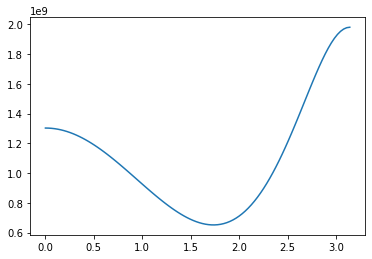

In [346]:
plt.plot(theta_th,Bk_mono_real)